Encoder-Decoder vs. Decoder-Only: The original Transformer (Vaswani et al. 2017) uses an encoder-decoder
structure. However, for forecasting, sometimes a decoder-only (auto-regressive) transformer is used. Briefly
discuss the difference and why a decoder-only Transformer can be sufficient for time series forecasting

A decoder-only Transformer is often sufficient for time series forecasting because the task only involves a single sequence, and future values can be predicted autoregressively from past values without needing a separate encoder to process different inputs.**pogrubiony tekst**

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True)


extract_dir = os.path.dirname(zip_path)
csv_path = os.path.join(extract_dir, "jena_climate_2009_2016_extracted", "jena_climate_2009_2016.csv")


if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    df.head()


13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  \
Date Time                                                                
2009-01-01 00:10:00  01.01.2009 00:10:00    996.52     -8.02    265.40   
2009-01-01 00:20:00  01.01.2009 00:20:00    996.57     -8.41    265.01   
2009-01-01 00:30:00  01.01.2009 00:30:00    996.53     -8.51    264.91   
2009-01-01 00:40:00  01.01.2009 00:40:00    996.51     -8.31    265.12   
2009-01-01 00:50:00  01.01.2009 00:50:00    996.51     -8.27    265.15   

                     Tdew (degC)  rh (%)  VPmax (mbar)  VPact (mbar)  \
Date Time                                                              
2009-01-01 00:10:00        -8.90    93.3          3.33          3.11   
2009-01-01 00:20:00        -9.28    93.4          3.23          3.02   
2009-01-01 00:30:00        -9.31    93.9          3.21          3.01   
2009-01-01 00:40:00        -9.07    94.2          3.26          3.07   
2009-01-01 00:50:00        -9.04    94.1          3.27          3.08   

                     VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
Date Time                                                                     
2009-01-01 00:10:00          0.22       1.94             3.12       1307.75   
2009-01-01 00:20:00          0.21       1.89             3.03       1309.80   
2009-01-01 00:30:00          0.20       1.88             3.02       1310.24   
2009-01-01 00:40:00          0.19       1.92             3.08       1309.19   
2009-01-01 00:50:00          0.19       1.92             3.09       1309.00   

                     wv (m/s)  max. wv (m/s)  wd (deg)  
Date Time                                               
2009-01-01 00:10:00      1.03           1.75     152.3  
2009-01-01 00:20:00      0.72           1.50     136.1  
2009-01-01 00:30:00      0.19           0.63     171.6  
2009-01-01 00:40:00      0.34           0.50     198.0  
2009-01-01 00:50:00      0.32           0.63     214.3

<Axes: >

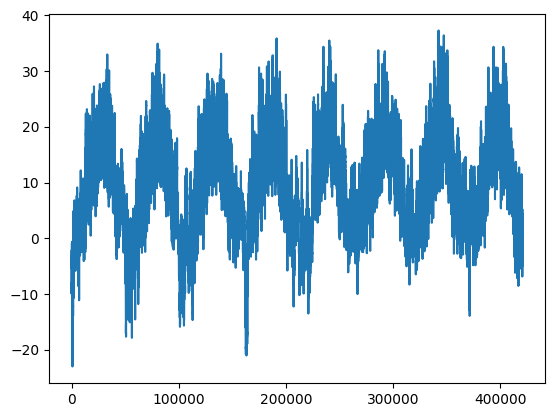

In [ ]:
temp = df['T (degC)']
temp.plot()

In [ ]:
def make_overlapping_windows(df, context_size=30, prediction_size=7):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - context_size - prediction_size + 1):
        context = df_as_np[i:i+context_size]
        target = df_as_np[i+context_size:i+context_size+prediction_size]
        X.append(context)
        y.append(target)
    return np.array(X), np.array(y)


CONTEXT_SIZE = 30
PREDICTION_SIZE = 7


X1, y1 = make_overlapping_windows(temp, CONTEXT_SIZE, PREDICTION_SIZE)


X_train1, X_remaining, y_train1, y_remaining = train_test_split(
    X1, y1, train_size=60000, shuffle=False)
X_val1, X_test1, y_val1, y_test1 = train_test_split(
    X_remaining, y_remaining, test_size=0.2, shuffle=False)

print(f'X_train1 Shape: {X_train1.shape}, y_train1 Shape: {y_train1.shape}')
print(f'X_val1 Shape: {X_val1.shape}, y_val1 Shape: {y_val1.shape}')
print(f'X_test1 Shape: {X_test1.shape}, y_test1 Shape: {y_test1.shape}')

X_train1 Shape: (60000, 30), y_train1 Shape: (60000, 7)
X_val1 Shape: (288412, 30), y_val1 Shape: (288412, 7)
X_test1 Shape: (72103, 30), y_test1 Shape: (72103, 7)


#TRANSFORMER 30 -> 7

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


CONTEXT_SIZE = 30
PREDICTION_SIZE = 7
NUM_EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.001
D_MODEL = 64
NHEAD = 4
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PATIENCE = 7


X_train_tensor = torch.FloatTensor(X_train1).unsqueeze(-1).to(device)
y_train_tensor = torch.FloatTensor(y_train1).unsqueeze(-1).to(device)
X_val_tensor = torch.FloatTensor(X_val1).unsqueeze(-1).to(device)
y_val_tensor = torch.FloatTensor(y_val1).unsqueeze(-1).to(device)
X_test_tensor = torch.FloatTensor(X_test1).unsqueeze(-1).to(device)
y_test_tensor = torch.FloatTensor(y_test1).unsqueeze(-1).to(device)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, d_model, 2).float().to(device) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers,
                 num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_linear = nn.Linear(input_dim, d_model)
        self.output_linear = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.final_linear = nn.Linear(d_model, output_dim)
        self.d_model = d_model

    def forward(self, src, tgt):
        src = self.input_linear(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        tgt = self.output_linear(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        src_mask = None
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(device) #prevents the decoder from seeing future time steps (it can only look at past values).
        memory_mask = None
        output = self.transformer(src, tgt, src_mask, tgt_mask, memory_mask)
        return self.final_linear(output)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)) #mask is added to attention results before softmax; lower tringular mask, 0 has no effect on softmax, -inf will return -1
        return mask

model = TimeSeriesTransformer(1, 1, D_MODEL, NHEAD, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, DIM_FEEDFORWARD, DROPOUT).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for src, tgt in train_loader:
        decoder_input = torch.zeros(src.size(0), PREDICTION_SIZE, 1, device=device) # [batch, 7, 1]
        decoder_input[:, 0, :] = src[:, -1, :] # predicts all 7 steps at once
        optimizer.zero_grad()
        outputs = model(src, decoder_input)  # compare to full 7-step target
        loss = criterion(outputs, tgt)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src, tgt in val_loader:
            decoder_input = torch.zeros(src.size(0), PREDICTION_SIZE, 1, device=device)
            decoder_input[:, 0, :] = src[:, -1, :]
            outputs = model(src, decoder_input)
            val_loss += criterion(outputs, tgt).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

model.load_state_dict(torch.load('best_model.pth'))

Using device: cuda
Epoch 1, Train Loss: 25.4629, Val Loss: 6.2537
Epoch 2, Train Loss: 2.5332, Val Loss: 2.1752
Epoch 3, Train Loss: 1.3820, Val Loss: 1.8042
Epoch 4, Train Loss: 1.0853, Val Loss: 1.1778
Epoch 5, Train Loss: 0.9644, Val Loss: 1.3029
Epoch 6, Train Loss: 0.8593, Val Loss: 1.1826
Epoch 7, Train Loss: 0.8309, Val Loss: 0.9054
Epoch 8, Train Loss: 0.7929, Val Loss: 1.0110
Epoch 9, Train Loss: 0.7575, Val Loss: 1.1047
Epoch 10, Train Loss: 0.7482, Val Loss: 1.0579
Epoch 11, Train Loss: 0.7511, Val Loss: 1.0898
Epoch 12, Train Loss: 0.7368, Val Loss: 1.6103
Epoch 13, Train Loss: 0.6985, Val Loss: 1.3948
Early stopping at epoch 14


<All keys matched successfully>

Using device: cuda
Overall RMSE: 1.3624
Overall MAE: 0.9380
MAE at day +1: 0.5256, day +3: 0.8520, day +7: 1.2648


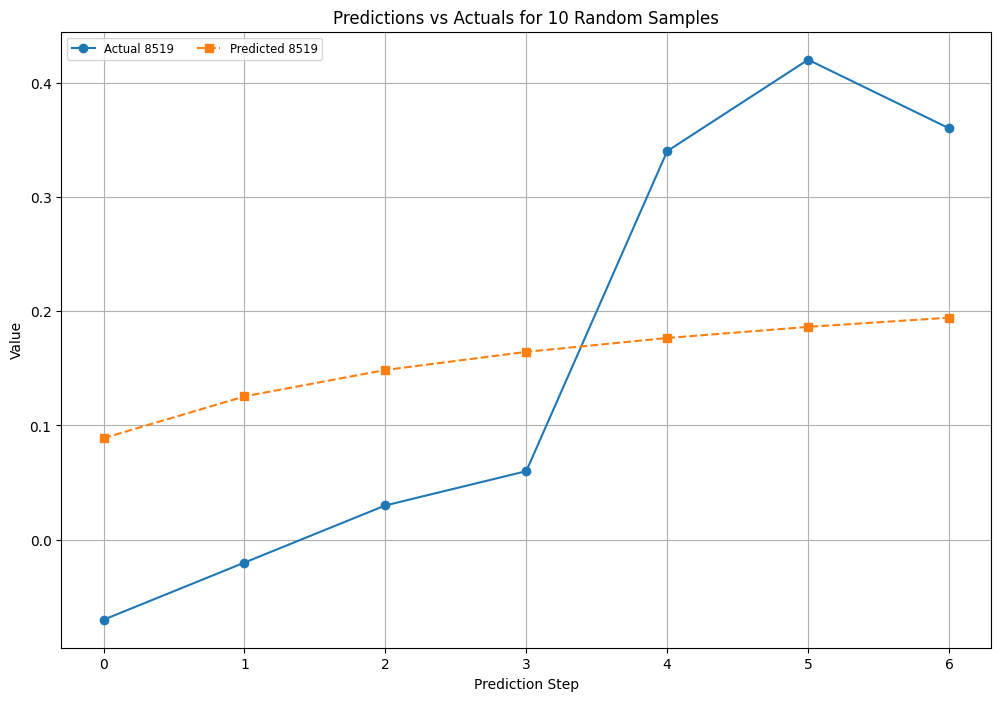

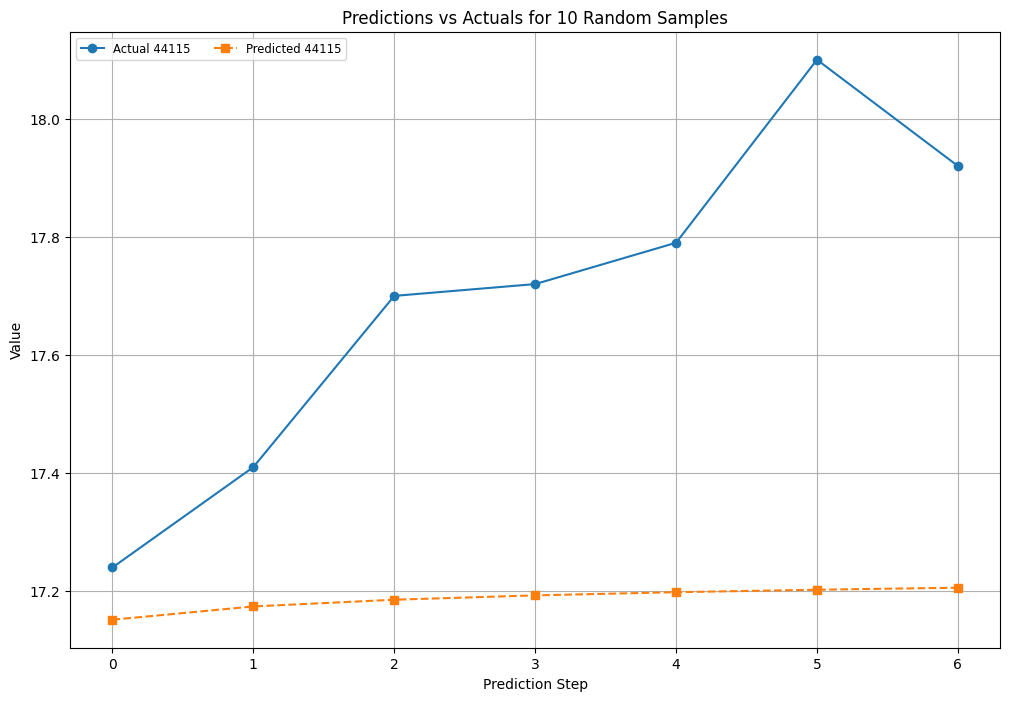

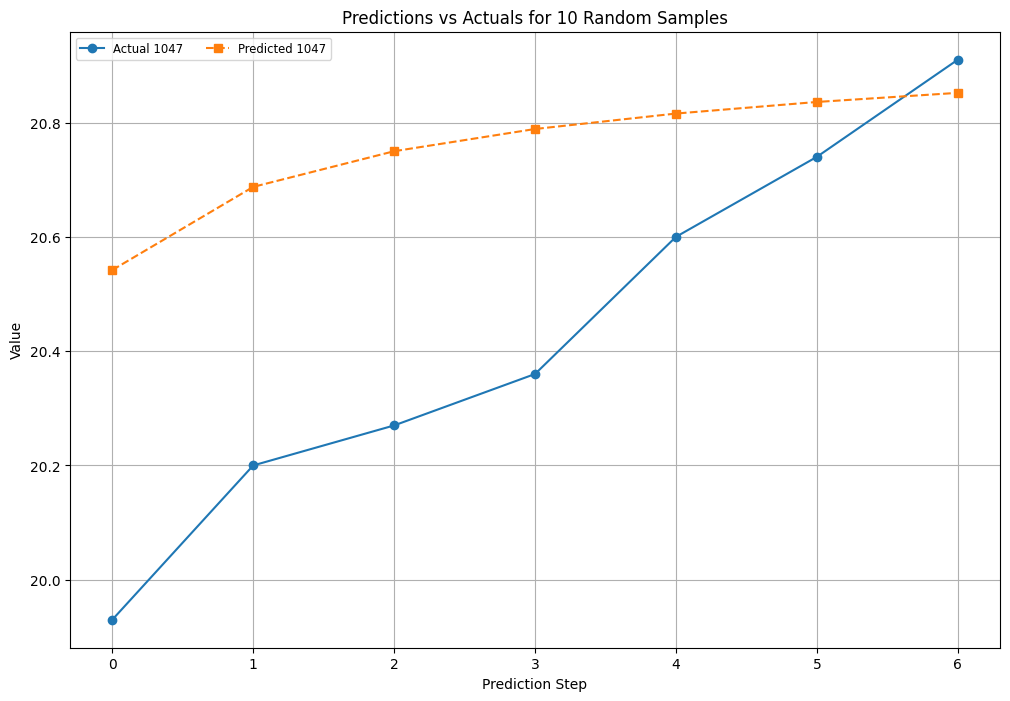

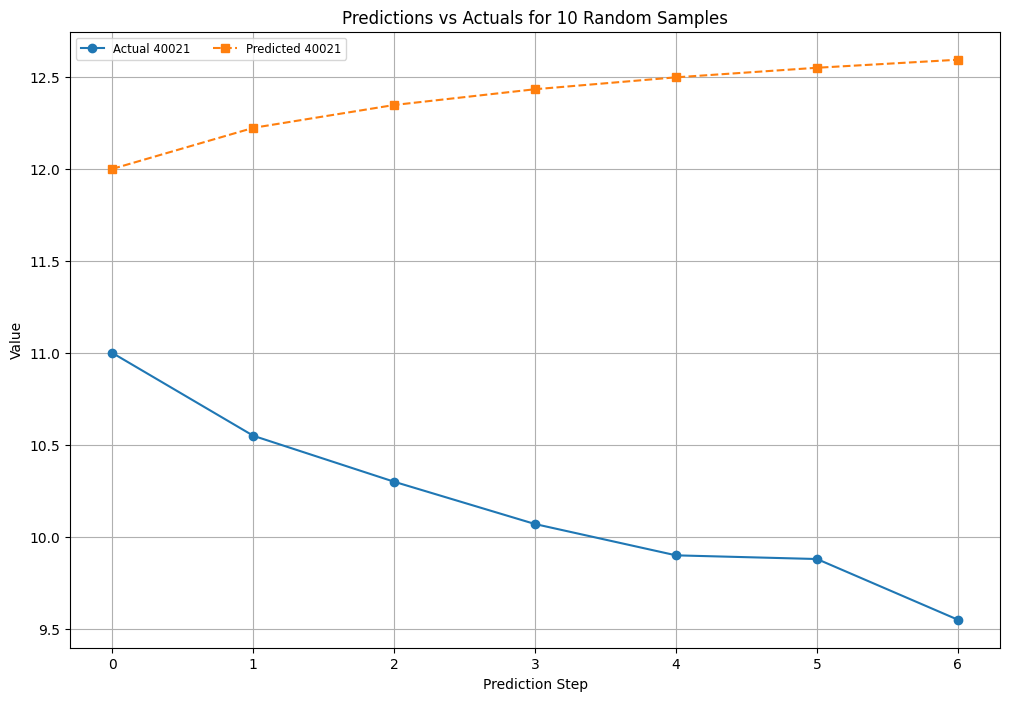

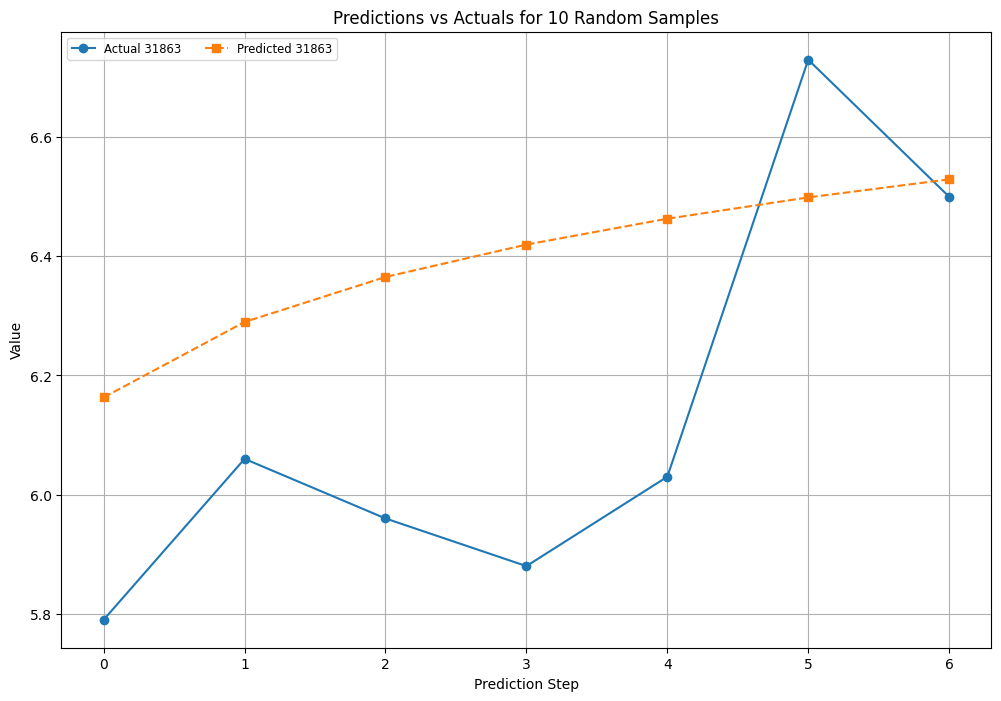

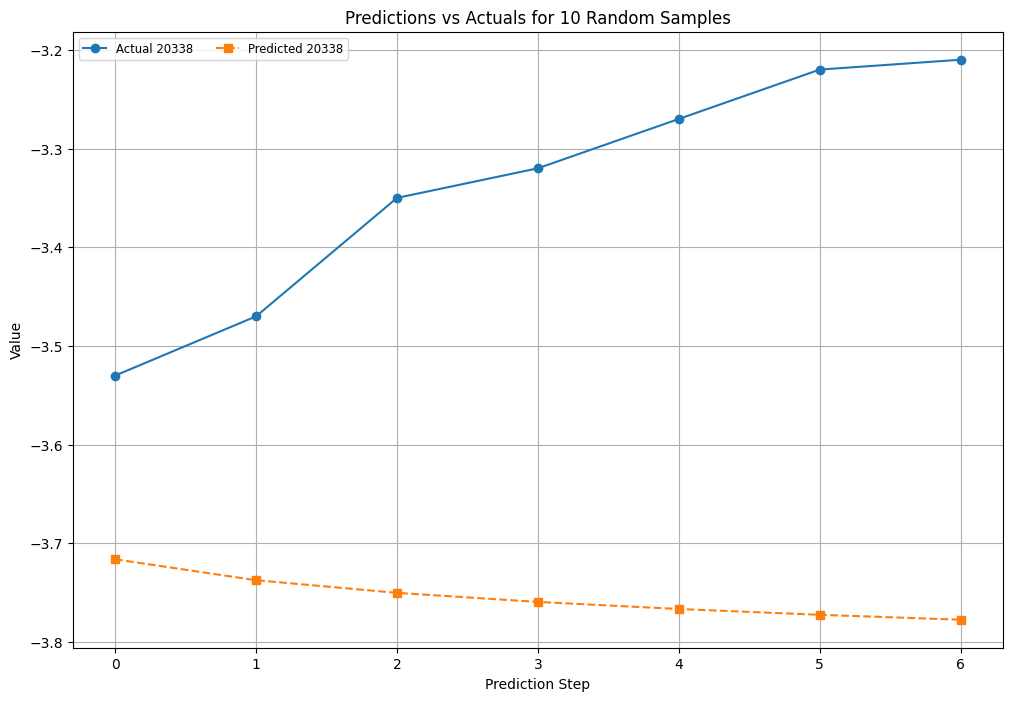

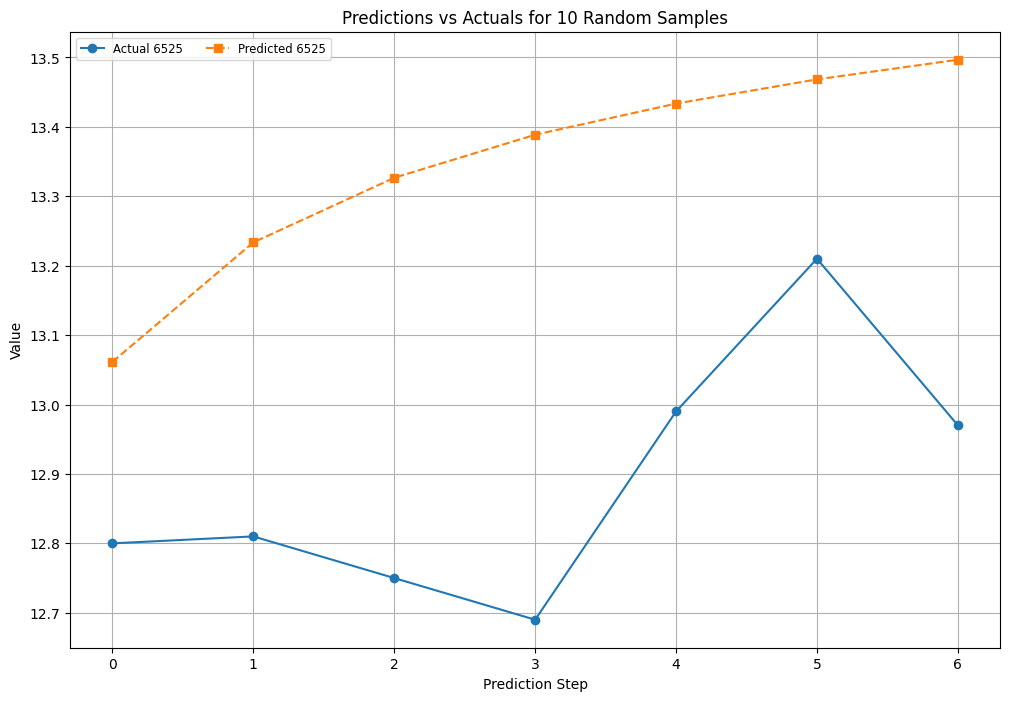

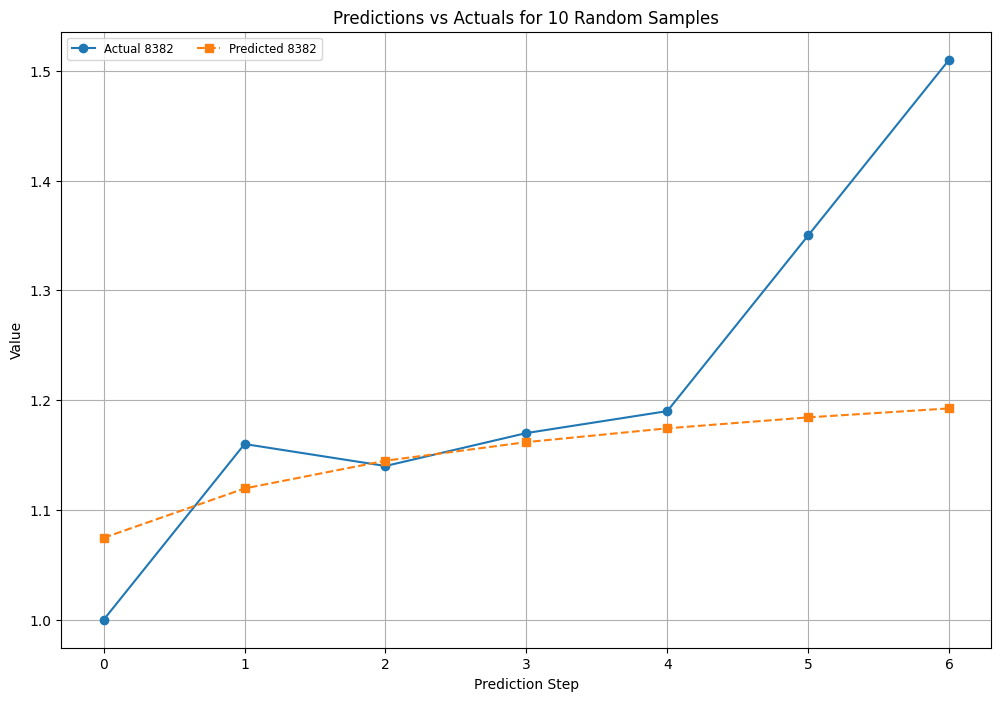

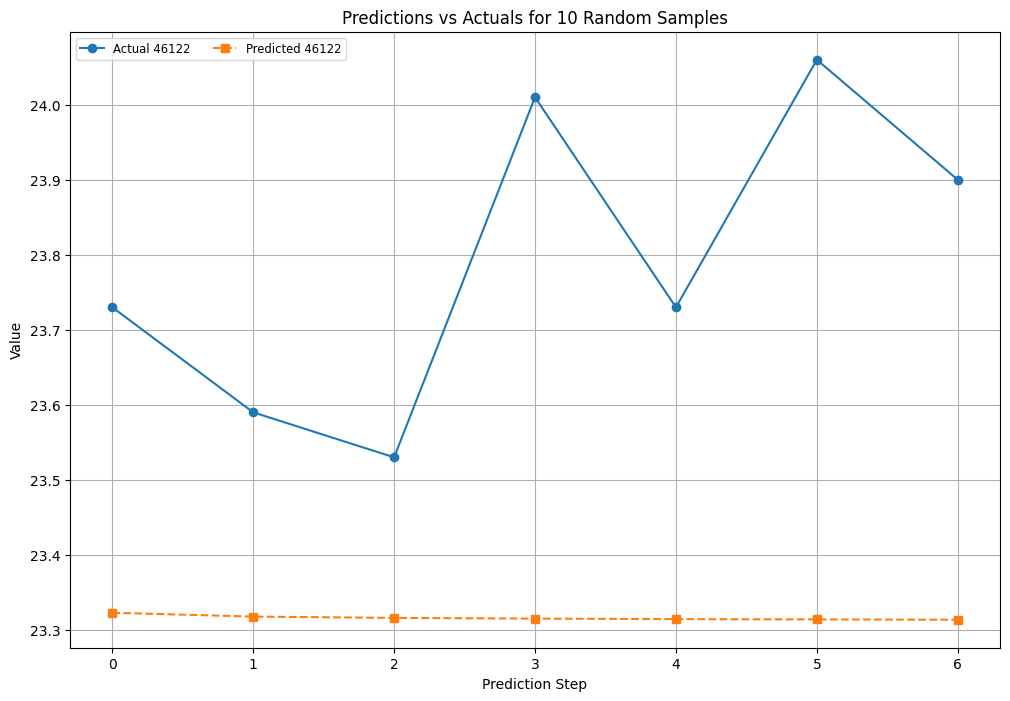

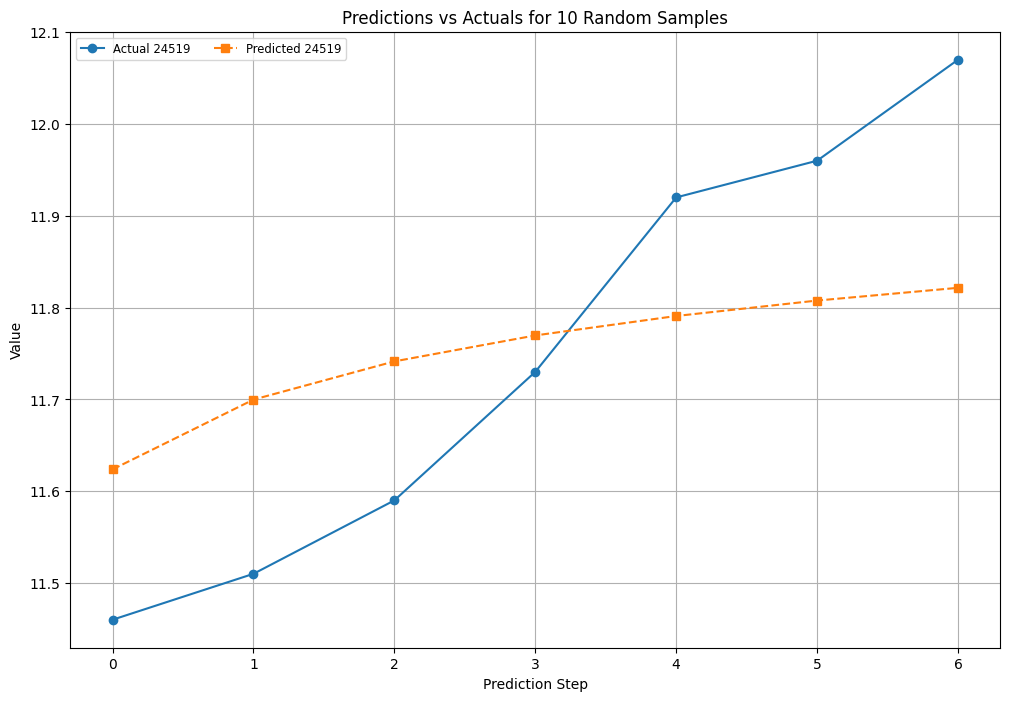

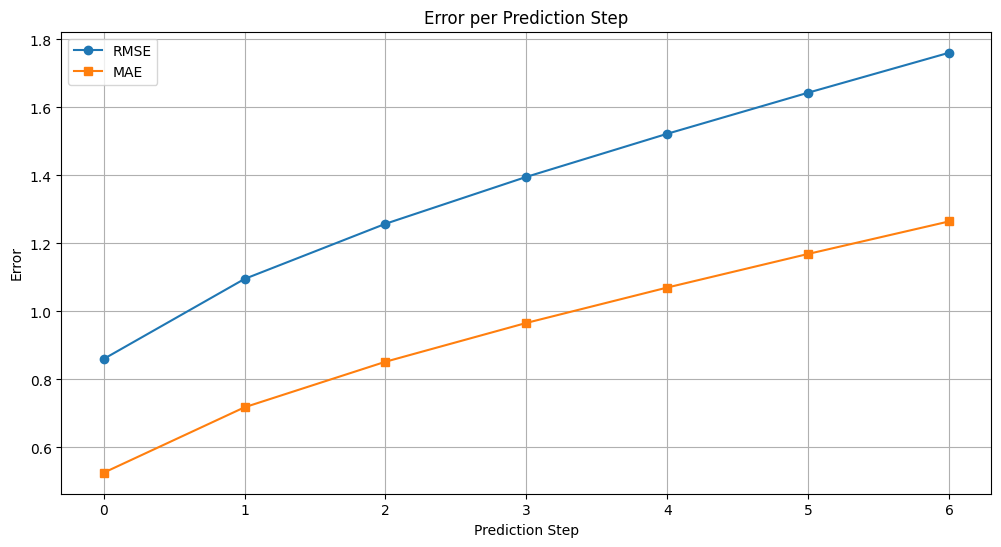

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = TimeSeriesTransformer(
    input_dim=1,
    output_dim=1,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


model.load_state_dict(torch.load('best_model.pth'))
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for src, tgt in test_loader:
        decoder_input = torch.zeros(src.size(0), PREDICTION_SIZE, 1, device=device)  #wejście dla dekodera - same zera (batch_size,seq_length,1)
        decoder_input[:, 0, :] = src[:, -1, :] #jako pierwsze ostatnie wejście z src

        for i in range(PREDICTION_SIZE):
            outputs = model(src, decoder_input)
            if i < PREDICTION_SIZE - 1:
                decoder_input[:, i+1, :] = outputs[:, i, :]

        predictions.append(outputs.cpu().numpy())
        actuals.append(tgt.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

rmse_per_step = np.sqrt(np.mean((actuals - predictions) ** 2, axis=0))
mae_per_step = np.mean(np.abs(actuals - predictions), axis=0)
print(f'Overall RMSE: {float(np.mean(rmse_per_step)):.4f}')
print(f'Overall MAE: {float(np.mean(mae_per_step)):.4f}')
print(f'MAE at day +1: {mae_per_step[0].item():.4f}, day +3: {mae_per_step[2].item():.4f}, day +7: {mae_per_step[6].item():.4f}')


random_indices = random.sample(range(len(actuals)), 10)


for idx in random_indices:
    plt.figure(figsize=(12, 8))
    plt.plot(actuals[idx], label=f"Actual {idx}", marker='o', linestyle="-")
    plt.plot(predictions[idx], label=f"Predicted {idx}", marker='s', linestyle="dashed")
    plt.xlabel("Prediction Step")
    plt.ylabel("Value")
    plt.title("Predictions vs Actuals for 10 Random Samples")
    plt.legend(loc="upper left", fontsize="small", ncol=2)
    plt.grid()
    plt.show()


plt.figure(figsize=(12, 6))
plt.plot(rmse_per_step, label="RMSE", marker='o')
plt.plot(mae_per_step, label="MAE", marker='s')
plt.xlabel("Prediction Step")
plt.ylabel("Error")
plt.title("Error per Prediction Step")
plt.legend()
plt.grid()
plt.show()



Using device: cuda
Epoch 1, Train Loss: 23.9139, Val Loss: 5.2542
Epoch 2, Train Loss: 1.8683, Val Loss: 1.9198
Epoch 3, Train Loss: 0.8247, Val Loss: 1.8187
Epoch 4, Train Loss: 0.6284, Val Loss: 0.9403
Epoch 5, Train Loss: 0.4874, Val Loss: 2.0538
Early stopping at epoch 6
Overall RMSE: 1.9513
Overall MAE: 1.6501
MAE at day +1: 0.5364, day +3: 1.3574, day +7: 2.6048


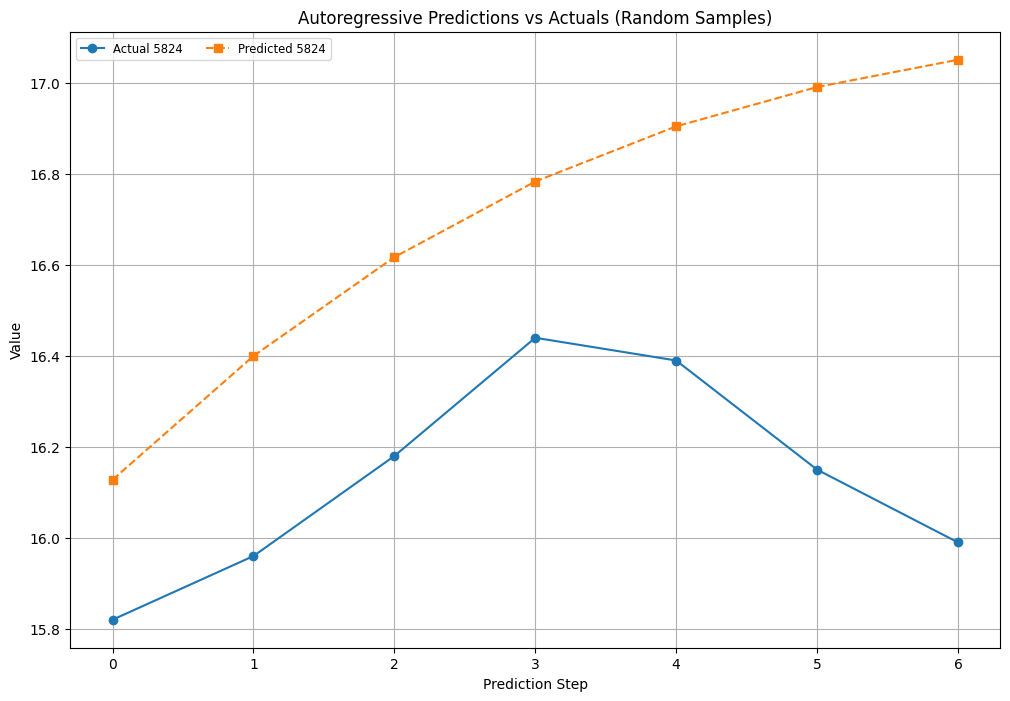

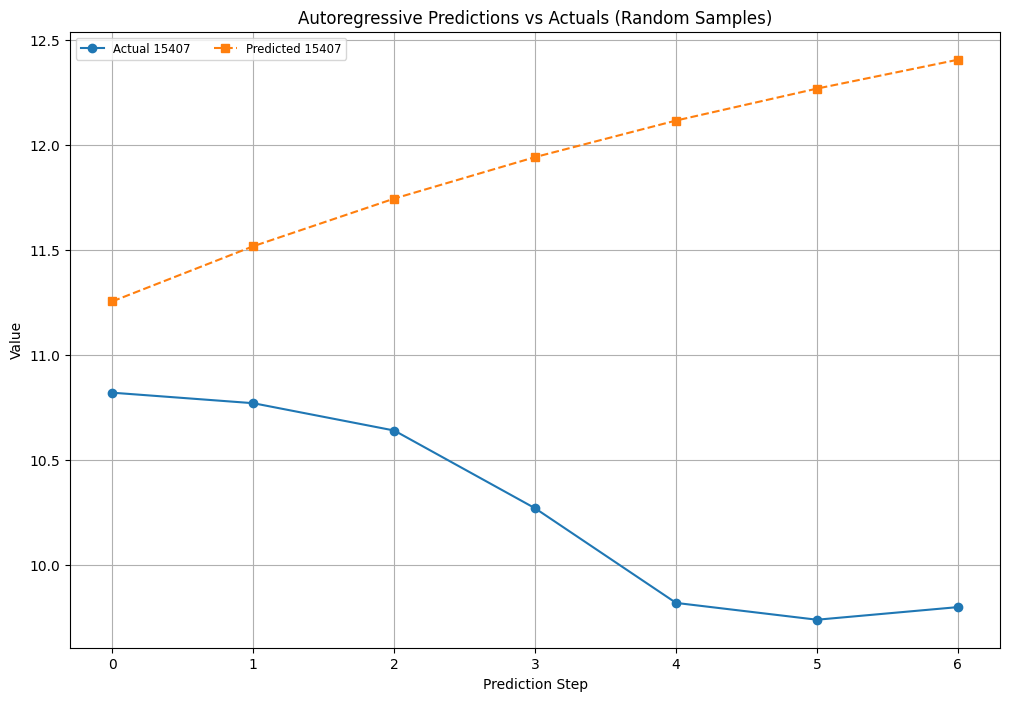

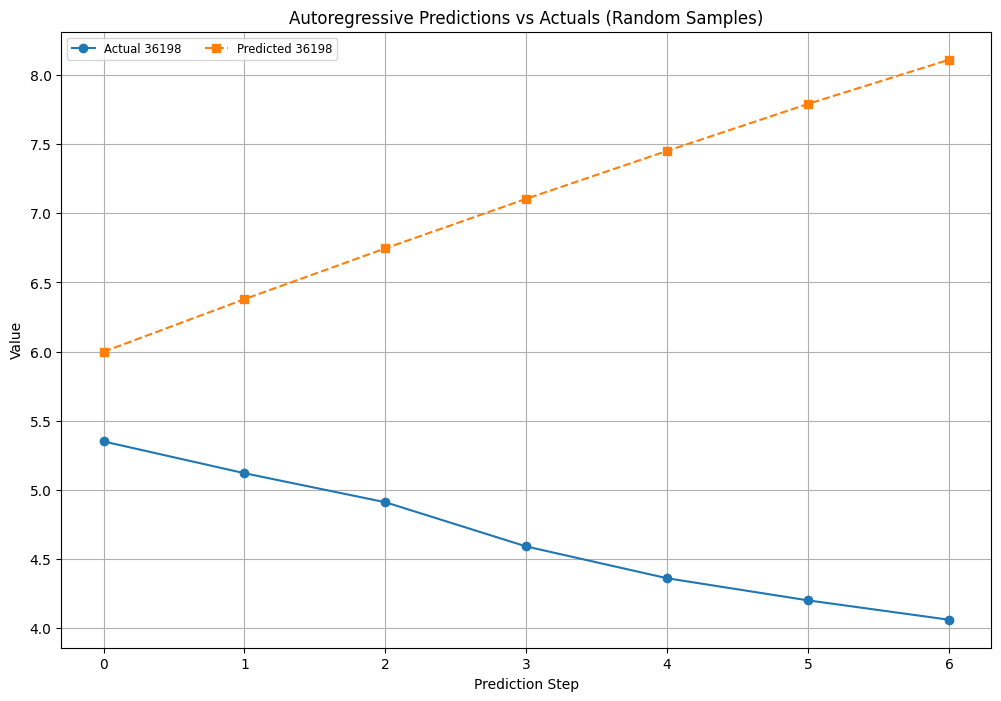

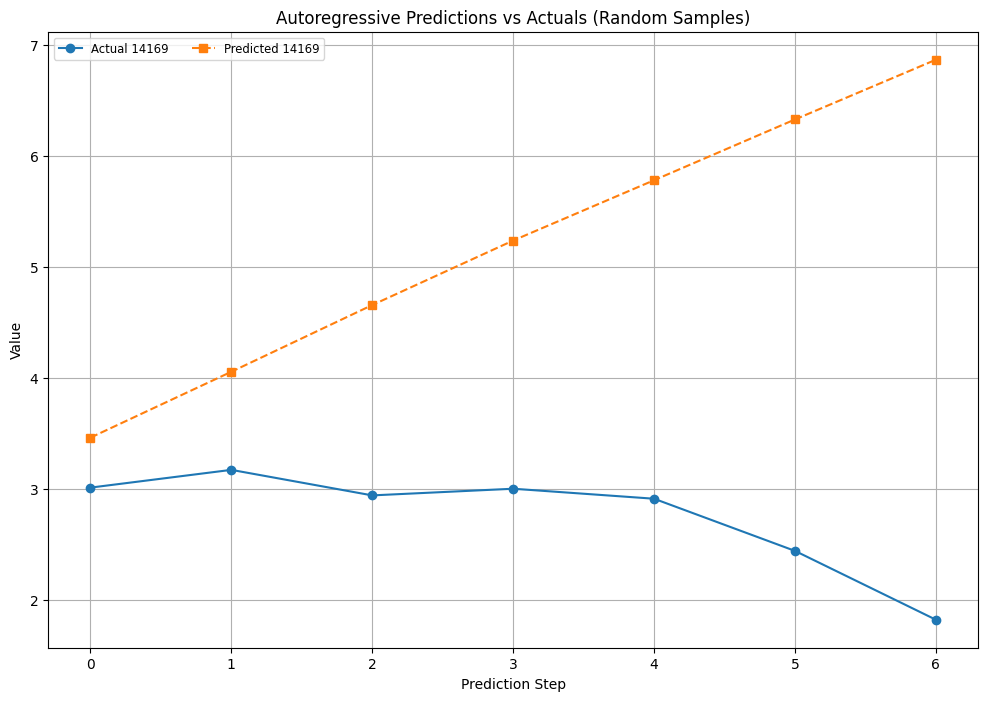

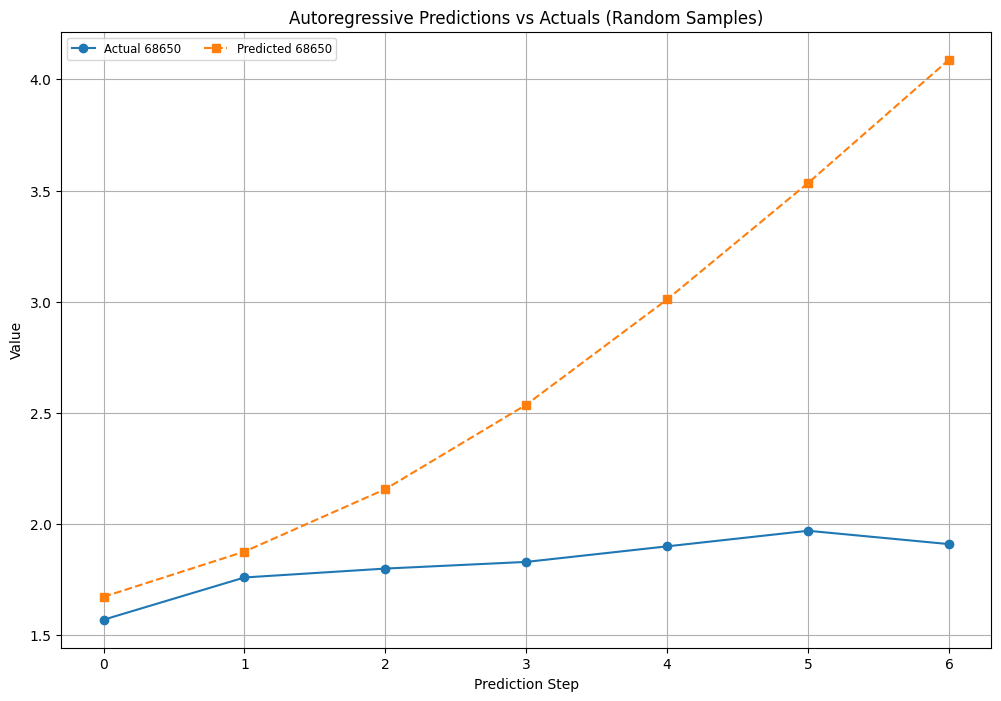

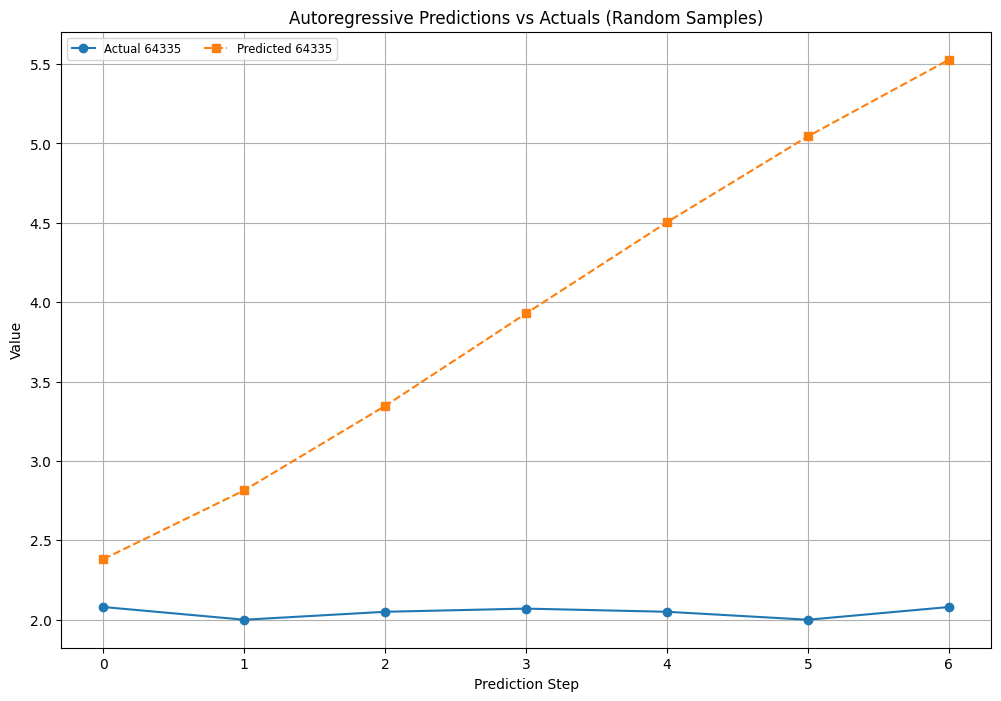

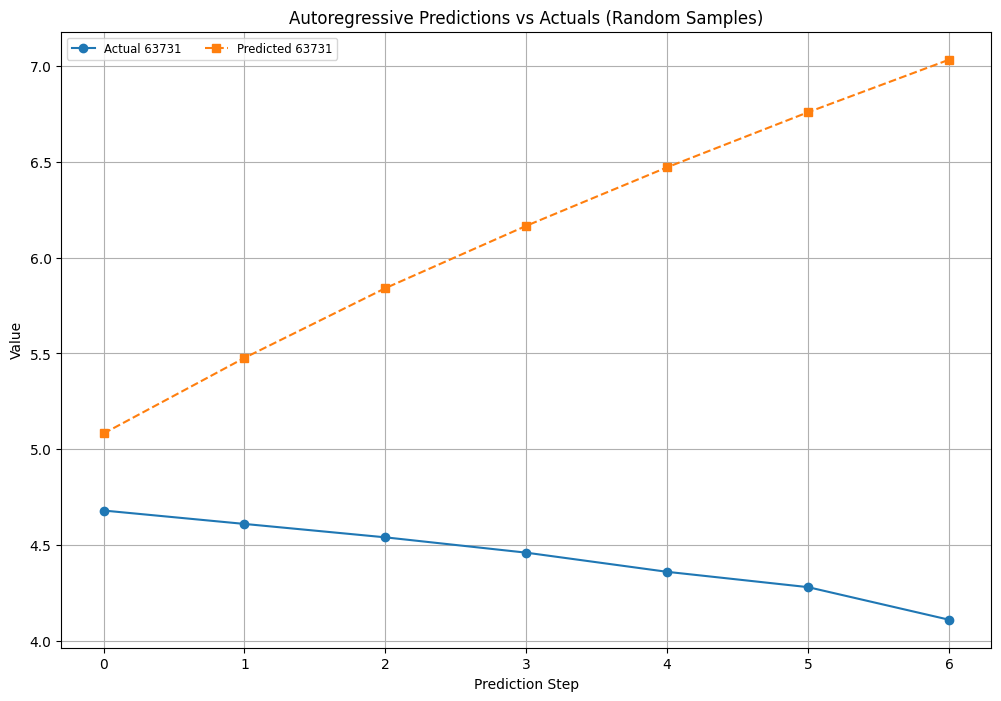

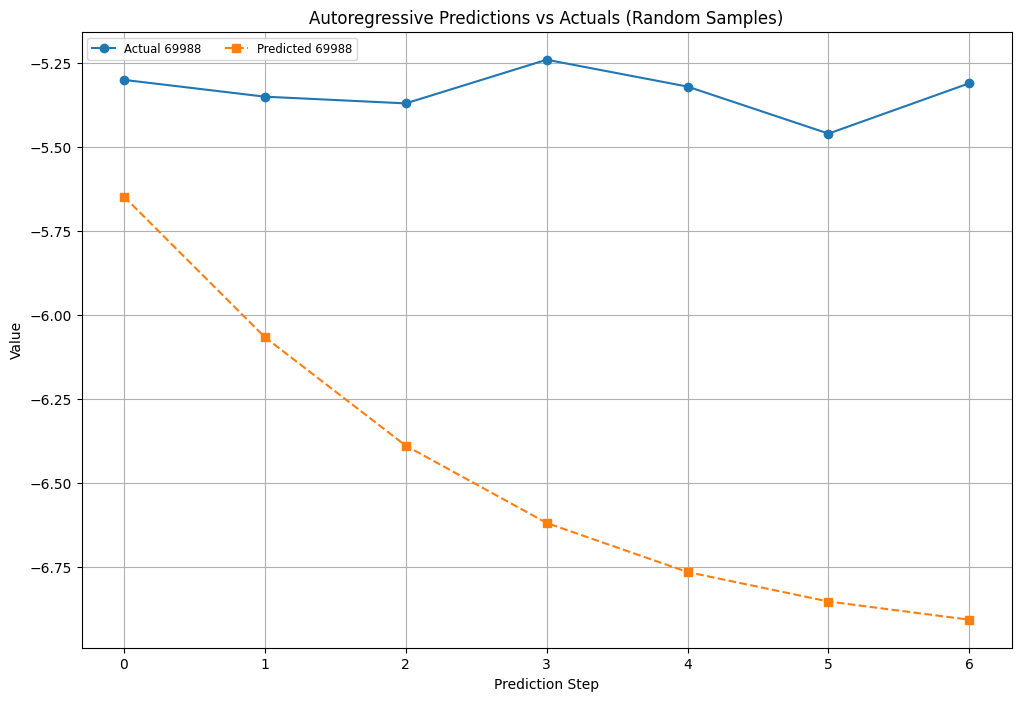

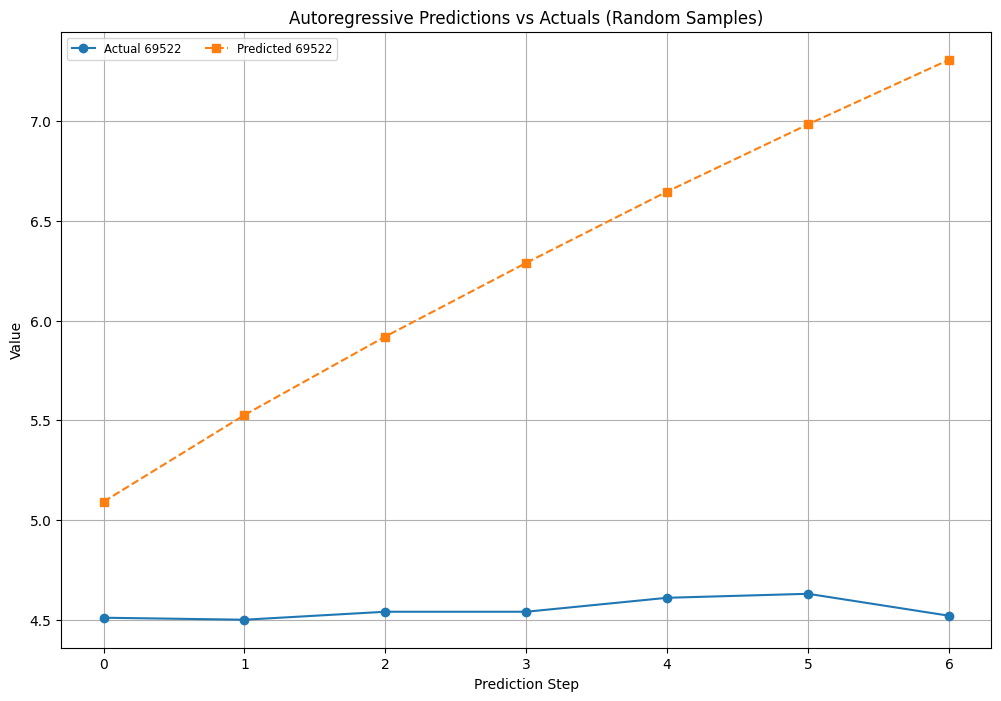

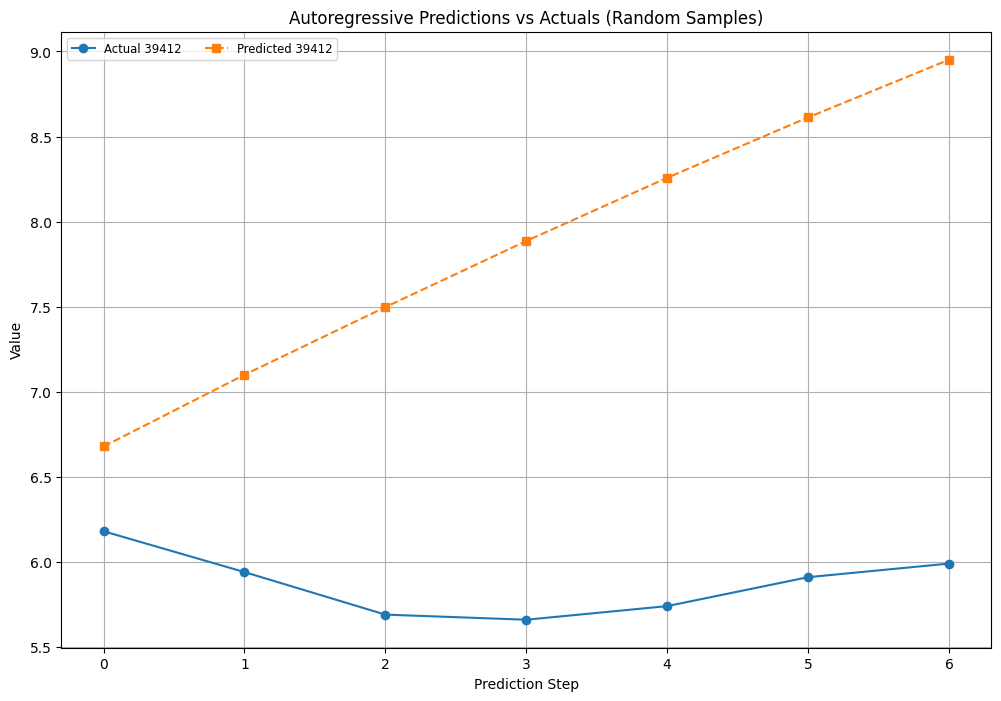

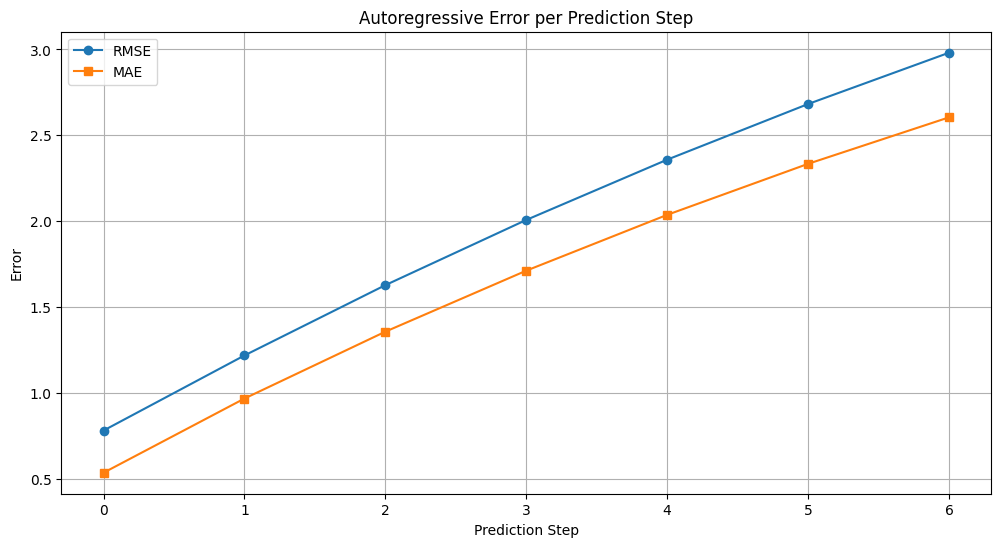

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from torch.utils.data import TensorDataset, DataLoader


#AUTOREGRESSIVE PREDICTION IN TRANSFORMER

CONTEXT_SIZE = 30
PREDICTION_SIZE = 7
NUM_EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.001
D_MODEL = 64
NHEAD = 4
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PATIENCE = 2

X_train_tensor = torch.FloatTensor(X_train1).unsqueeze(-1).to(device)
y_train_tensor = torch.FloatTensor(y_train1).unsqueeze(-1).to(device)
X_val_tensor = torch.FloatTensor(X_val1).unsqueeze(-1).to(device)
y_val_tensor = torch.FloatTensor(y_val1).unsqueeze(-1).to(device)
X_test_tensor = torch.FloatTensor(X_test1).unsqueeze(-1).to(device)
y_test_tensor = torch.FloatTensor(y_test1).unsqueeze(-1).to(device)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model definition (autoregressive version)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers,
                 num_decoder_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.final_linear = nn.Linear(d_model, output_dim)

    def generate_mask(self, sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1).to(device)

    def forward(self, src, tgt):
        # Encoder
        src = self.input_linear(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)

        # Decoder
        tgt = self.input_linear(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        tgt_mask = self.generate_mask(tgt.size(1))

        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        return self.final_linear(output)

    def predict_autoregressive(self, src, prediction_steps):
        self.eval()
        with torch.no_grad():
            # encode source
            src_encoded = self.input_linear(src) * math.sqrt(self.d_model)
            src_encoded = self.pos_encoder(src_encoded)

            # initialize with last source element
            decoder_input = src[:, -1:, :]  # [batch, 1, 1]
            predictions = []

            for _ in range(prediction_steps):
                # prepare decoder input
                tgt = self.input_linear(decoder_input) * math.sqrt(self.d_model)
                tgt = self.pos_encoder(tgt)
                tgt_mask = self.generate_mask(tgt.size(1))

                # predict next step
                output = self.transformer(src_encoded, tgt, tgt_mask=tgt_mask)
                next_step = self.final_linear(output[:, -1:, :])  # take last prediction
                predictions.append(next_step)

                # update decoder input
                decoder_input = torch.cat([decoder_input, next_step], dim=1)[:, 1:, :]  # slide window

            return torch.cat(predictions, dim=1)


model = TimeSeriesTransformer(
    input_dim=1,
    output_dim=1,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# training loop (autoregressive)
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    for src, tgt in train_loader:
        optimizer.zero_grad()

        # teacher forcing with autoregressive rollout
        decoder_input = src[:, -1:, :]  # start with last source element
        predictions = []

        for step in range(PREDICTION_SIZE):
            output = model(src, decoder_input)
            predictions.append(output[:, -1:, :])
            decoder_input = torch.cat([decoder_input, tgt[:, step:step+1, :]], dim=1)

        # compute loss on all steps
        predictions = torch.cat(predictions, dim=1)
        loss = criterion(predictions, tgt)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src, tgt in val_loader:
            decoder_input = src[:, -1:, :]
            predictions = []

            for step in range(PREDICTION_SIZE):
                output = model(src, decoder_input)
                predictions.append(output[:, -1:, :])
                decoder_input = torch.cat([decoder_input, tgt[:, step:step+1, :]], dim=1)

            val_loss += criterion(torch.cat(predictions, dim=1), tgt).item()

    #learning rate and early stopping
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_autoregressive_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


model.load_state_dict(torch.load('best_autoregressive_model.pth'))
model.eval()


predictions = []
actuals = []

with torch.no_grad():
    for src, tgt in test_loader:
        # autoregressive prediction
        pred = model.predict_autoregressive(src, PREDICTION_SIZE)
        predictions.append(pred.cpu().numpy())
        actuals.append(tgt.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)


rmse_per_step = np.sqrt(np.mean((actuals - predictions) ** 2, axis=0))
mae_per_step = np.mean(np.abs(actuals - predictions), axis=0)
print(f'Overall RMSE: {float(np.mean(rmse_per_step)):.4f}')
print(f'Overall MAE: {float(np.mean(mae_per_step)):.4f}')
print(f'MAE at day +1: {mae_per_step[0].item():.4f}, day +3: {mae_per_step[2].item():.4f}, day +7: {mae_per_step[6].item():.4f}')


random_indices = random.sample(range(len(actuals)), 10)

for idx in random_indices:
    plt.figure(figsize=(12, 8))
    plt.plot(actuals[idx], label=f"Actual {idx}", marker='o', linestyle="-")
    plt.plot(predictions[idx], label=f"Predicted {idx}", marker='s', linestyle="dashed")
    plt.xlabel("Prediction Step")
    plt.ylabel("Value")
    plt.title("Autoregressive Predictions vs Actuals (Random Samples)")
    plt.legend(loc="upper left", fontsize="small", ncol=2)
    plt.grid()
    plt.show()

plt.figure(figsize=(12, 6))
plt.plot(rmse_per_step, label="RMSE", marker='o')
plt.plot(mae_per_step, label="MAE", marker='s')
plt.xlabel("Prediction Step")
plt.ylabel("Error")
plt.title("Autoregressive Error per Prediction Step")
plt.legend()
plt.grid()
plt.show()

#LSTM 30 -> 7

Epoch 1/20: Train Loss: 40.6835, Val Loss: 11.3647
Epoch 2/20: Train Loss: 4.7614, Val Loss: 3.5878
Epoch 3/20: Train Loss: 1.5757, Val Loss: 1.9429
Epoch 4/20: Train Loss: 0.8765, Val Loss: 1.3434
Epoch 5/20: Train Loss: 0.6470, Val Loss: 1.0767
Epoch 6/20: Train Loss: 0.5448, Val Loss: 0.8824
Epoch 7/20: Train Loss: 0.4898, Val Loss: 0.7717
Epoch 8/20: Train Loss: 0.4576, Val Loss: 0.8102
Epoch 9/20: Train Loss: 0.4340, Val Loss: 0.6459
Epoch 10/20: Train Loss: 0.4180, Val Loss: 0.6119
Epoch 11/20: Train Loss: 0.4042, Val Loss: 0.5883
Epoch 12/20: Train Loss: 0.3967, Val Loss: 0.5504
Epoch 13/20: Train Loss: 0.3913, Val Loss: 0.5437
Epoch 14/20: Train Loss: 0.3852, Val Loss: 0.5175
Epoch 15/20: Train Loss: 0.3833, Val Loss: 0.4994
Epoch 16/20: Train Loss: 0.3798, Val Loss: 0.5004
Epoch 17/20: Train Loss: 0.3744, Val Loss: 0.4893
Epoch 18/20: Train Loss: 0.3694, Val Loss: 0.4815
Epoch 19/20: Train Loss: 0.3664, Val Loss: 0.4549
Epoch 20/20: Train Loss: 0.3647, Val Loss: 0.4677
Overall

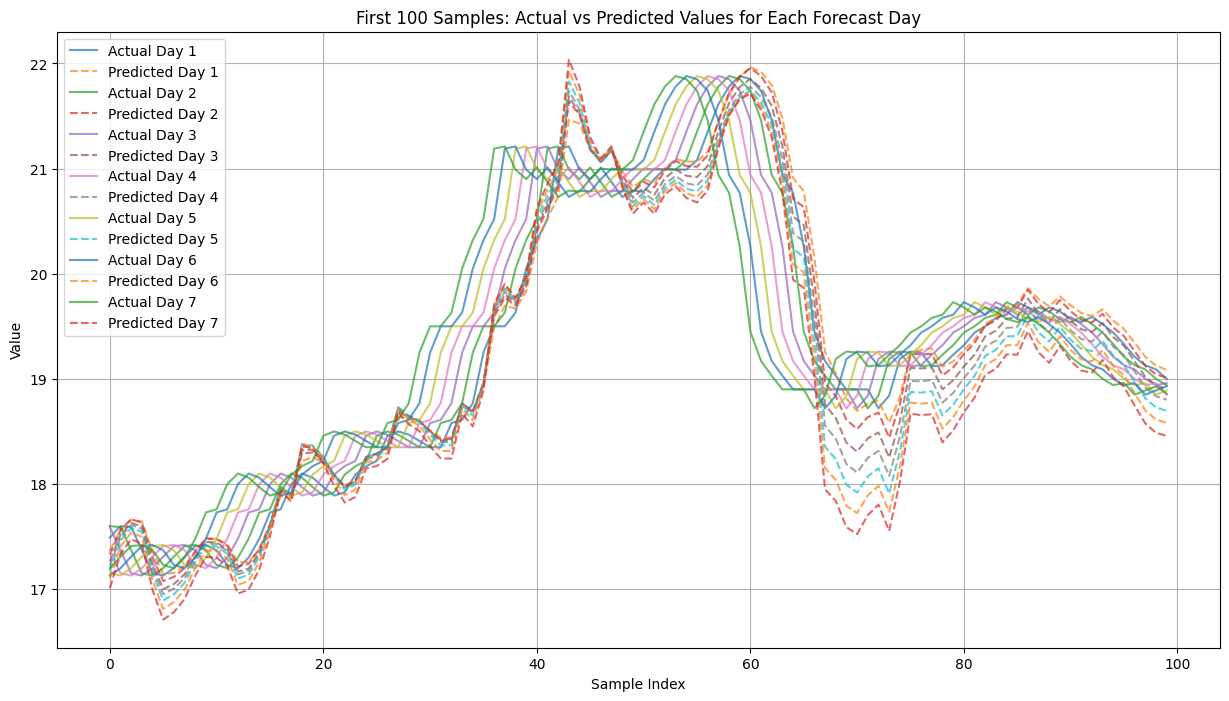

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

CONTEXT_SIZE = 30
PREDICTION_SIZE = 7
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

class Seq2SeqLSTM(nn.Module):
    def __init__(self):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.decoder = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, src, tgt):
        _, (hidden, cell) = self.encoder(src)
        decoder_input = torch.zeros(tgt.size(0), PREDICTION_SIZE, 1, device=src.device) #wejście dla dekodera - same zera (batch_size,seq_length,1)
        decoder_input[:, 0, :] = src[:, -1, :] #jako pierwsze ostatnie  z src

        outputs = []
        for i in range(PREDICTION_SIZE):
            out, (hidden, cell) = self.decoder(decoder_input[:, i:i+1, :], (hidden, cell)) #out: (batch_size,1,hidden_size)
            out = self.fc(out)
            outputs.append(out)
            if i < PREDICTION_SIZE - 1:
                decoder_input = decoder_input.clone()  # clone to prevent in-place modification
                decoder_input[:, i+1, :] = out.squeeze(1)

        return torch.cat(outputs, dim=1).squeeze(-1)


def make_sequence_windows(df, context_size=30, prediction_size=7):
    df_as_np = df.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np) - context_size - prediction_size + 1):
        X.append(df_as_np[i:i+context_size].reshape(-1, 1))
        y.append(df_as_np[i+context_size:i+context_size+prediction_size])
    return np.array(X), np.array(y)

X, y = make_sequence_windows(temp, CONTEXT_SIZE, PREDICTION_SIZE)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, train_size=60000, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.2, shuffle=False)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2SeqLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

best_val_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        outputs = model(src, tgt)
        loss = criterion(outputs, tgt)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            outputs = model(src, tgt)
            val_loss += criterion(outputs, tgt).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_lstm_model.pth')

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

model.load_state_dict(torch.load('best_lstm_model.pth'))
model.eval()

test_predictions = []
with torch.no_grad():
    for src, _ in test_loader:
        src = src.to(device)
        tgt = torch.zeros(src.size(0), PREDICTION_SIZE, device=device)
        outputs = model(src, tgt)
        test_predictions.append(outputs.cpu().numpy())

test_predictions = np.concatenate(test_predictions)

def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("-" * 30)

overall_mae = mean_absolute_error(y_test, test_predictions)
overall_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Overall MAE: {overall_mae:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")

for i in range(PREDICTION_SIZE):
    step_mae = mean_absolute_error(y_test[:, i], test_predictions[:, i])
    step_rmse = np.sqrt(mean_squared_error(y_test[:, i], test_predictions[:, i]))
    print(f"Day +{i+1} MAE: {step_mae:.4f}, RMSE: {step_rmse:.4f}")

plt.figure(figsize=(15, 8))
for i in range(PREDICTION_SIZE): #Błąd rośnie z czasem ->  model coraz bardziej polega na własnych prognozach zamiast rzeczywistych danych
    plt.plot(y_test[:100, i], label=f'Actual Day {i+1}', alpha=0.7)
    plt.plot(test_predictions[:100, i], label=f'Predicted Day {i+1}', linestyle='--', alpha=0.7)
plt.legend()
plt.title('First 100 Samples: Actual vs Predicted Values for Each Forecast Day')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()


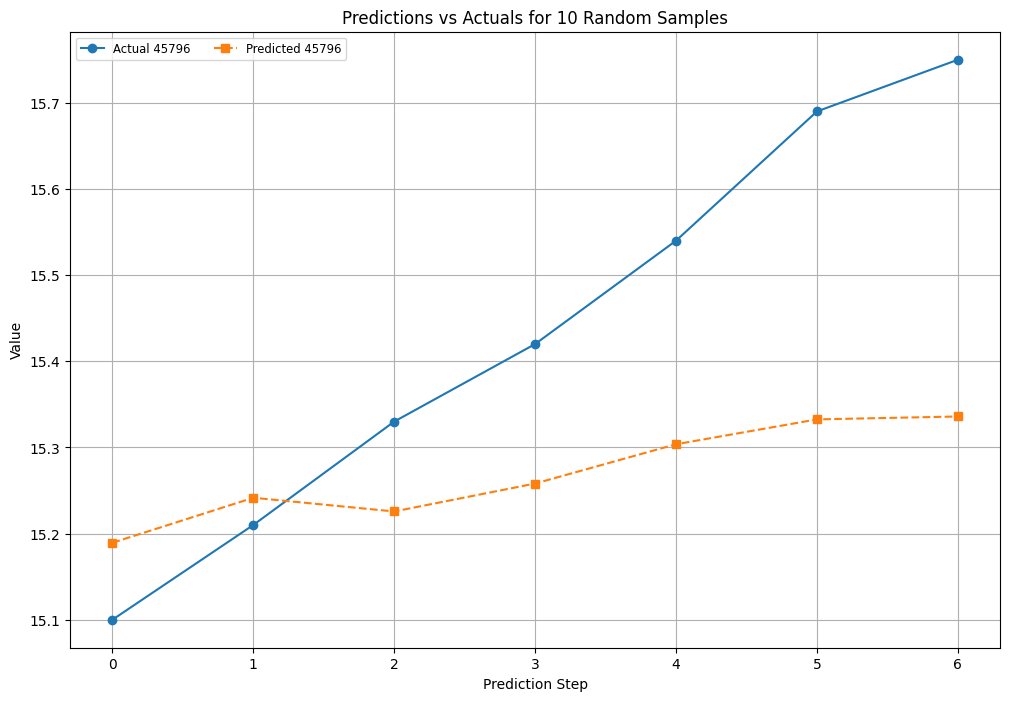

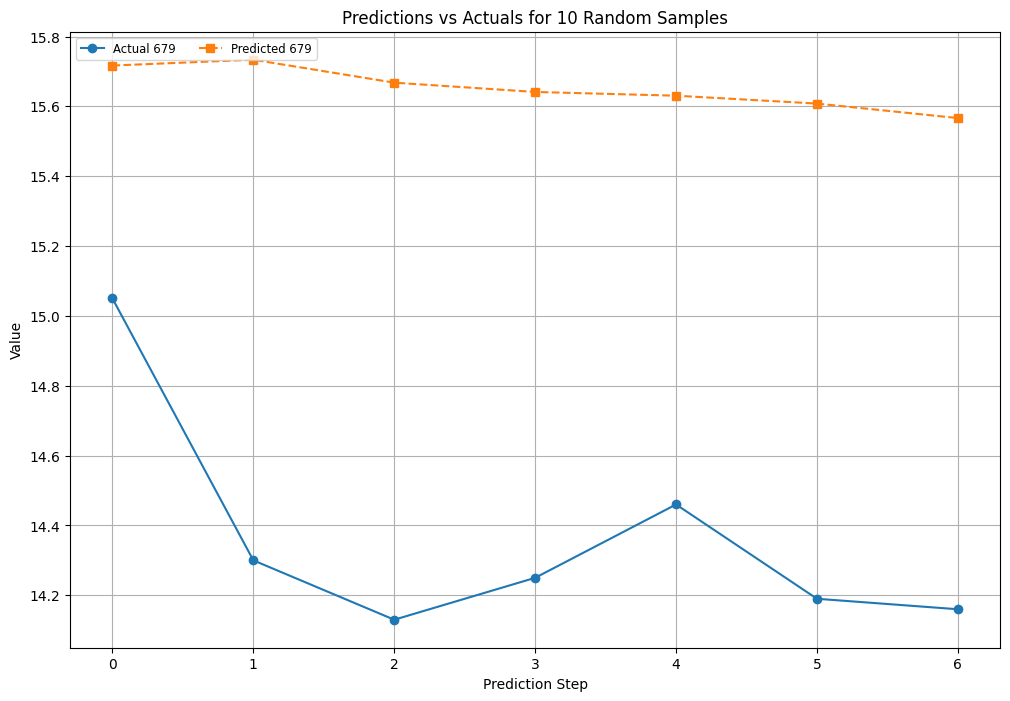

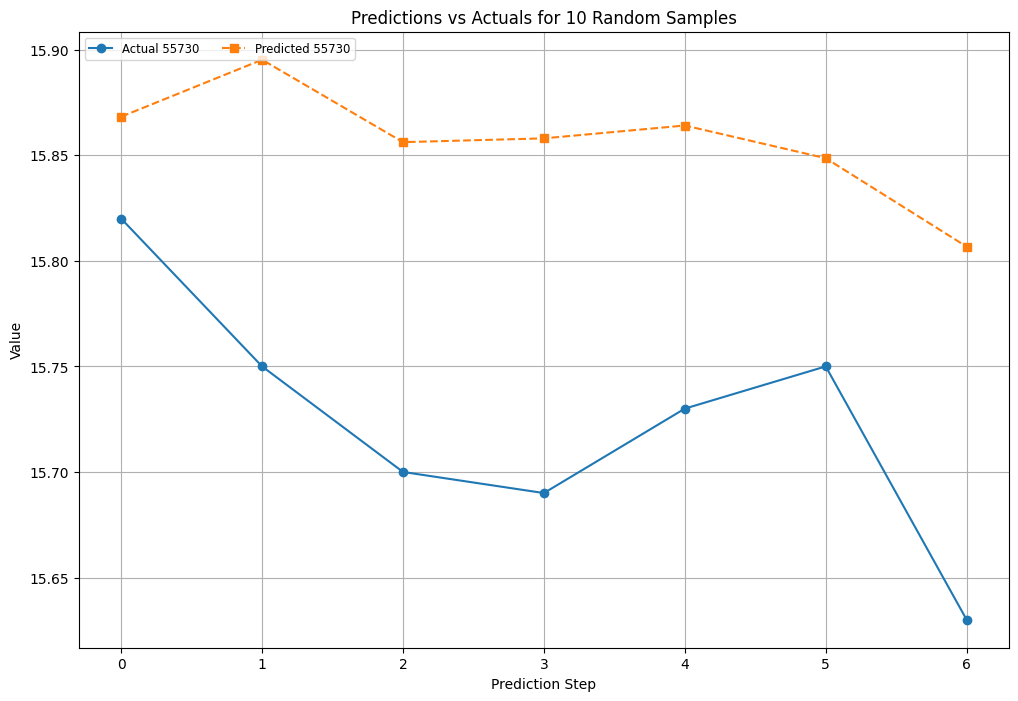

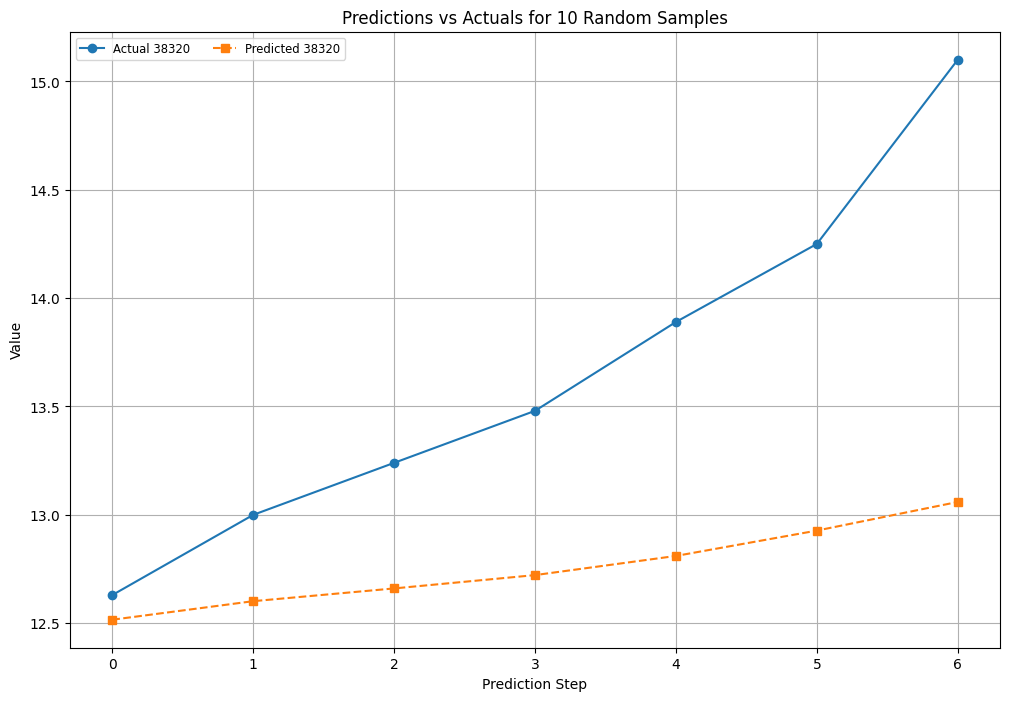

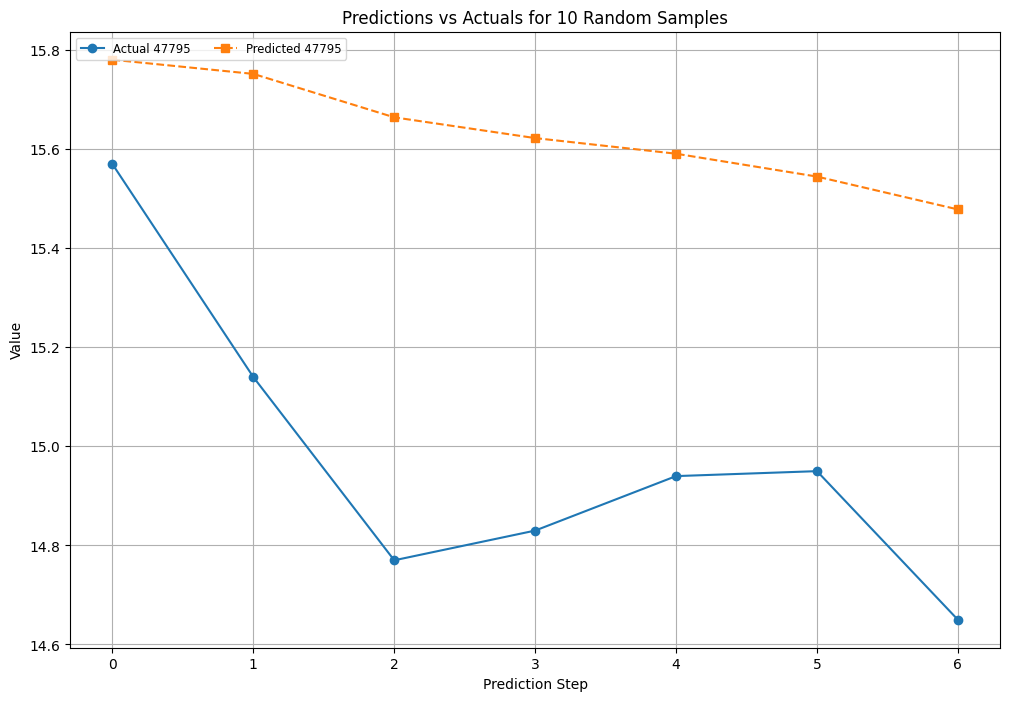

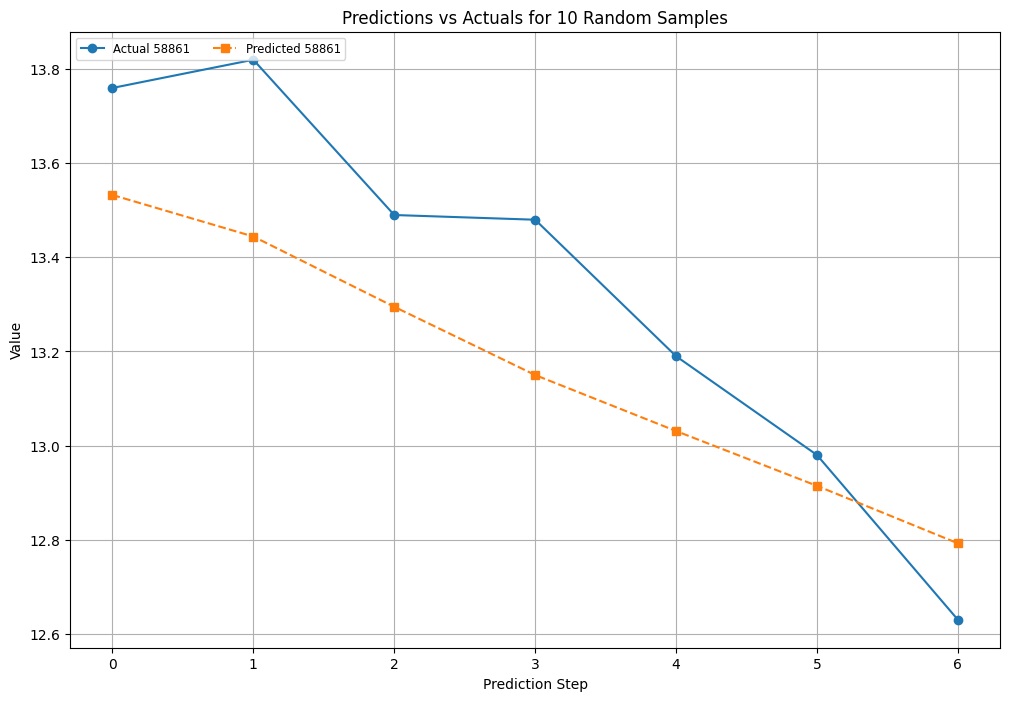

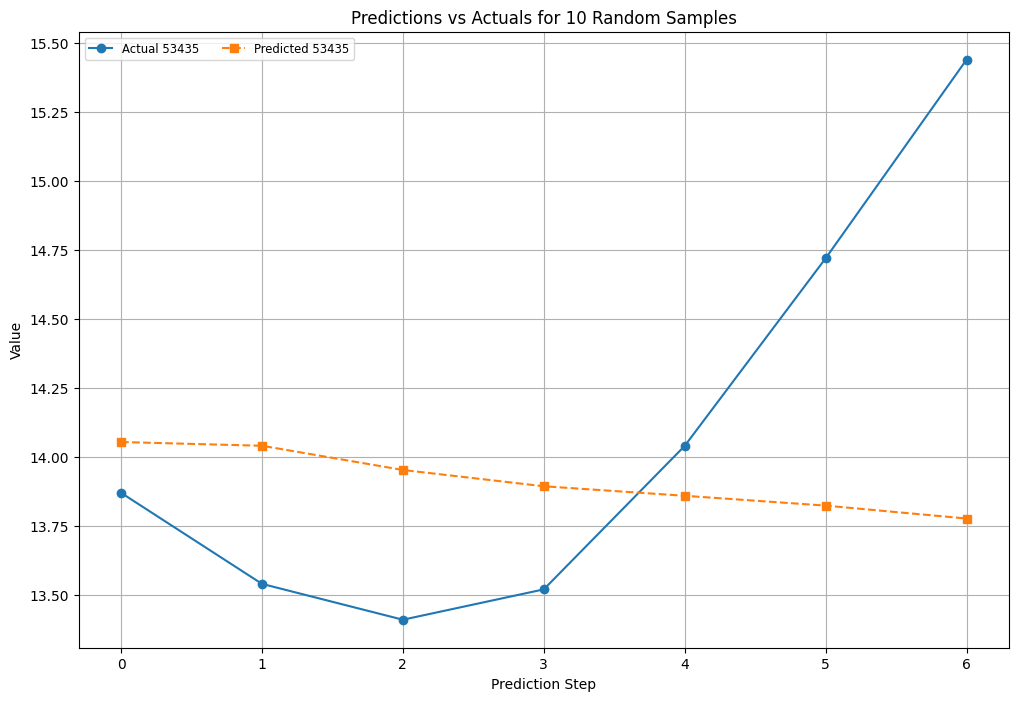

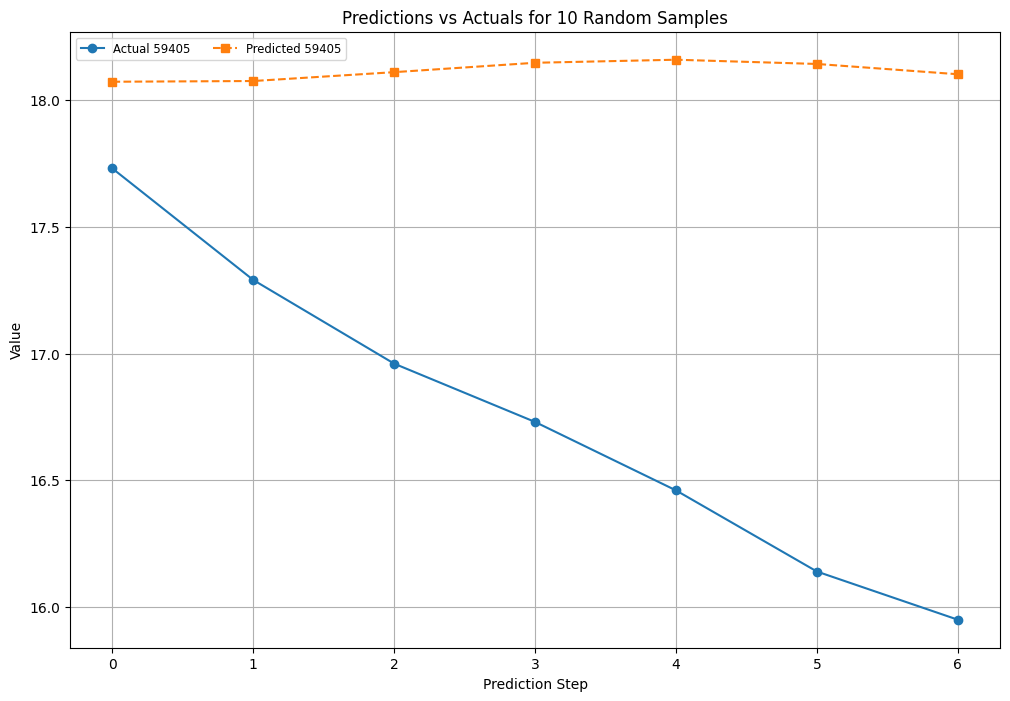

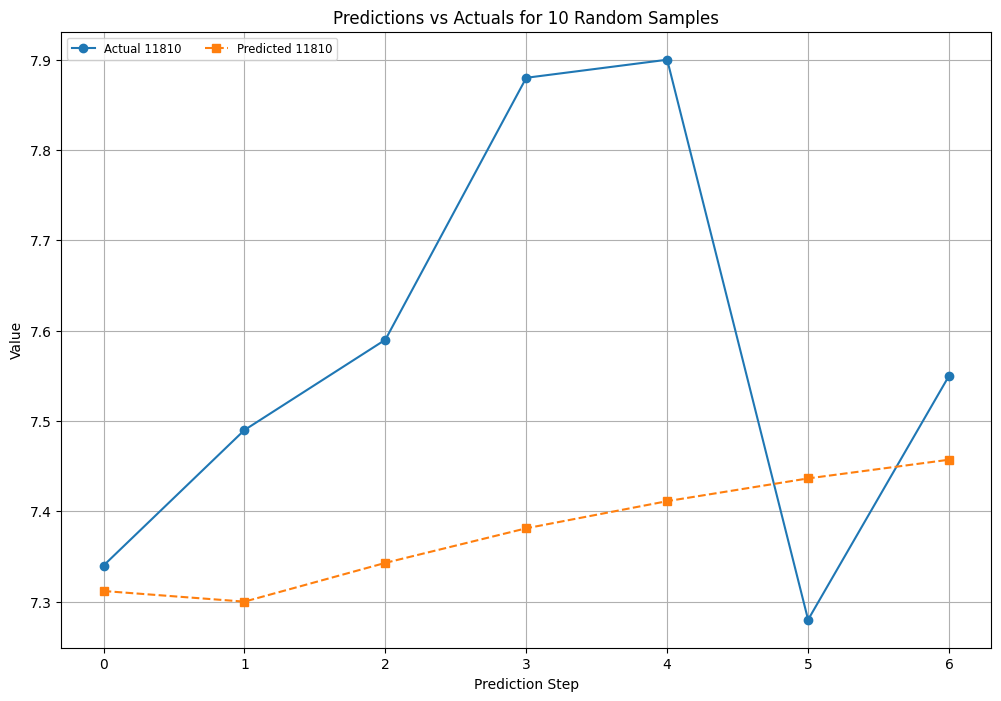

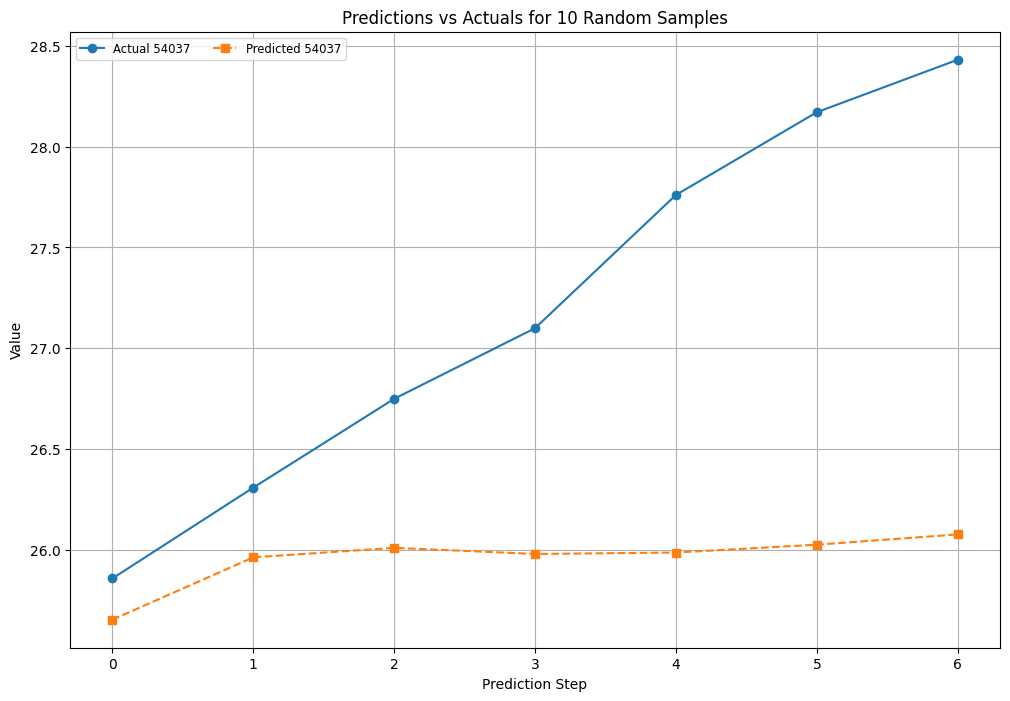

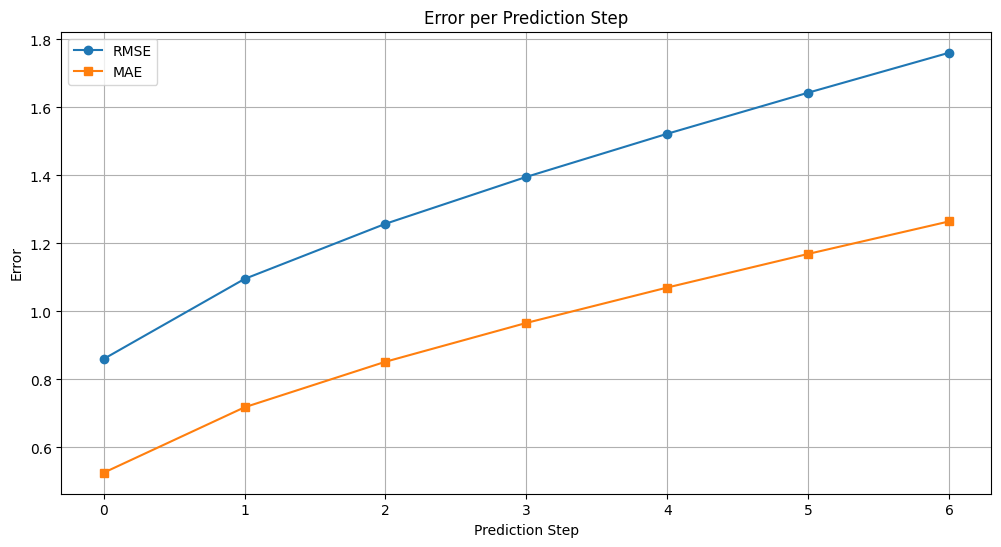

In [ ]:

random_indices = random.sample(range(len(actuals)), 10)


for idx in random_indices:
    plt.figure(figsize=(12, 8))
    plt.plot(actuals[idx], label=f"Actual {idx}", marker='o', linestyle="-")
    plt.plot(test_predictions[idx], label=f"Predicted {idx}", marker='s', linestyle="dashed")
    plt.xlabel("Prediction Step")
    plt.ylabel("Value")
    plt.title("Predictions vs Actuals for 10 Random Samples")
    plt.legend(loc="upper left", fontsize="small", ncol=2)
    plt.grid()
    plt.show()

plt.figure(figsize=(12, 6))
plt.plot(rmse_per_step, label="RMSE", marker='o')
plt.plot(mae_per_step, label="MAE", marker='s')
plt.xlabel("Prediction Step")
plt.ylabel("Error")
plt.title("Error per Prediction Step")
plt.legend()
plt.grid()
plt.show()



# HYPERPARAMETERS FOR TRANSFORMER

Using device: cuda
Epoch [1/50], Training Loss: 24.7159, Validation Loss: 7.3814
Epoch [2/50], Training Loss: 1.9763, Validation Loss: 1.4806
Epoch [3/50], Training Loss: 0.8752, Validation Loss: 1.5918
Epoch [4/50], Training Loss: 0.5982, Validation Loss: 2.0142
Epoch [5/50], Training Loss: 0.4907, Validation Loss: 1.1024
Epoch [6/50], Training Loss: 0.4695, Validation Loss: 0.7801
Epoch [7/50], Training Loss: 0.3742, Validation Loss: 1.0487
Epoch [8/50], Training Loss: 0.3202, Validation Loss: 0.9057
Epoch [9/50], Training Loss: 0.3044, Validation Loss: 1.1607
Epoch [10/50], Training Loss: 0.2646, Validation Loss: 1.9030
Epoch [11/50], Training Loss: 0.2630, Validation Loss: 0.9164
Epoch [12/50], Training Loss: 0.2511, Validation Loss: 1.3696
Epoch [13/50], Training Loss: 0.2264, Validation Loss: 1.3789
Epoch [14/50], Training Loss: 0.2368, Validation Loss: 1.2898
Epoch [15/50], Training Loss: 0.2140, Validation Loss: 1.2710
Epoch [16/50], Training Loss: 0.1890, Validation Loss: 1.04

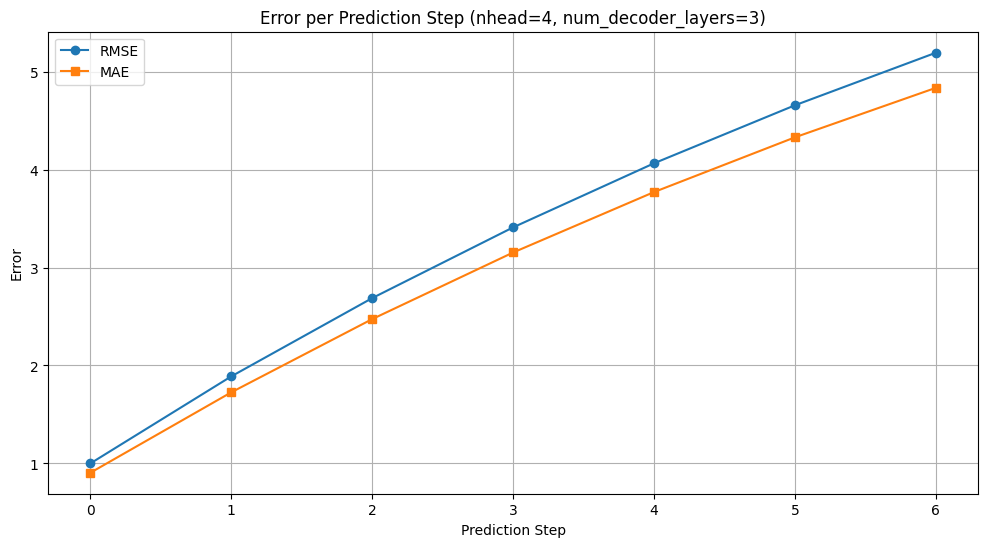

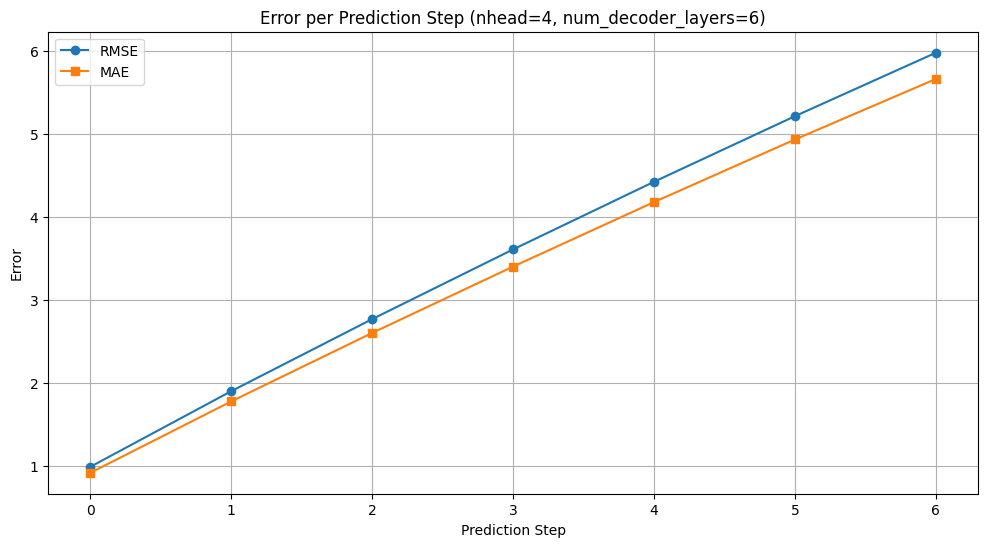

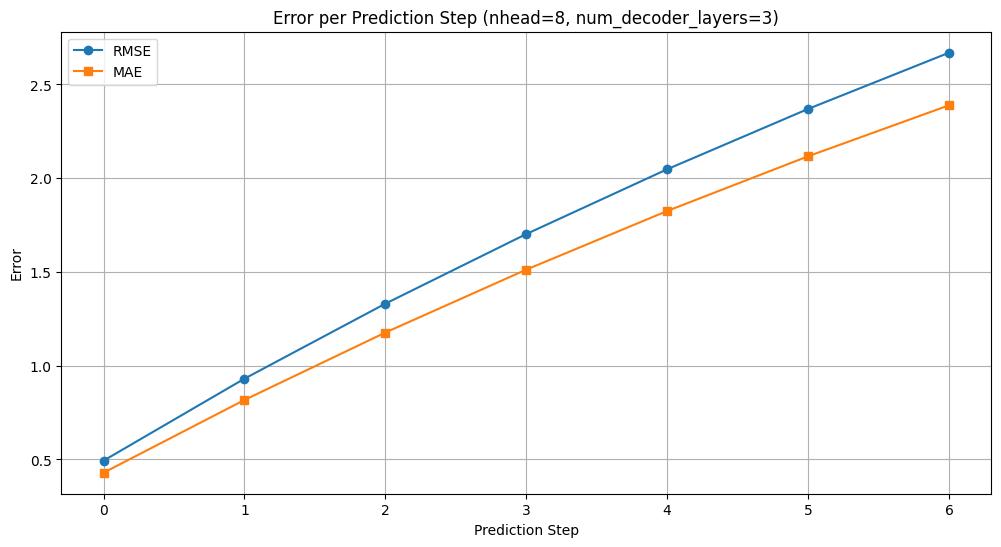

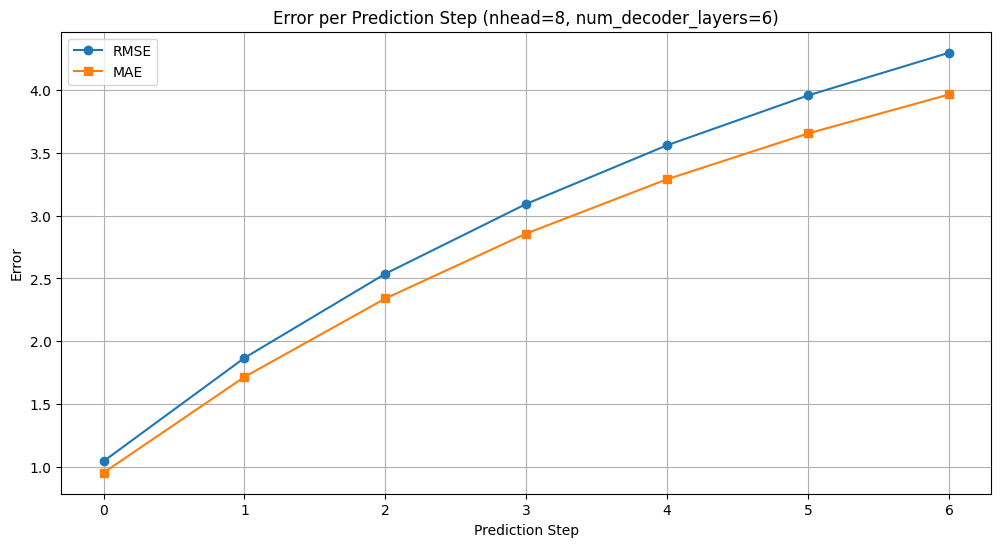

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random
import math


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

CONTEXT_SIZE = 30
PREDICTION_SIZE = 7
NUM_EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.001
D_MODEL = 64
NUM_ENCODER_LAYERS = 3
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PATIENCE = 7


nhead_values = [4, 8]
num_decoder_layers_values = [3, 6]


X_train_tensor = torch.FloatTensor(X_train1).unsqueeze(-1).to(device)
y_train_tensor = torch.FloatTensor(y_train1).unsqueeze(-1).to(device)
X_val_tensor = torch.FloatTensor(X_val1).unsqueeze(-1).to(device)
y_val_tensor = torch.FloatTensor(y_val1).unsqueeze(-1).to(device)
X_test_tensor = torch.FloatTensor(X_test1).unsqueeze(-1).to(device)
y_test_tensor = torch.FloatTensor(y_test1).unsqueeze(-1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, d_model, 2).float().to(device) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers,
                 num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_linear = nn.Linear(input_dim, d_model)
        self.output_linear = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.final_linear = nn.Linear(d_model, output_dim)
        self.d_model = d_model

    def forward(self, src, tgt):
        src = self.input_linear(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        tgt = self.output_linear(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        src_mask = None
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(device)
        memory_mask = None
        output = self.transformer(src, tgt, src_mask, tgt_mask, memory_mask)
        return self.final_linear(output)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


results = []

for nhead in nhead_values:
    for num_decoder_layers in num_decoder_layers_values:

        model = TimeSeriesTransformer(
            input_dim=1,
            output_dim=1,
            d_model=D_MODEL,
            nhead=nhead,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=DROPOUT
        ).to(device)


        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
        criterion = nn.MSELoss()


        start_time = time.time()
        for epoch in range(NUM_EPOCHS):
            model.train()
            epoch_loss = 0
            for src, tgt in train_loader:
                src, tgt = src.to(device), tgt.to(device)
                optimizer.zero_grad()
                outputs = model(src, tgt)
                loss = criterion(outputs, tgt)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / len(train_loader)


            model.eval()
            val_loss = 0
            with torch.no_grad():
                for src, tgt in val_loader:
                    src, tgt = src.to(device), tgt.to(device)
                    outputs = model(src, tgt)
                    loss = criterion(outputs, tgt)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)


            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
                  f"Training Loss: {avg_epoch_loss:.4f}, "
                  f"Validation Loss: {avg_val_loss:.4f}")


        end_time = time.time()
        training_time = end_time - start_time


        model.eval()
        predictions = []
        actuals = []

        with torch.no_grad():
            for src, tgt in test_loader:
                src, tgt = src.to(device), tgt.to(device)
                decoder_input = torch.zeros(src.size(0), PREDICTION_SIZE, 1, device=device)
                decoder_input[:, 0, :] = src[:, -1, :]
                for i in range(PREDICTION_SIZE):
                    outputs = model(src, decoder_input)
                    if i < PREDICTION_SIZE - 1:
                        decoder_input[:, i+1, :] = outputs[:, i, :]

                predictions.append(outputs.cpu().numpy())
                actuals.append(tgt.cpu().numpy())

        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)


        rmse_per_step = np.sqrt(np.mean((actuals - predictions) ** 2, axis=0))
        mae_per_step = np.mean(np.abs(actuals - predictions), axis=0)
        overall_rmse = float(np.mean(rmse_per_step))
        overall_mae = float(np.mean(mae_per_step))


        results.append({
            'nhead': nhead,
            'num_decoder_layers': num_decoder_layers,
            'training_time': training_time,
            'rmse': overall_rmse,
            'mae': overall_mae,
            'rmse_per_step': rmse_per_step,
            'mae_per_step': mae_per_step
        })


        print(f"Experiment completed with nhead={nhead}, num_decoder_layers={num_decoder_layers}, "
              f"RMSE: {overall_rmse:.4f}, MAE: {overall_mae:.4f}, Training Time: {training_time:.2f} seconds")


for result in results:
    plt.figure(figsize=(12, 6))
    plt.plot(result['rmse_per_step'], label="RMSE", marker='o')
    plt.plot(result['mae_per_step'], label="MAE", marker='s')
    plt.xlabel("Prediction Step")
    plt.ylabel("Error")
    plt.title(f"Error per Prediction Step (nhead={result['nhead']}, num_decoder_layers={result['num_decoder_layers']})")
    plt.legend()
    plt.grid()
    plt.show()


# EXPLANATIONS

In [ ]:
from torch.nn import TransformerDecoderLayer

class CustomDecoderLayer(TransformerDecoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2, attn_weights = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask, need_weights=True)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        return tgt, attn_weights


Using device: cuda


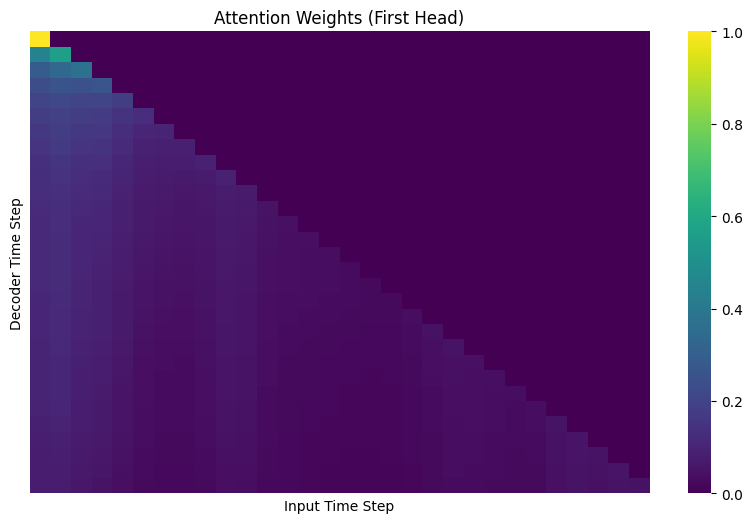

Epoch [1/50], Training Loss: 25.6861, Validation Loss: 5.6168
Saved new best model with Validation Loss: 5.6168


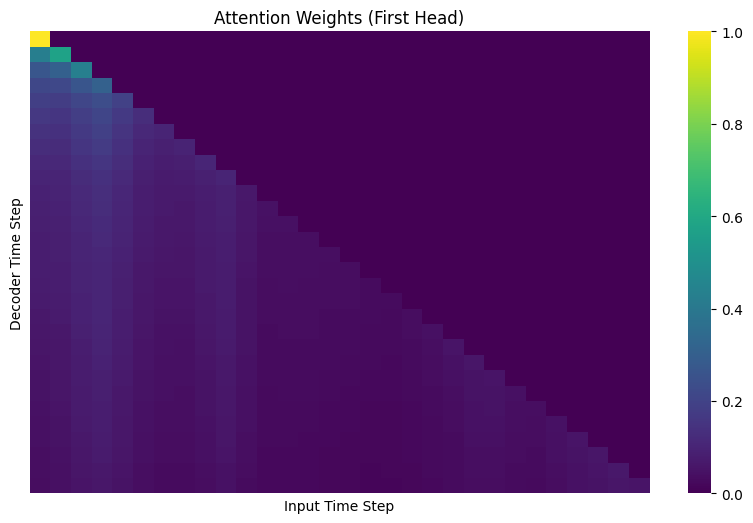

Epoch [2/50], Training Loss: 1.7694, Validation Loss: 1.3633
Saved new best model with Validation Loss: 1.3633


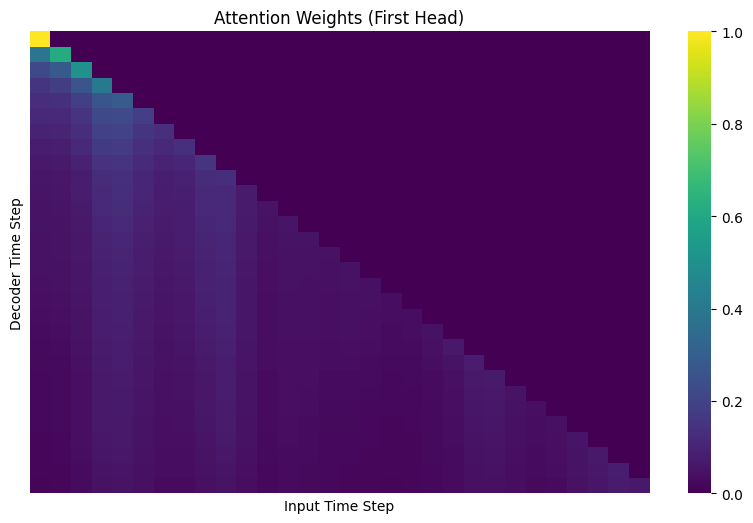

Epoch [3/50], Training Loss: 0.6259, Validation Loss: 0.6195
Saved new best model with Validation Loss: 0.6195


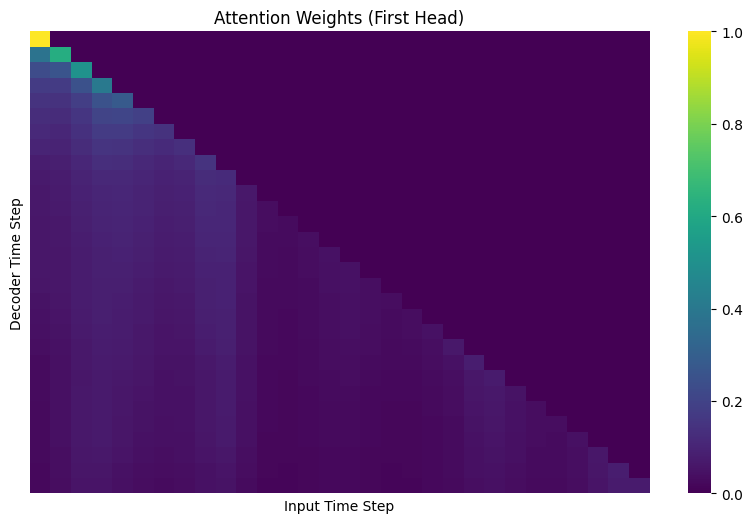

Epoch [4/50], Training Loss: 0.4001, Validation Loss: 0.4888
Saved new best model with Validation Loss: 0.4888


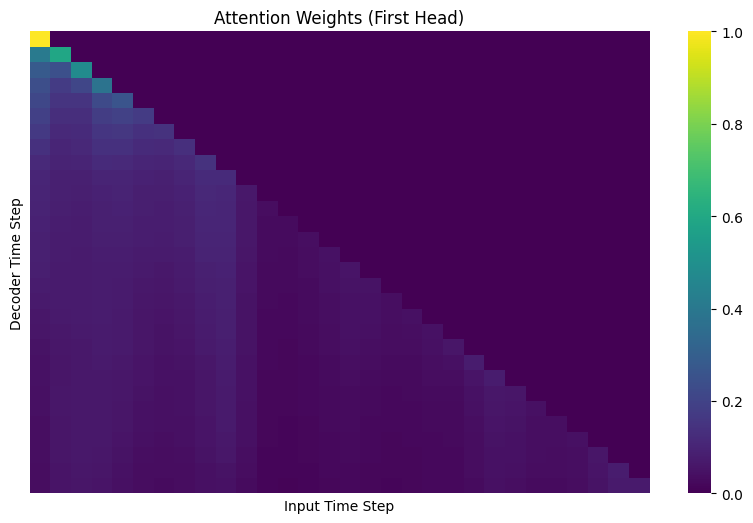

Epoch [5/50], Training Loss: 0.3610, Validation Loss: 0.3720
Saved new best model with Validation Loss: 0.3720


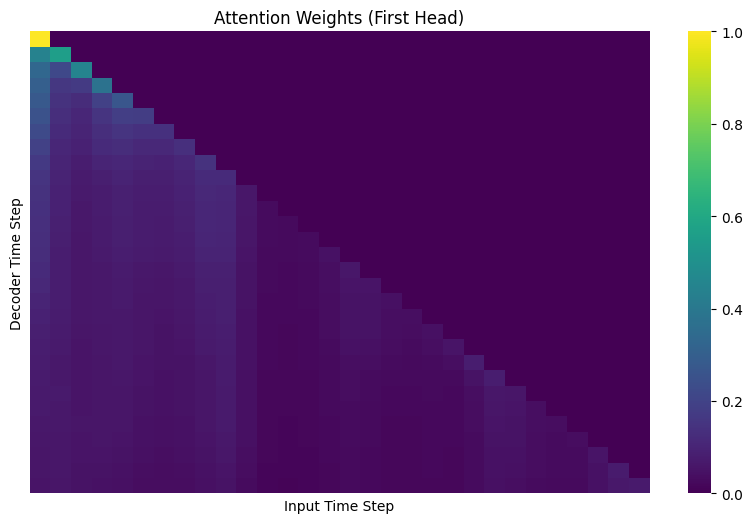

Epoch [6/50], Training Loss: 0.2758, Validation Loss: 0.3463
Saved new best model with Validation Loss: 0.3463


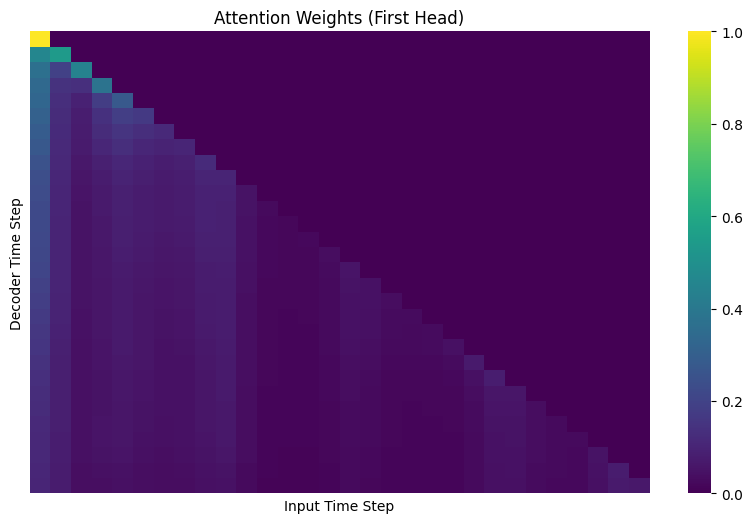

Epoch [7/50], Training Loss: 0.2556, Validation Loss: 0.3701


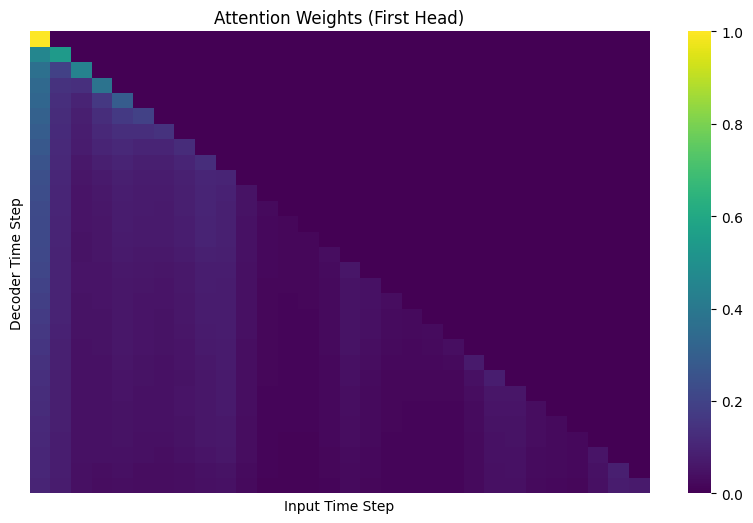

Epoch [8/50], Training Loss: 0.1758, Validation Loss: 0.1563
Saved new best model with Validation Loss: 0.1563


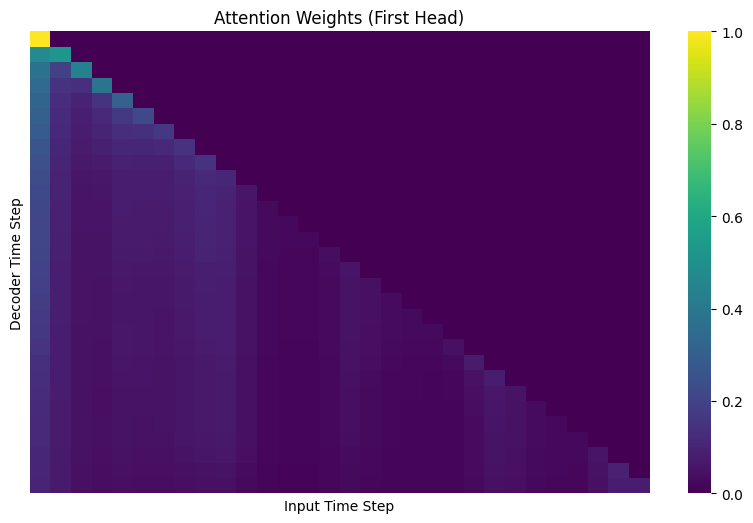

Epoch [9/50], Training Loss: 0.1913, Validation Loss: 0.2585


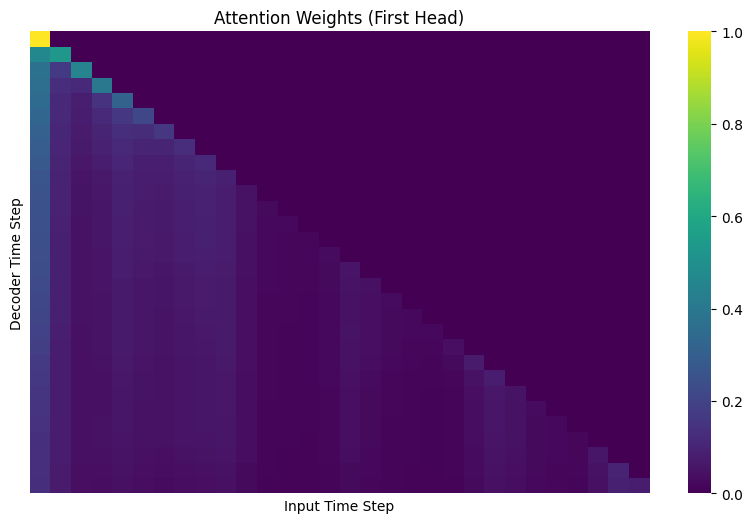

Epoch [10/50], Training Loss: 0.1461, Validation Loss: 0.4227


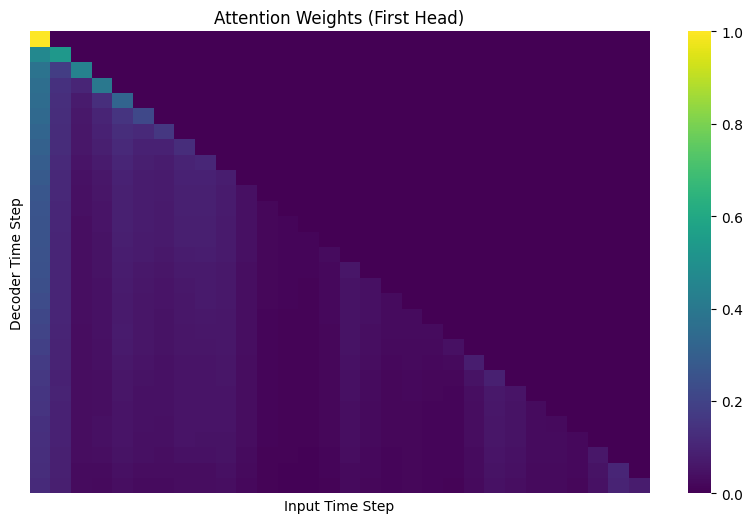

Epoch [11/50], Training Loss: 0.1828, Validation Loss: 0.1398
Saved new best model with Validation Loss: 0.1398


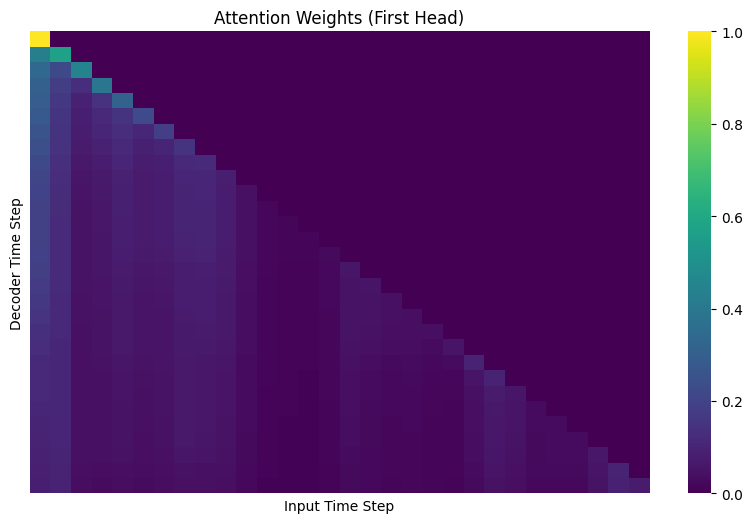

Epoch [12/50], Training Loss: 0.1476, Validation Loss: 0.2658


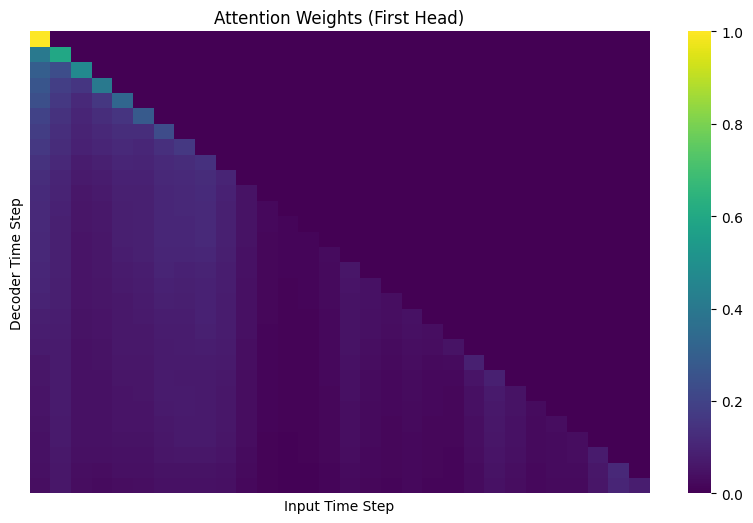

Epoch [13/50], Training Loss: 0.1109, Validation Loss: 0.2134


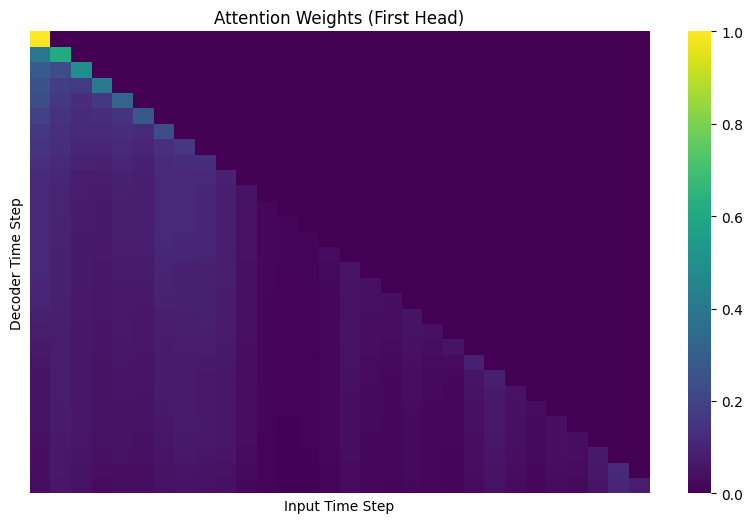

Epoch [14/50], Training Loss: 0.1228, Validation Loss: 0.0923
Saved new best model with Validation Loss: 0.0923


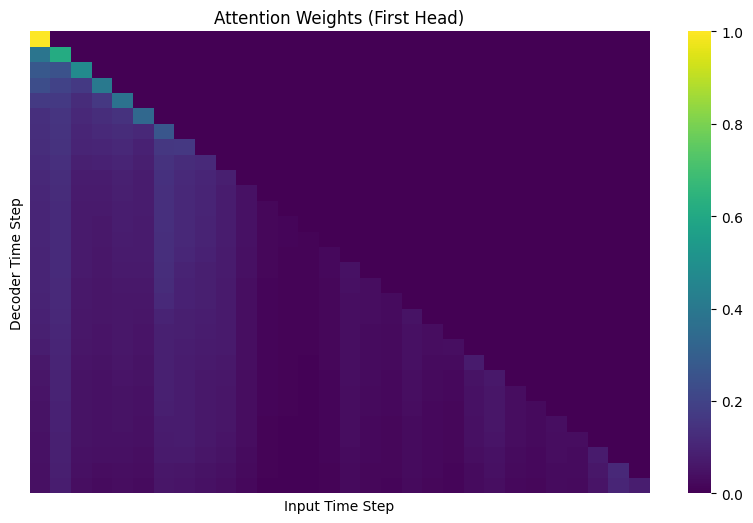

Epoch [15/50], Training Loss: 0.1110, Validation Loss: 0.4274


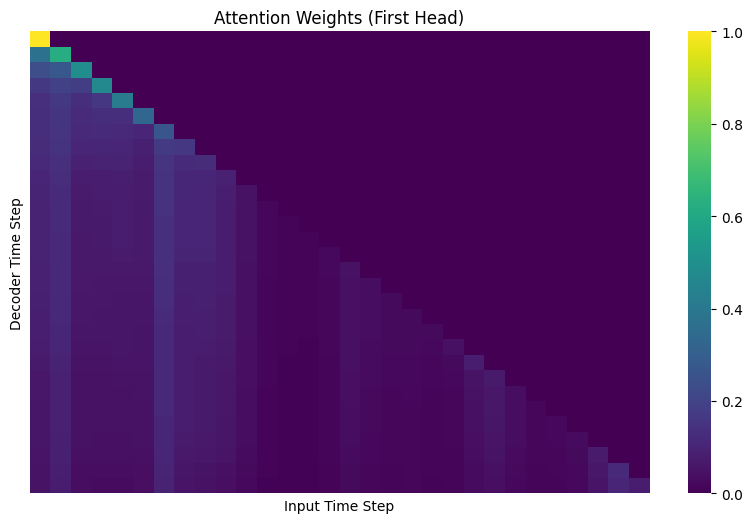

Epoch [16/50], Training Loss: 0.0901, Validation Loss: 0.1481


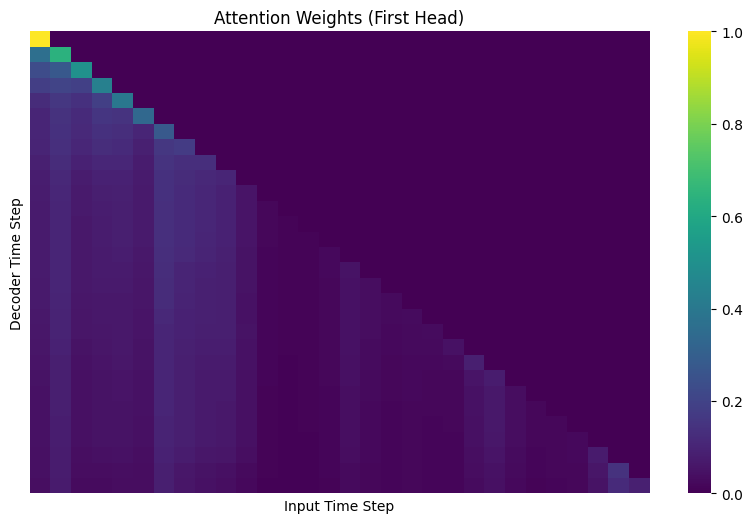

Epoch [17/50], Training Loss: 0.0948, Validation Loss: 0.1398


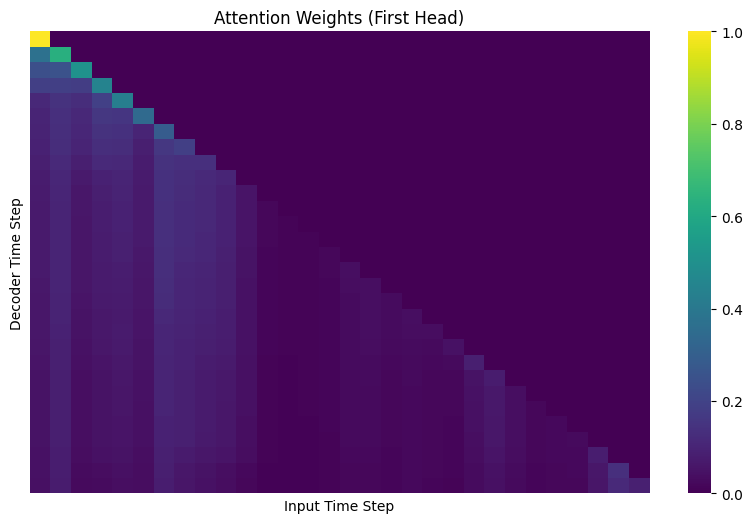

Epoch [18/50], Training Loss: 0.0735, Validation Loss: 0.0886
Saved new best model with Validation Loss: 0.0886


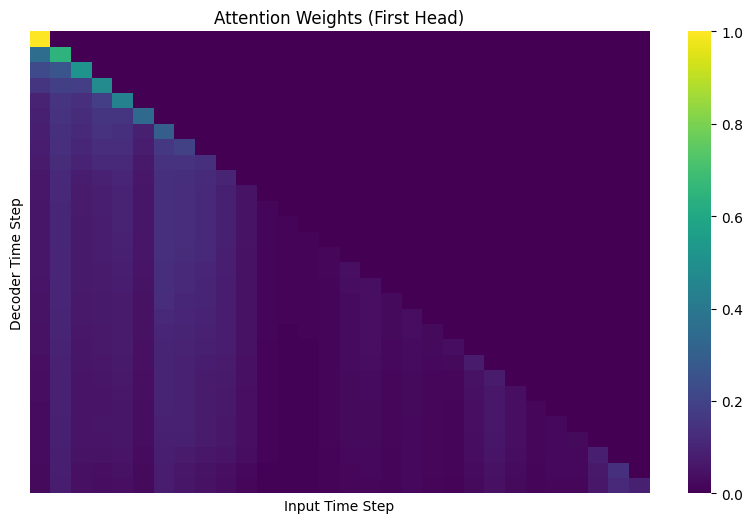

Epoch [19/50], Training Loss: 0.1258, Validation Loss: 0.0483
Saved new best model with Validation Loss: 0.0483


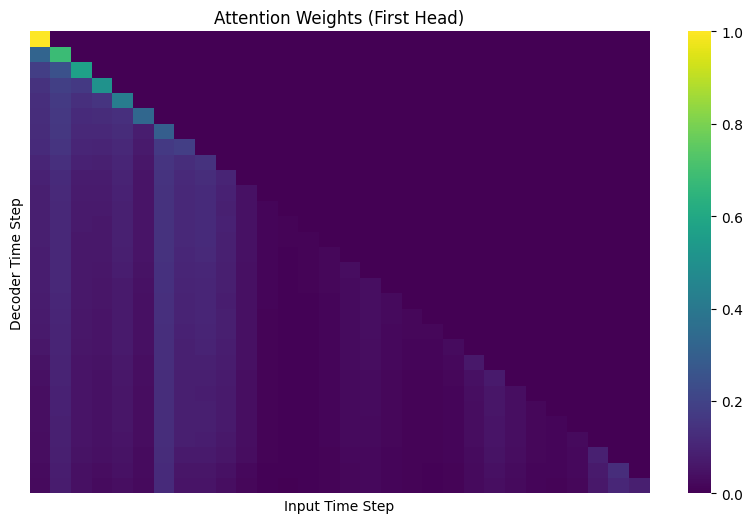

Epoch [20/50], Training Loss: 0.0704, Validation Loss: 0.0403
Saved new best model with Validation Loss: 0.0403


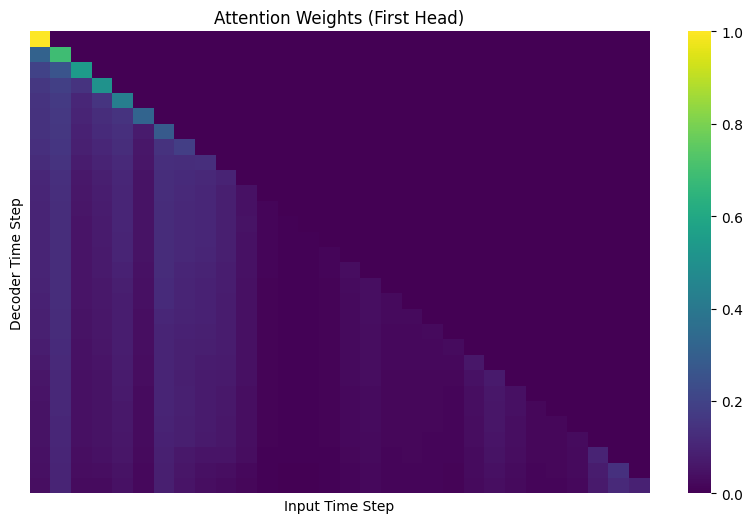

Epoch [21/50], Training Loss: 0.0913, Validation Loss: 0.1098


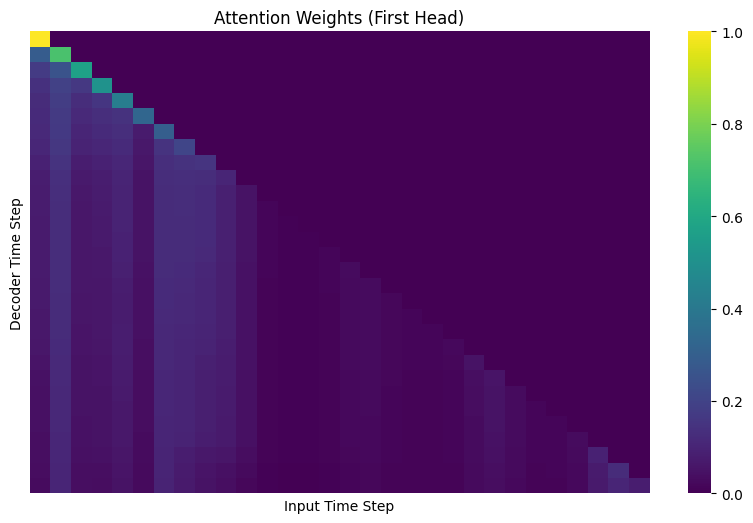

Epoch [22/50], Training Loss: 0.0644, Validation Loss: 0.1480


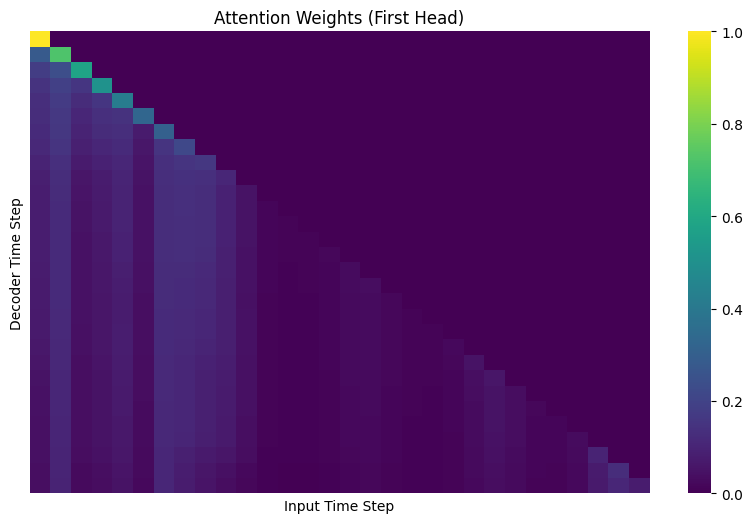

Epoch [23/50], Training Loss: 0.0544, Validation Loss: 0.0556


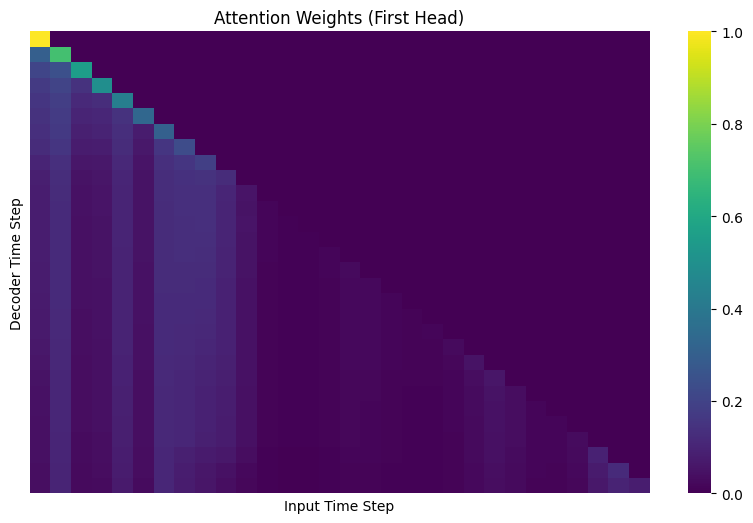

Epoch [24/50], Training Loss: 0.0708, Validation Loss: 0.0477


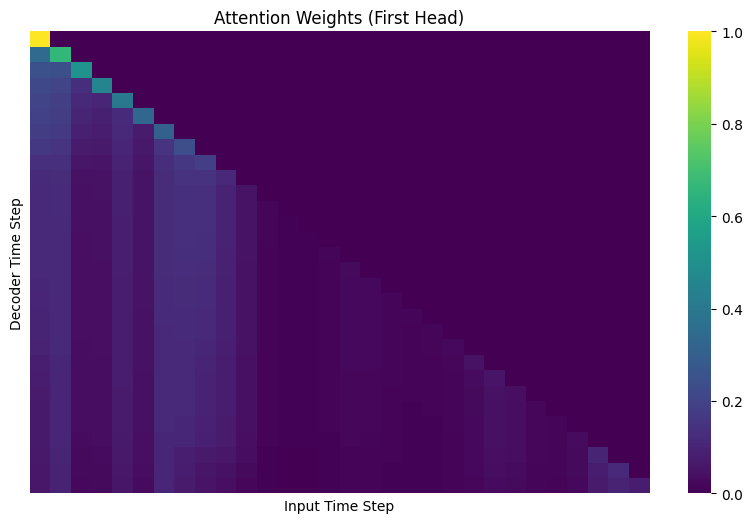

Epoch [25/50], Training Loss: 0.0526, Validation Loss: 0.3072


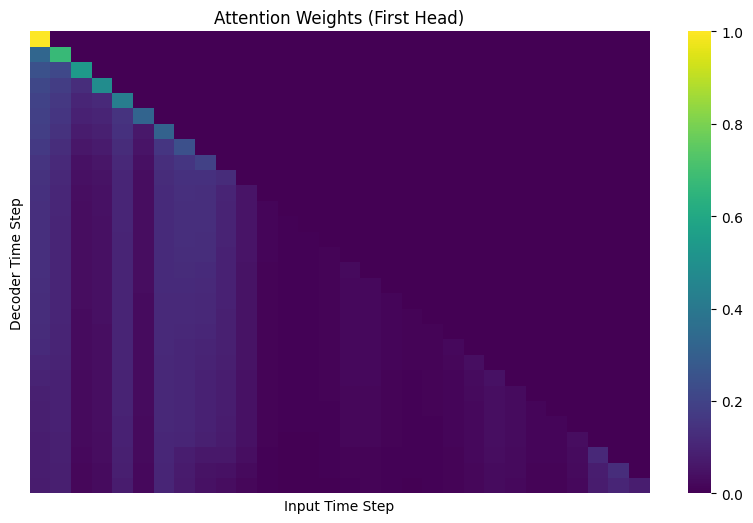

Epoch [26/50], Training Loss: 0.0855, Validation Loss: 0.0755


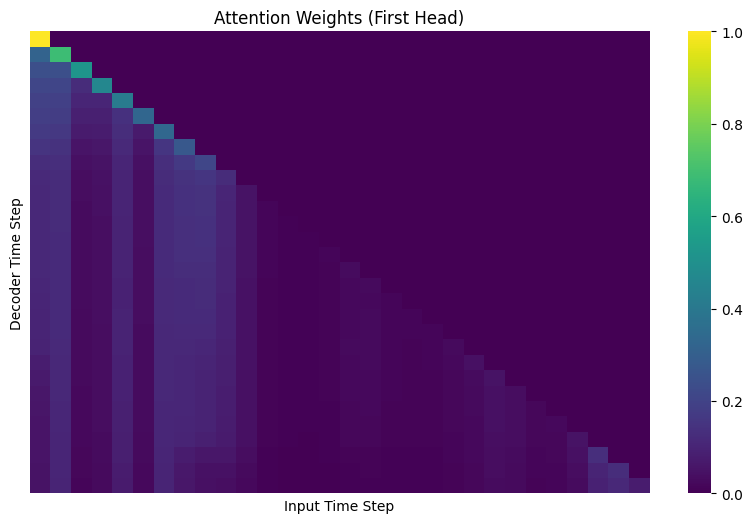

Epoch [27/50], Training Loss: 0.0410, Validation Loss: 0.1224


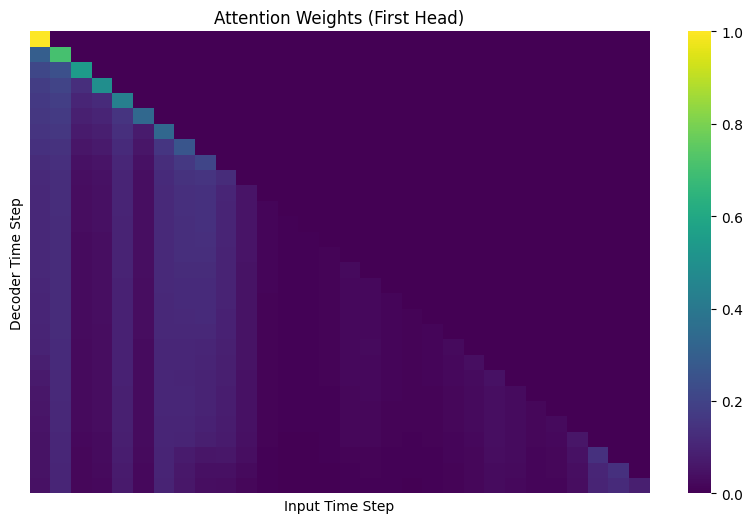

Epoch [28/50], Training Loss: 0.0492, Validation Loss: 0.0350
Saved new best model with Validation Loss: 0.0350


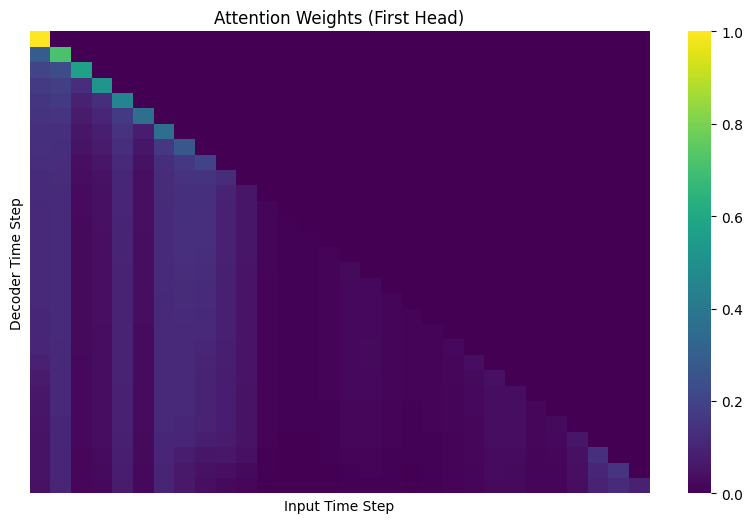

Epoch [29/50], Training Loss: 0.0396, Validation Loss: 0.0240
Saved new best model with Validation Loss: 0.0240


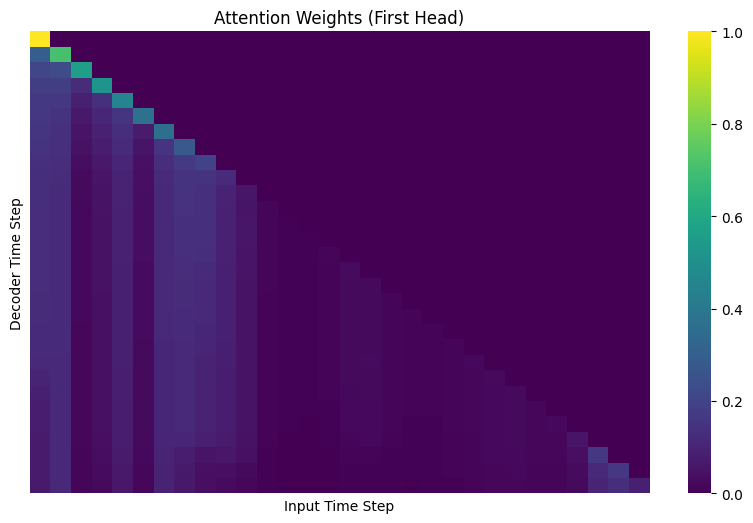

Epoch [30/50], Training Loss: 0.0487, Validation Loss: 0.0888


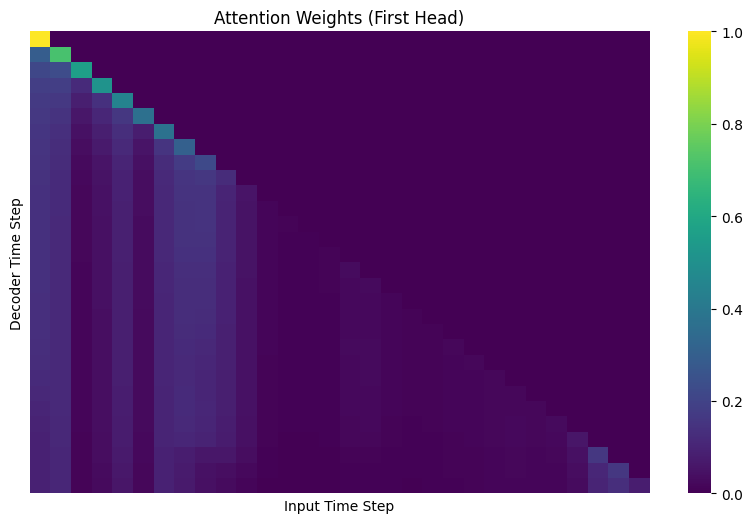

Epoch [31/50], Training Loss: 0.0602, Validation Loss: 0.0210
Saved new best model with Validation Loss: 0.0210


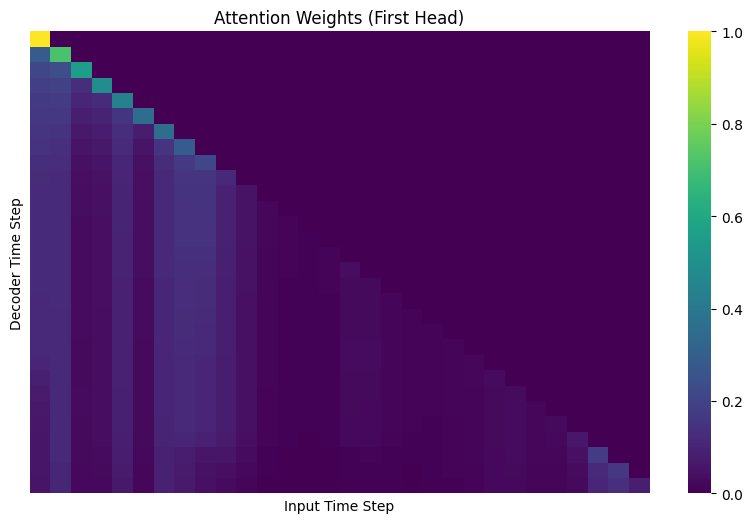

Epoch [32/50], Training Loss: 0.0483, Validation Loss: 0.0317


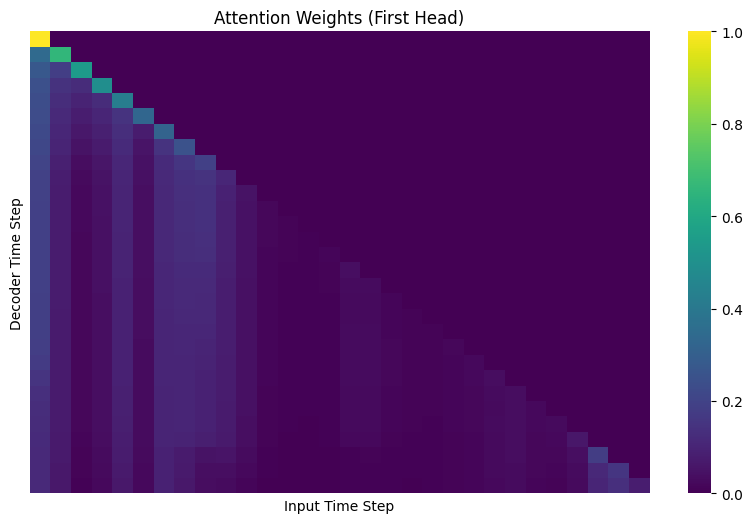

Epoch [33/50], Training Loss: 0.0406, Validation Loss: 0.0171
Saved new best model with Validation Loss: 0.0171


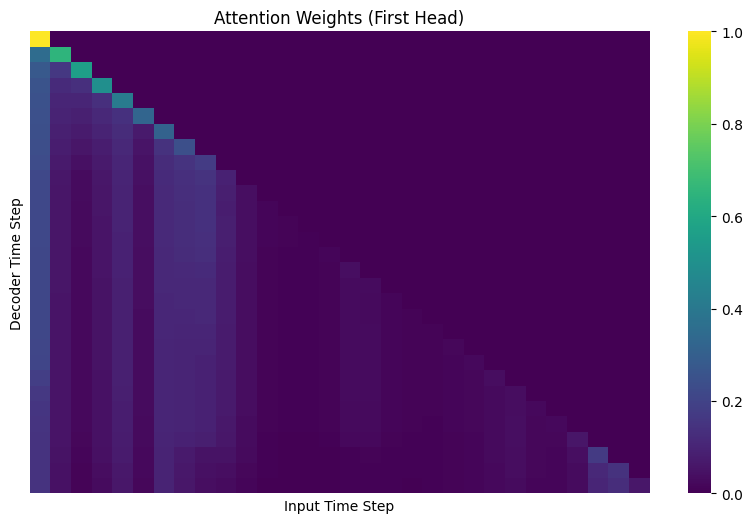

Epoch [34/50], Training Loss: 0.0385, Validation Loss: 0.0454


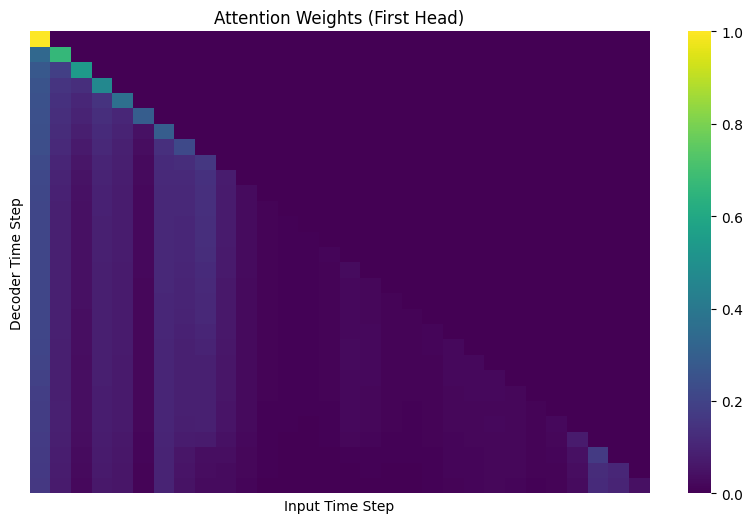

Epoch [35/50], Training Loss: 0.1110, Validation Loss: 0.0168
Saved new best model with Validation Loss: 0.0168


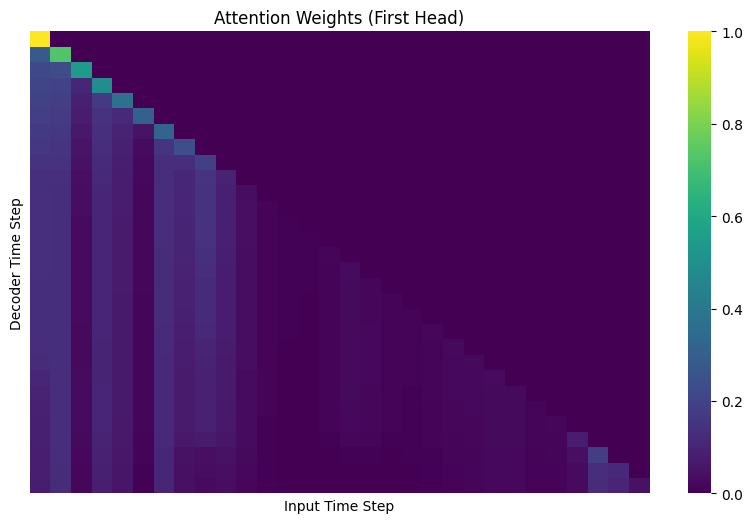

Epoch [36/50], Training Loss: 0.0512, Validation Loss: 0.0165
Saved new best model with Validation Loss: 0.0165


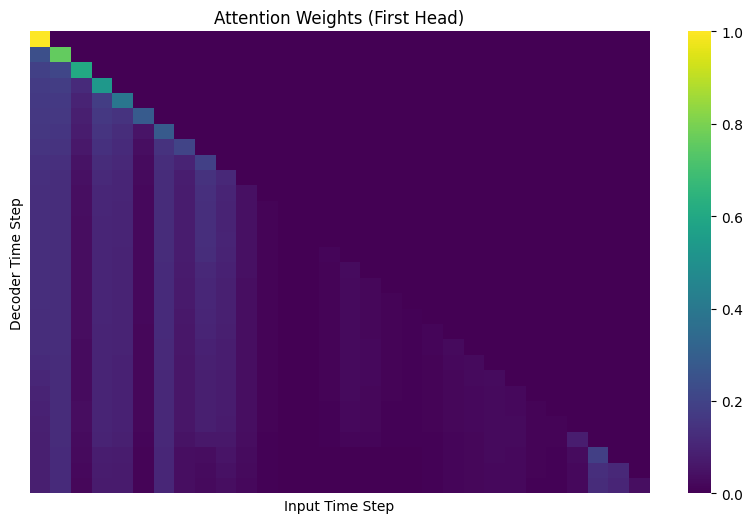

Epoch [37/50], Training Loss: 0.0278, Validation Loss: 0.0149
Saved new best model with Validation Loss: 0.0149


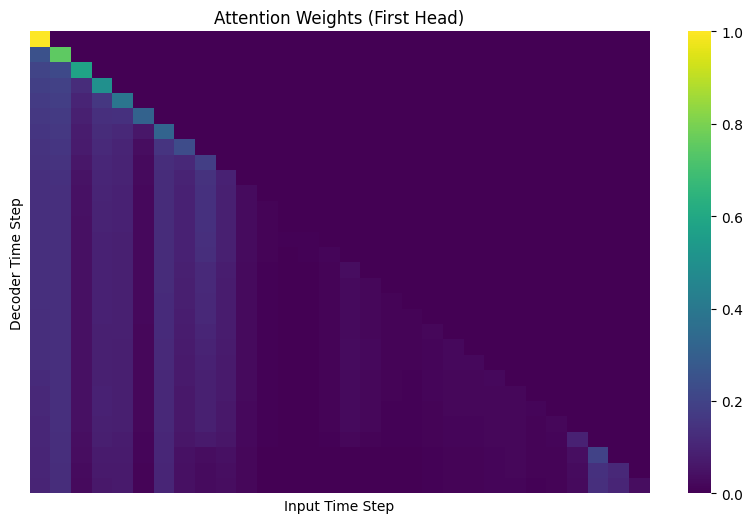

Epoch [38/50], Training Loss: 0.0287, Validation Loss: 0.0574


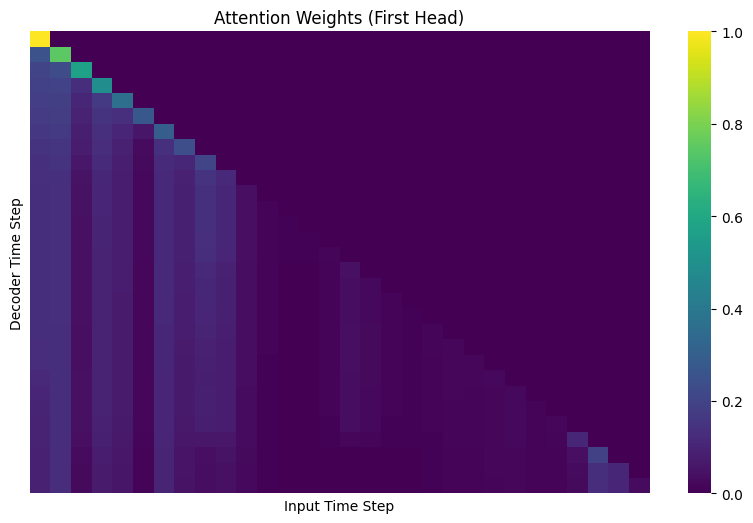

Epoch [39/50], Training Loss: 0.0347, Validation Loss: 0.0319


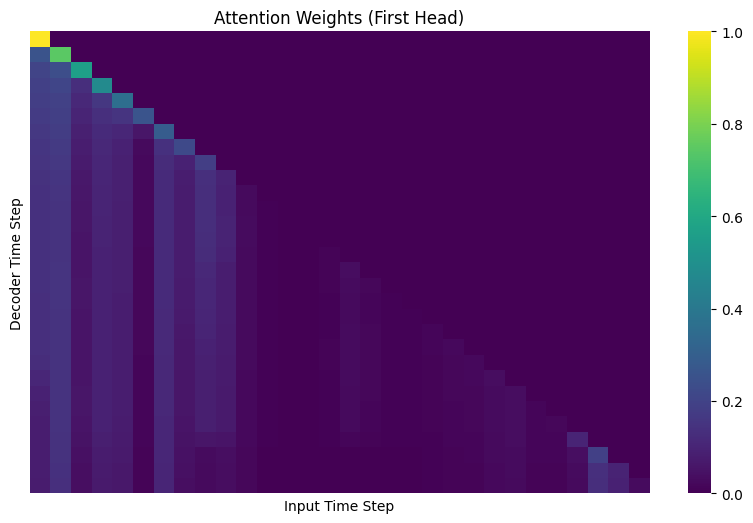

Epoch [40/50], Training Loss: 0.0447, Validation Loss: 0.0183


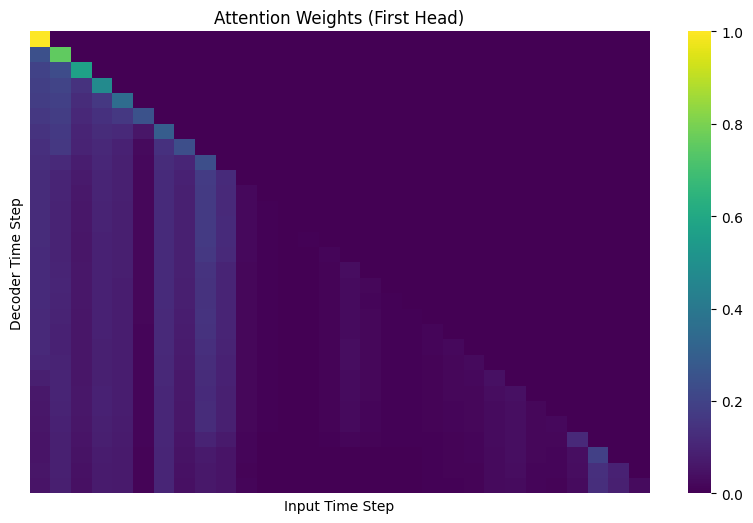

Epoch [41/50], Training Loss: 0.0243, Validation Loss: 0.0132
Saved new best model with Validation Loss: 0.0132


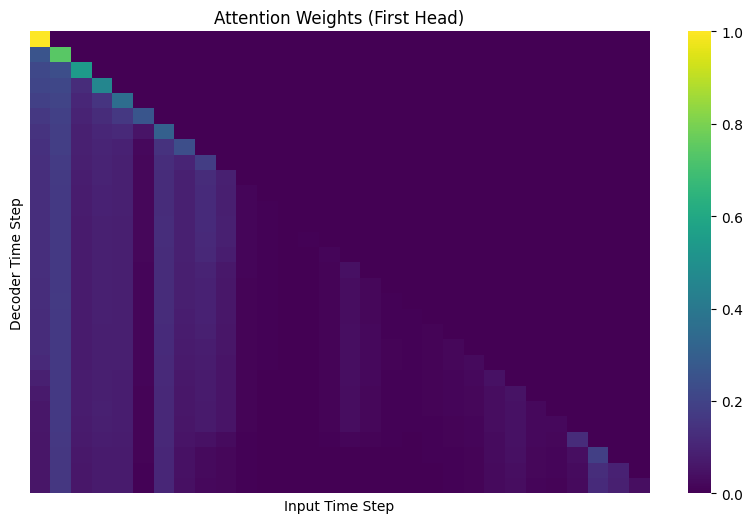

Epoch [42/50], Training Loss: 0.0292, Validation Loss: 0.0111
Saved new best model with Validation Loss: 0.0111


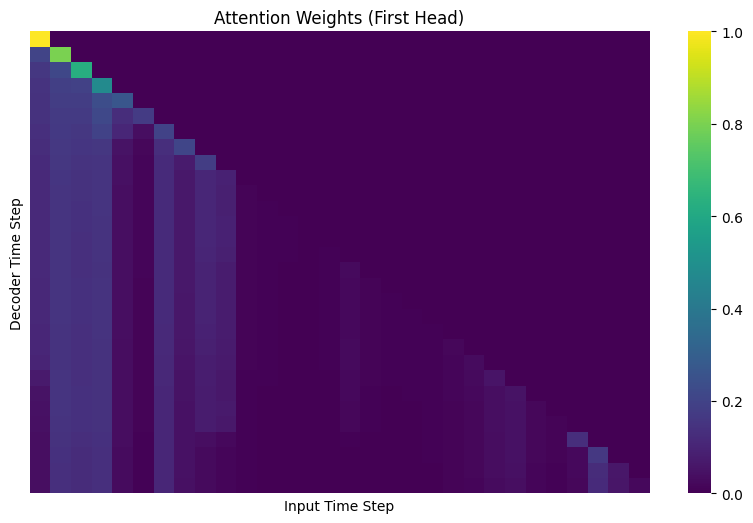

Epoch [43/50], Training Loss: 0.0314, Validation Loss: 0.0333


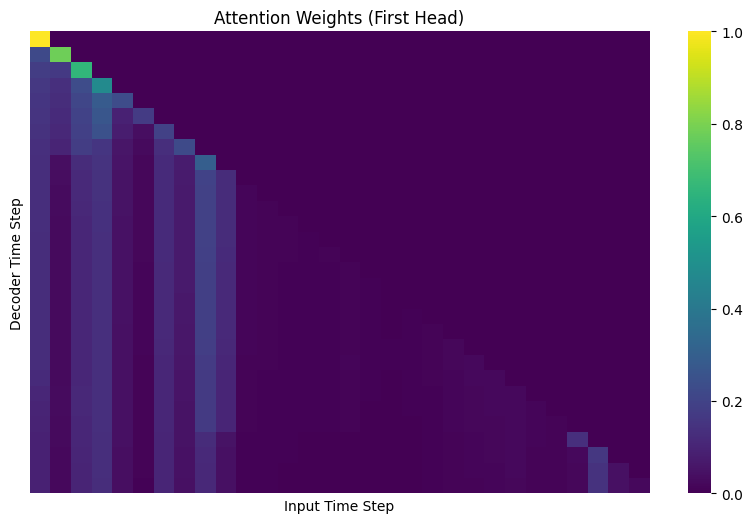

Epoch [44/50], Training Loss: 0.0463, Validation Loss: 0.0244


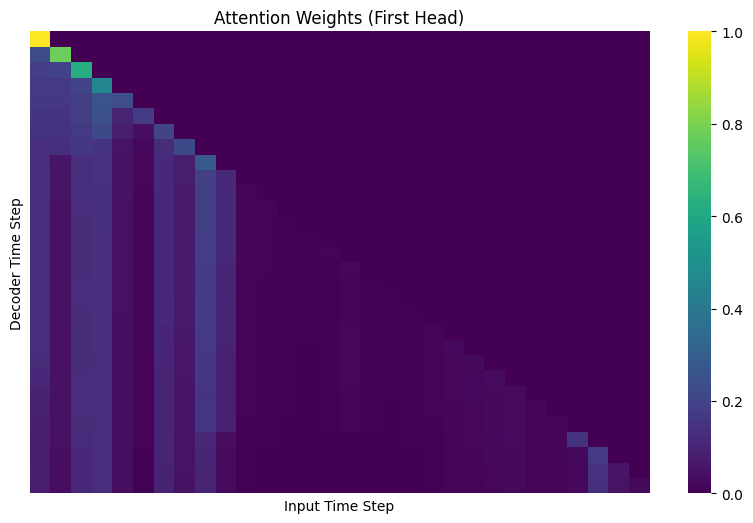

Epoch [45/50], Training Loss: 0.0249, Validation Loss: 0.0150


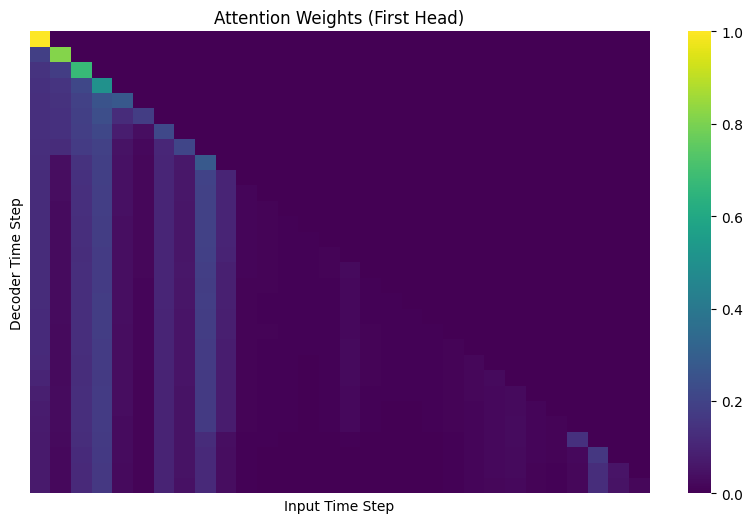

Epoch [46/50], Training Loss: 0.0207, Validation Loss: 0.0578


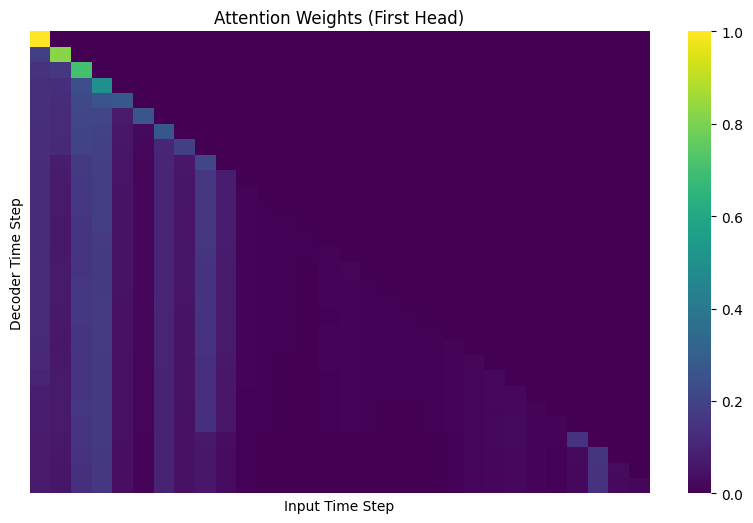

Epoch [47/50], Training Loss: 0.0388, Validation Loss: 0.0113


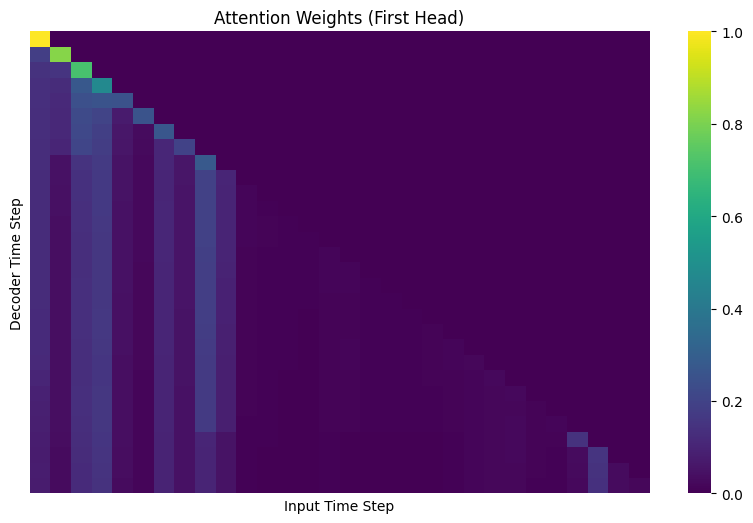

Epoch [48/50], Training Loss: 0.0207, Validation Loss: 0.0256


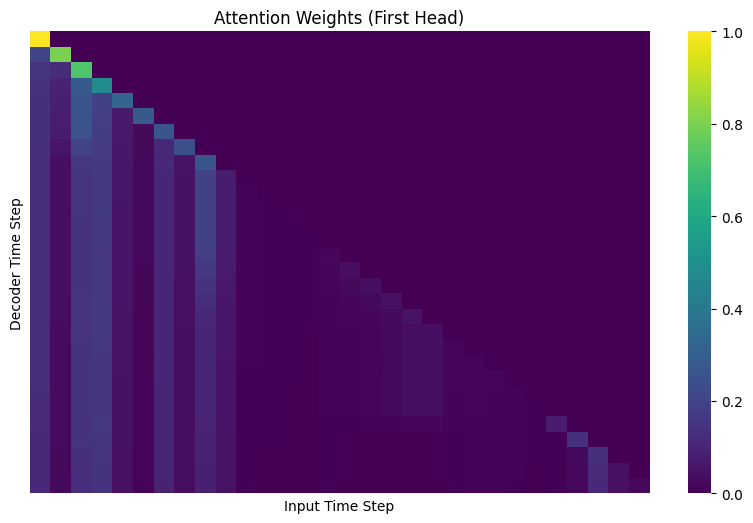

Epoch [49/50], Training Loss: 0.3120, Validation Loss: 0.0235


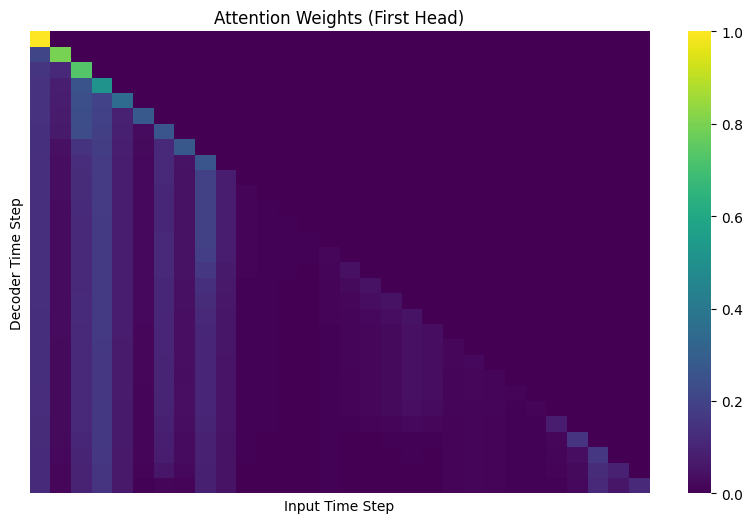

Epoch [50/50], Training Loss: 0.0234, Validation Loss: 0.0112
Attention Weights Shape: (1, 30, 30)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

D_MODEL = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
NUM_EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.001
PREDICTION_SIZE = 7
CONTEXT_SIZE = 30


X_train_tensor = torch.FloatTensor(X_train1).unsqueeze(-1).to(device)
y_train_tensor = torch.FloatTensor(y_train1).unsqueeze(-1).to(device)
X_val_tensor = torch.FloatTensor(X_val1).unsqueeze(-1).to(device)
y_val_tensor = torch.FloatTensor(y_val1).unsqueeze(-1).to(device)
X_test_tensor = torch.FloatTensor(X_test1).unsqueeze(-1).to(device)
y_test_tensor = torch.FloatTensor(y_test1).unsqueeze(-1).to(device)



train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers,
                 num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_linear = nn.Linear(input_dim, d_model)
        self.output_linear = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.decoder_layers = nn.ModuleList([
            CustomDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
            for _ in range(num_decoder_layers)
        ])

        self.final_linear = nn.Linear(d_model, output_dim)
        self.d_model = d_model
        self.attention_weights = []

    def forward(self, src, tgt):
        self.attention_weights = []

        src = self.input_linear(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        tgt = self.output_linear(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)

        memory = self.encoder(src)

        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(device)

        for layer in self.decoder_layers:
            tgt, attn_weights = layer(tgt, memory, tgt_mask=tgt_mask)
            self.attention_weights.append(attn_weights)

        return self.final_linear(tgt)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask



nhead = 8  # Number of attention heads
model = TimeSeriesTransformer(
    input_dim=1, output_dim=1, d_model=D_MODEL, nhead=nhead,
    num_encoder_layers=NUM_ENCODER_LAYERS, num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT
).to(device)


optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()


best_val_loss = float('inf')
best_model_path = "best_transformer_model.pth"

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for src, tgt in train_loader:
        optimizer.zero_grad()
        src, tgt = src.to(device), tgt.to(device)
        outputs = model(src, tgt)
        loss = criterion(outputs, tgt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


    avg_epoch_loss = epoch_loss / len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            outputs = model(src, tgt)
            loss = criterion(outputs, tgt)
            val_loss += loss.item()


    with torch.no_grad():
      example_idx = 0  # example index from the test set
      test_example_src = X_val_tensor[example_idx:example_idx+1].to(device)
      test_example_tgt = torch.zeros_like(test_example_src).to(device)
      model(test_example_src, test_example_tgt)
      attn_weights = model.attention_weights[0].cpu().numpy()

      attention_for_step = attn_weights[0, :, :].squeeze()
      plt.figure(figsize=(10, 6))
      sns.heatmap(attention_for_step, cmap="viridis", annot=False, xticklabels=False, yticklabels=False)
      plt.xlabel("Input Time Step")
      plt.ylabel("Decoder Time Step")
      plt.title("Attention Weights (First Head)")
      plt.show()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Training Loss: {avg_epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with Validation Loss: {best_val_loss:.4f}")


model.eval()
with torch.no_grad():
    model(test_example_src, test_example_tgt)

attn_weights = model.attention_weights[0].cpu().numpy()
print("Attention Weights Shape:", attn_weights.shape)



Using device: cuda


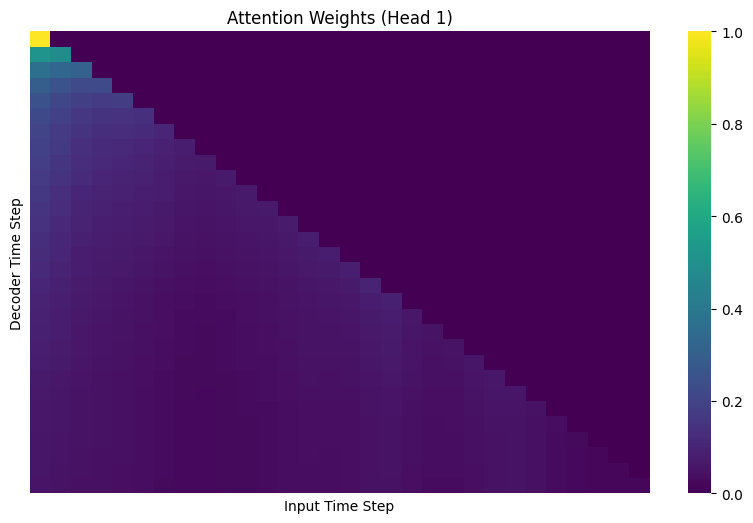

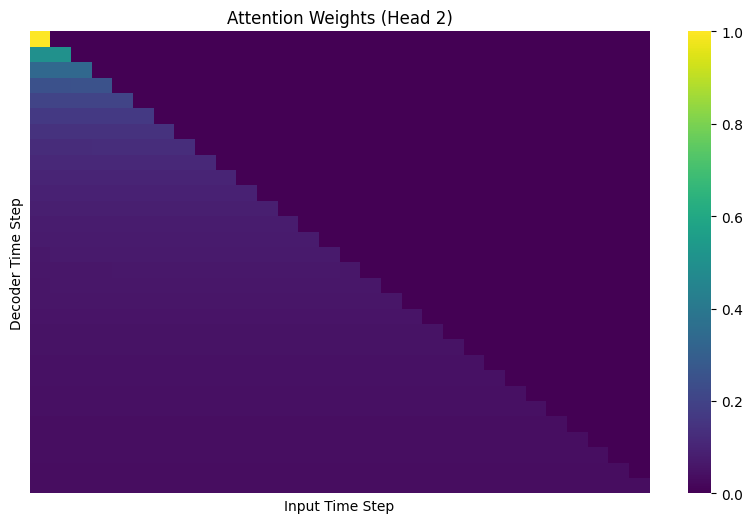

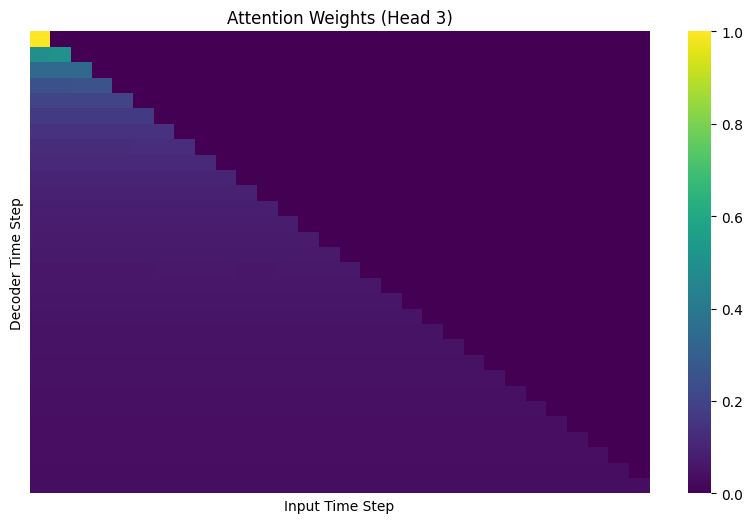

Epoch [1/70], Training Loss: 26.5070, Validation Loss: 5.5165
Saved new best model with Validation Loss: 5.5165


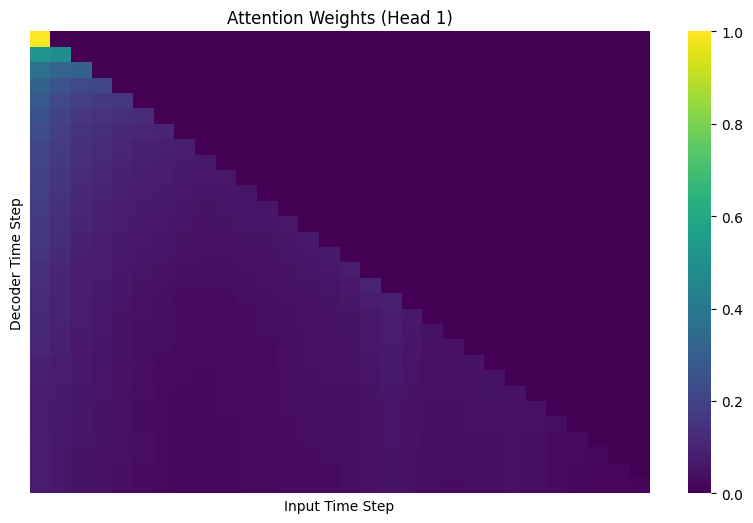

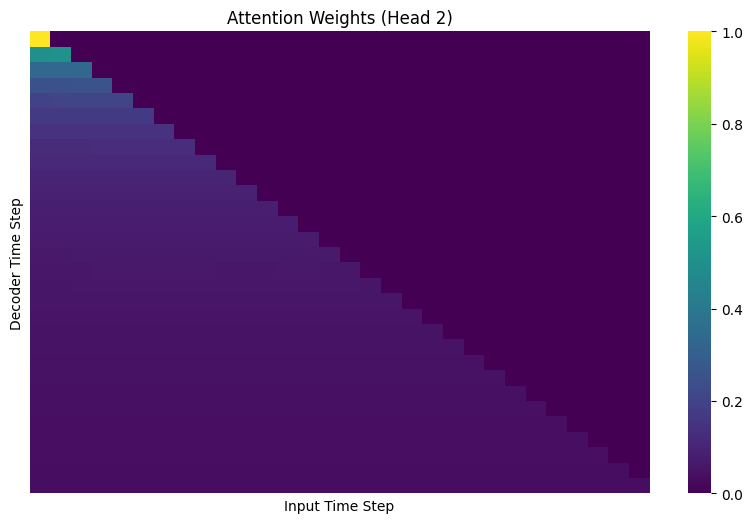

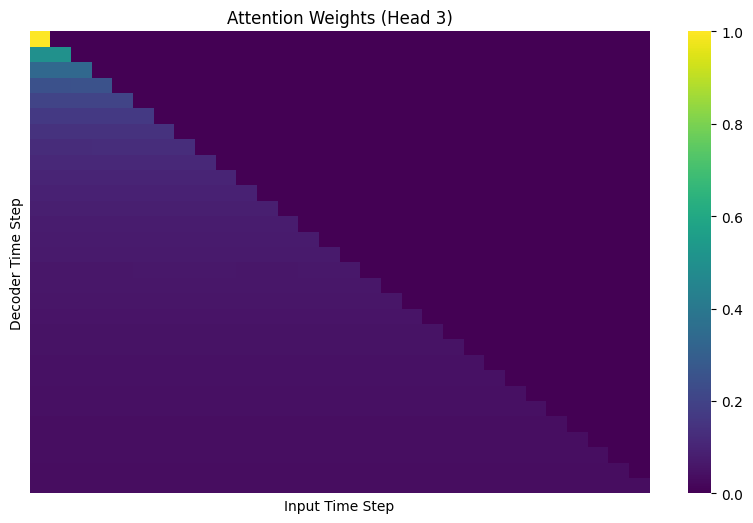

Epoch [2/70], Training Loss: 1.9379, Validation Loss: 1.4636
Saved new best model with Validation Loss: 1.4636


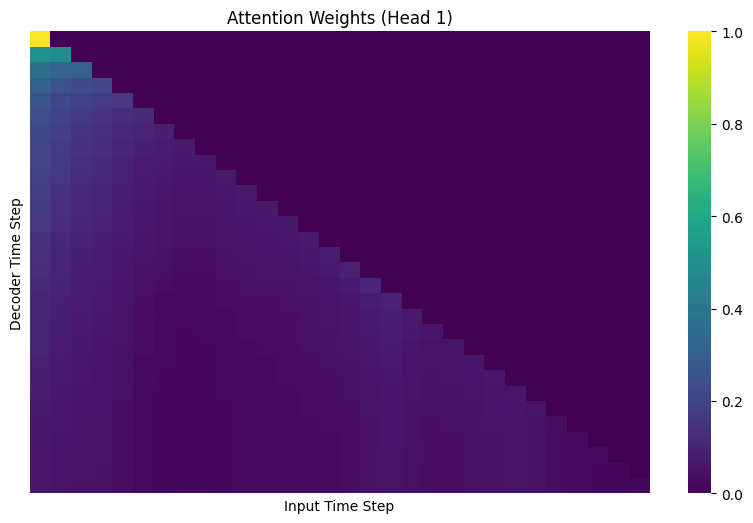

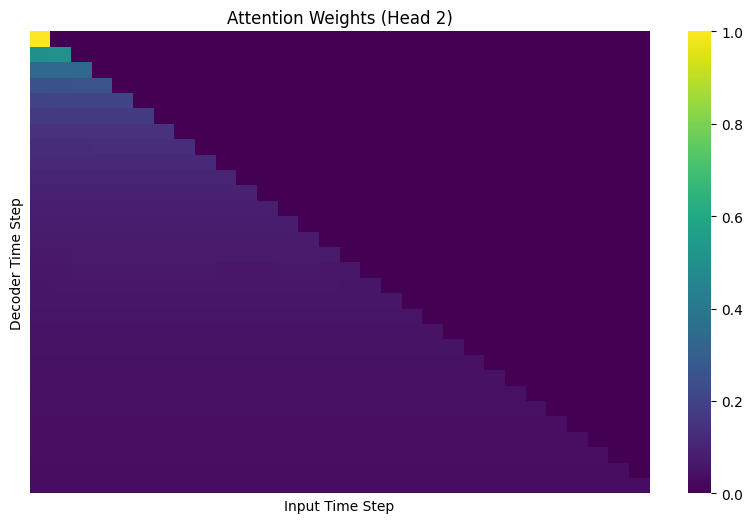

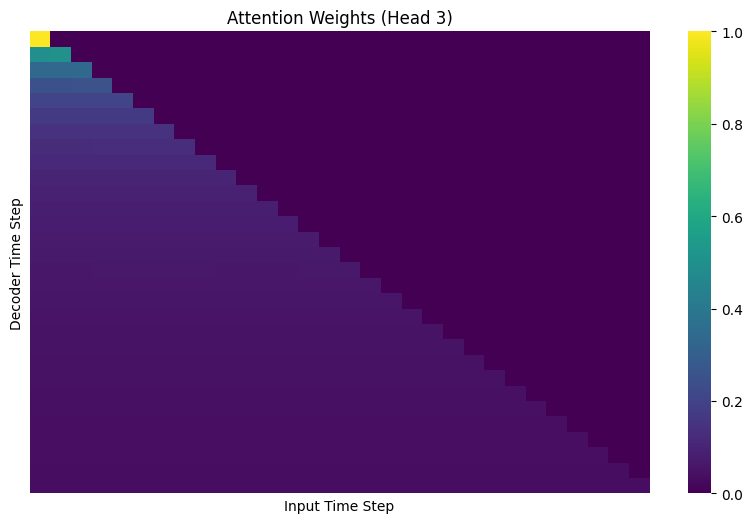

Epoch [3/70], Training Loss: 0.8036, Validation Loss: 0.7706
Saved new best model with Validation Loss: 0.7706


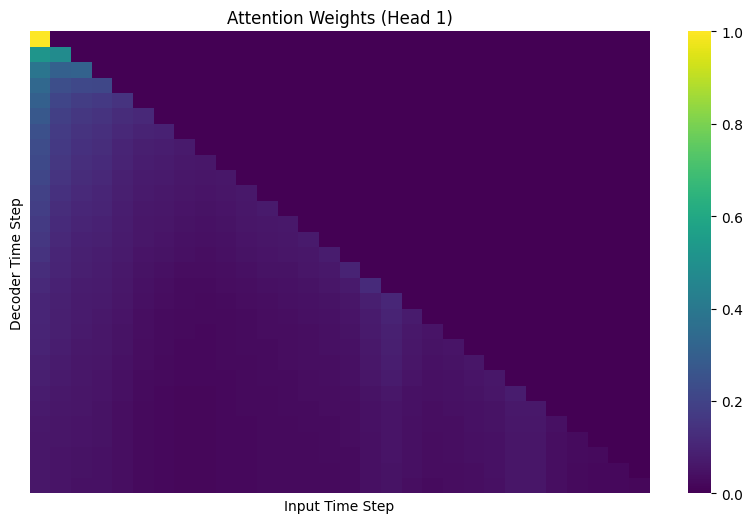

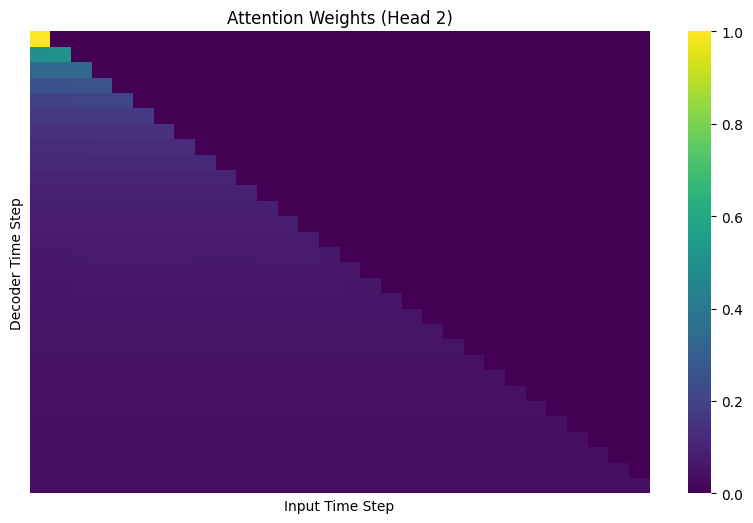

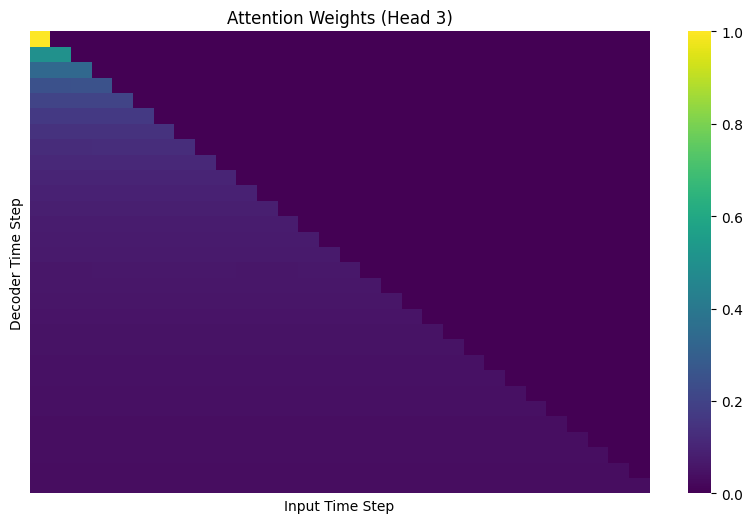

Epoch [4/70], Training Loss: 0.6062, Validation Loss: 0.4791
Saved new best model with Validation Loss: 0.4791


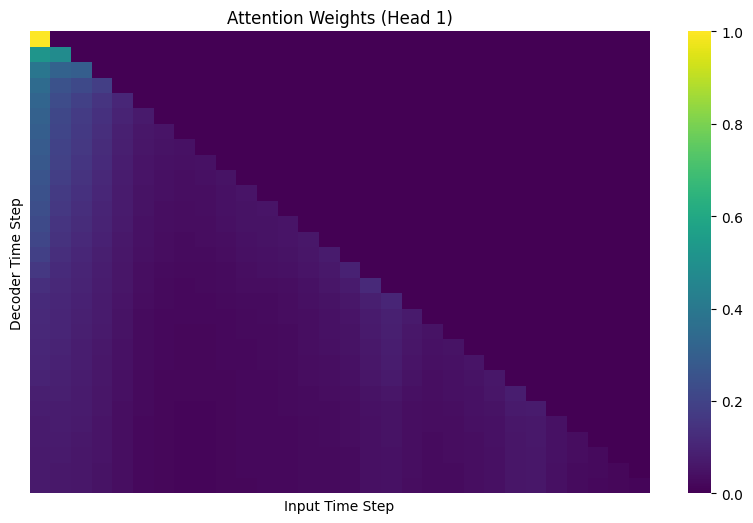

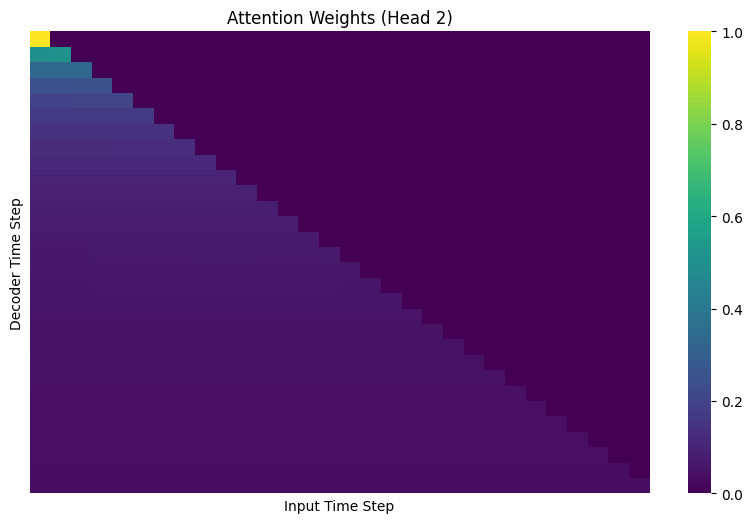

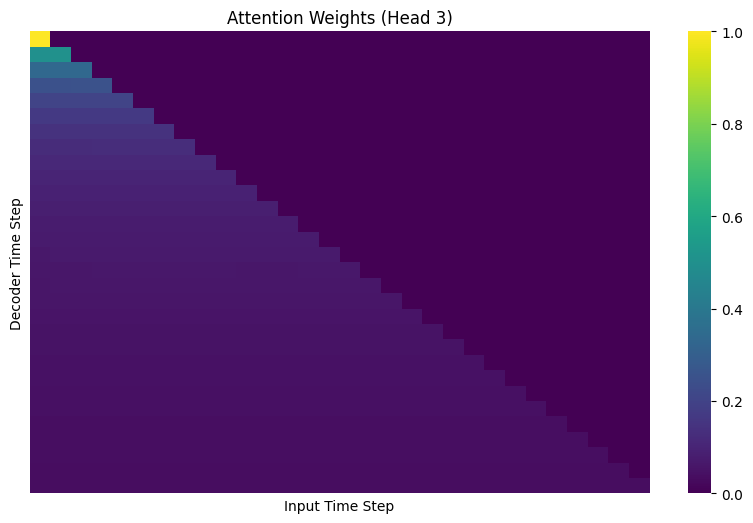

Epoch [5/70], Training Loss: 0.4024, Validation Loss: 0.5099


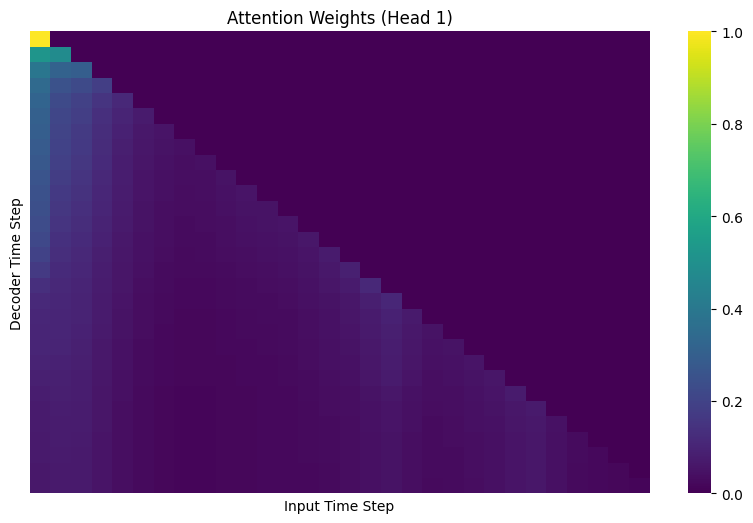

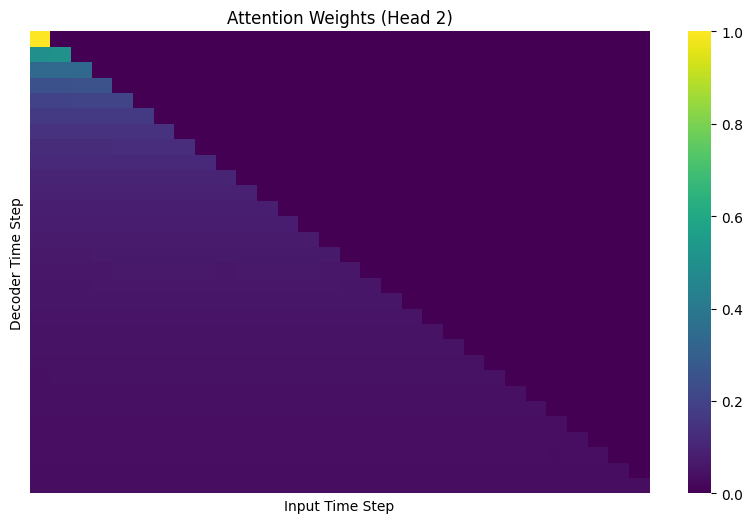

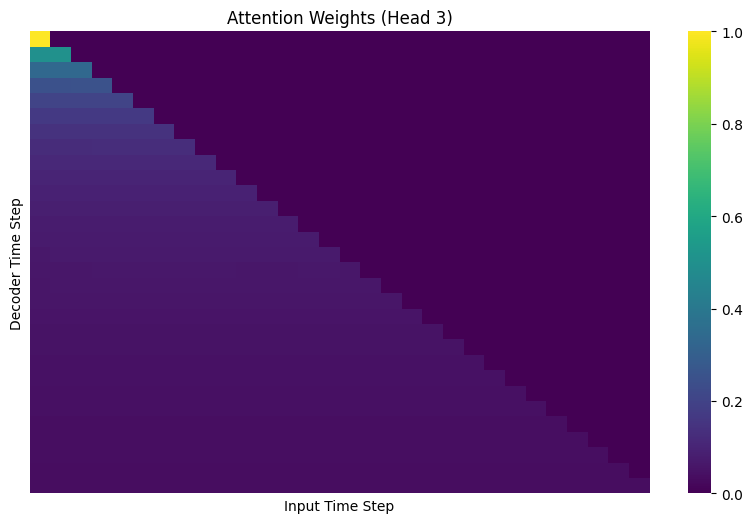

Epoch [6/70], Training Loss: 0.4347, Validation Loss: 0.3303
Saved new best model with Validation Loss: 0.3303


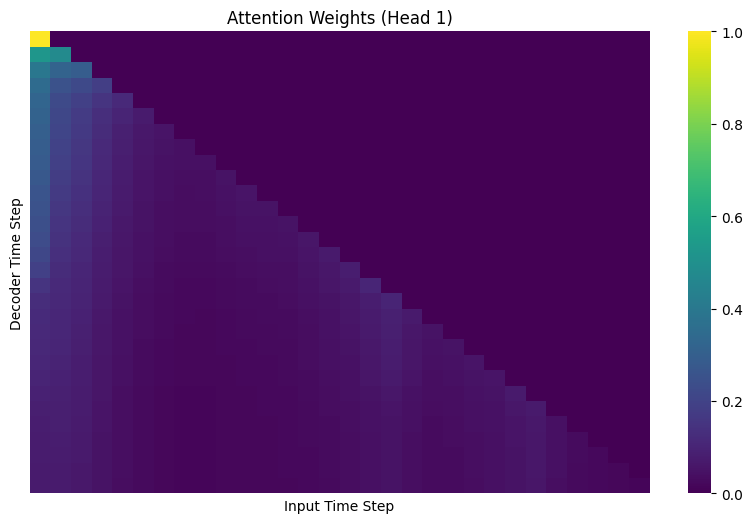

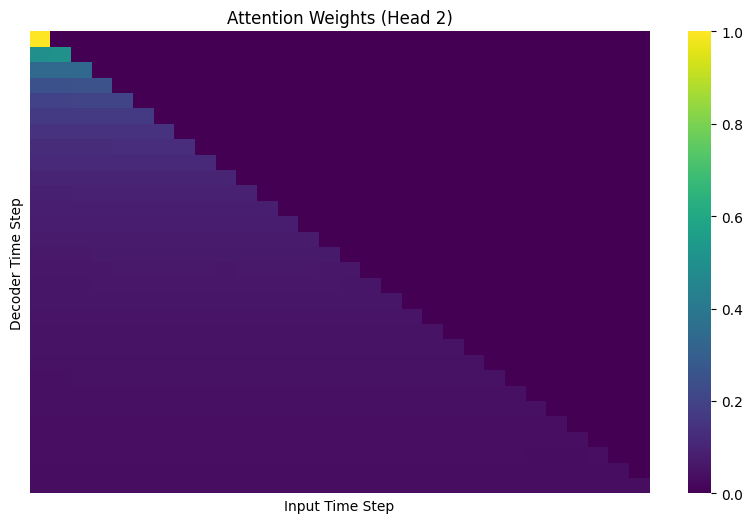

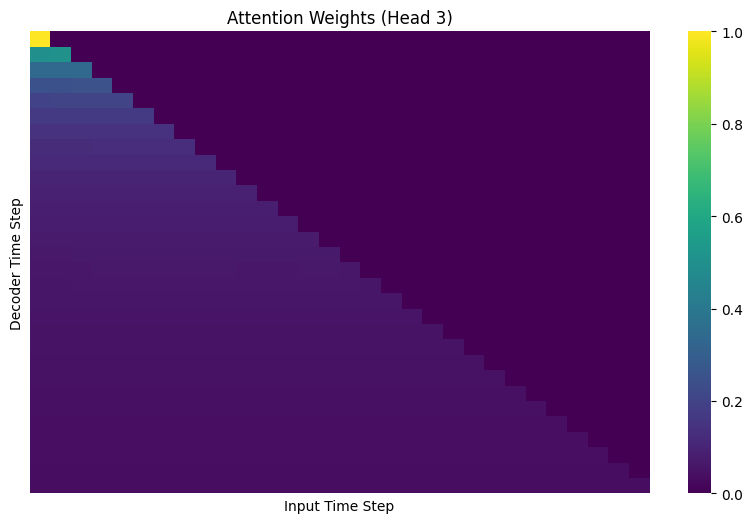

Epoch [7/70], Training Loss: 0.2892, Validation Loss: 0.3030
Saved new best model with Validation Loss: 0.3030


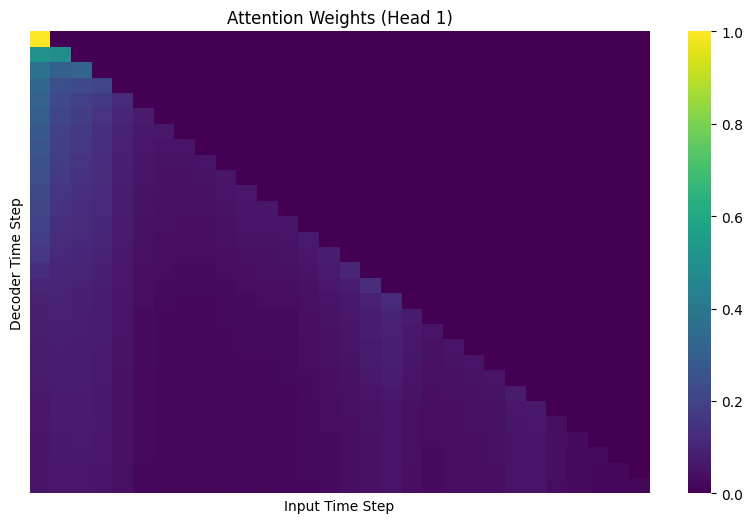

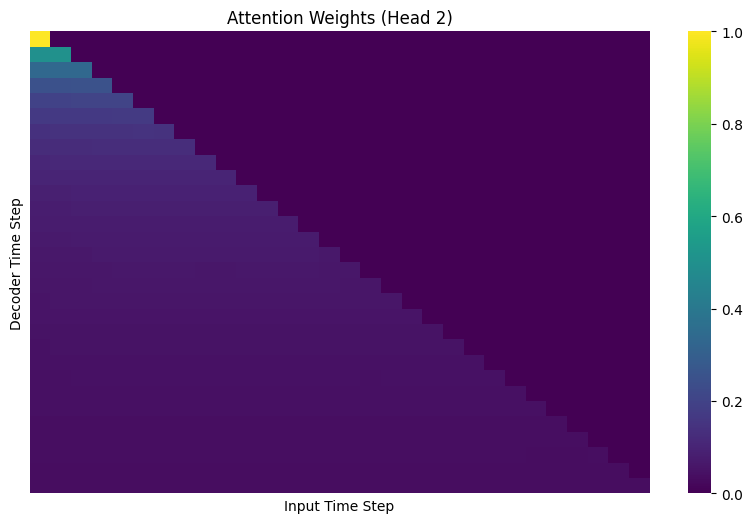

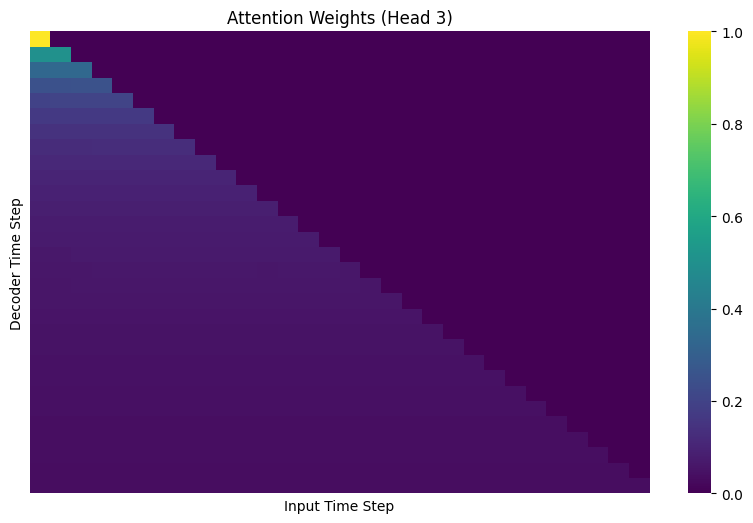

Epoch [8/70], Training Loss: 0.2748, Validation Loss: 0.1871
Saved new best model with Validation Loss: 0.1871


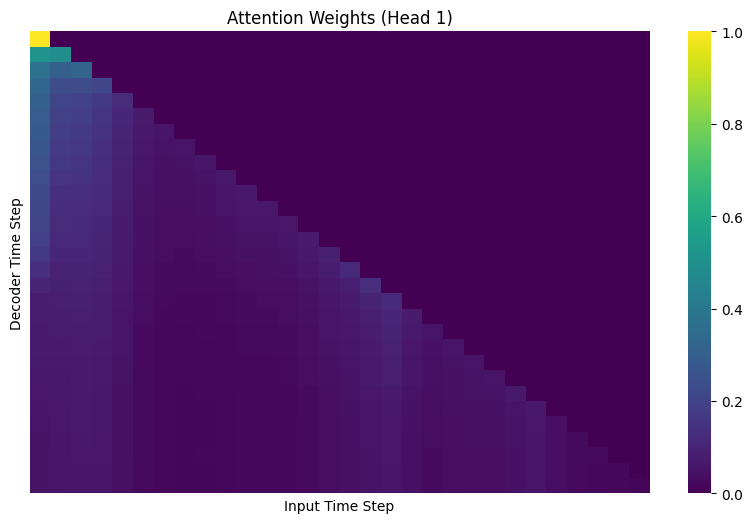

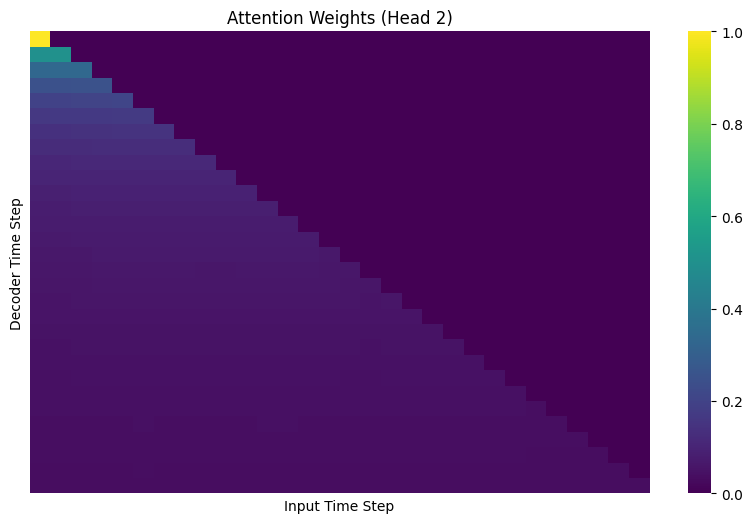

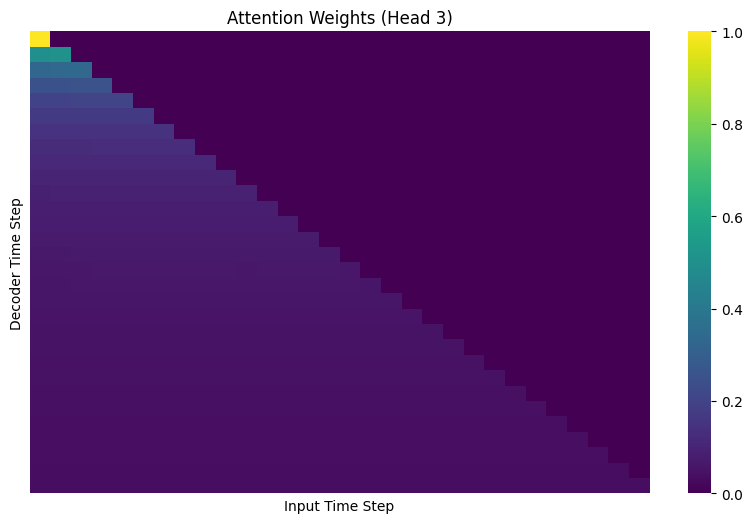

Epoch [9/70], Training Loss: 0.2627, Validation Loss: 0.1729
Saved new best model with Validation Loss: 0.1729


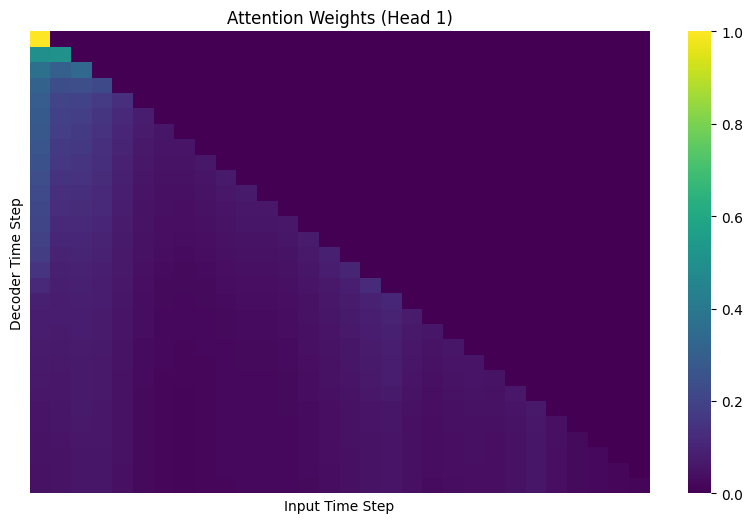

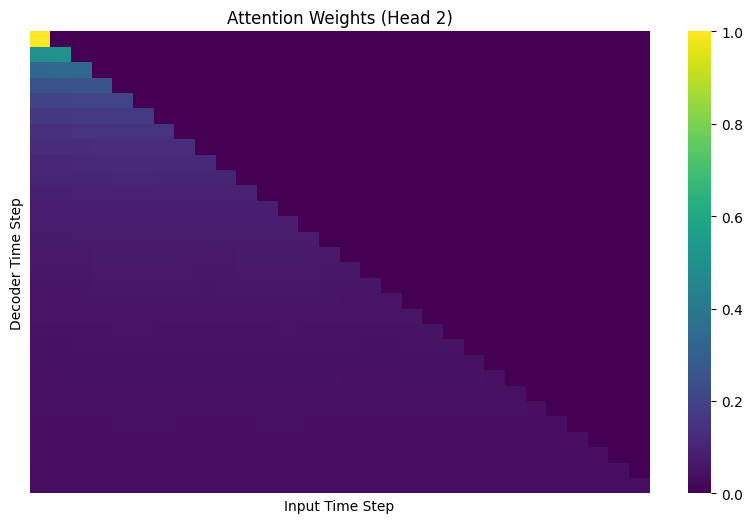

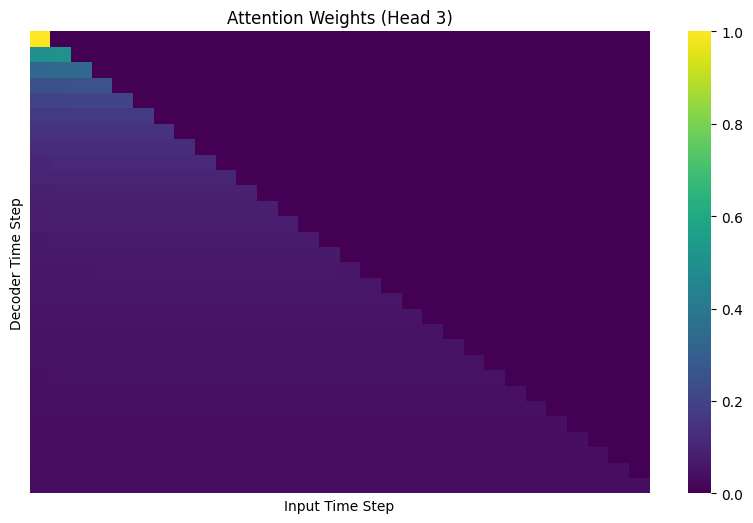

Epoch [10/70], Training Loss: 0.2726, Validation Loss: 0.2128


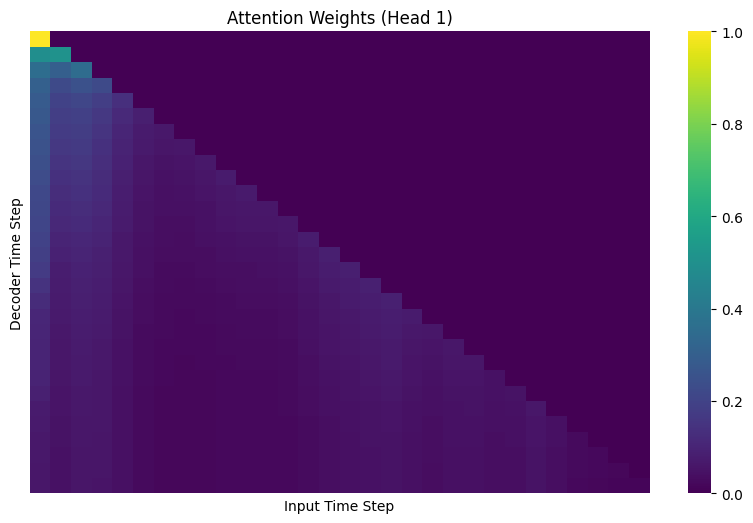

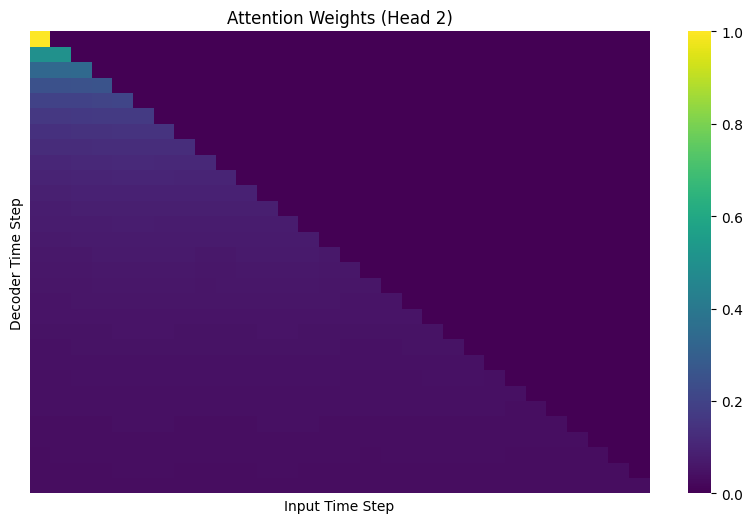

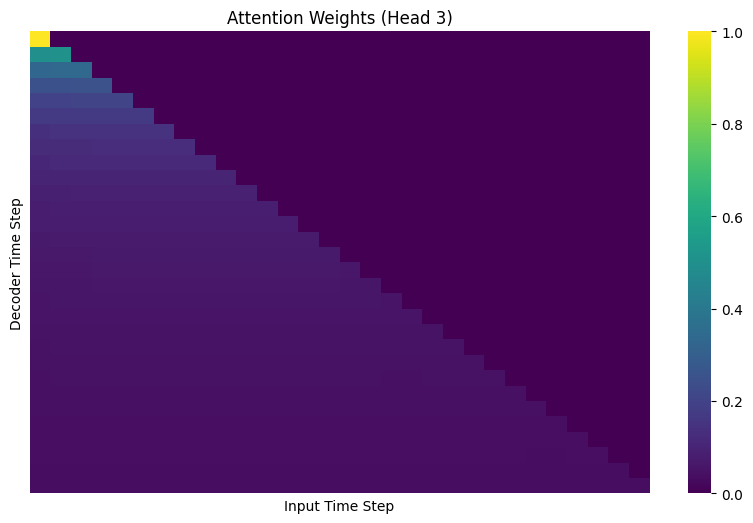

Epoch [11/70], Training Loss: 0.2652, Validation Loss: 0.1145
Saved new best model with Validation Loss: 0.1145


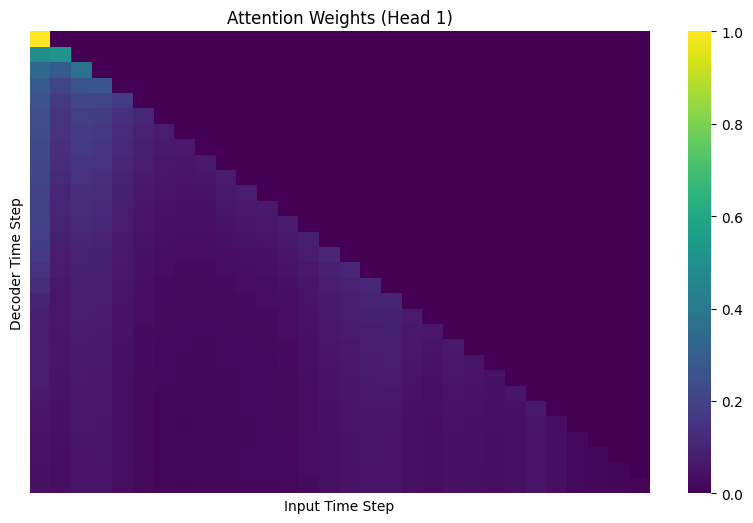

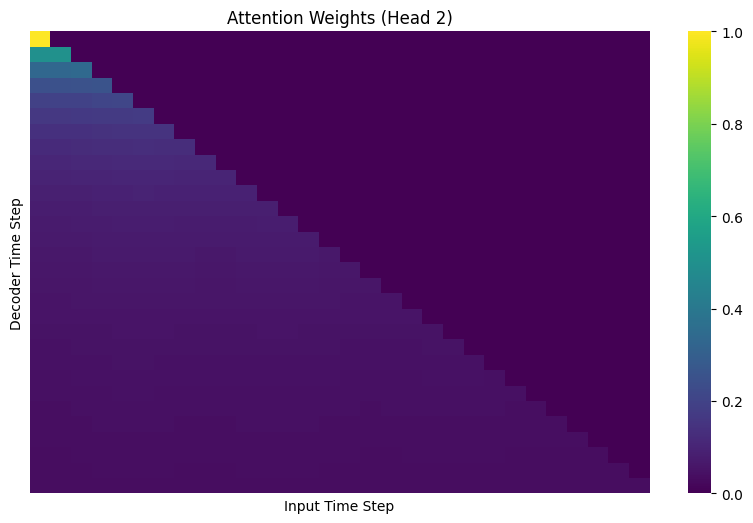

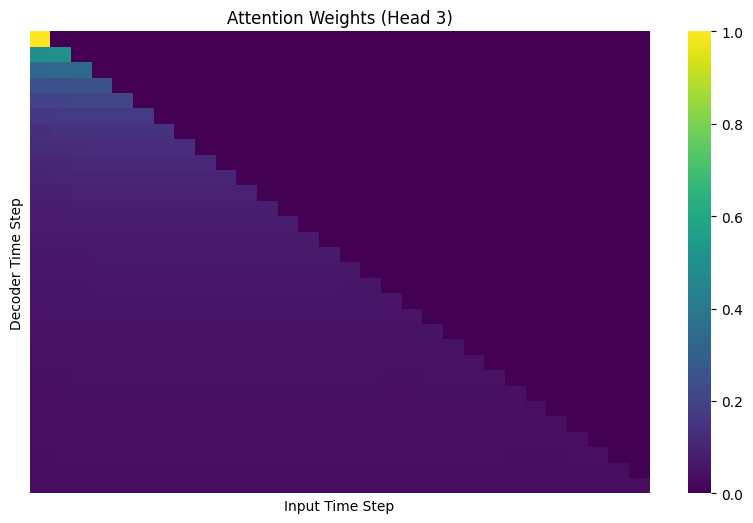

Epoch [12/70], Training Loss: 0.2388, Validation Loss: 0.1478


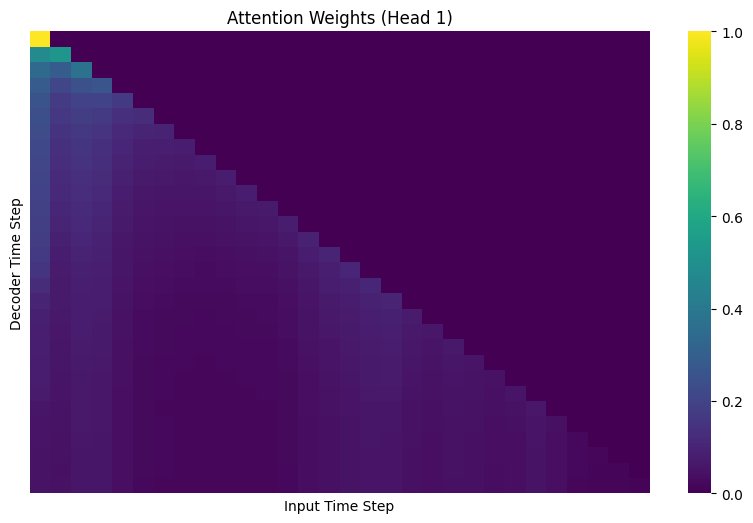

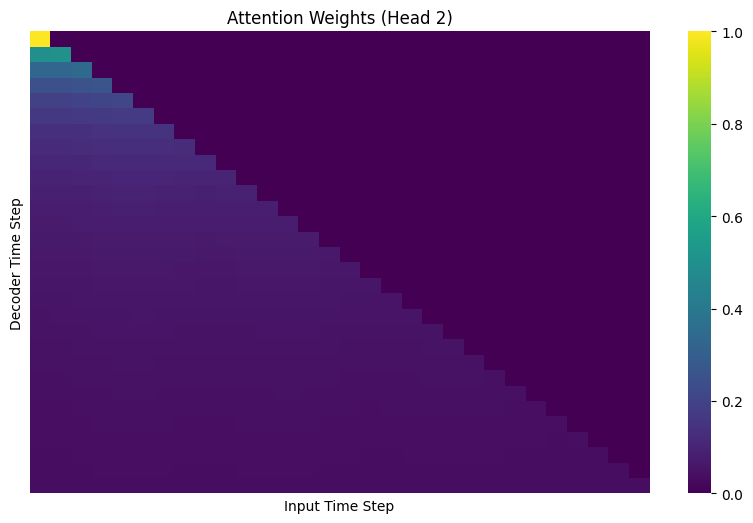

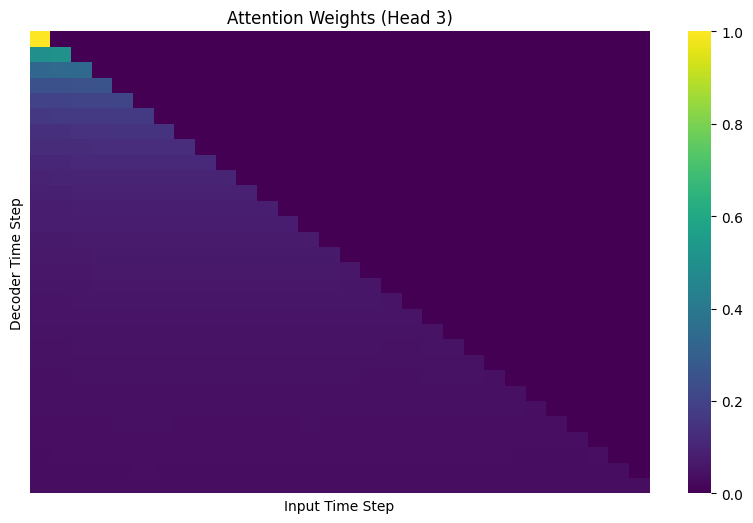

Epoch [13/70], Training Loss: 0.2239, Validation Loss: 0.1336


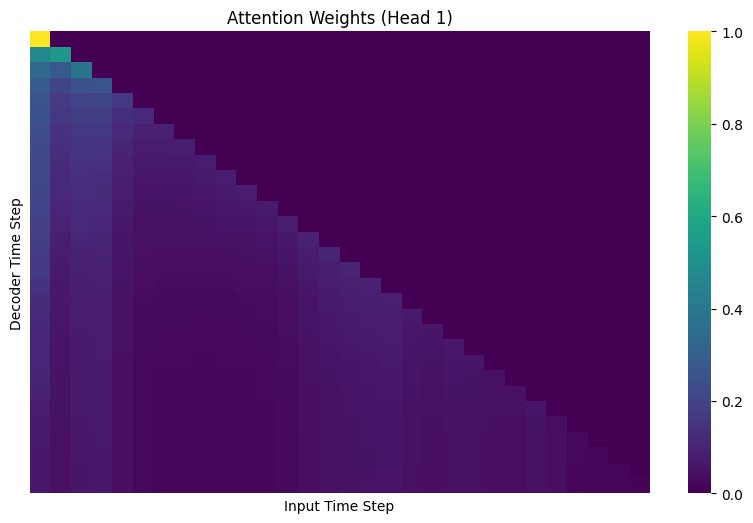

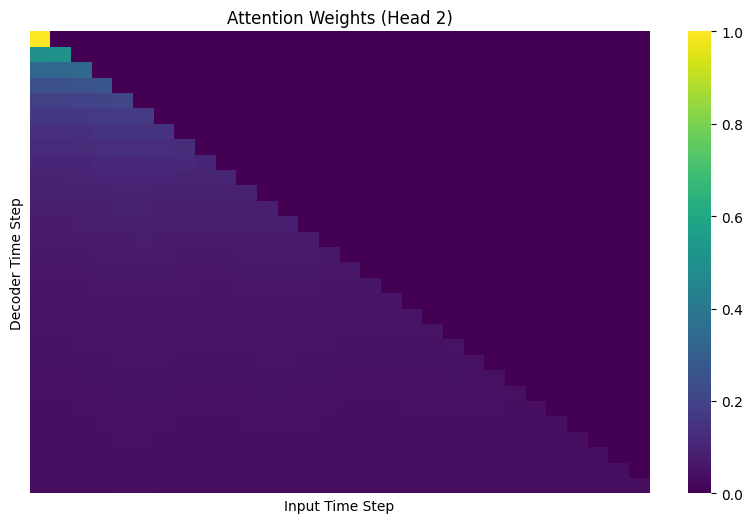

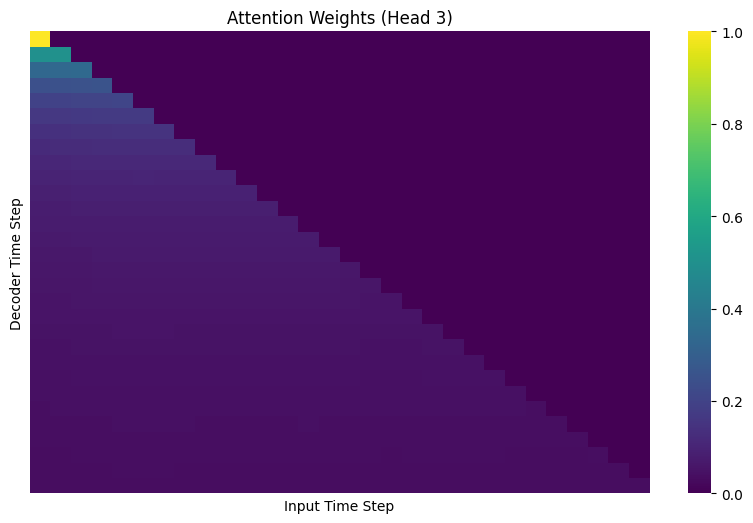

Epoch [14/70], Training Loss: 0.1933, Validation Loss: 0.1711


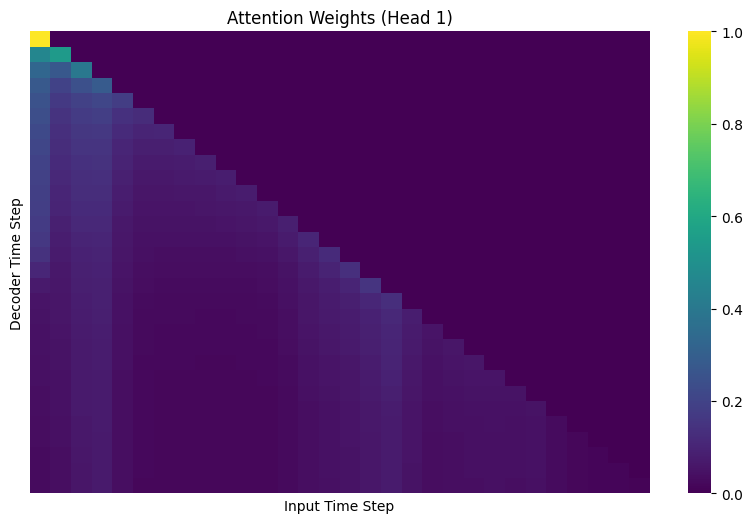

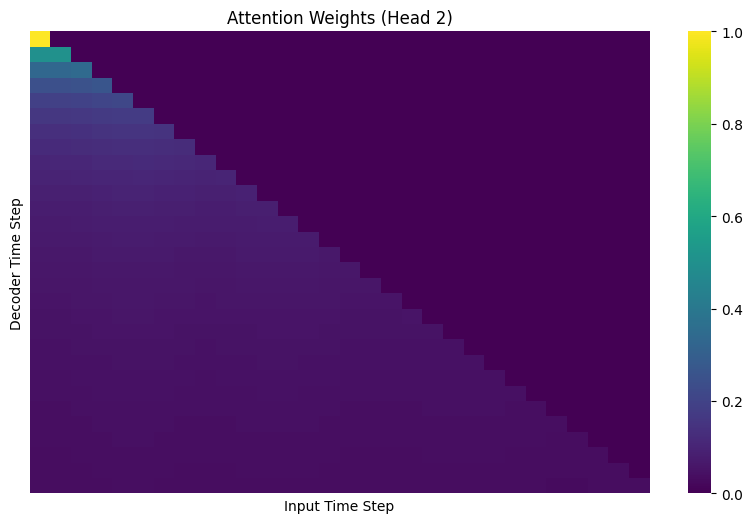

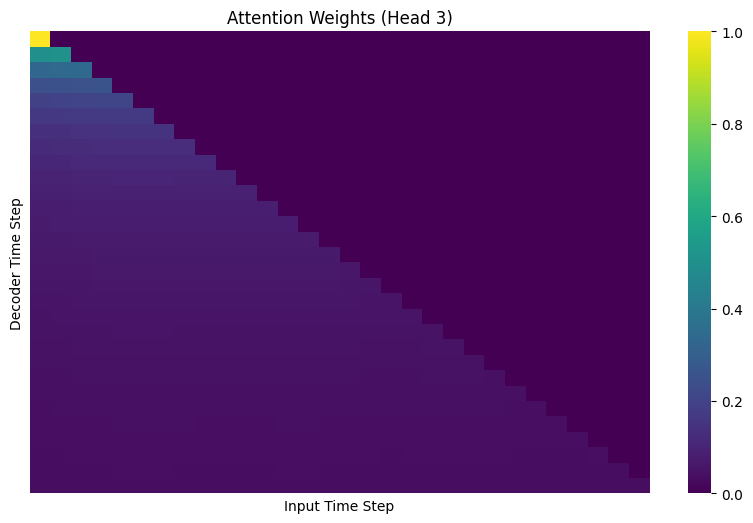

Epoch [15/70], Training Loss: 0.1834, Validation Loss: 0.2116


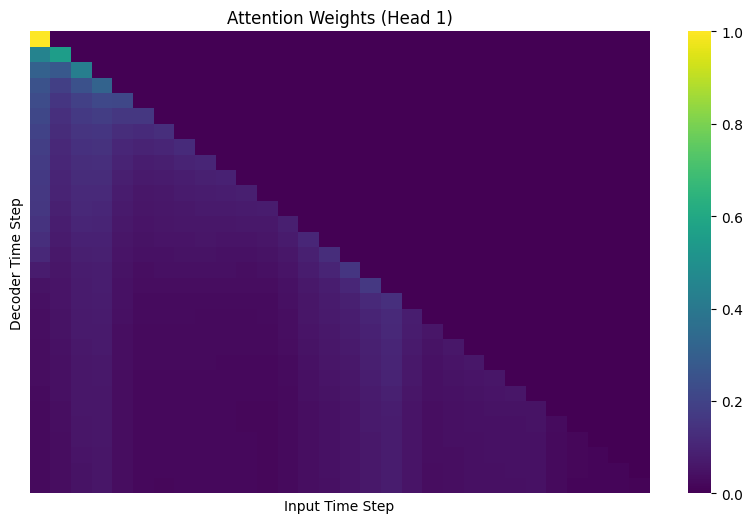

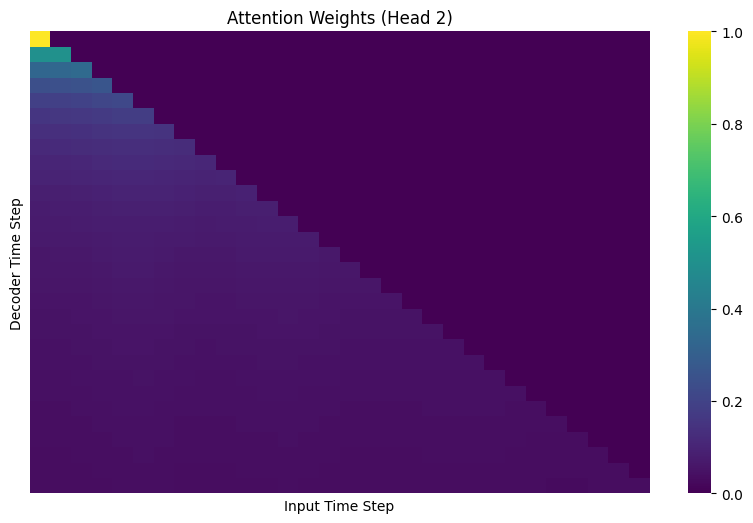

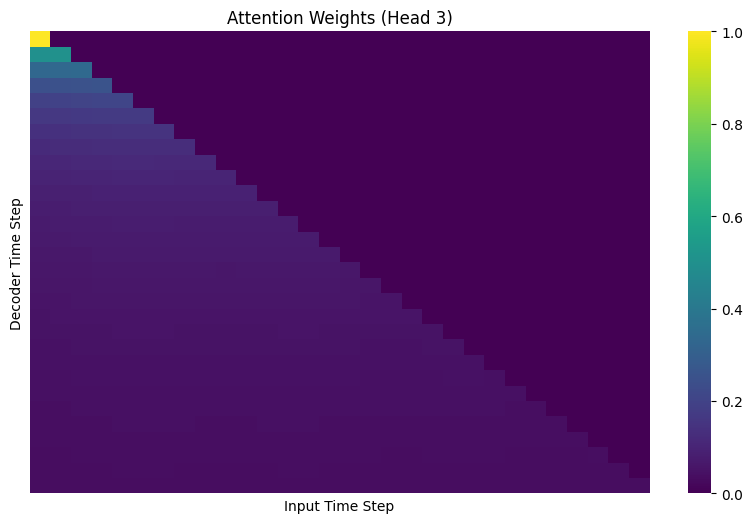

Epoch [16/70], Training Loss: 0.1941, Validation Loss: 0.1001
Saved new best model with Validation Loss: 0.1001


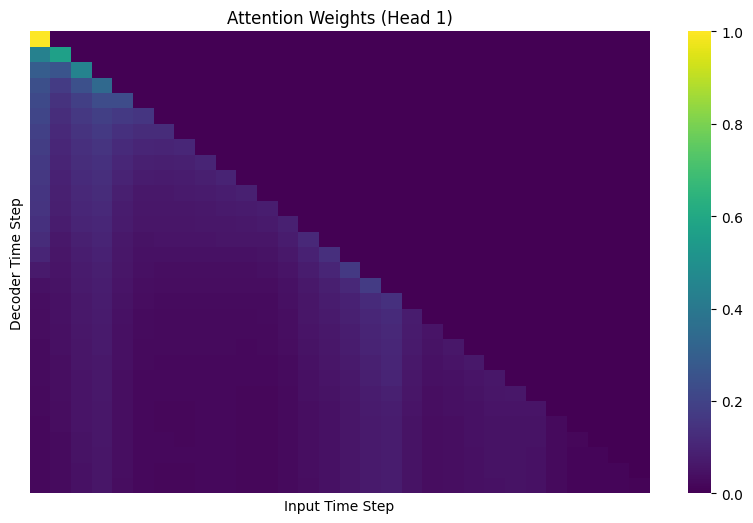

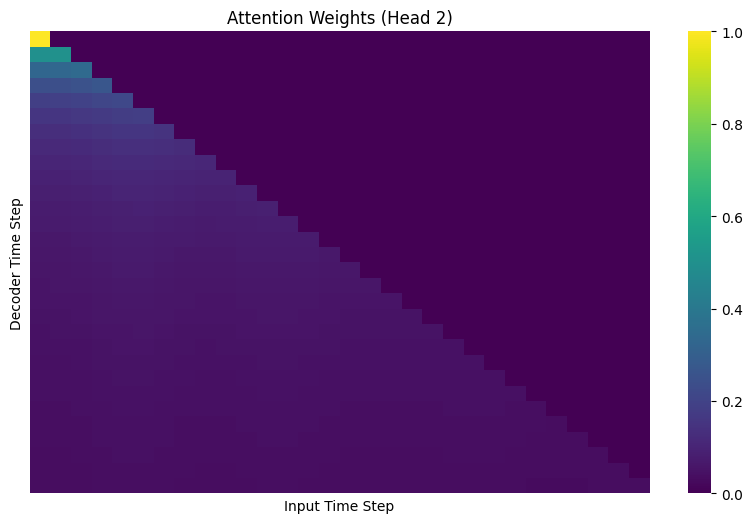

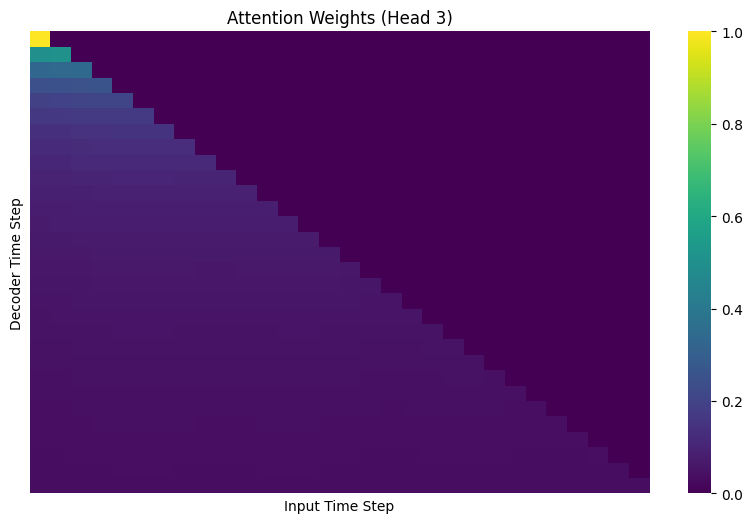

Epoch [17/70], Training Loss: 0.1545, Validation Loss: 0.3012


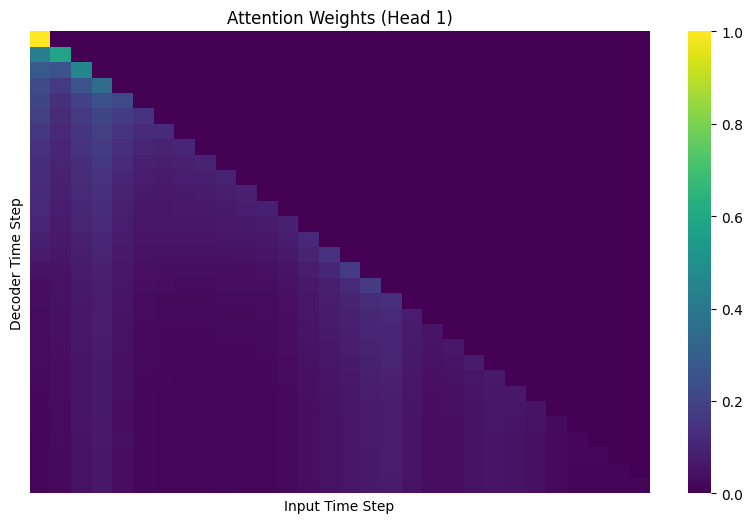

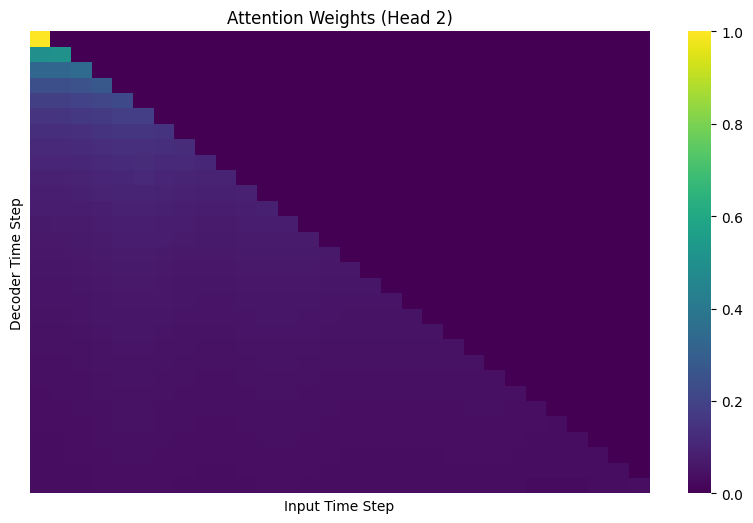

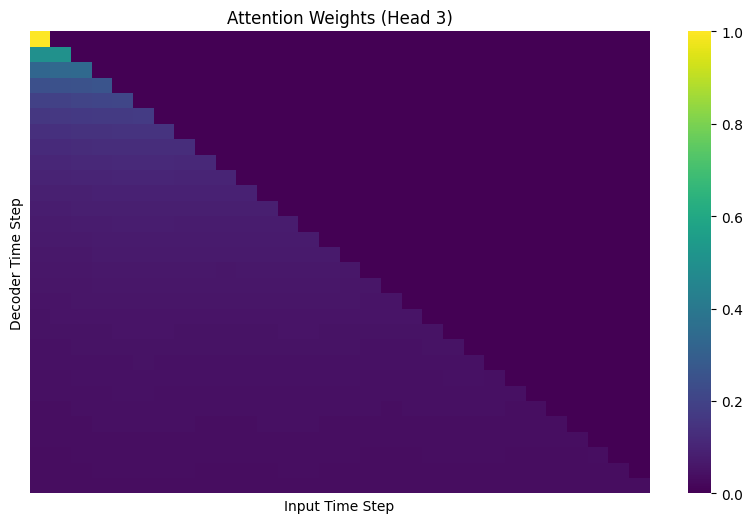

Epoch [18/70], Training Loss: 0.1473, Validation Loss: 0.1437


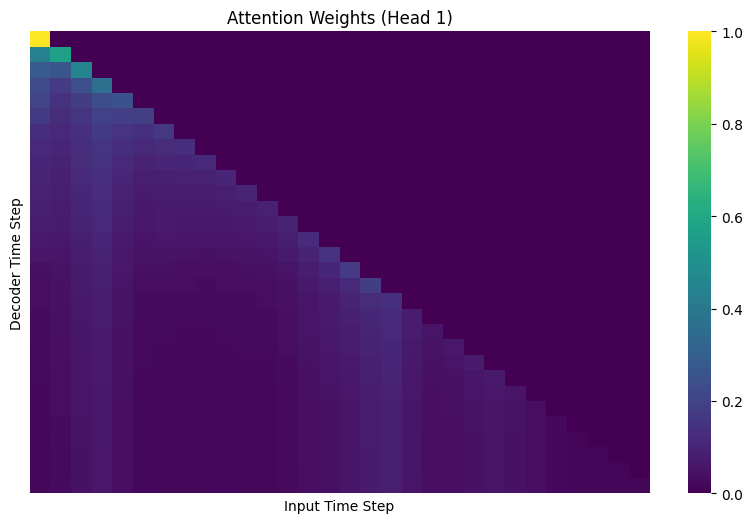

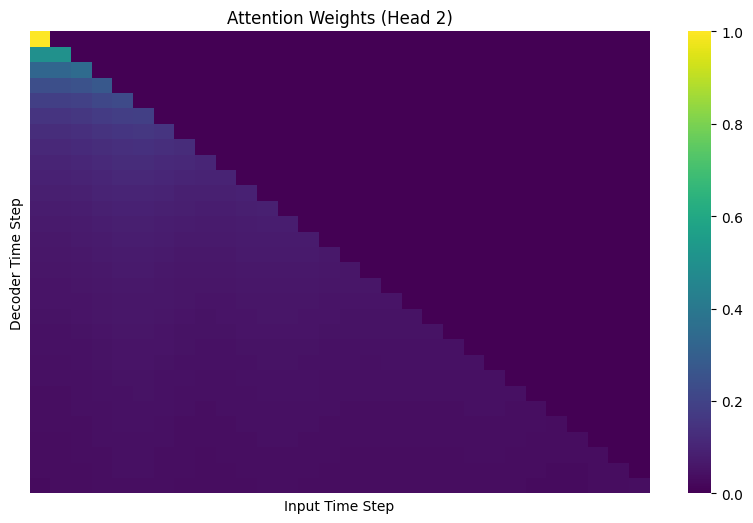

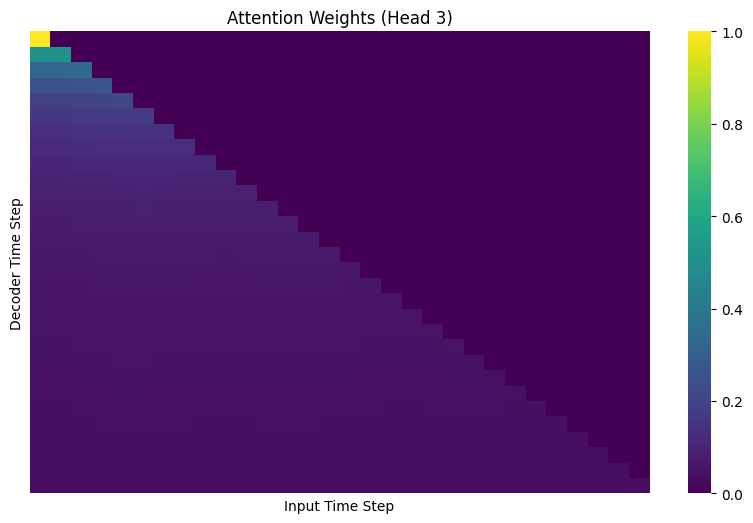

Epoch [19/70], Training Loss: 0.1339, Validation Loss: 0.0942
Saved new best model with Validation Loss: 0.0942


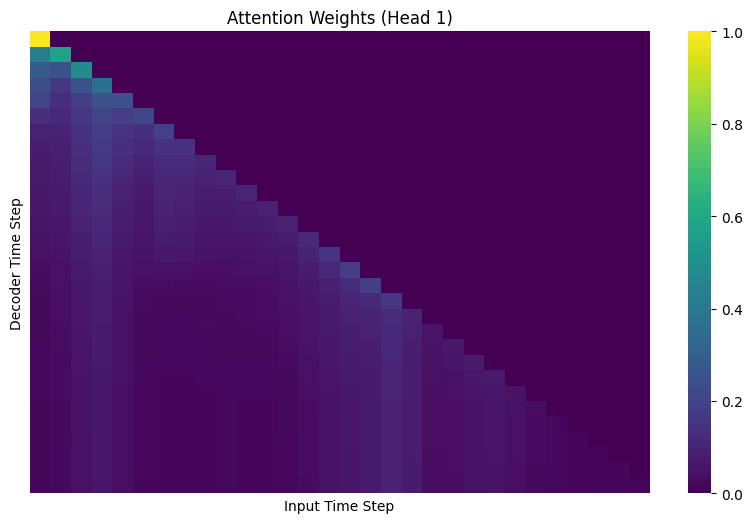

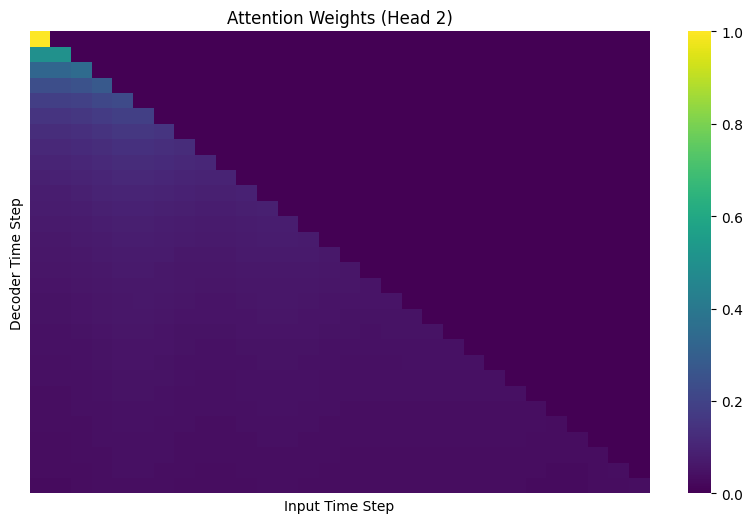

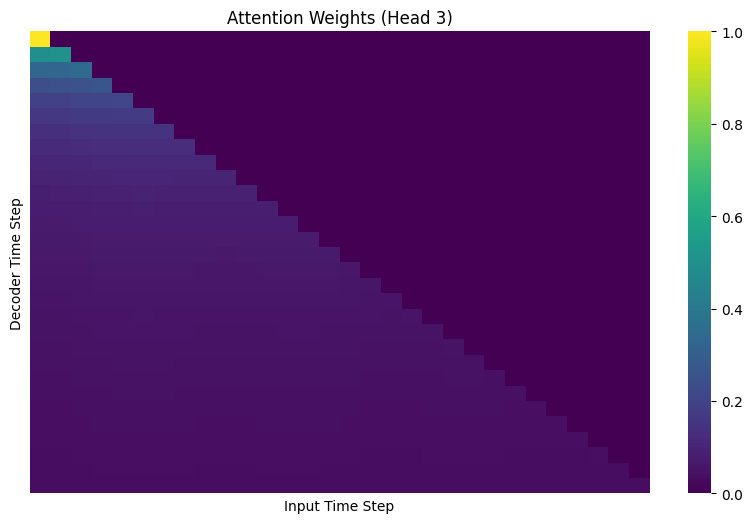

Epoch [20/70], Training Loss: 0.2029, Validation Loss: 0.1061


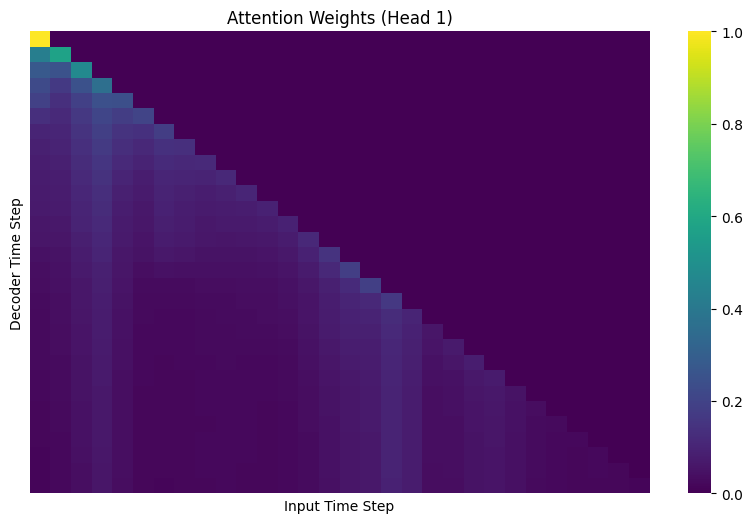

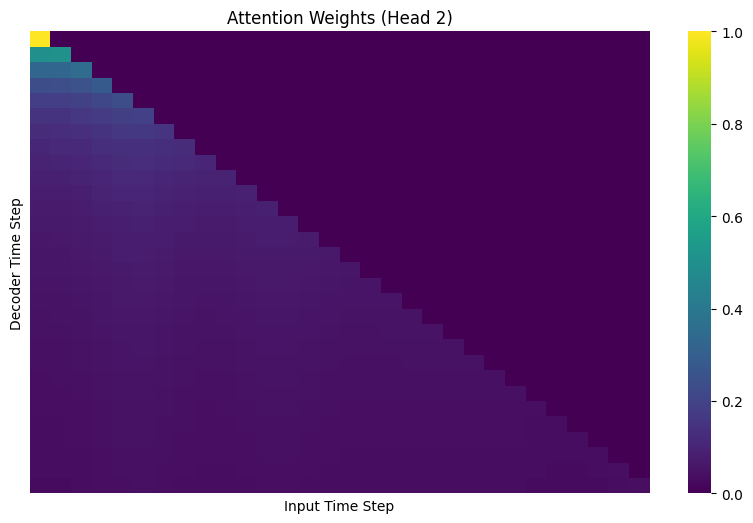

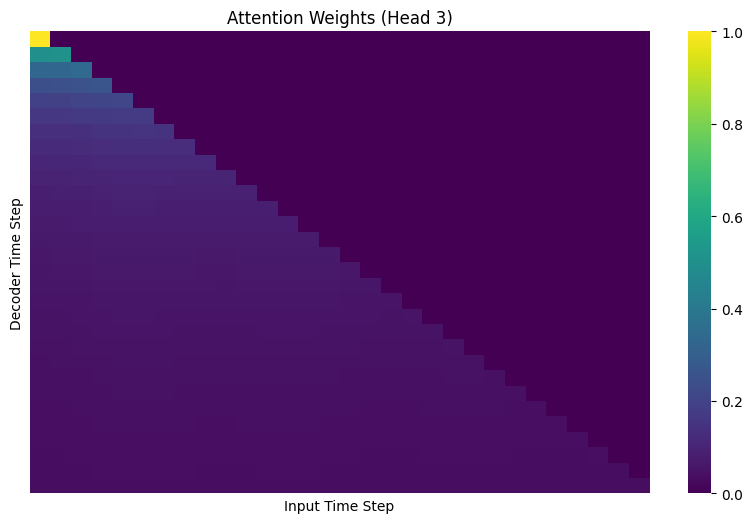

Epoch [21/70], Training Loss: 0.0962, Validation Loss: 0.0656
Saved new best model with Validation Loss: 0.0656


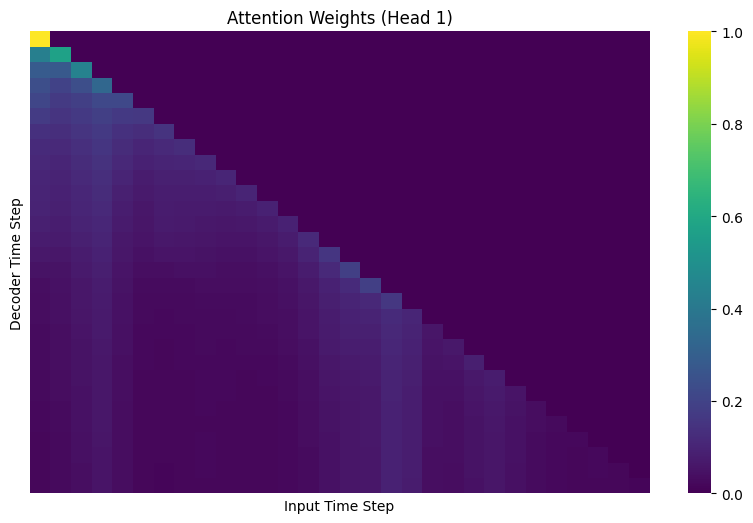

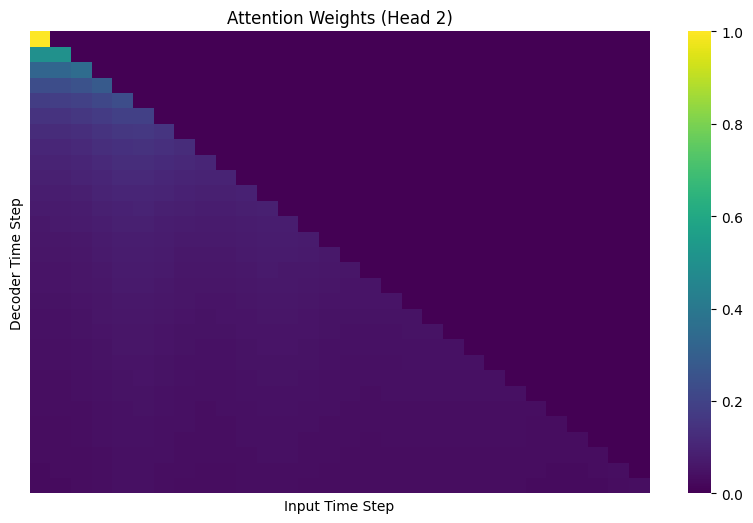

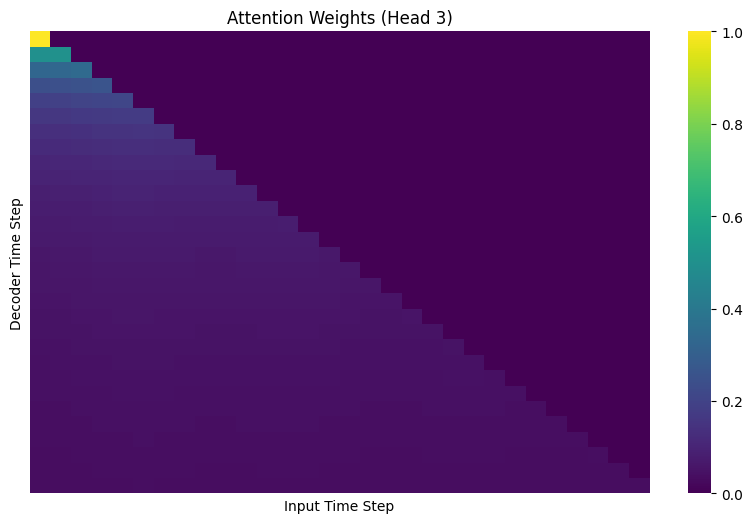

Epoch [22/70], Training Loss: 0.1321, Validation Loss: 0.0596
Saved new best model with Validation Loss: 0.0596


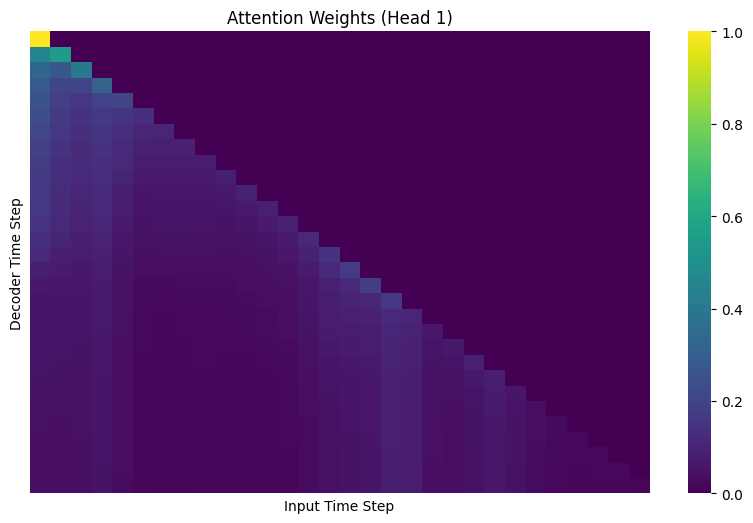

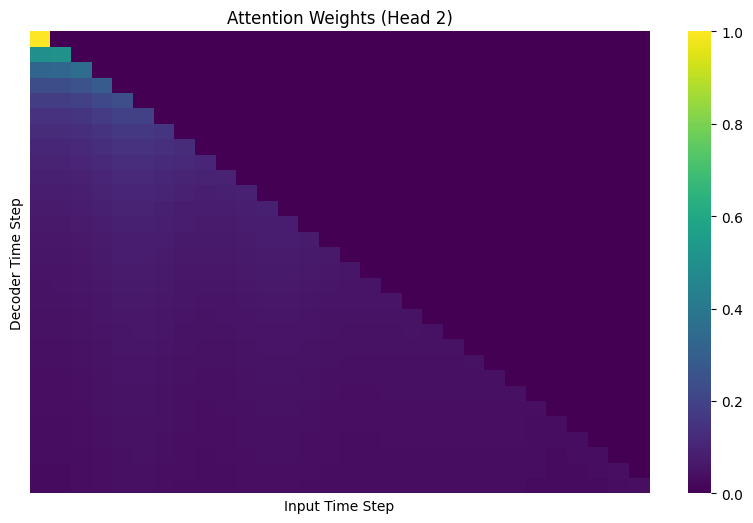

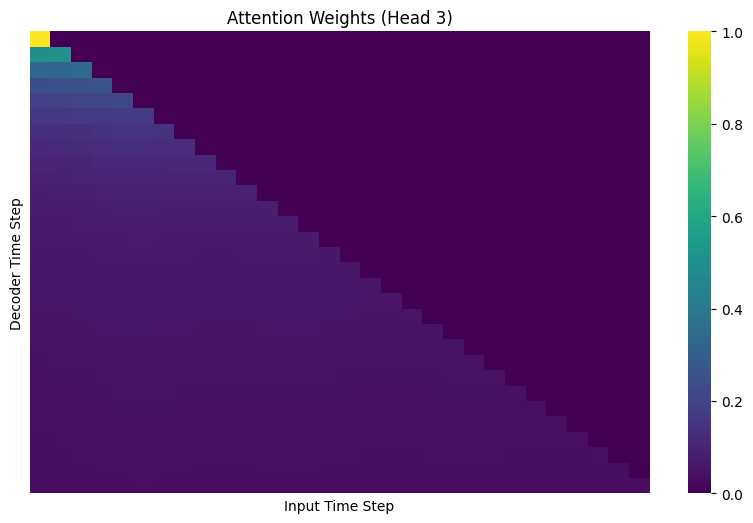

Epoch [23/70], Training Loss: 0.1097, Validation Loss: 0.1863


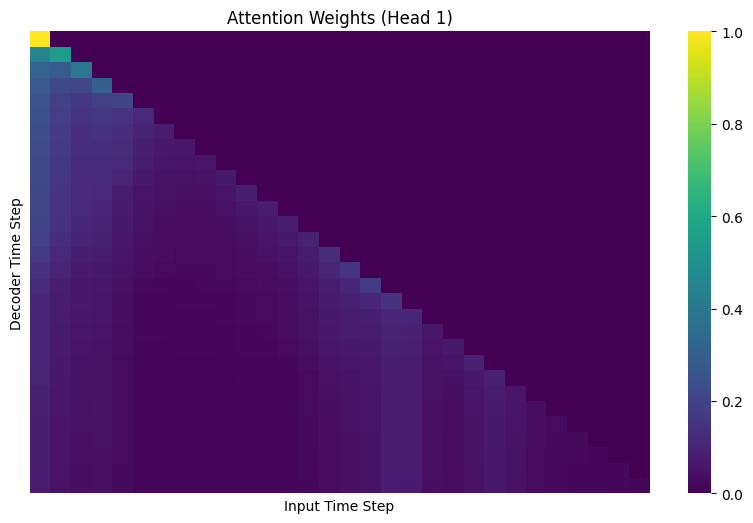

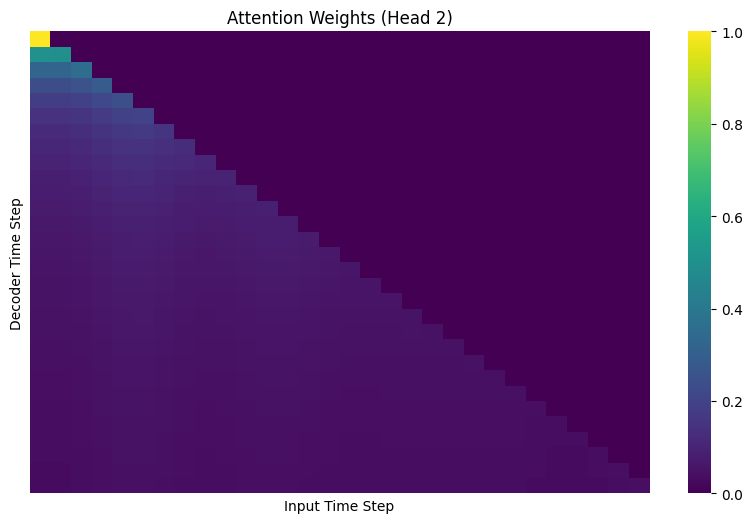

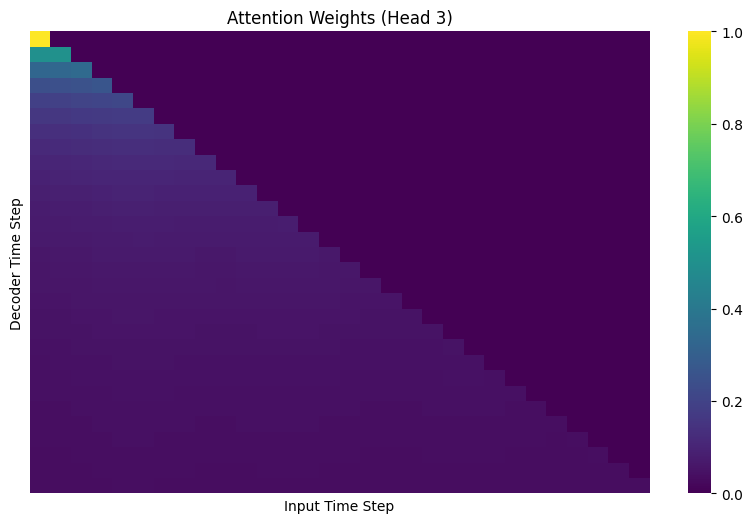

Epoch [24/70], Training Loss: 0.1327, Validation Loss: 0.2325


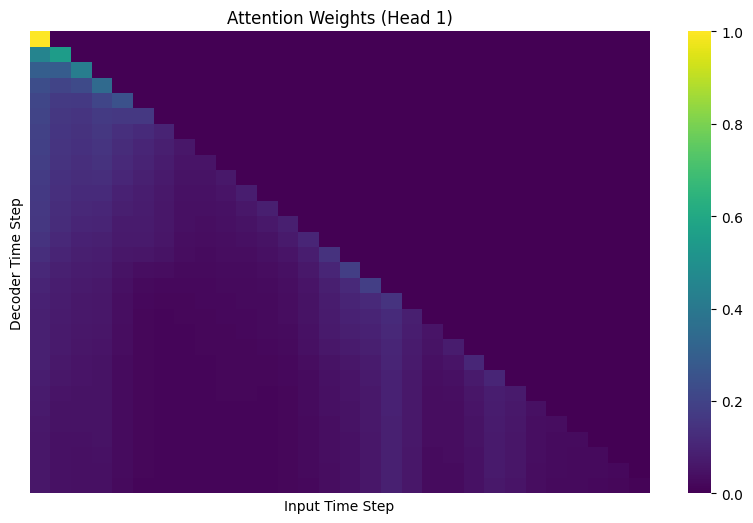

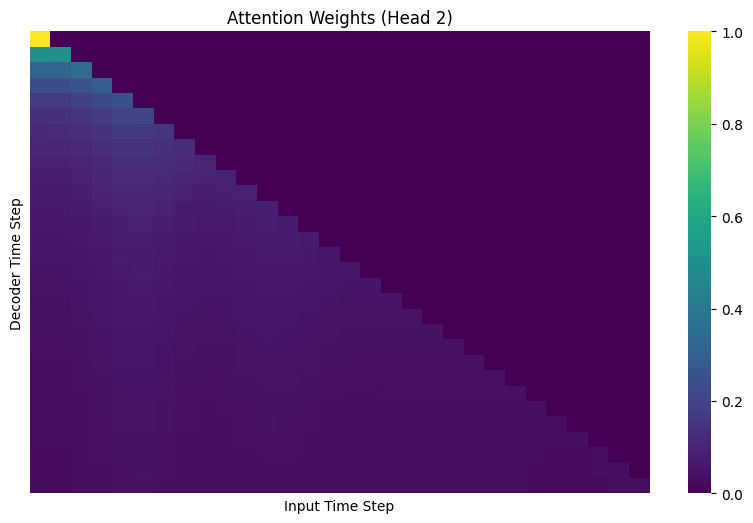

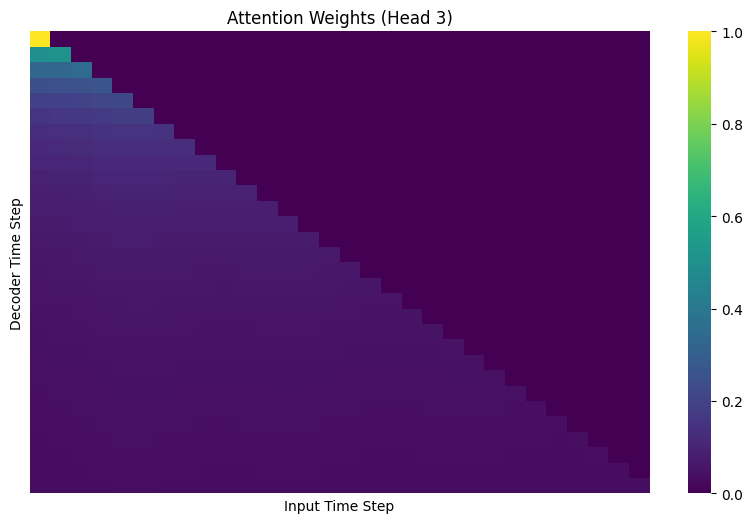

Epoch [25/70], Training Loss: 0.0944, Validation Loss: 0.1312


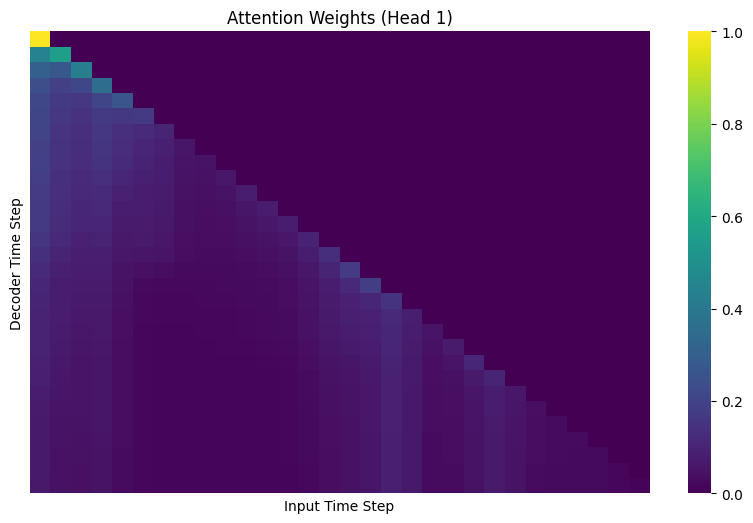

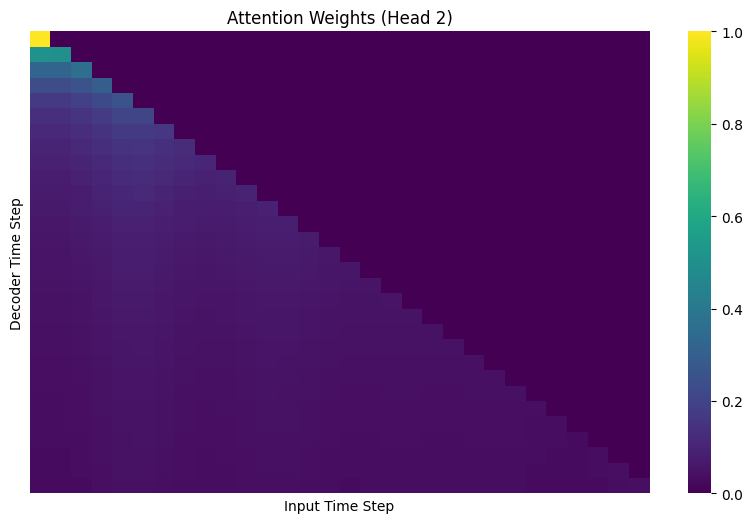

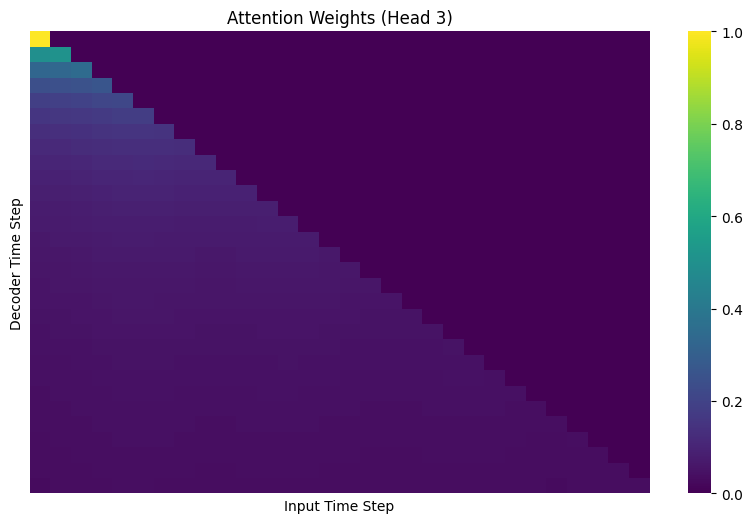

Epoch [26/70], Training Loss: 0.1018, Validation Loss: 0.1150


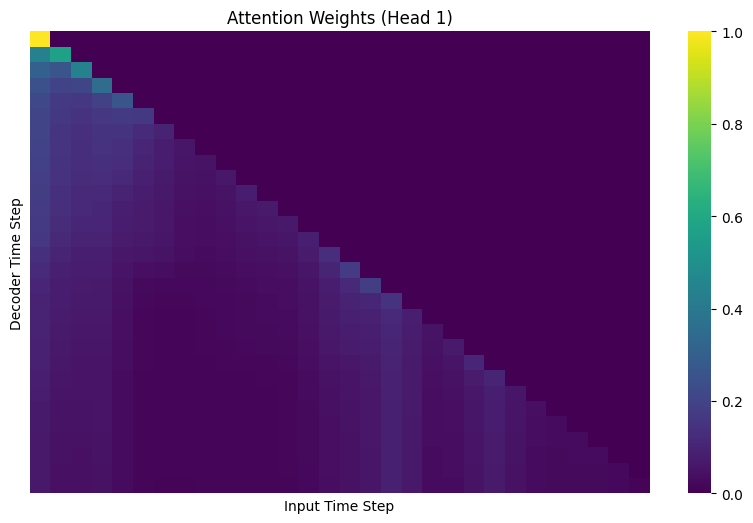

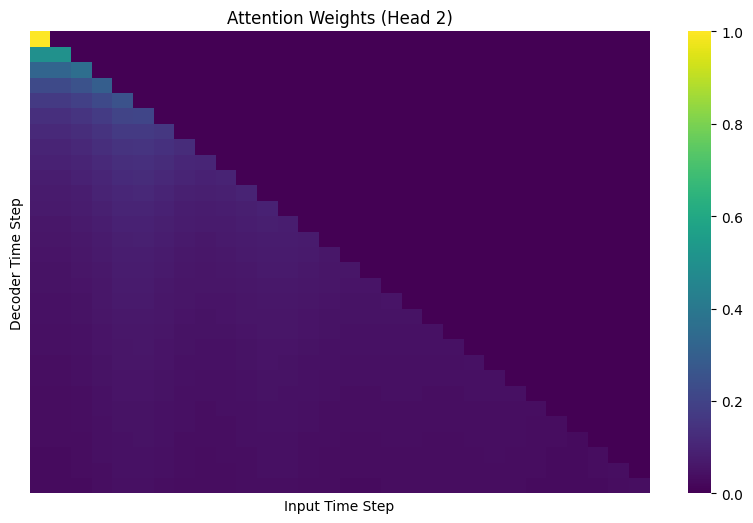

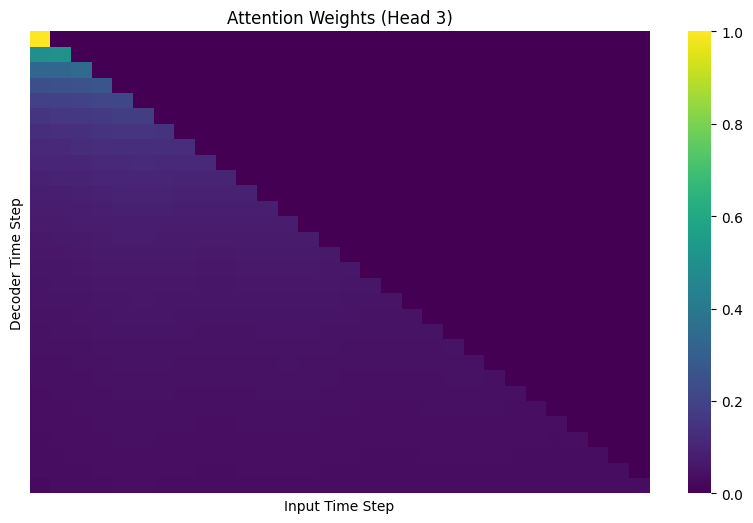

Epoch [27/70], Training Loss: 0.1185, Validation Loss: 0.0697


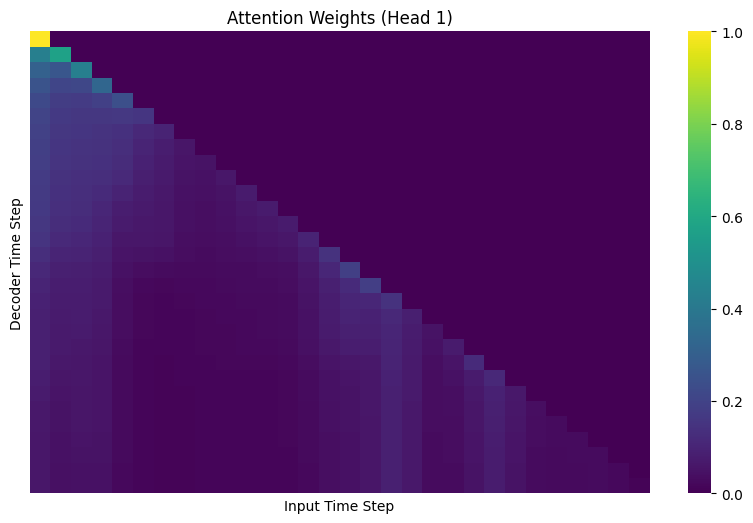

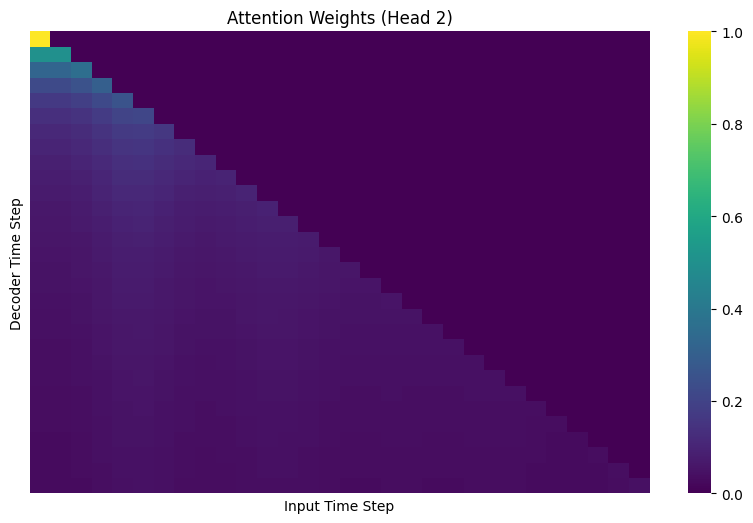

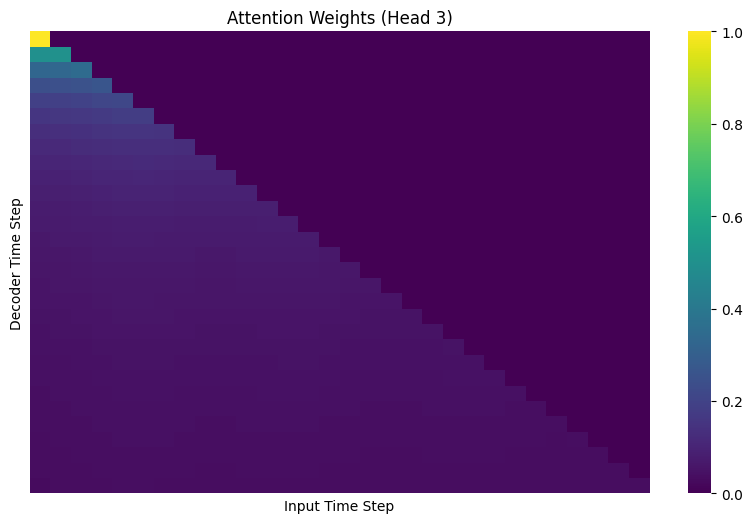

Epoch [28/70], Training Loss: 0.0865, Validation Loss: 0.0492
Saved new best model with Validation Loss: 0.0492


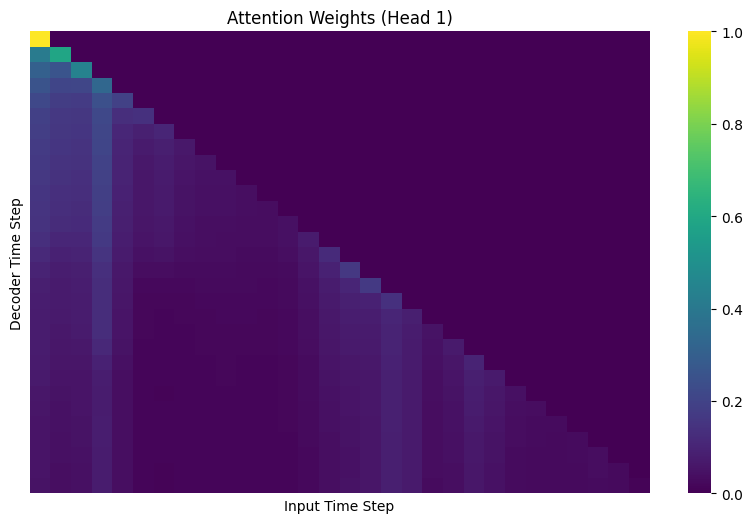

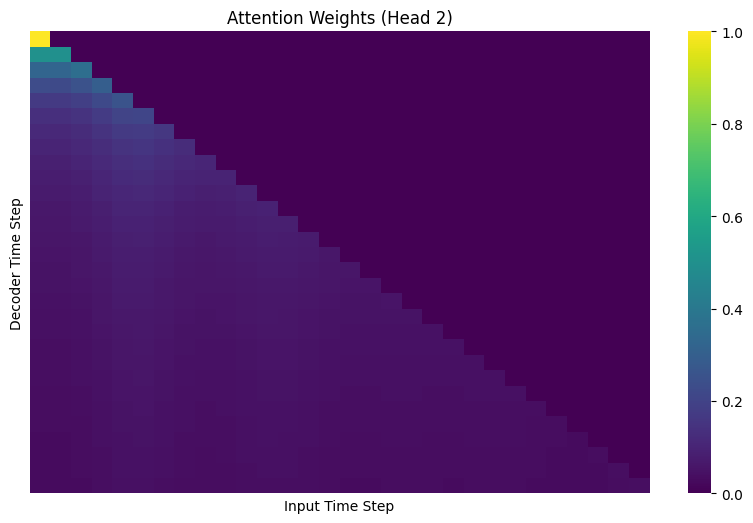

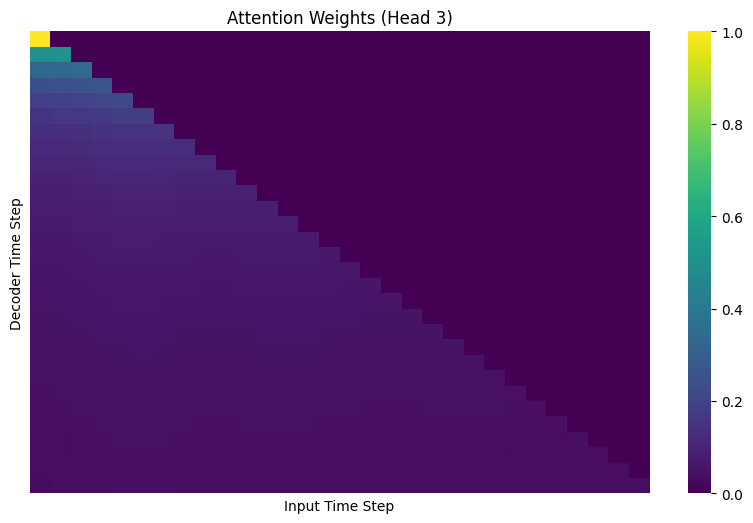

Epoch [29/70], Training Loss: 0.1591, Validation Loss: 0.8037


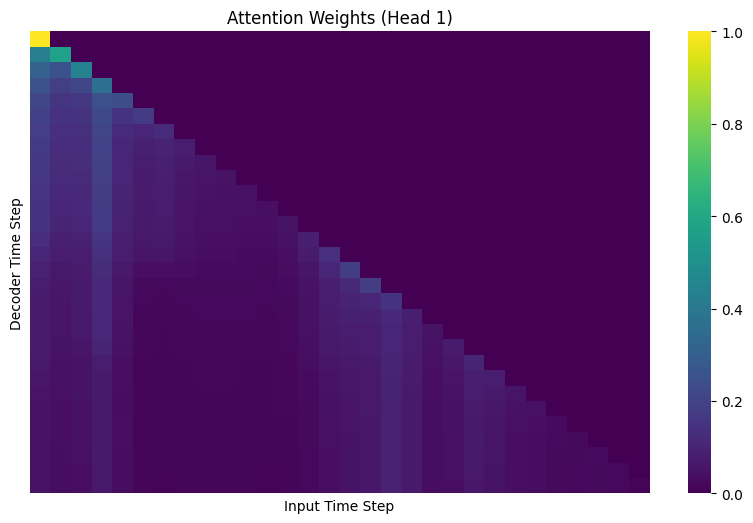

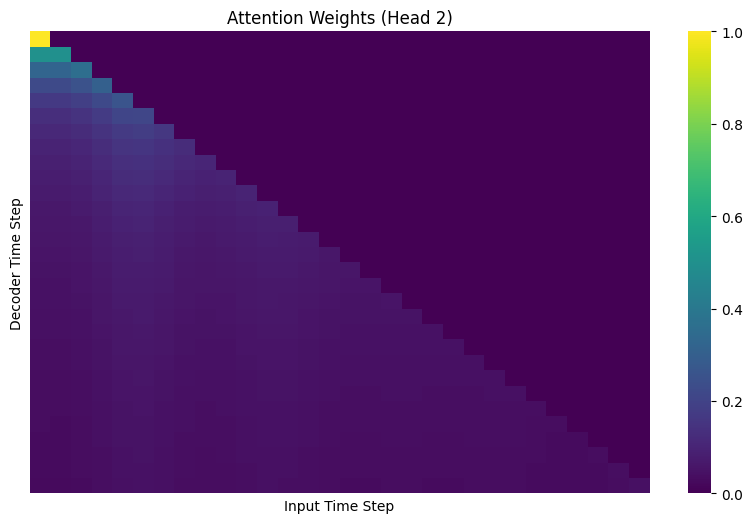

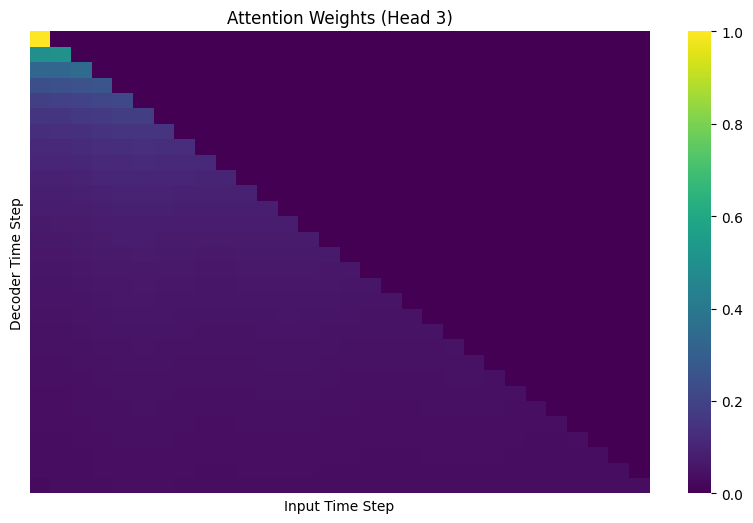

Epoch [30/70], Training Loss: 0.1154, Validation Loss: 0.0538


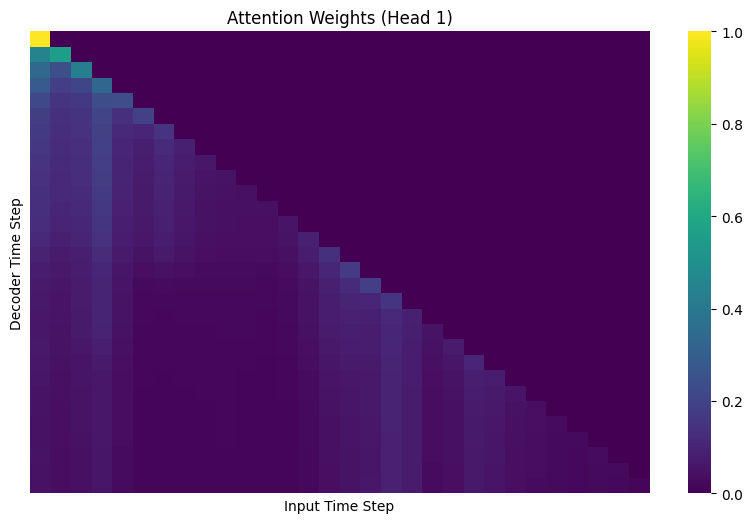

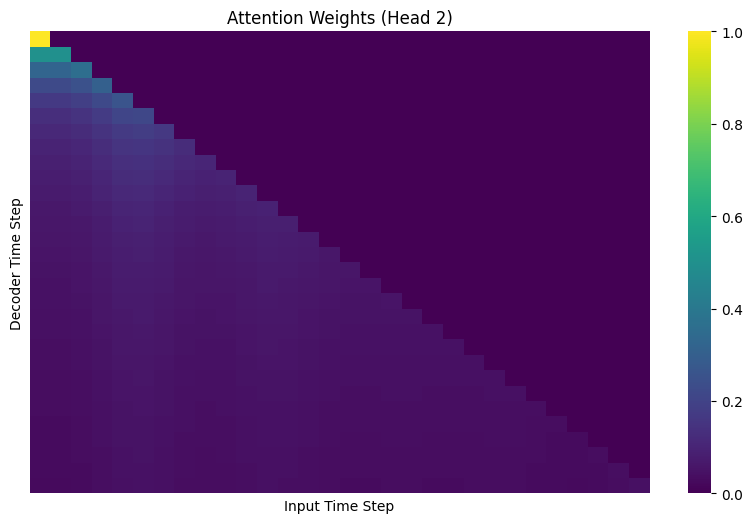

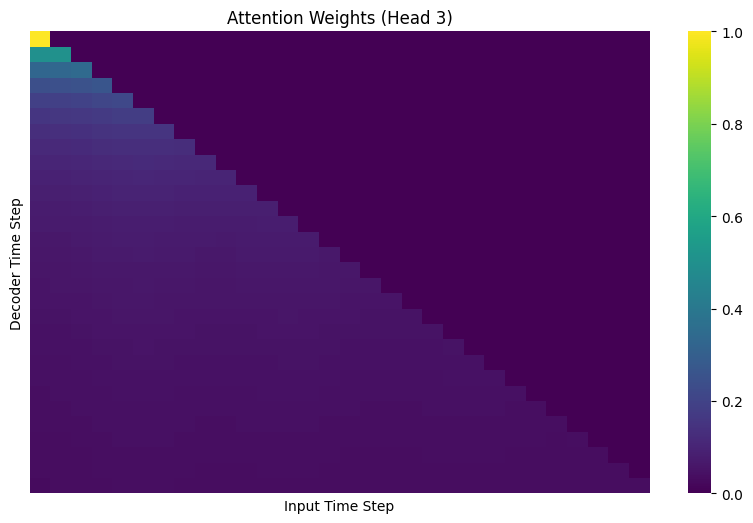

Epoch [31/70], Training Loss: 0.0787, Validation Loss: 0.2362


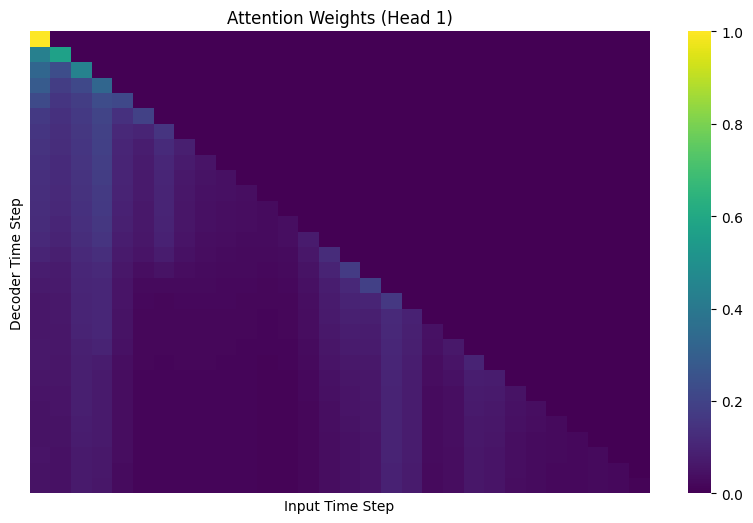

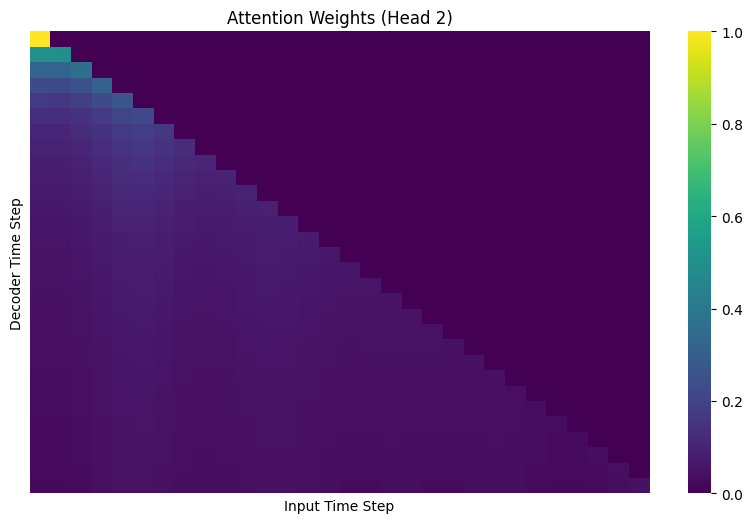

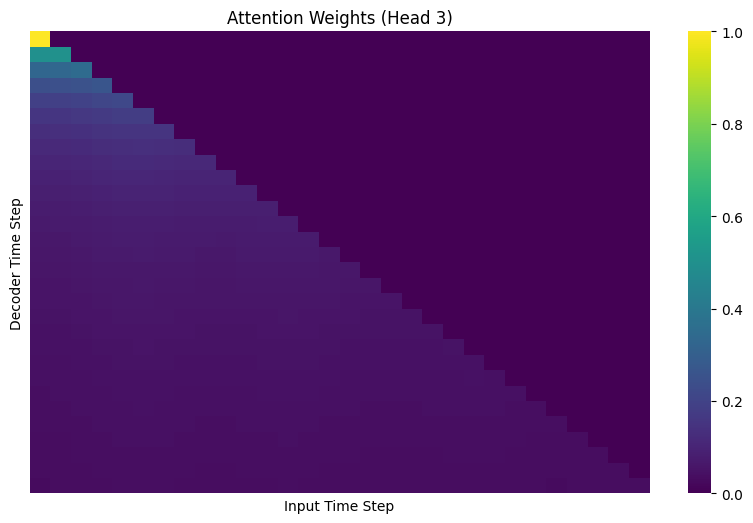

Epoch [32/70], Training Loss: 0.0692, Validation Loss: 0.0522


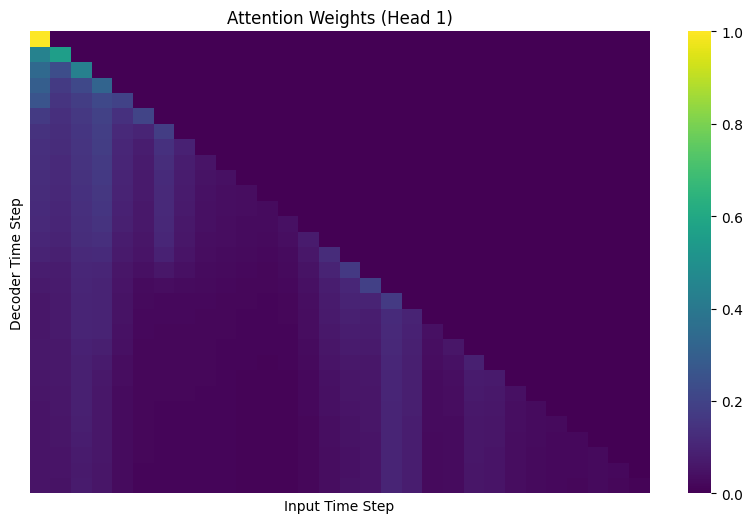

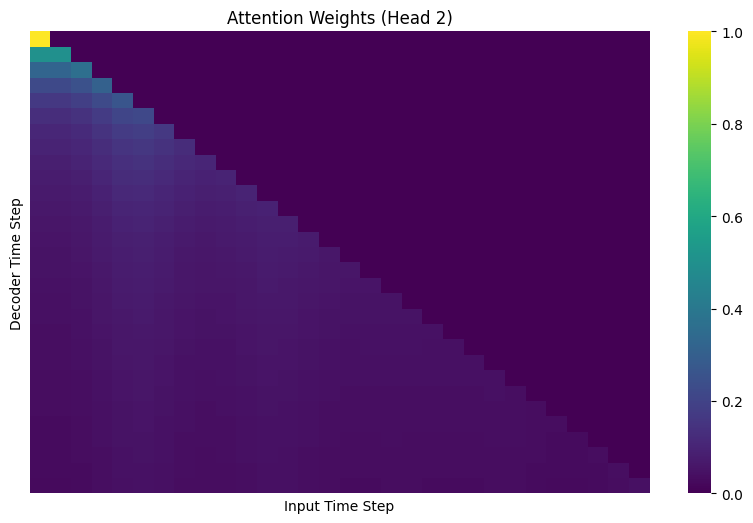

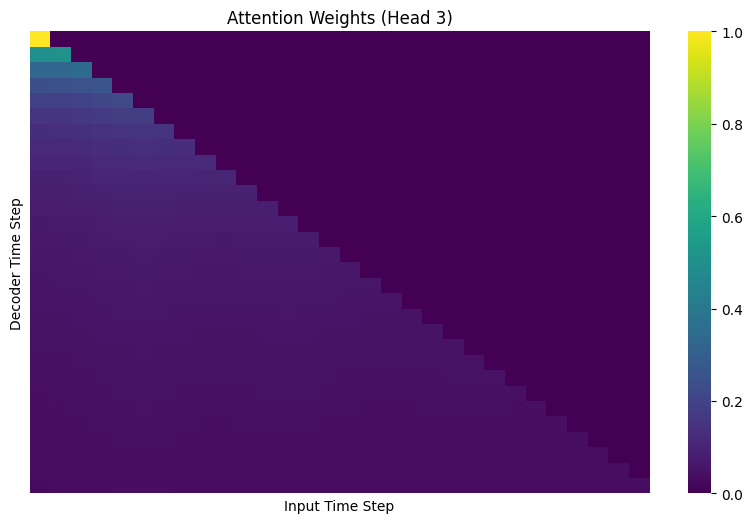

Epoch [33/70], Training Loss: 0.0653, Validation Loss: 0.0631


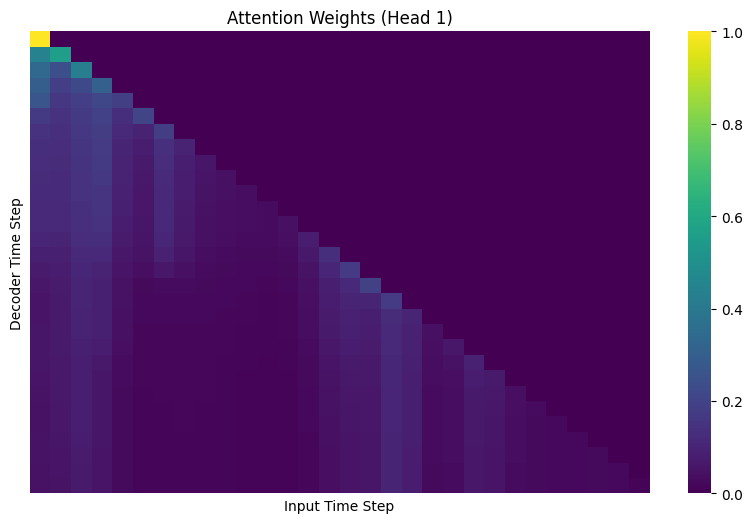

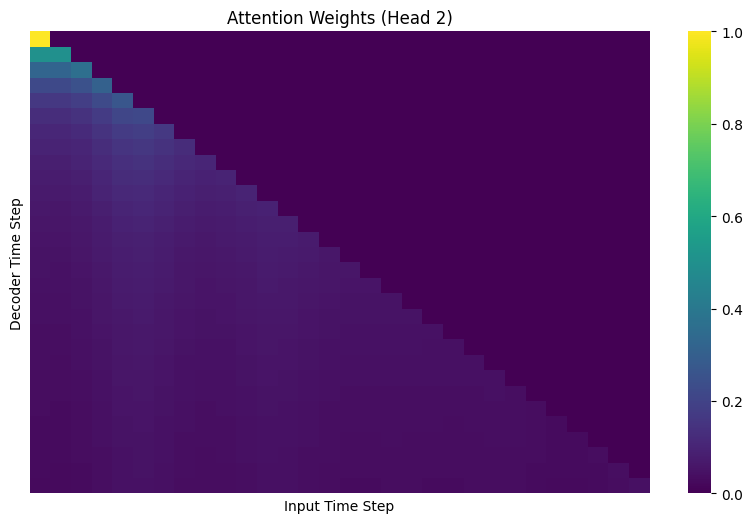

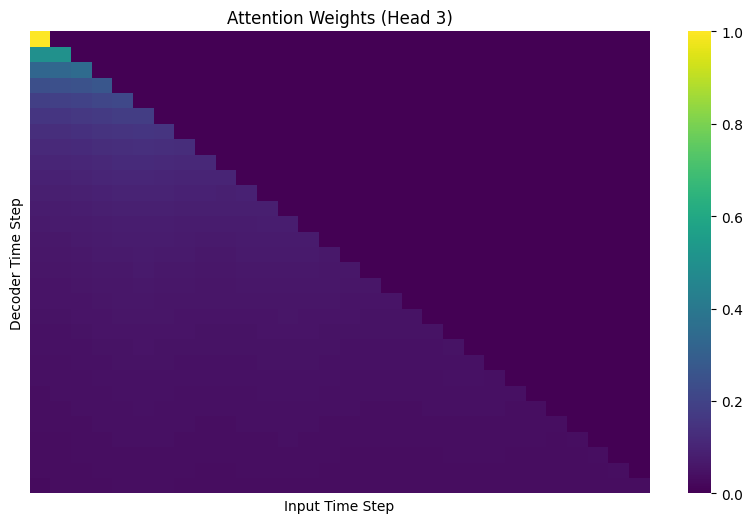

Epoch [34/70], Training Loss: 0.0943, Validation Loss: 0.0201
Saved new best model with Validation Loss: 0.0201


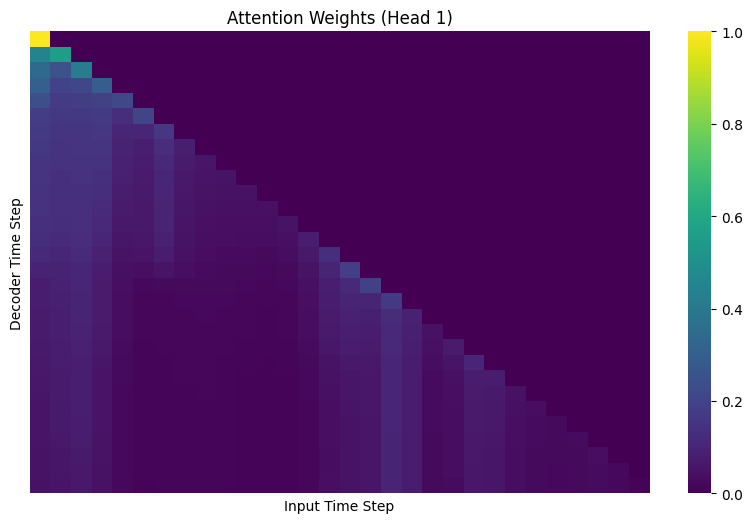

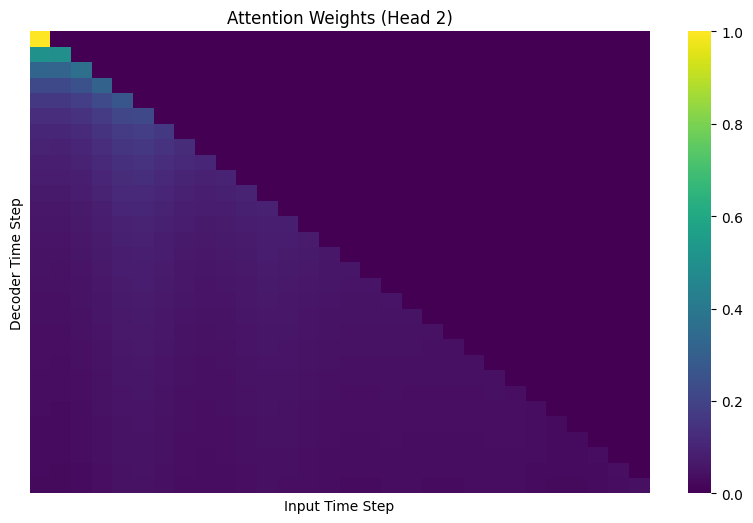

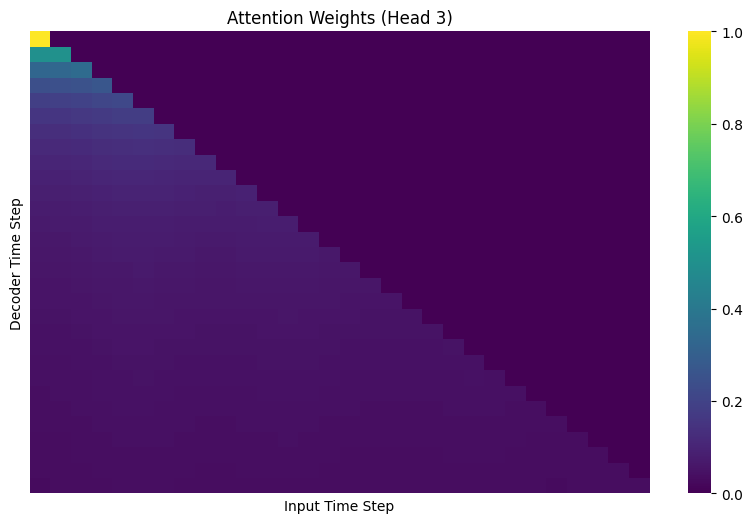

Epoch [35/70], Training Loss: 0.0685, Validation Loss: 0.0265


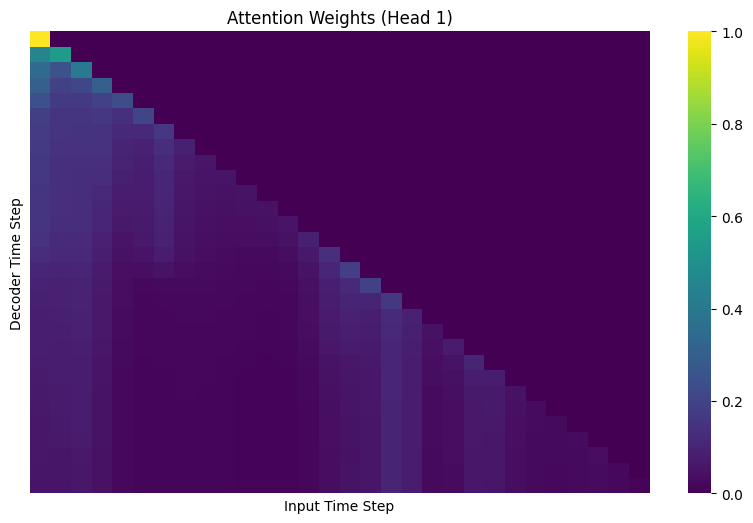

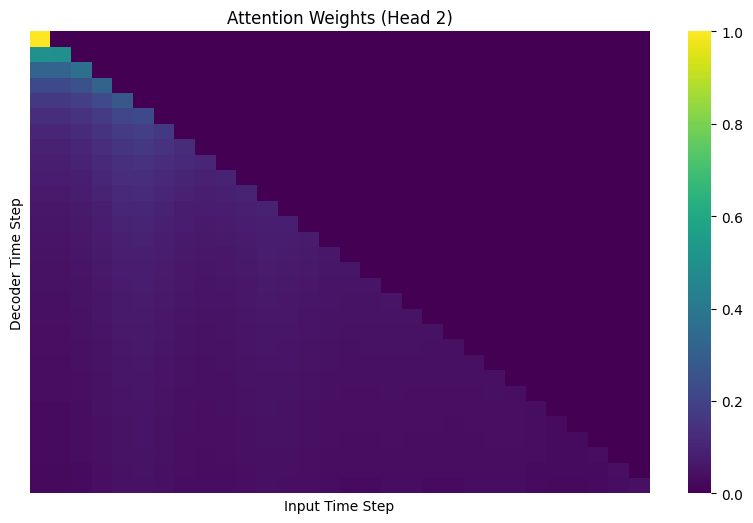

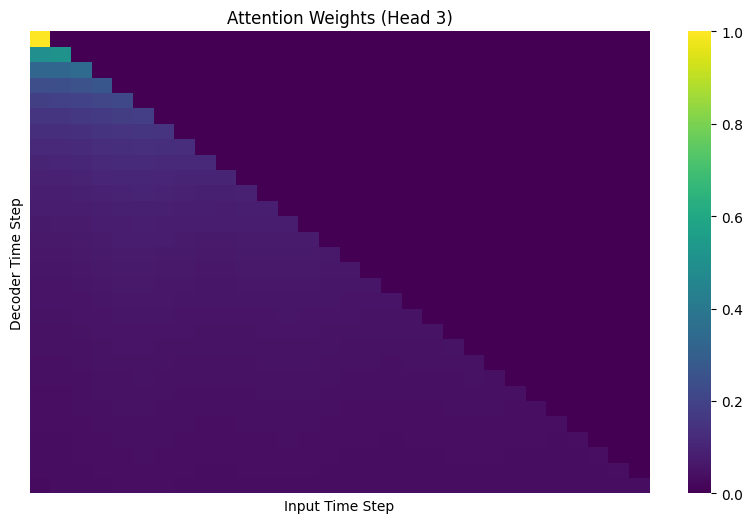

Epoch [36/70], Training Loss: 0.0479, Validation Loss: 0.0454


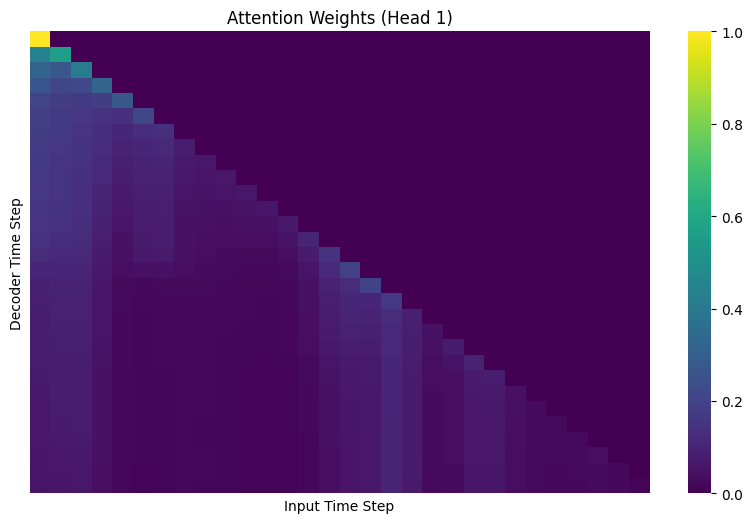

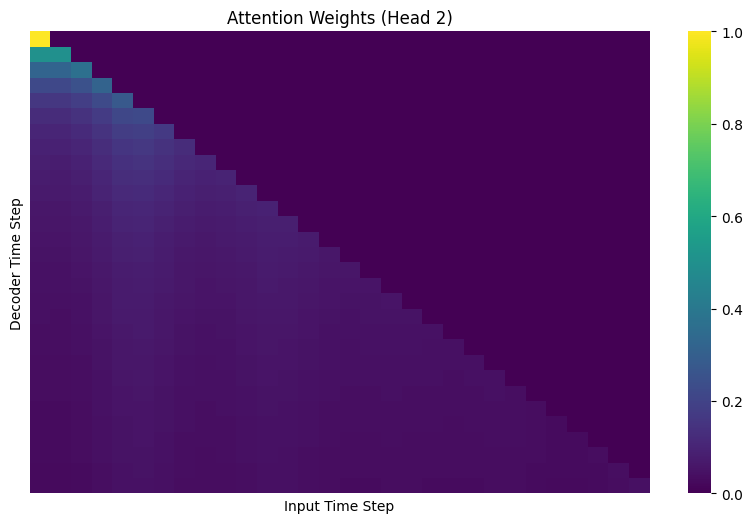

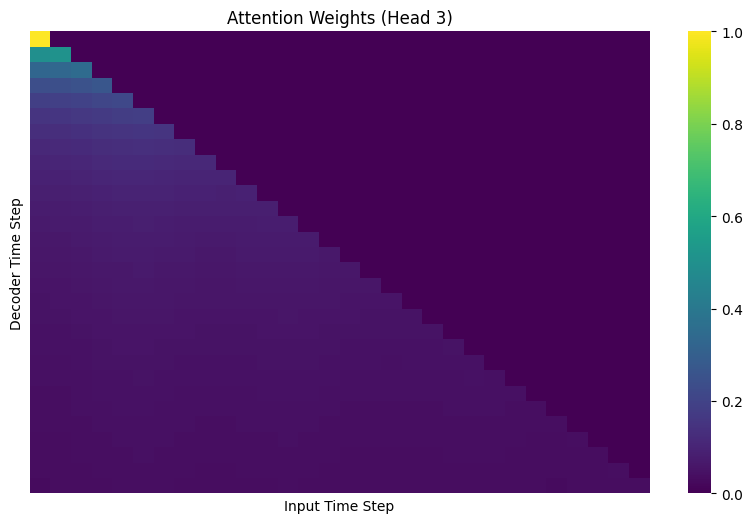

Epoch [37/70], Training Loss: 0.0619, Validation Loss: 0.0623


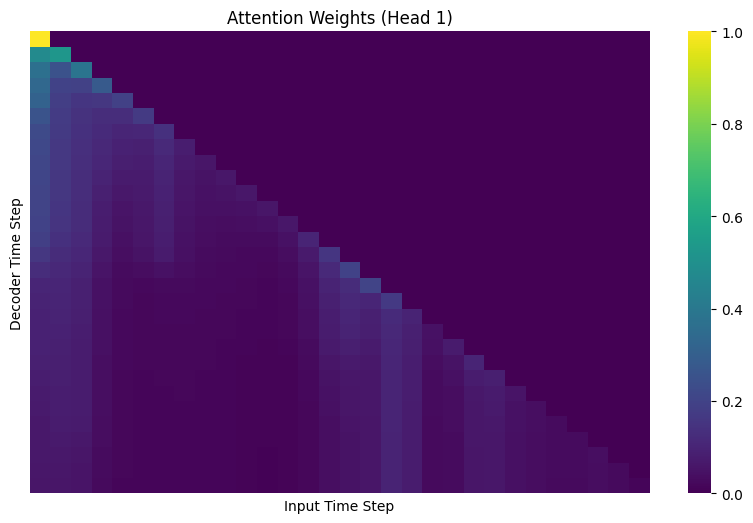

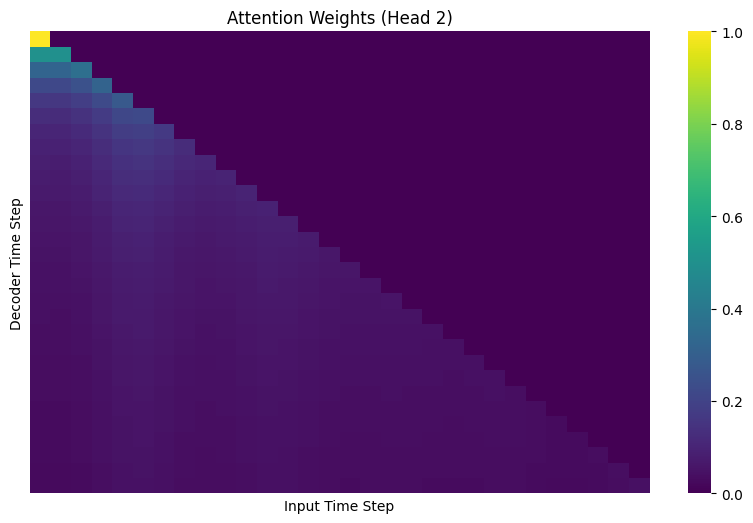

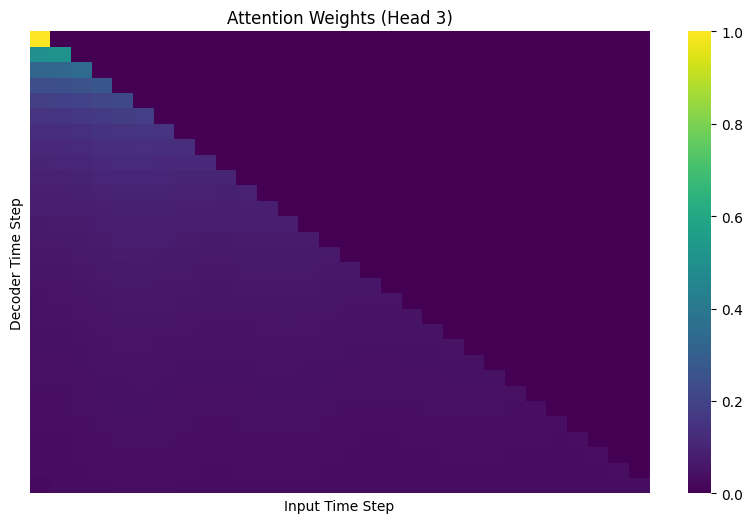

Epoch [38/70], Training Loss: 0.1203, Validation Loss: 0.0326


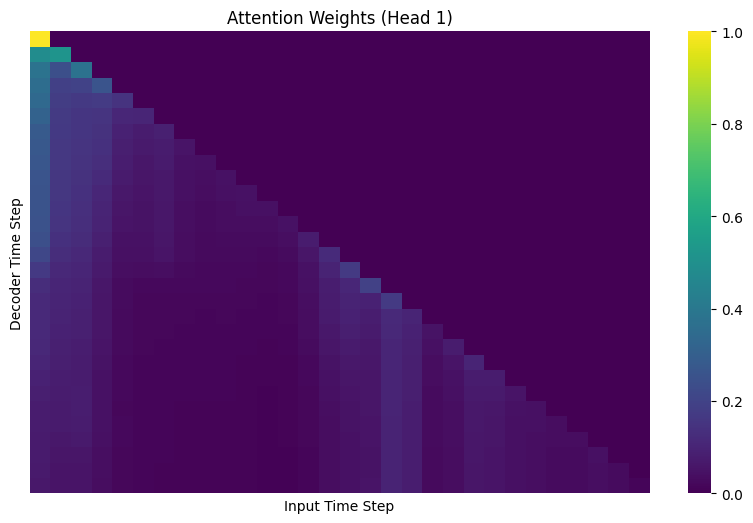

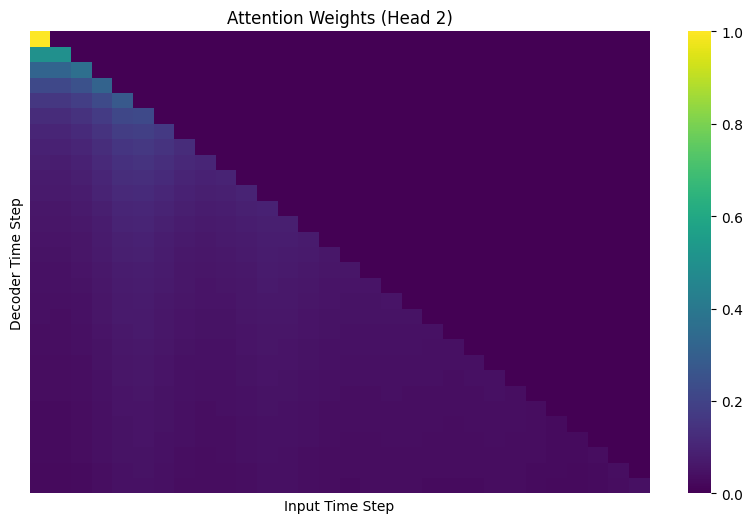

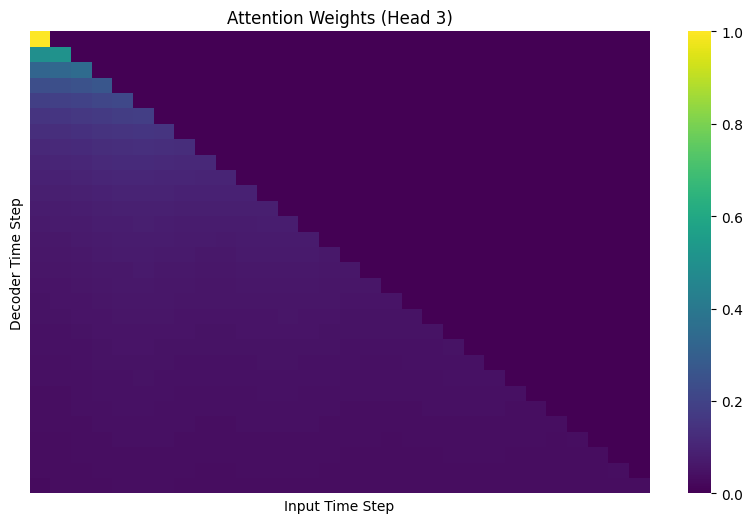

Epoch [39/70], Training Loss: 0.0438, Validation Loss: 0.0259


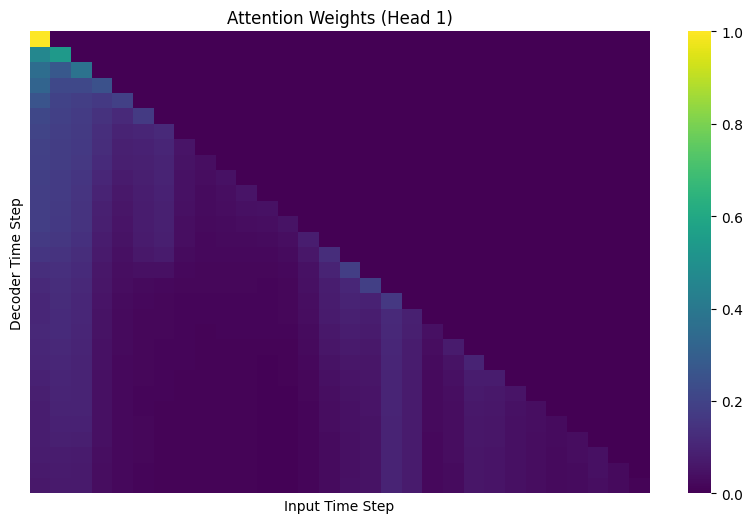

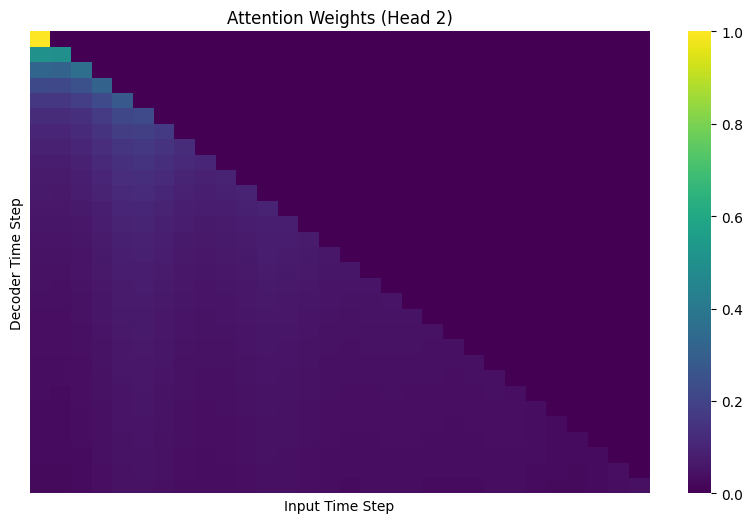

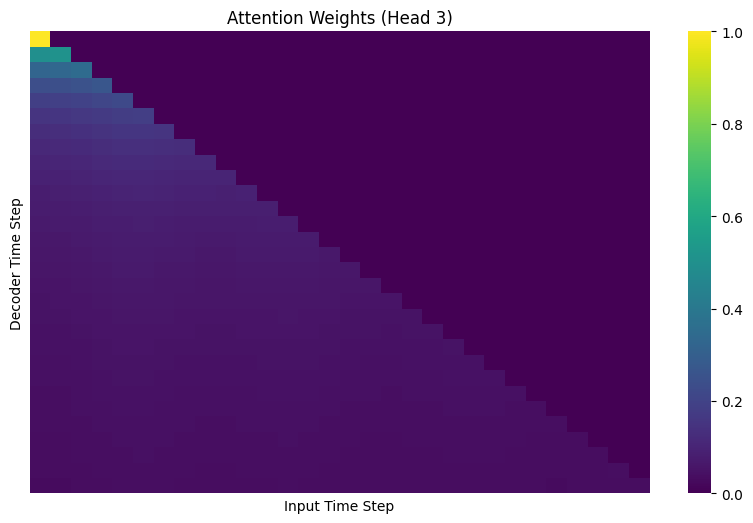

Epoch [40/70], Training Loss: 0.0606, Validation Loss: 0.1123


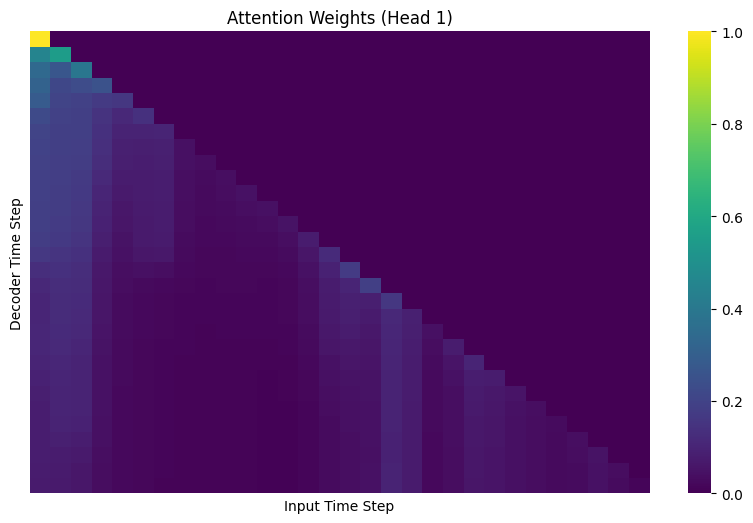

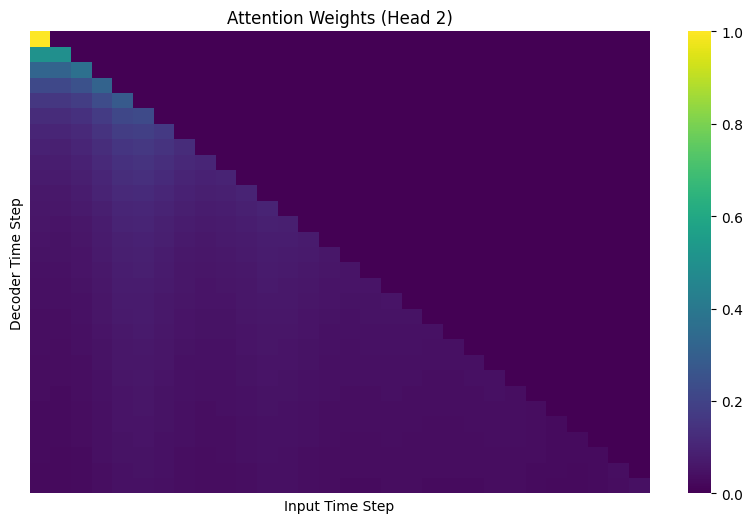

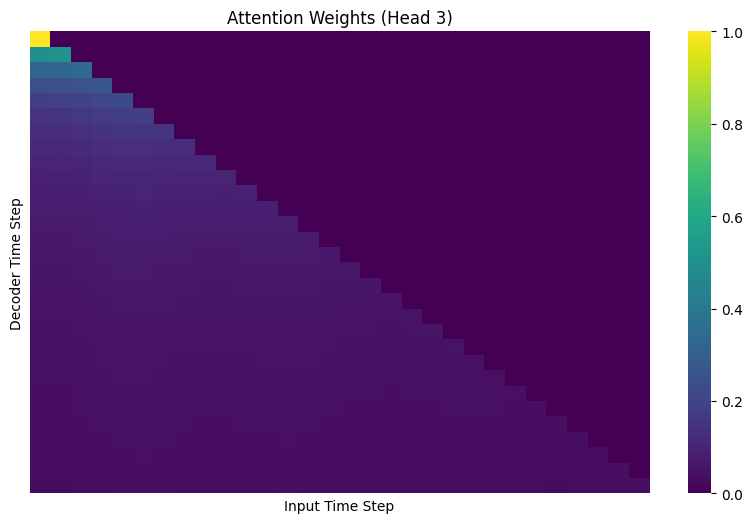

Epoch [41/70], Training Loss: 0.0580, Validation Loss: 0.0330


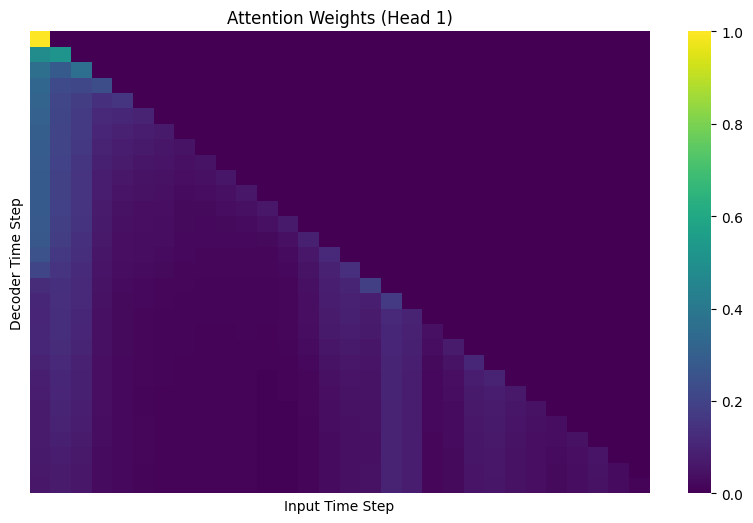

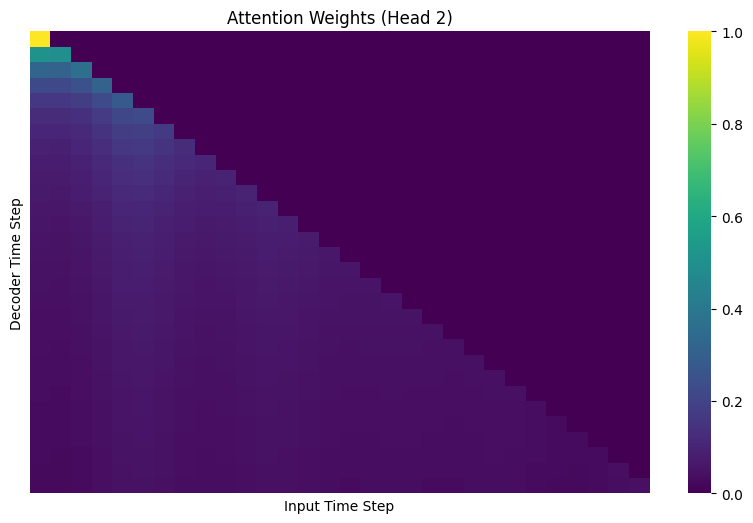

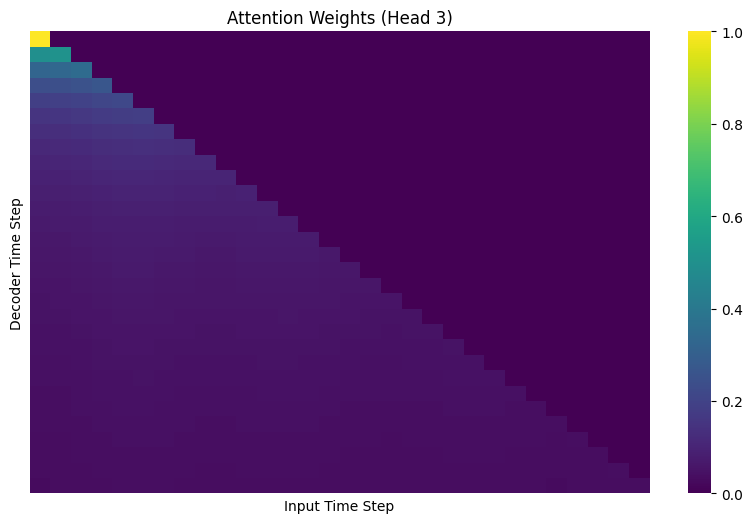

Epoch [42/70], Training Loss: 0.0452, Validation Loss: 0.0328


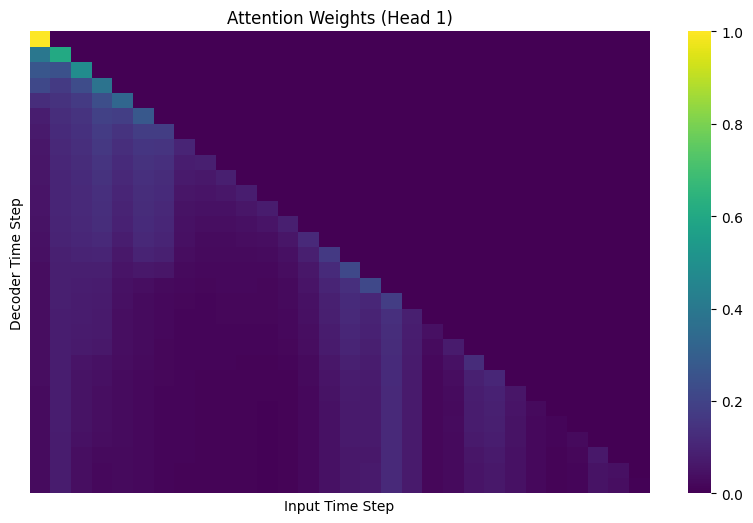

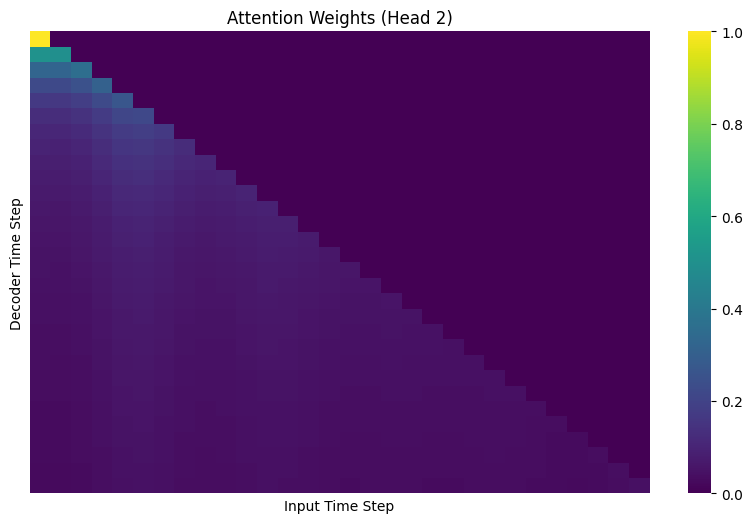

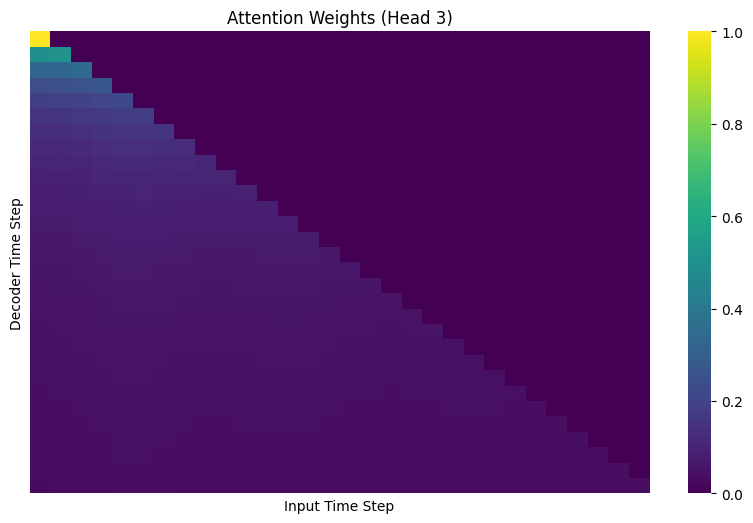

Epoch [43/70], Training Loss: 0.2125, Validation Loss: 0.0529


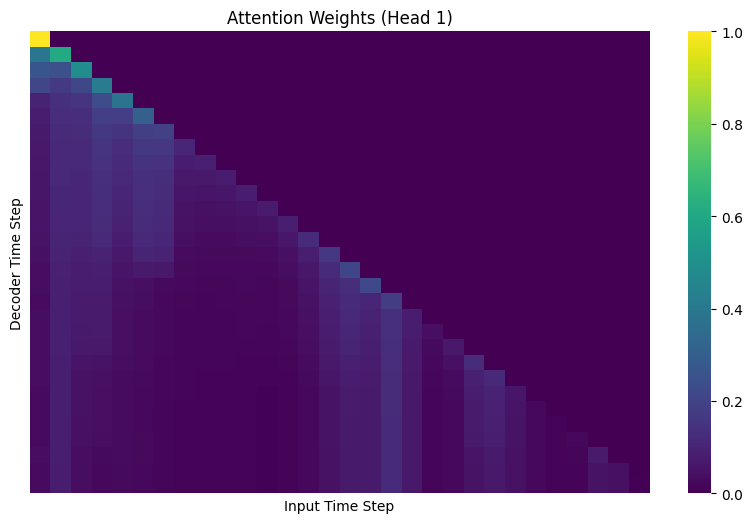

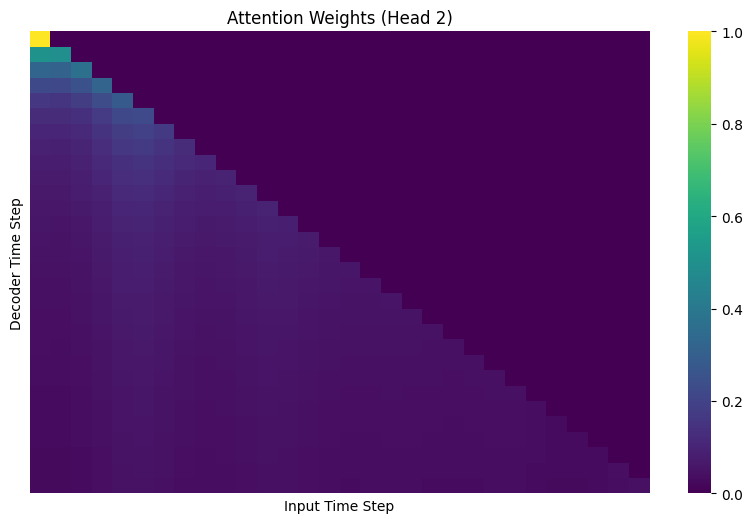

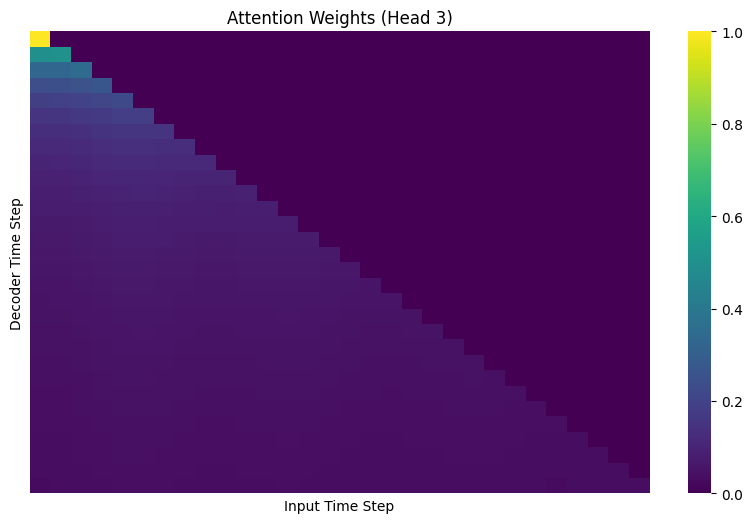

Epoch [44/70], Training Loss: 0.0460, Validation Loss: 0.0569


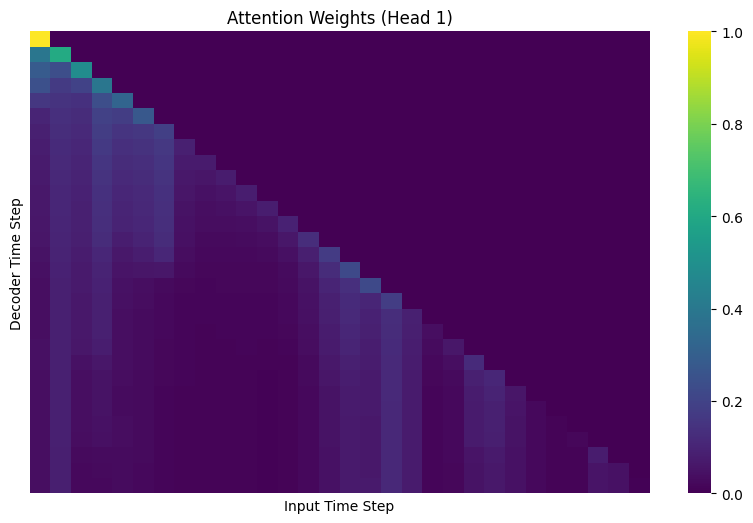

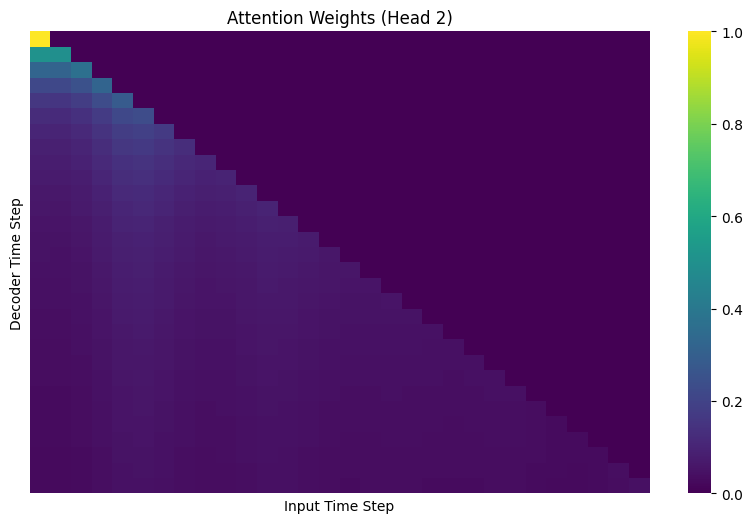

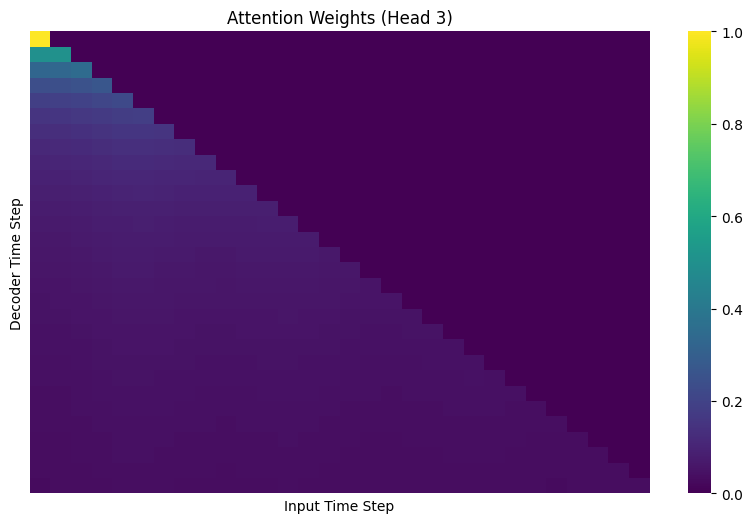

Epoch [45/70], Training Loss: 0.0345, Validation Loss: 0.0358


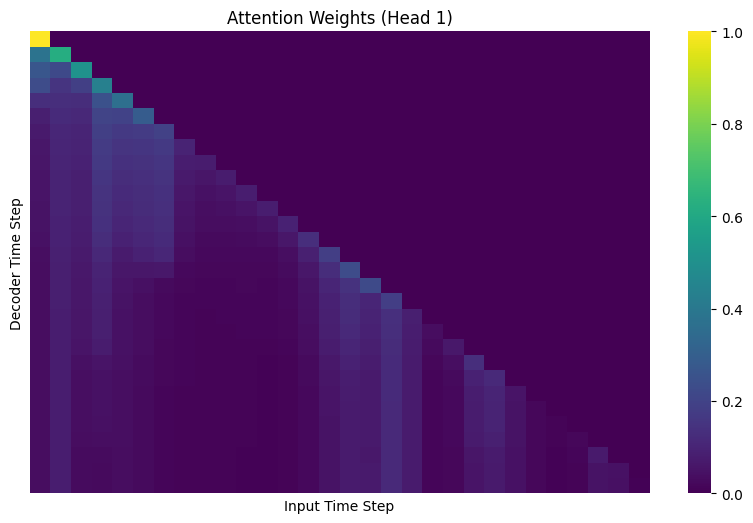

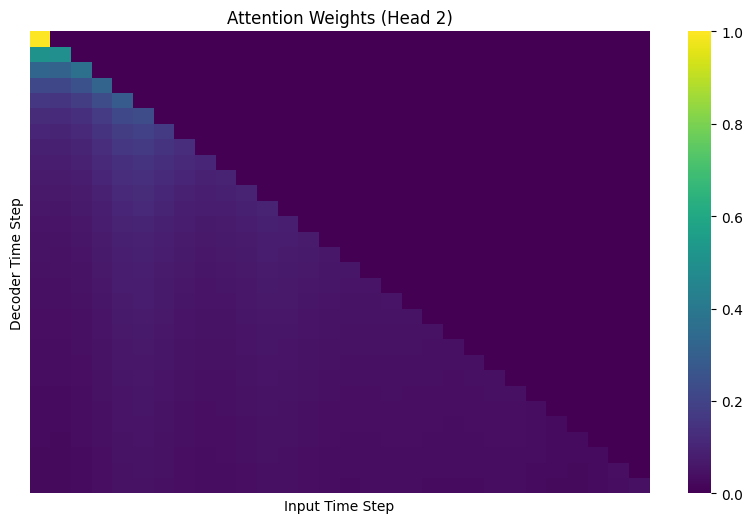

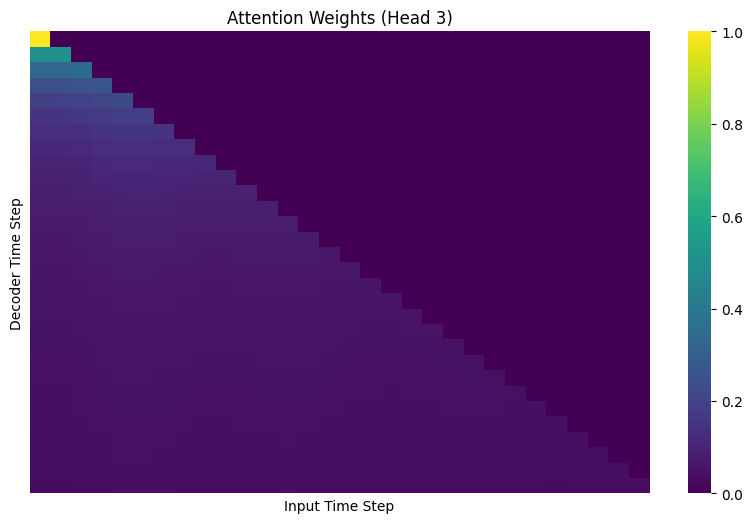

Epoch [46/70], Training Loss: 0.0336, Validation Loss: 0.0367


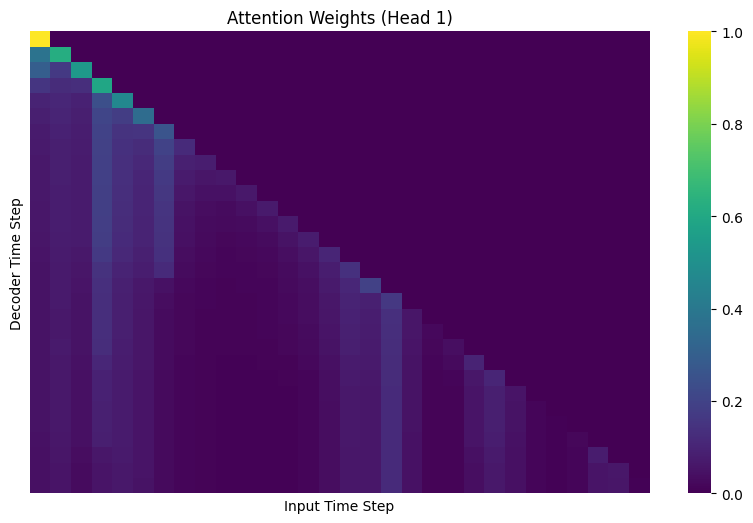

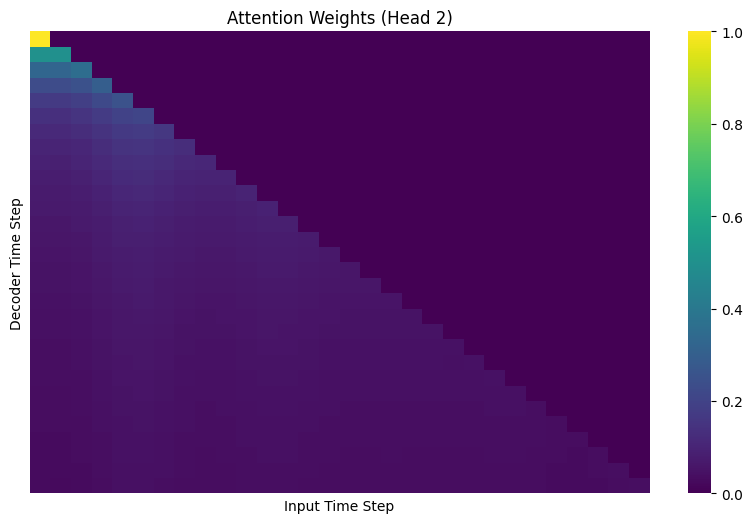

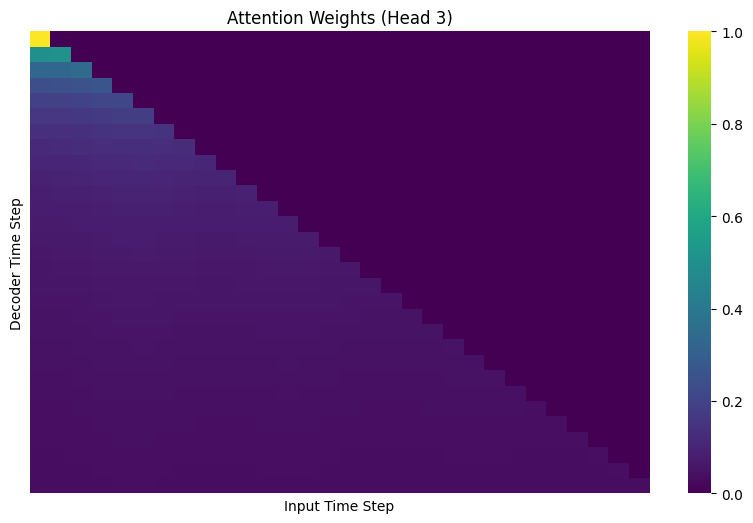

Epoch [47/70], Training Loss: 0.2824, Validation Loss: 0.0449


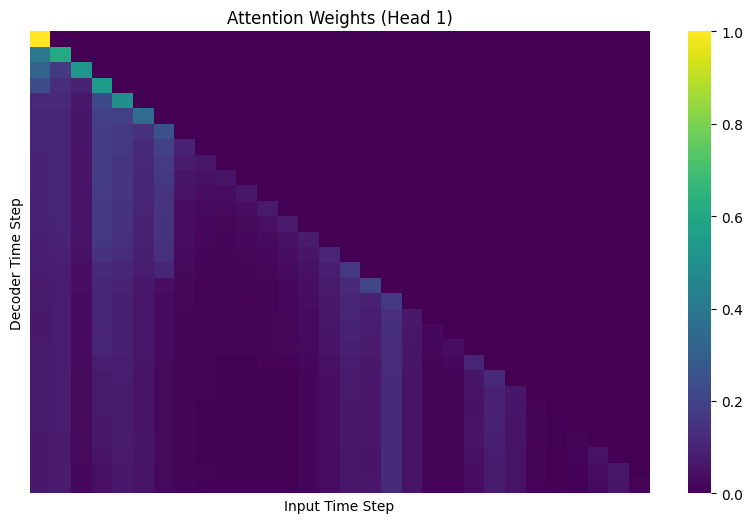

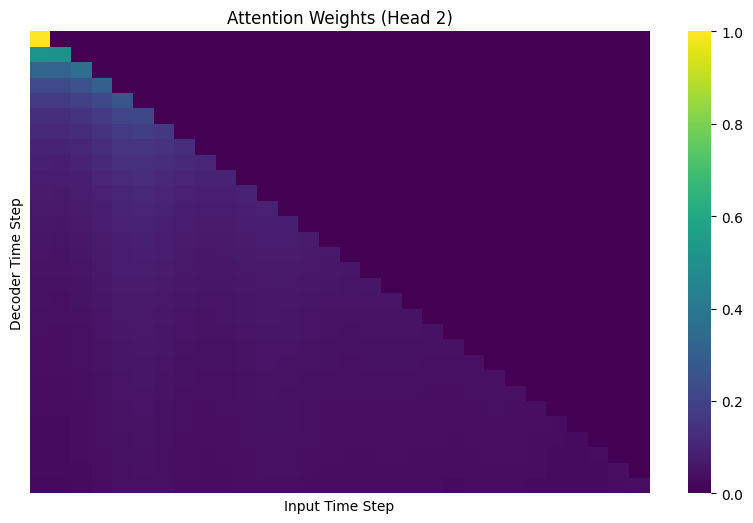

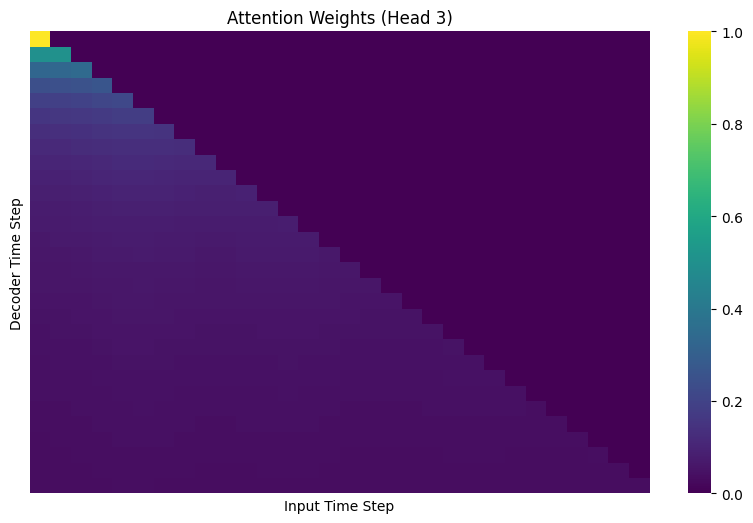

Epoch [48/70], Training Loss: 0.0770, Validation Loss: 0.0598


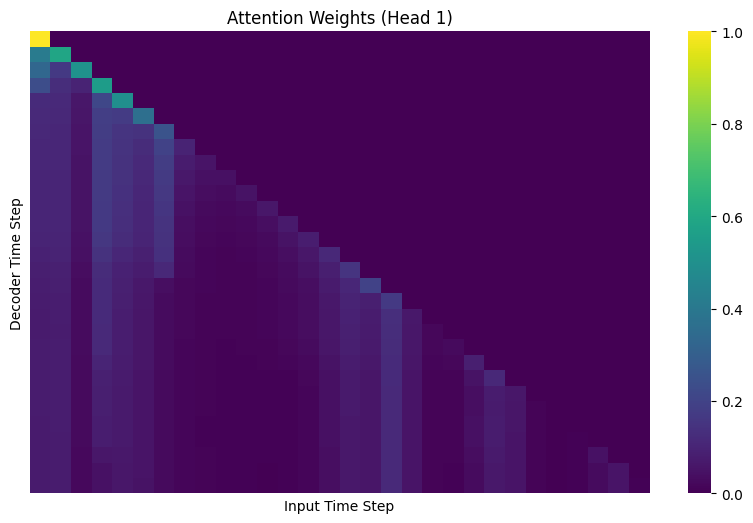

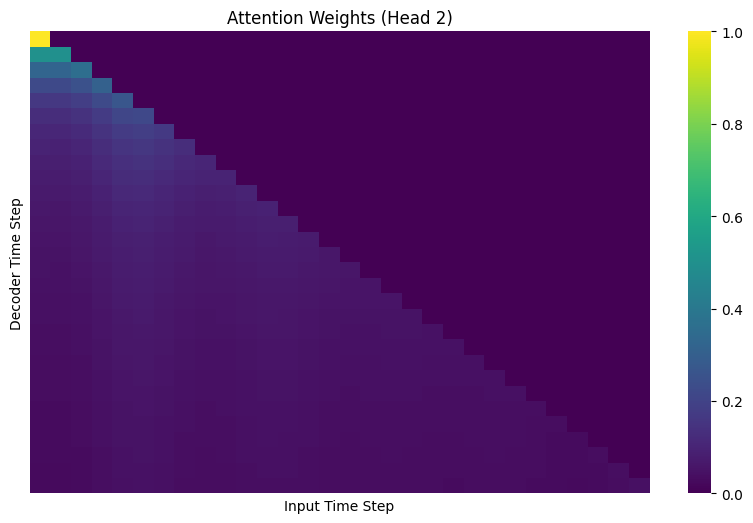

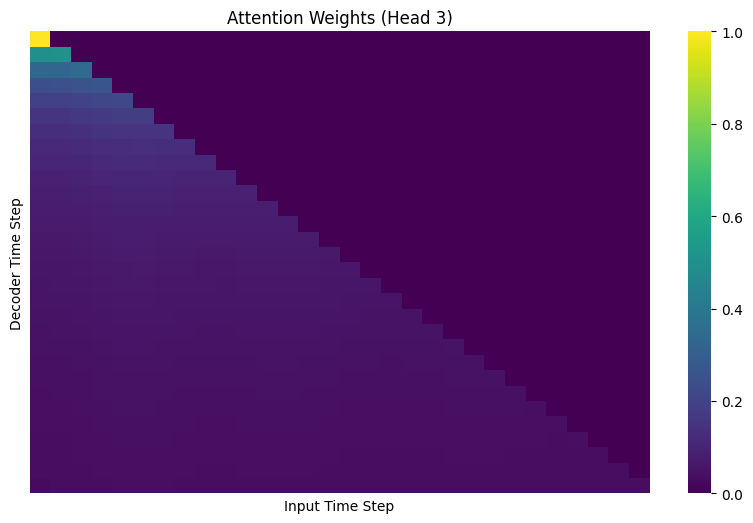

Epoch [49/70], Training Loss: 0.0382, Validation Loss: 0.1542


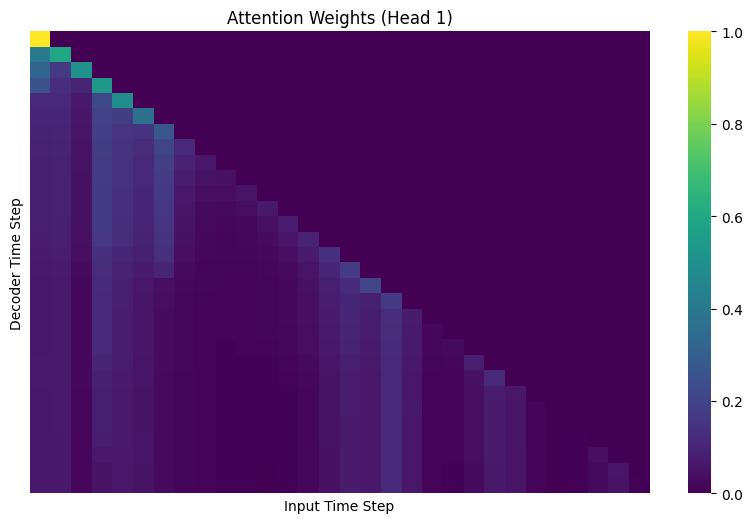

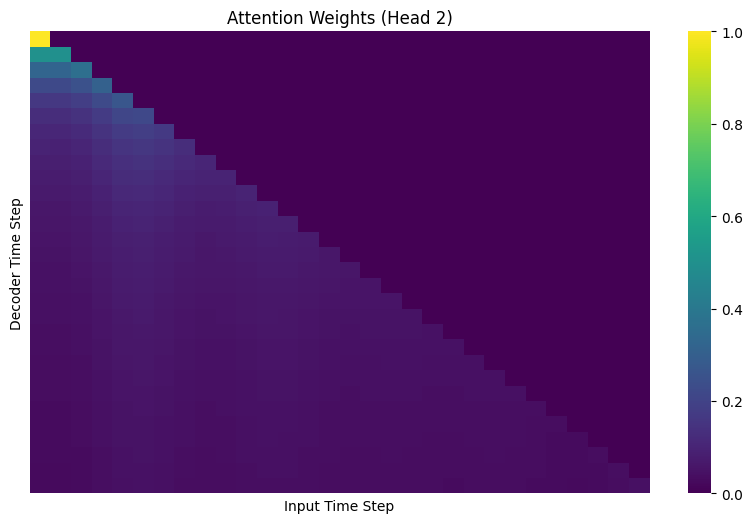

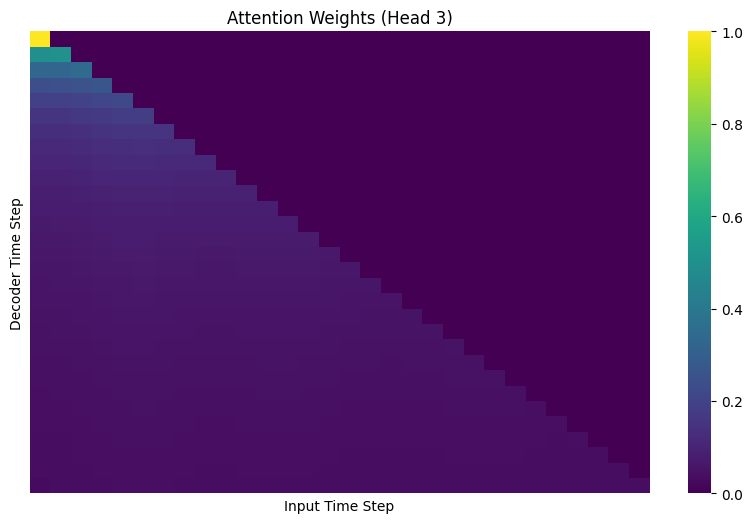

Epoch [50/70], Training Loss: 0.0369, Validation Loss: 0.1085


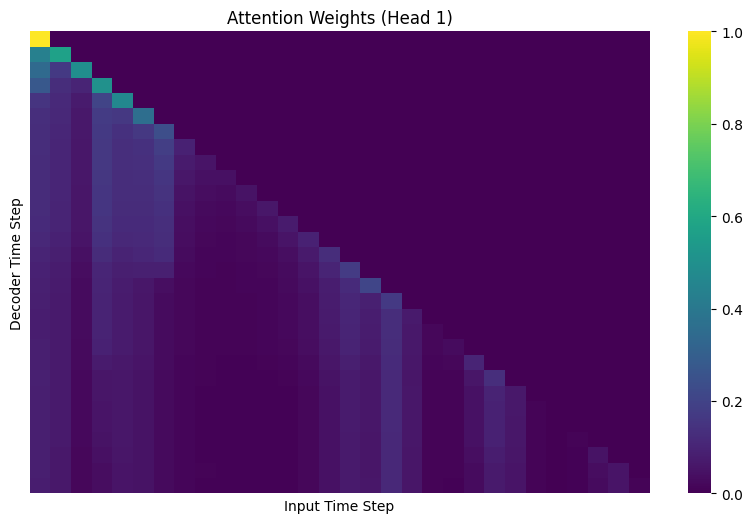

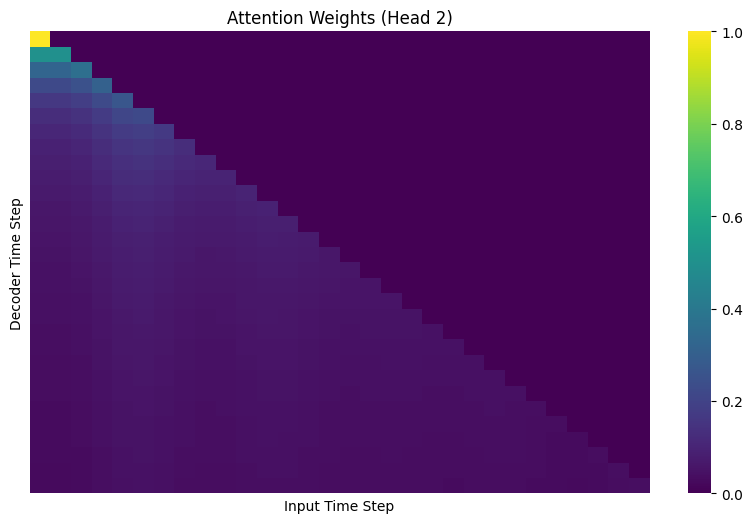

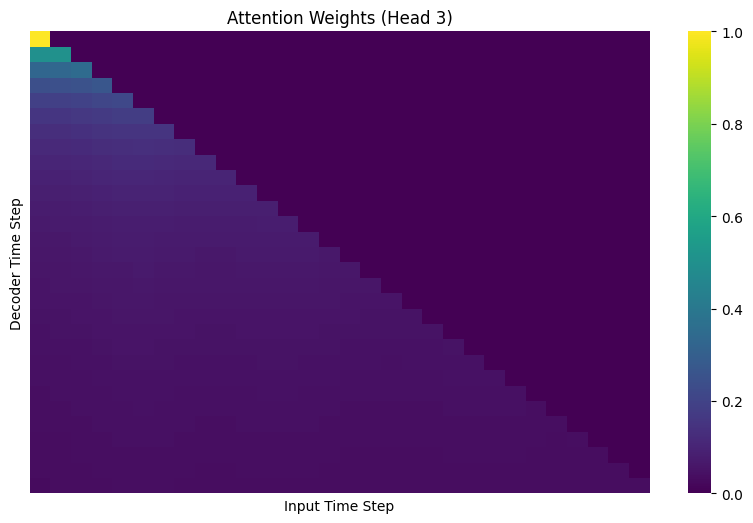

Epoch [51/70], Training Loss: 0.0440, Validation Loss: 0.0508


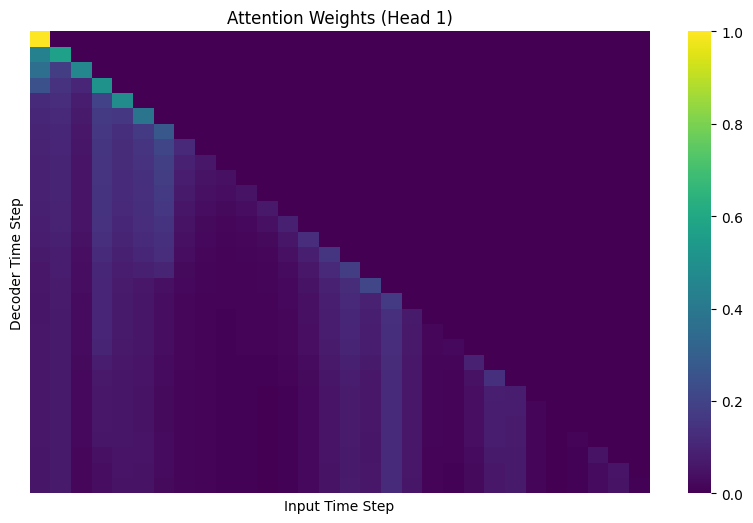

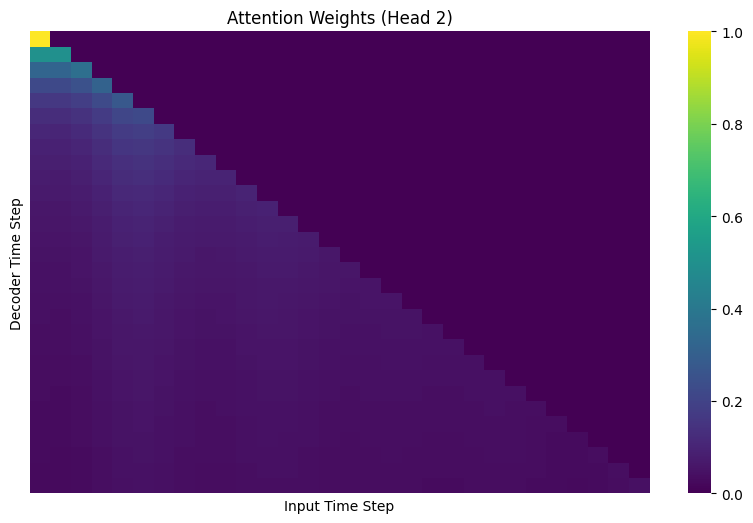

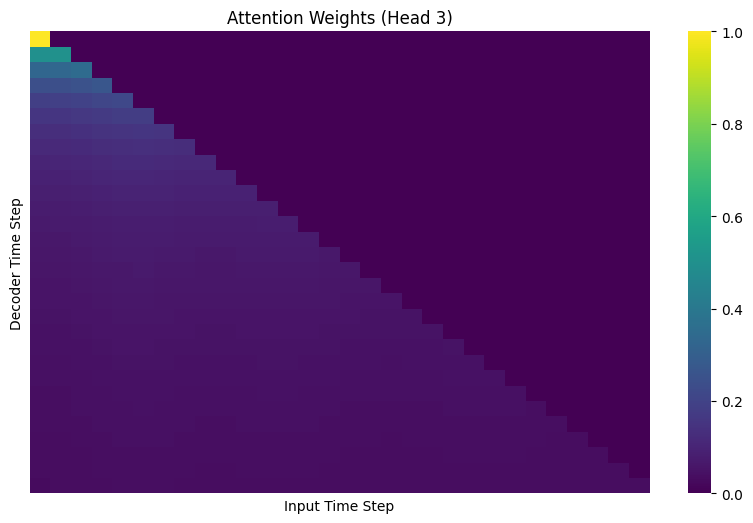

Epoch [52/70], Training Loss: 0.0405, Validation Loss: 0.0286


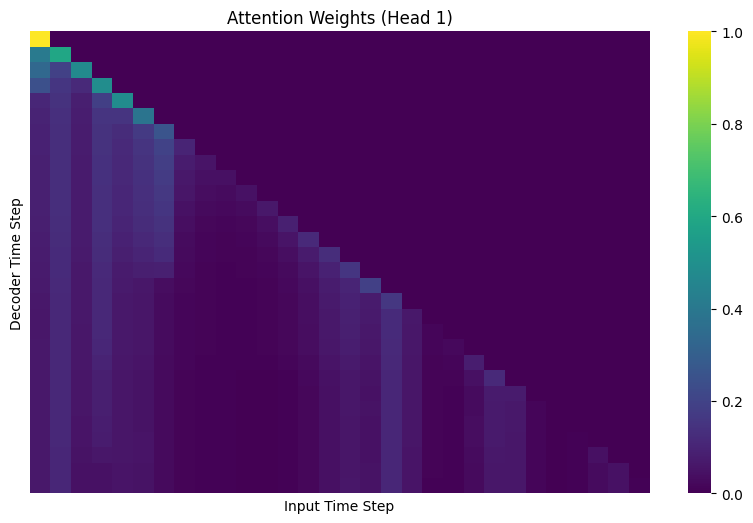

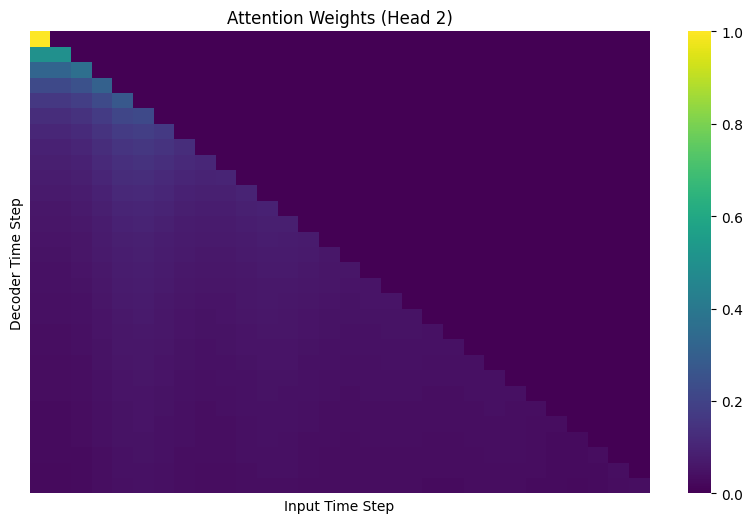

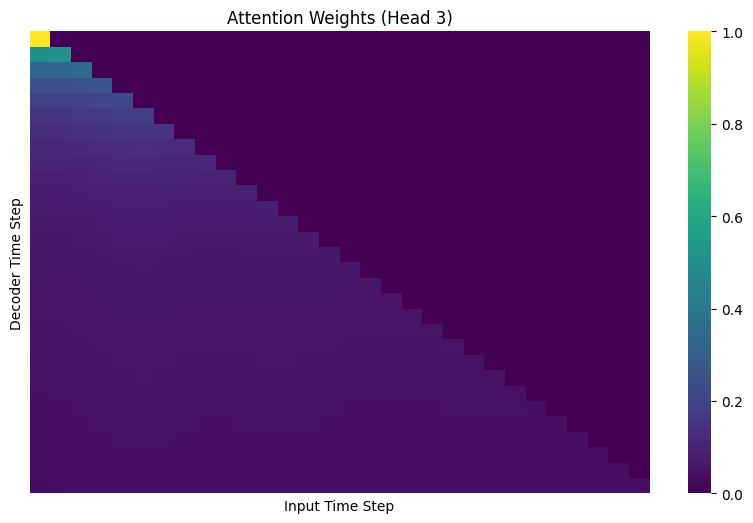

Epoch [53/70], Training Loss: 0.0437, Validation Loss: 0.0400


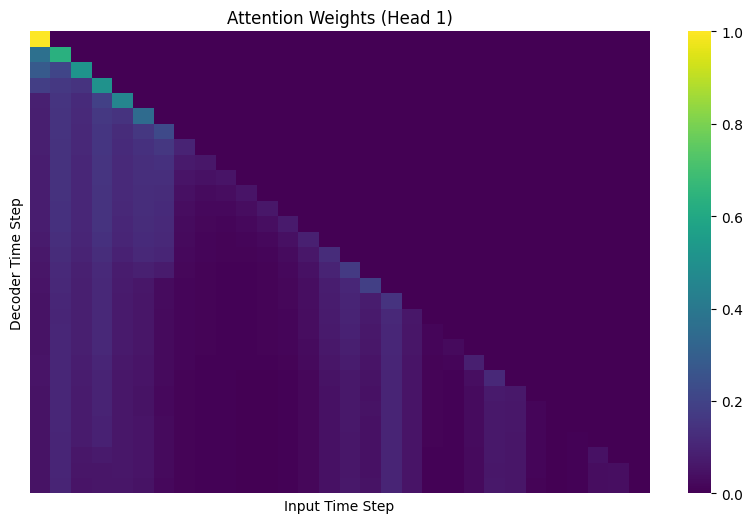

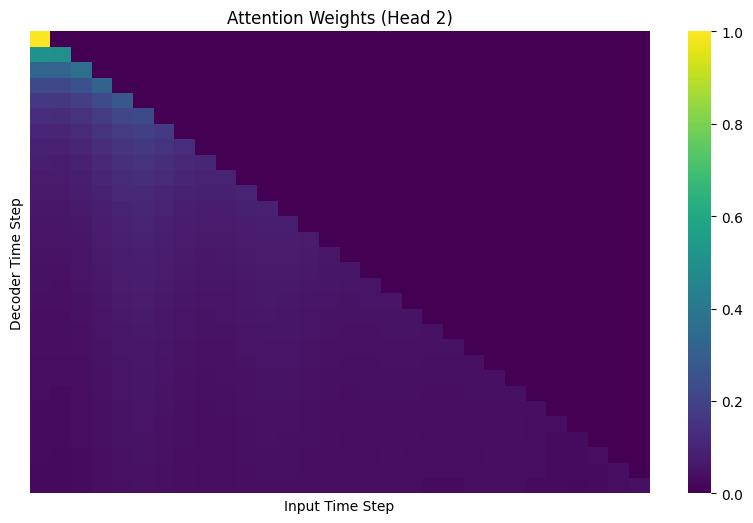

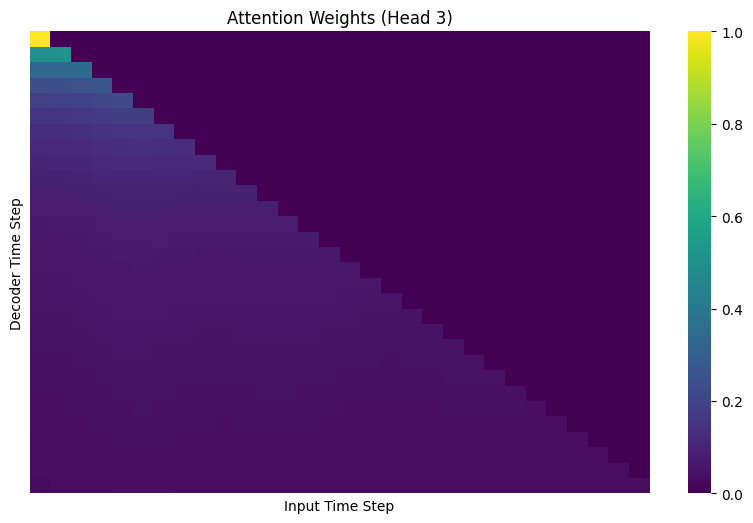

Epoch [54/70], Training Loss: 0.0404, Validation Loss: 0.0328


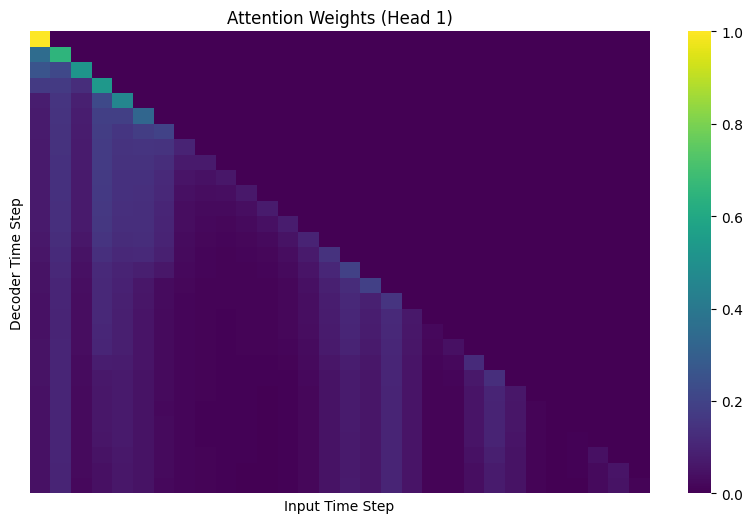

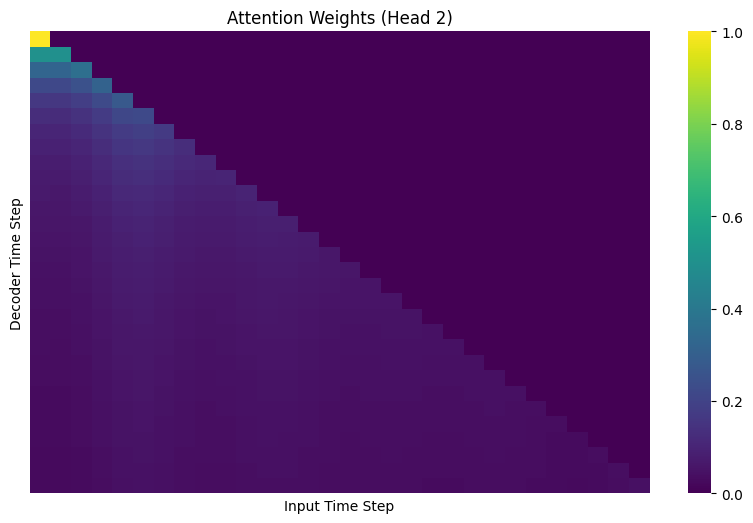

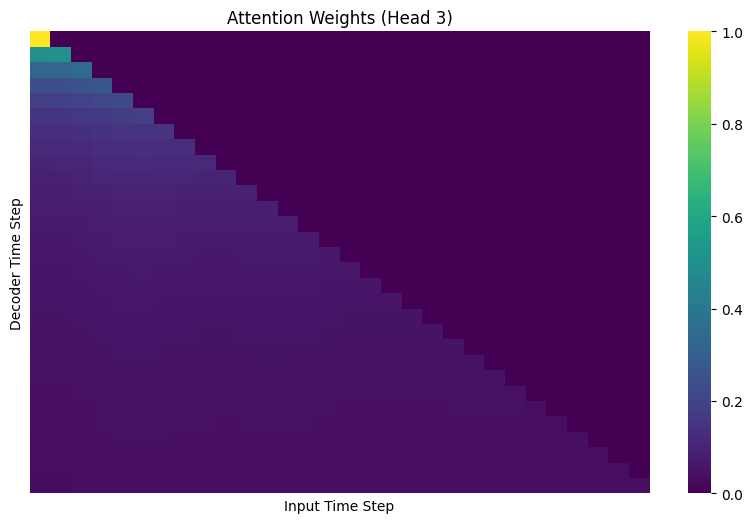

Epoch [55/70], Training Loss: 0.0445, Validation Loss: 0.0416


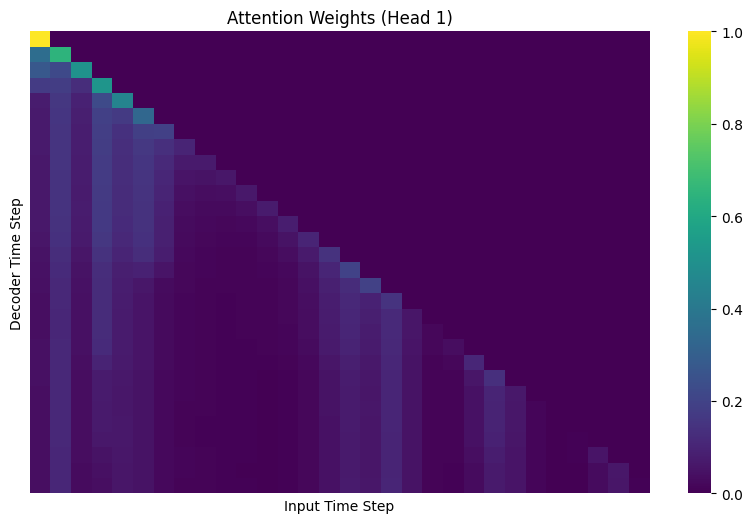

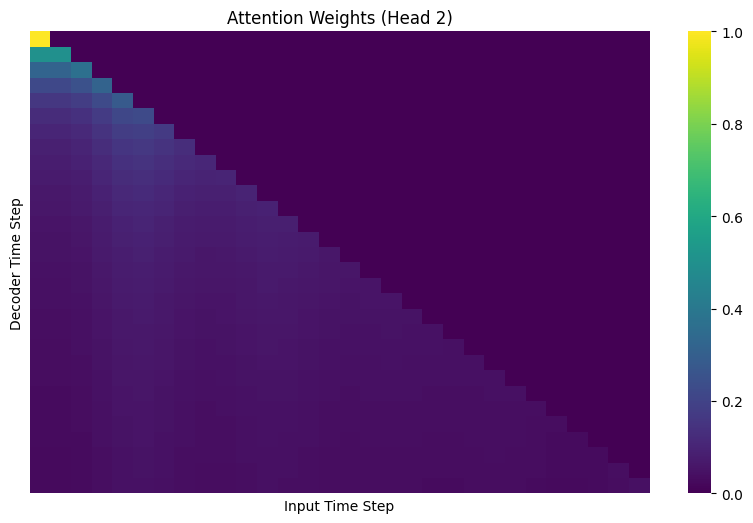

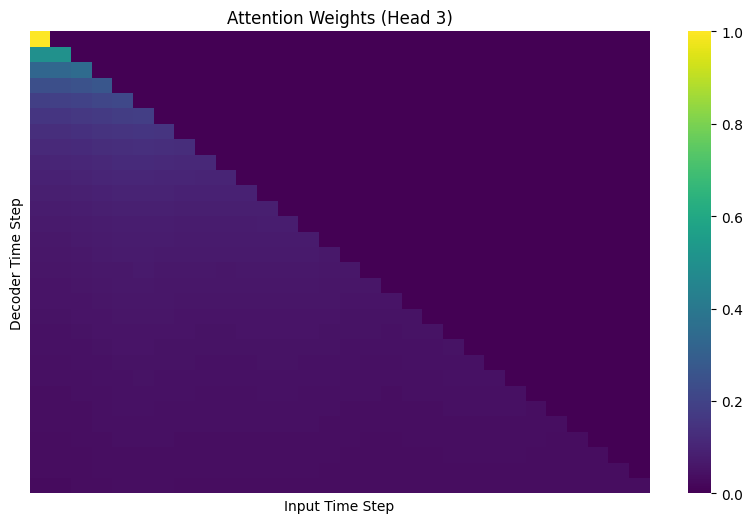

Epoch [56/70], Training Loss: 0.0303, Validation Loss: 0.0319


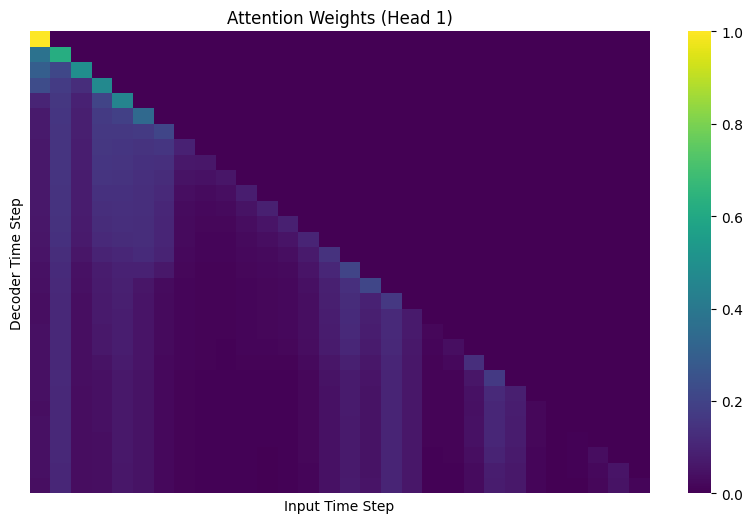

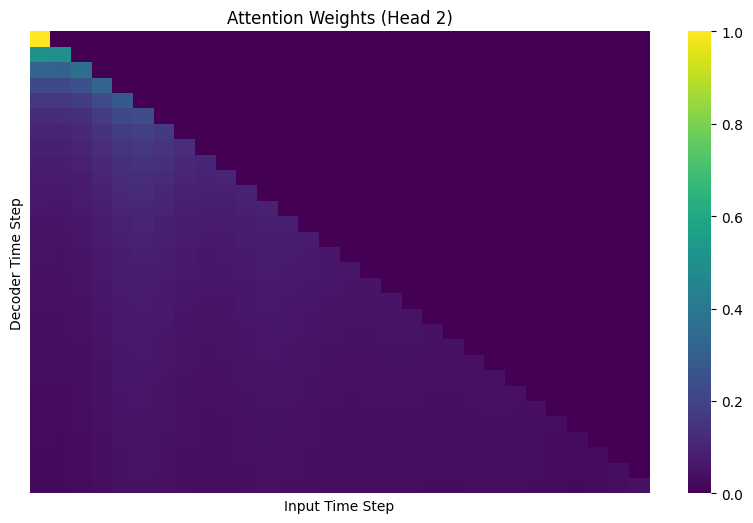

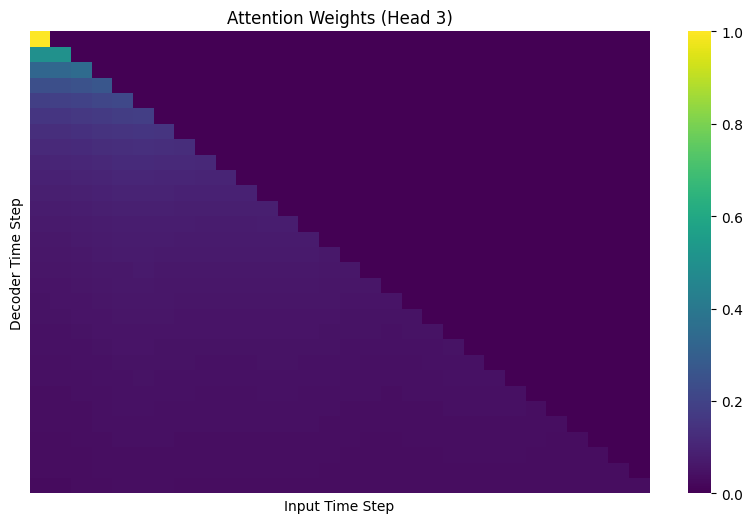

Epoch [57/70], Training Loss: 0.0339, Validation Loss: 0.0229


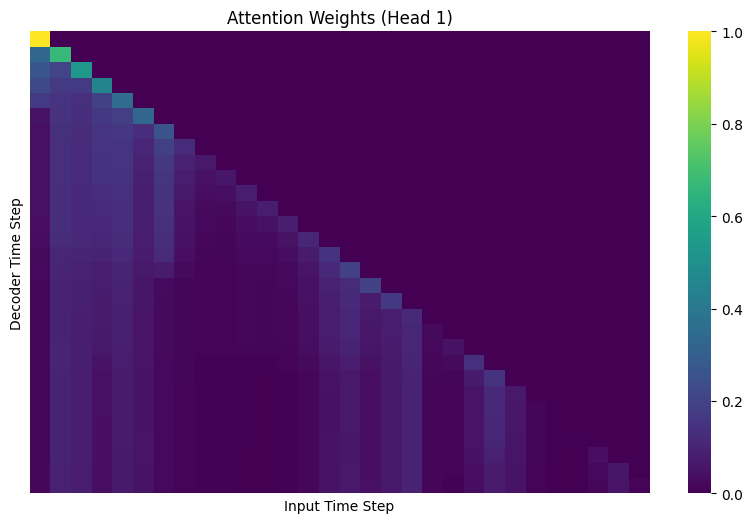

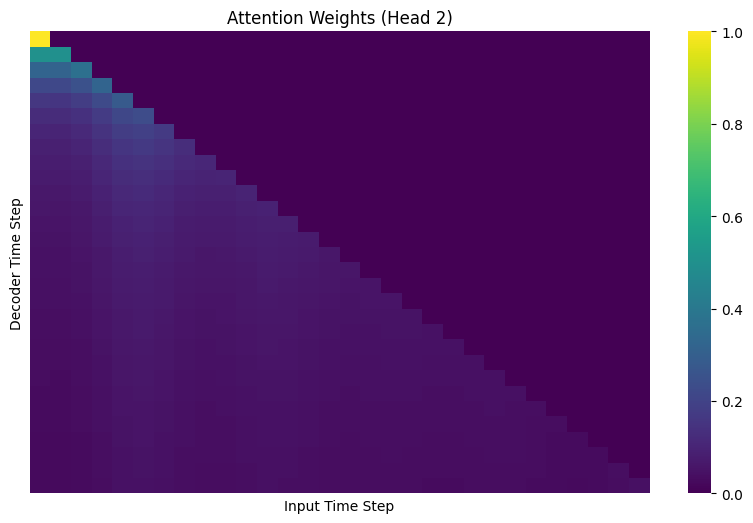

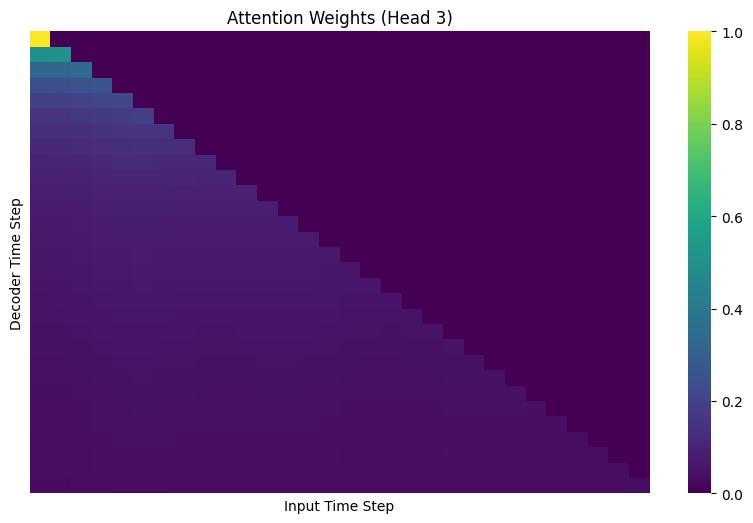

Epoch [58/70], Training Loss: 0.0403, Validation Loss: 0.0290


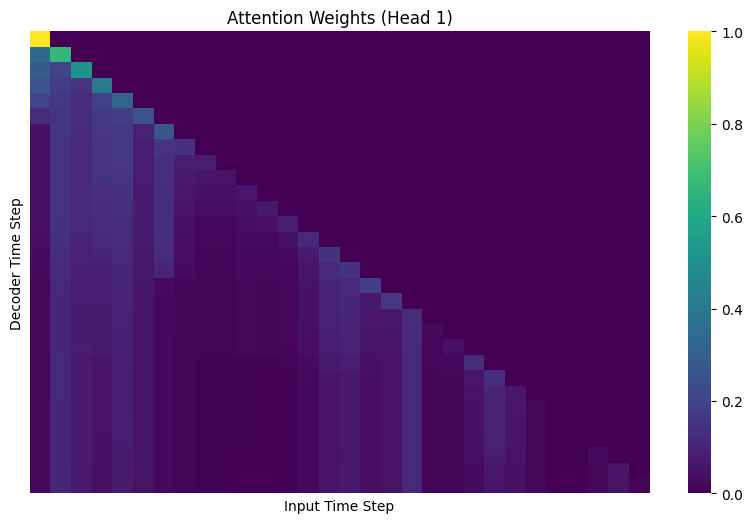

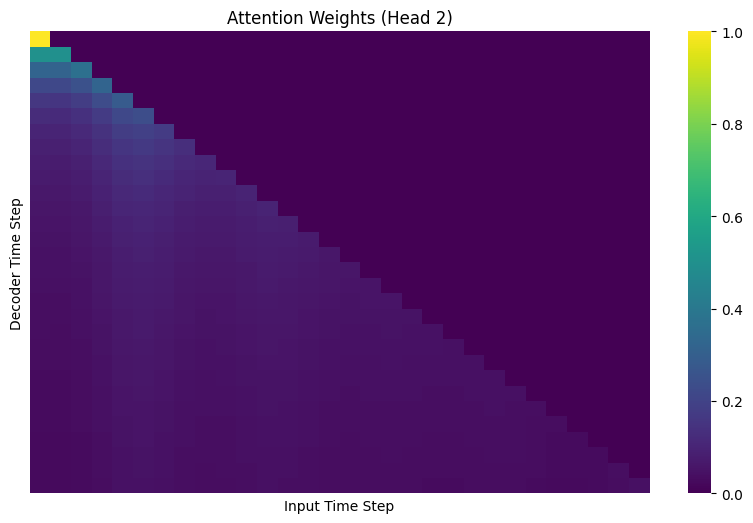

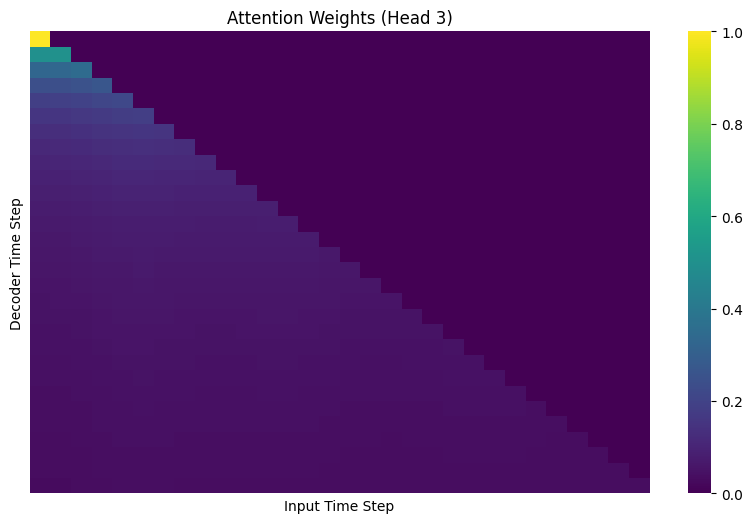

Epoch [59/70], Training Loss: 0.0420, Validation Loss: 0.0472


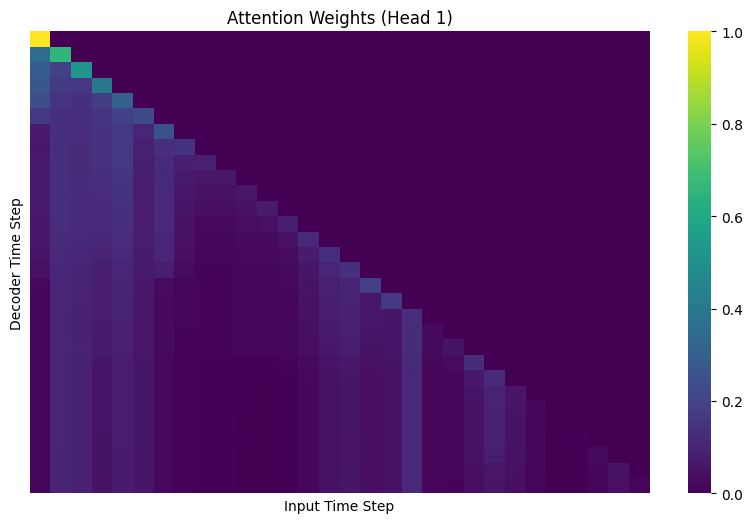

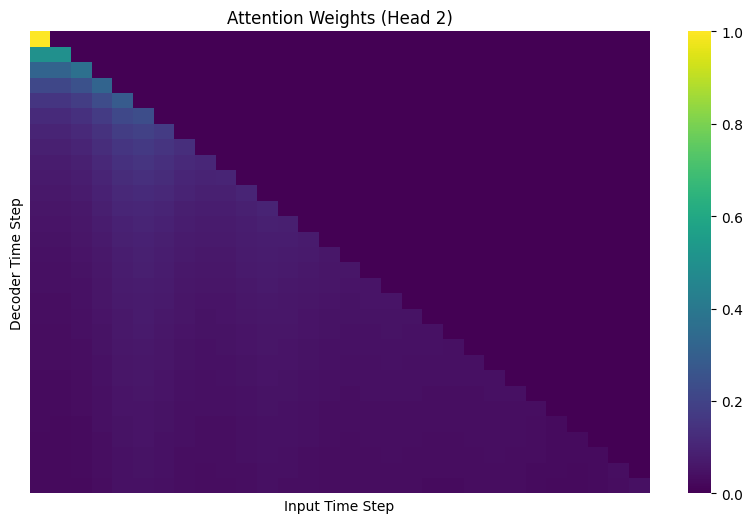

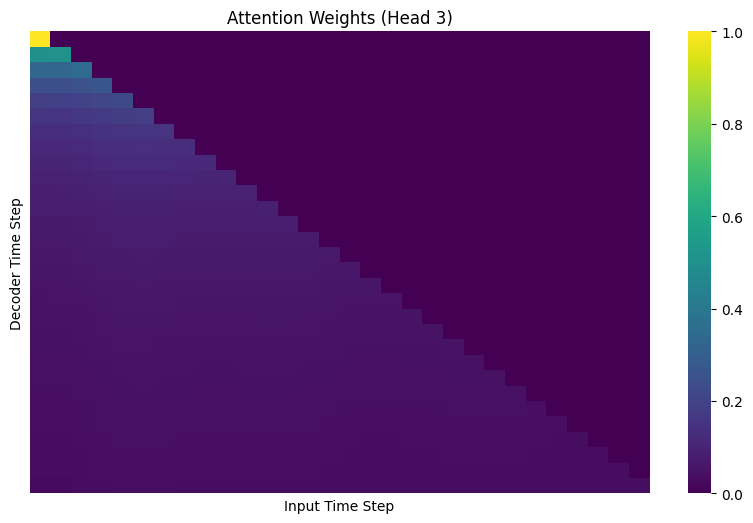

Epoch [60/70], Training Loss: 0.0321, Validation Loss: 0.2512


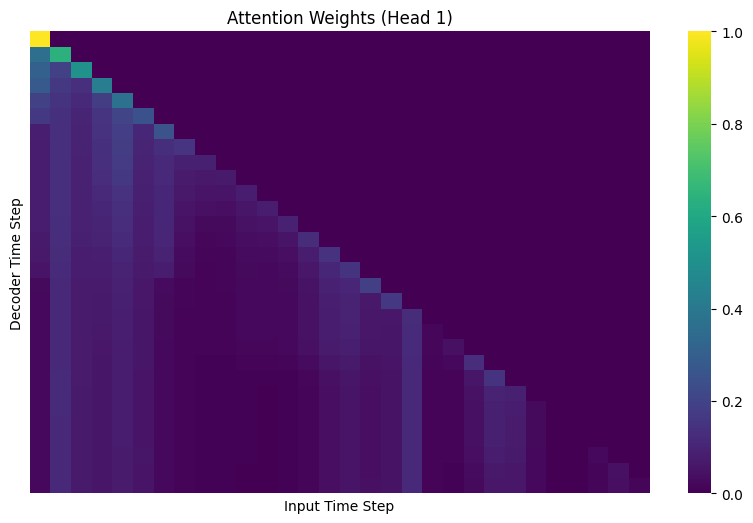

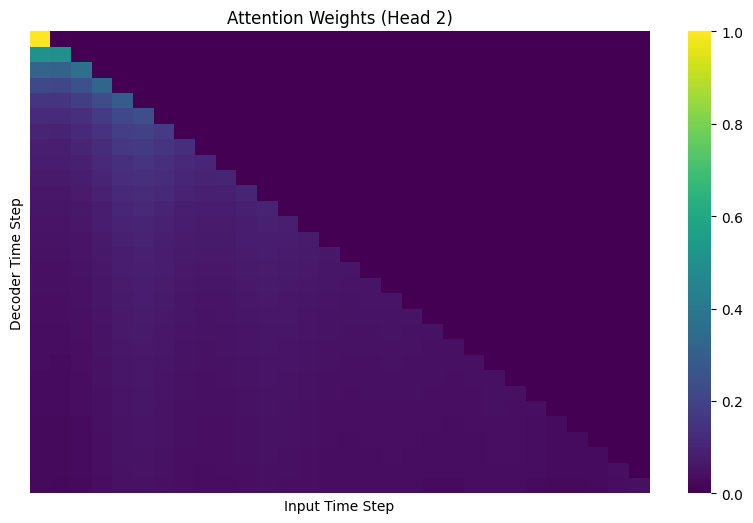

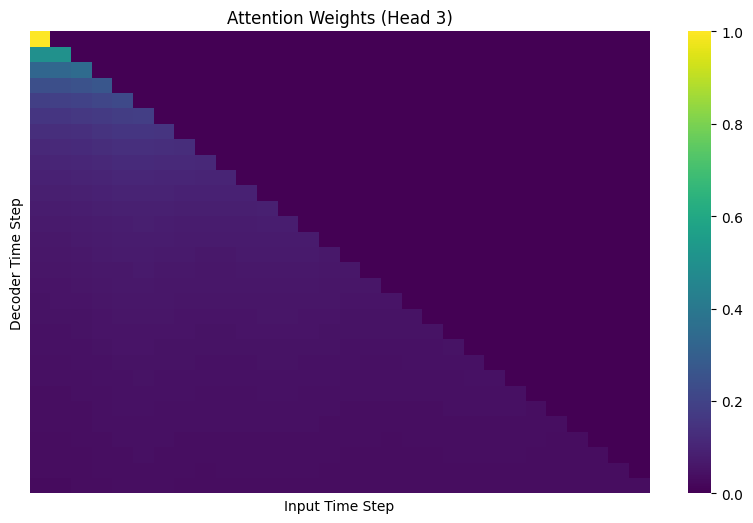

Epoch [61/70], Training Loss: 0.0644, Validation Loss: 0.0436


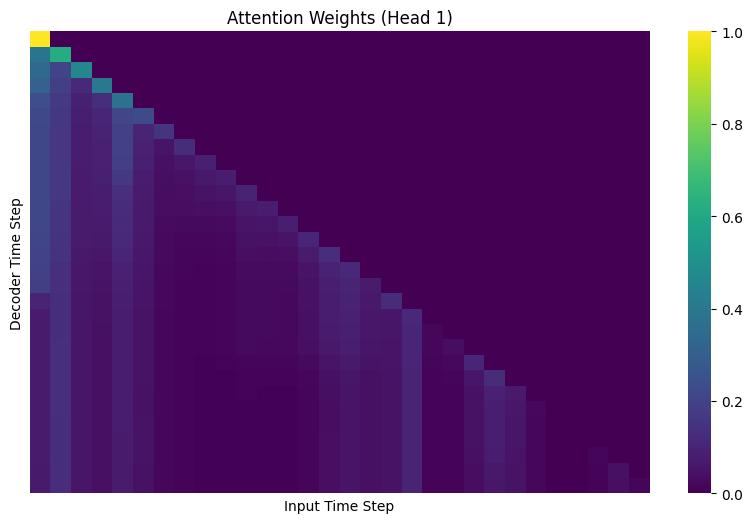

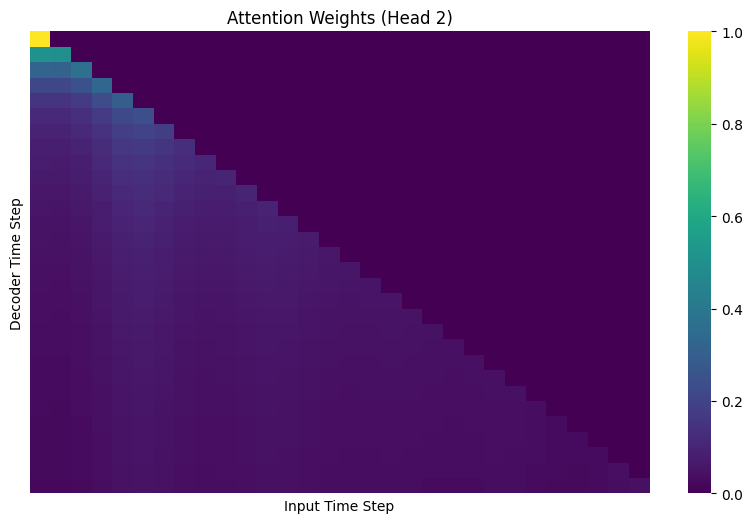

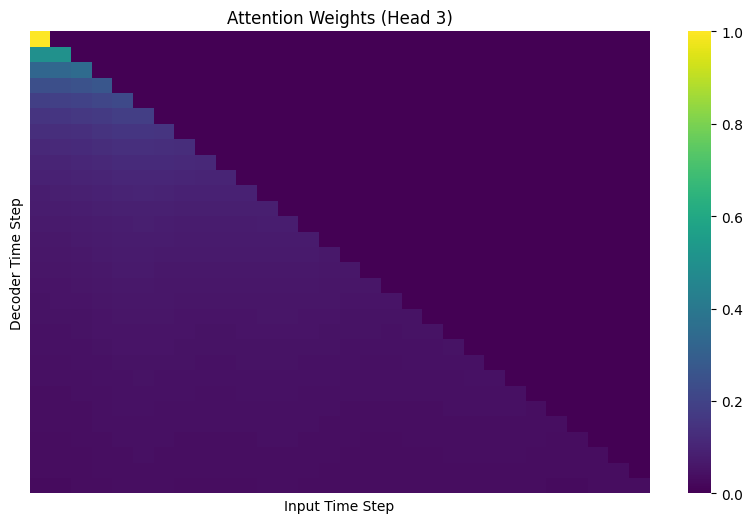

Epoch [62/70], Training Loss: 0.0324, Validation Loss: 0.0204


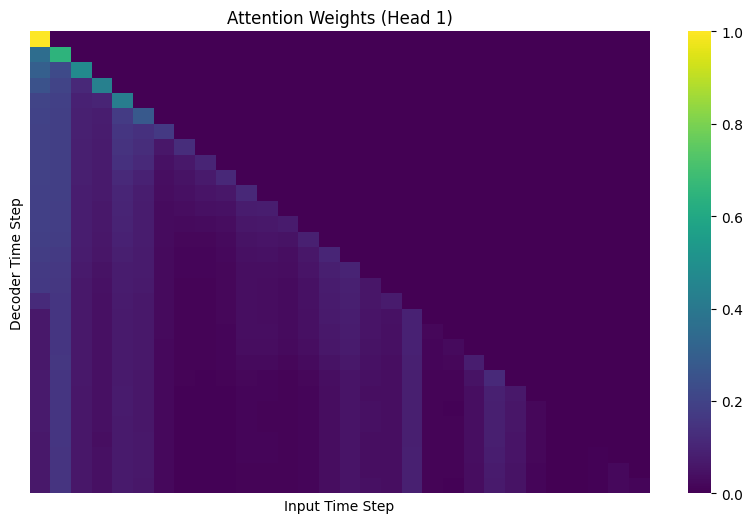

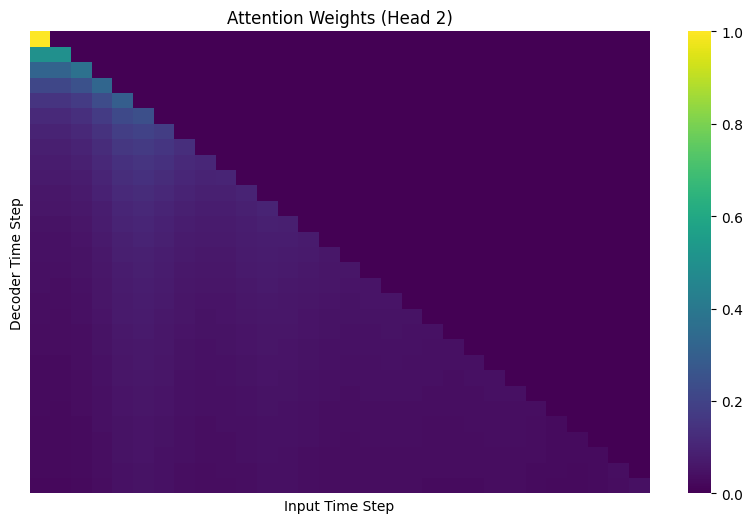

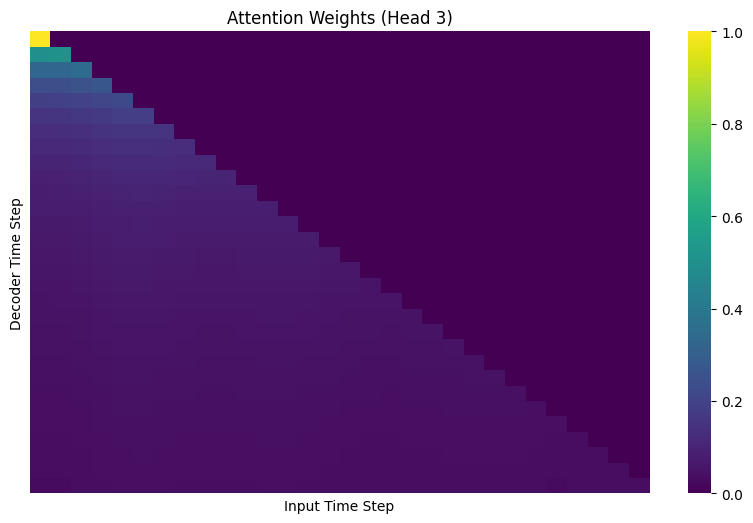

Epoch [63/70], Training Loss: 0.0335, Validation Loss: 0.0199
Saved new best model with Validation Loss: 0.0199


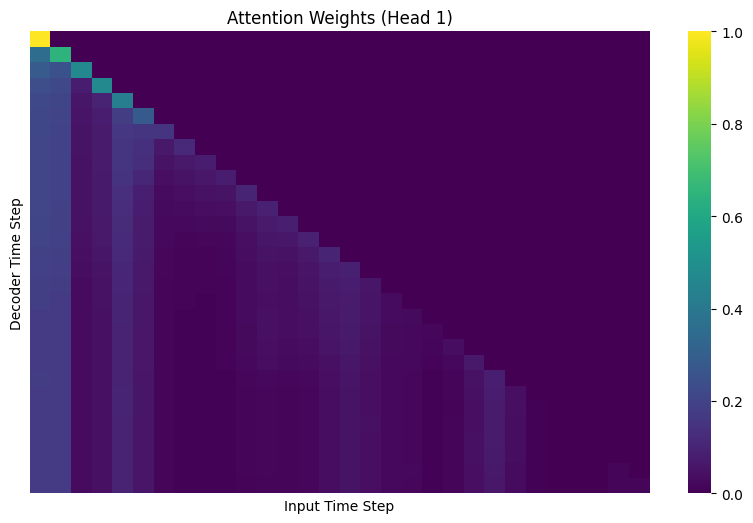

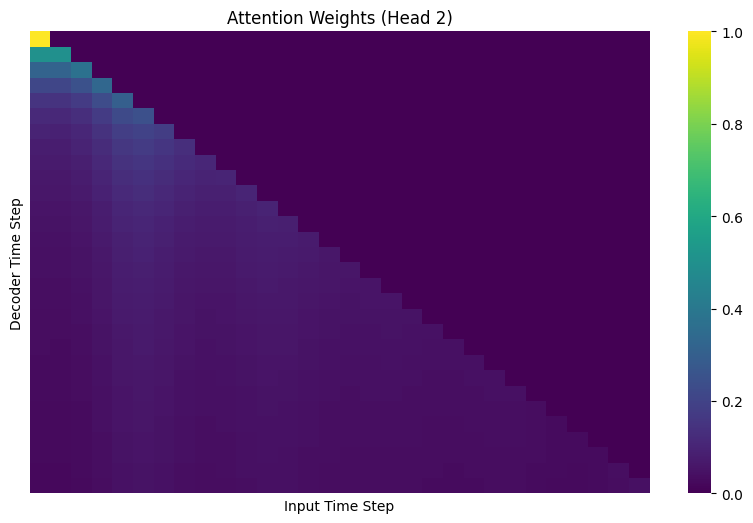

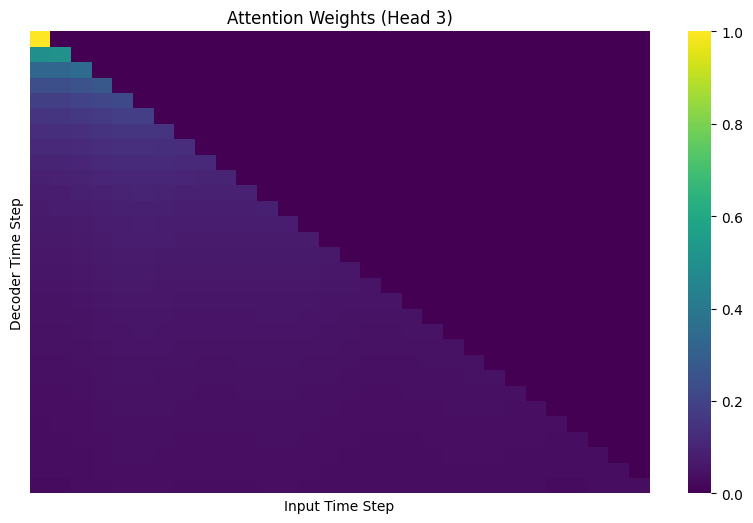

Epoch [64/70], Training Loss: 0.0343, Validation Loss: 0.0219


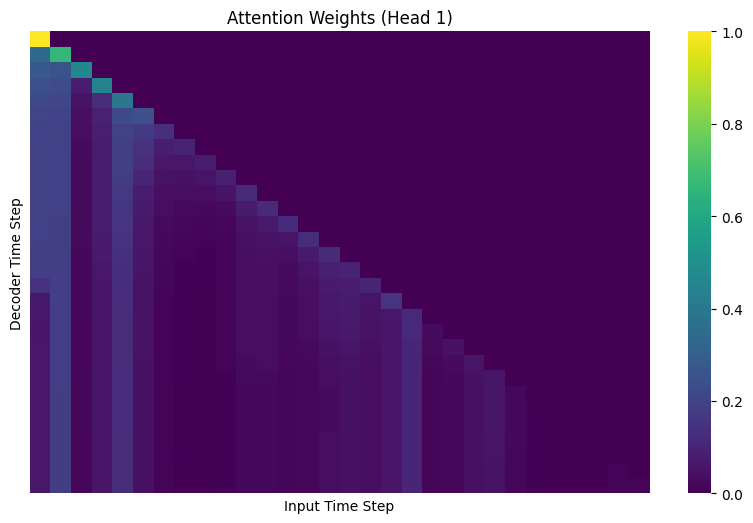

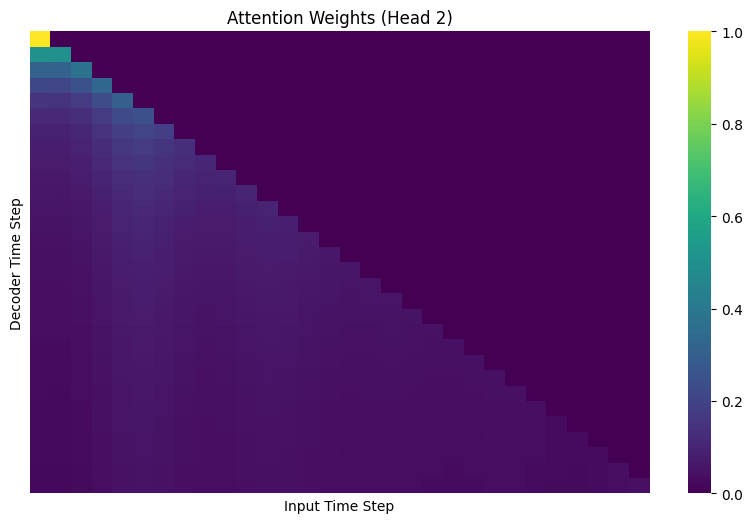

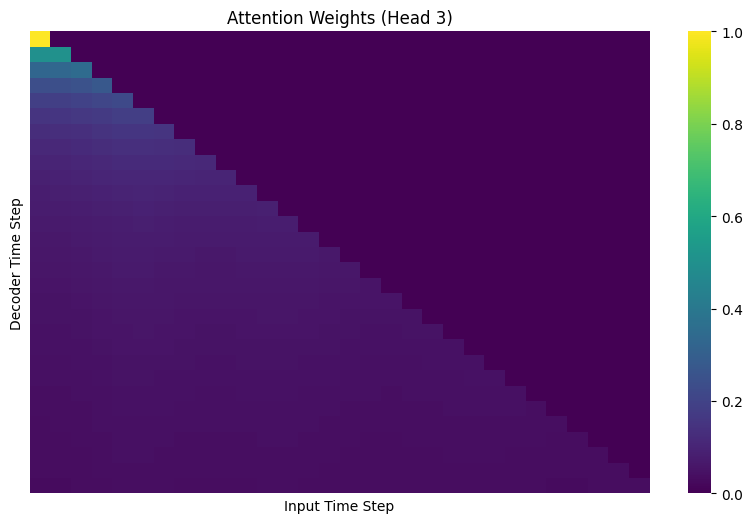

Epoch [65/70], Training Loss: 0.0344, Validation Loss: 0.0354


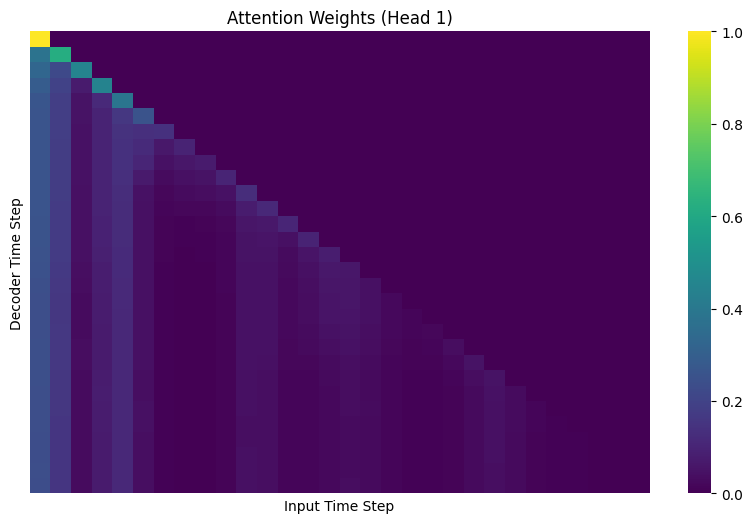

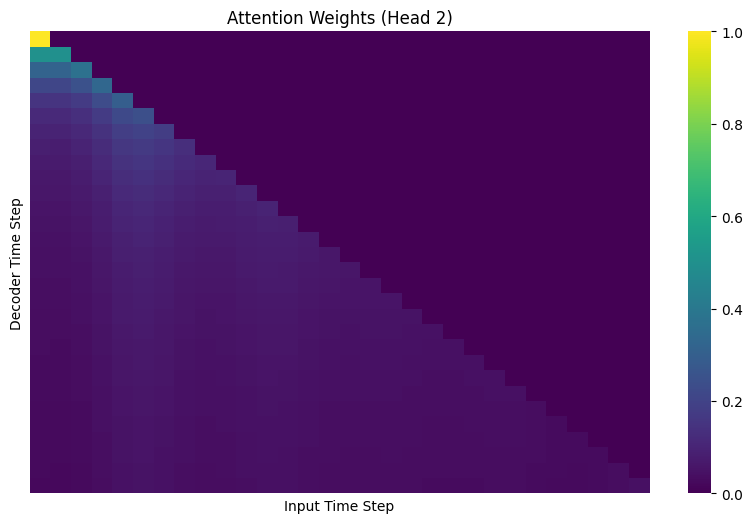

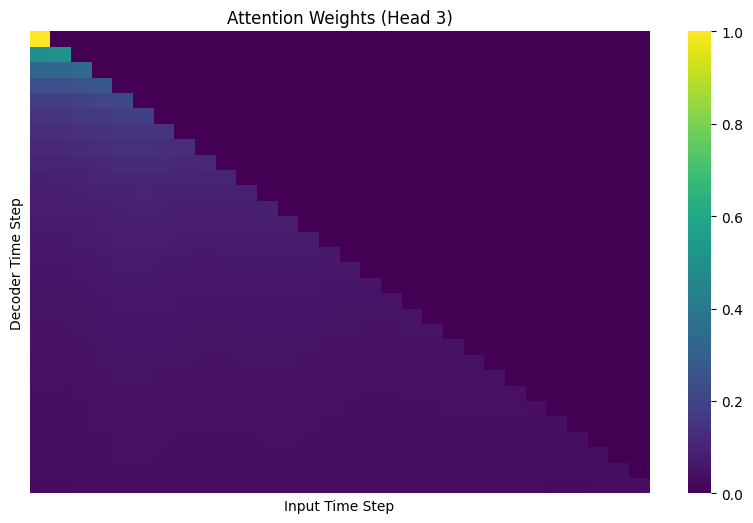

Epoch [66/70], Training Loss: 0.0799, Validation Loss: 0.0150
Saved new best model with Validation Loss: 0.0150


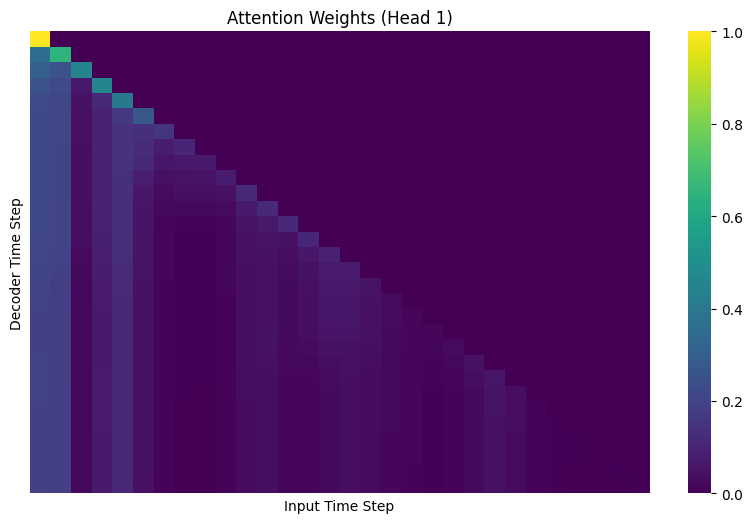

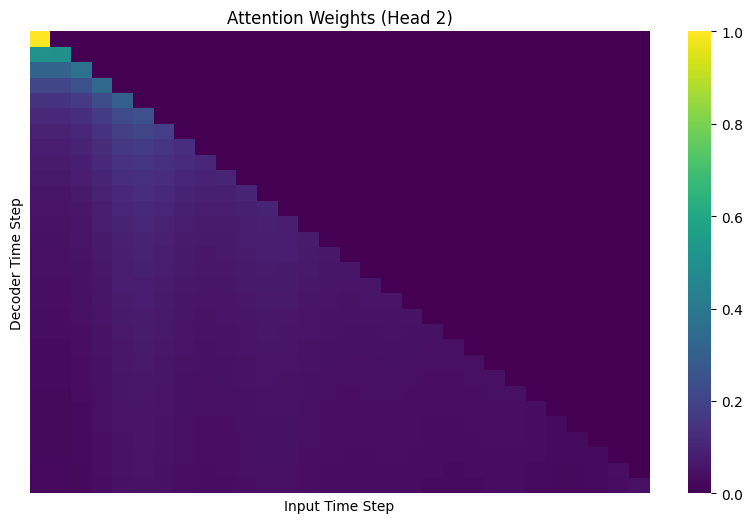

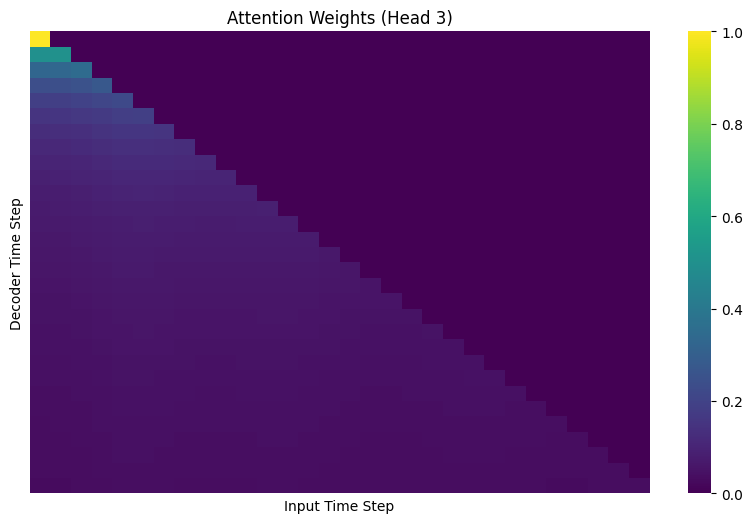

Epoch [67/70], Training Loss: 0.0258, Validation Loss: 0.0210


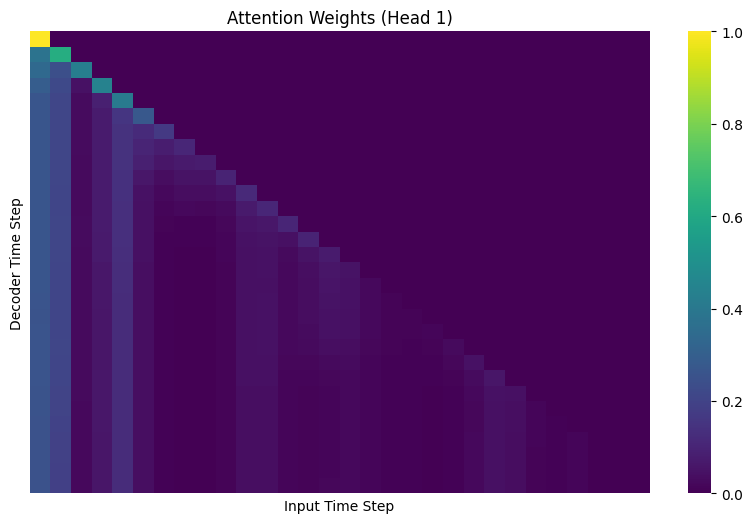

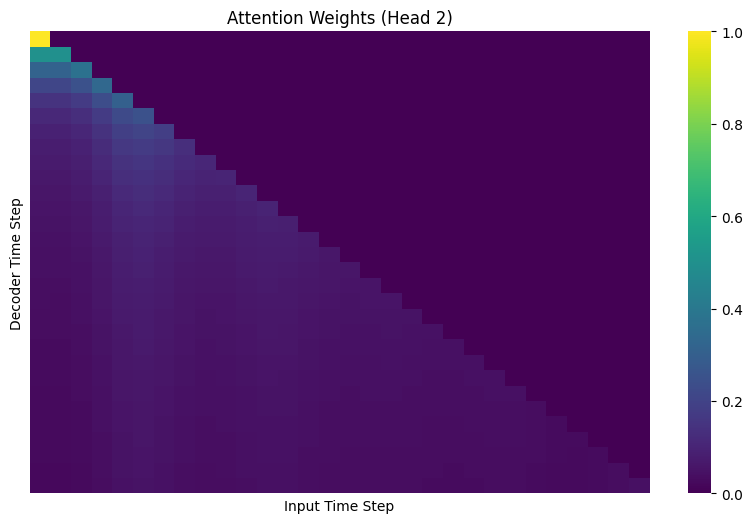

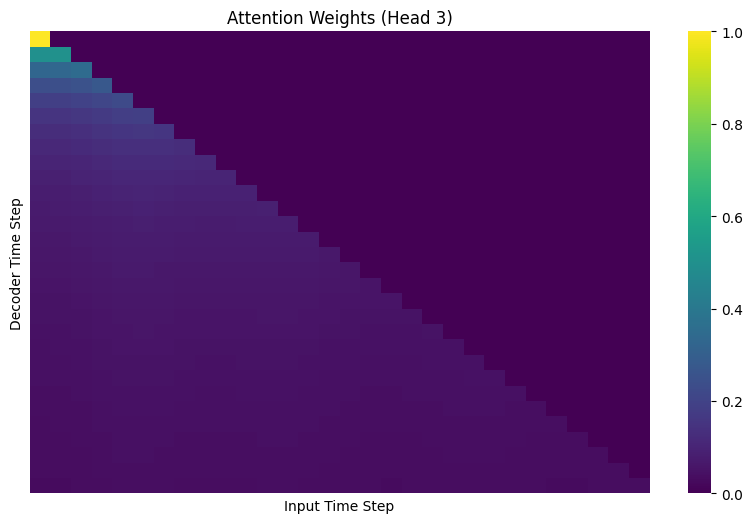

Epoch [68/70], Training Loss: 0.0275, Validation Loss: 0.0243


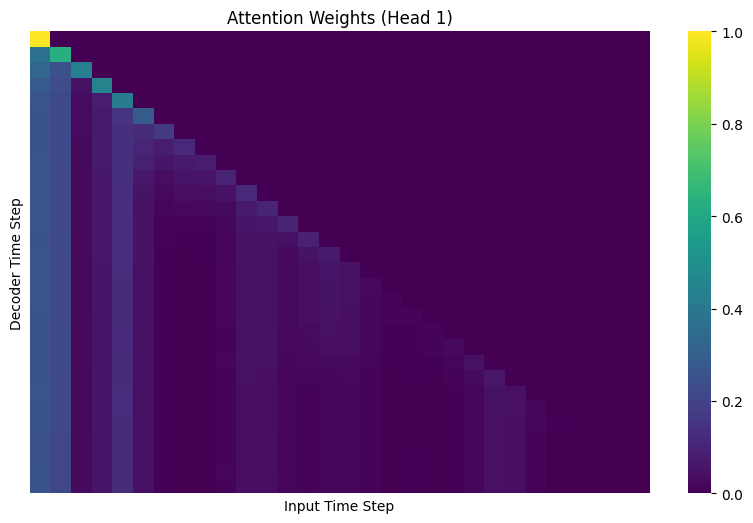

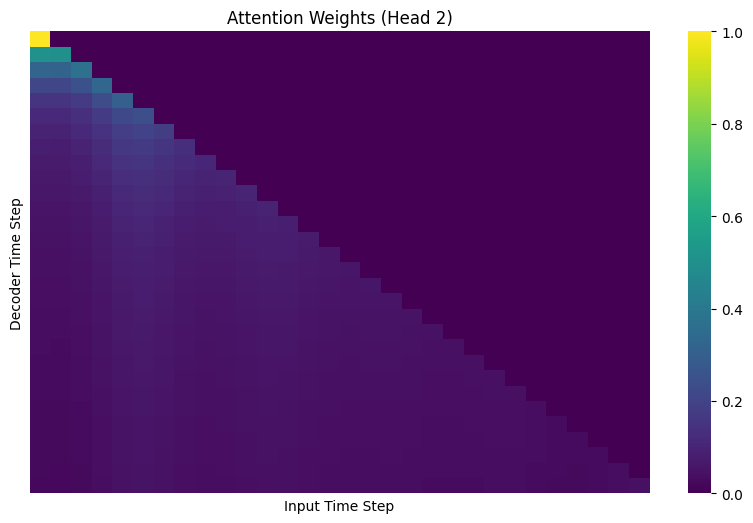

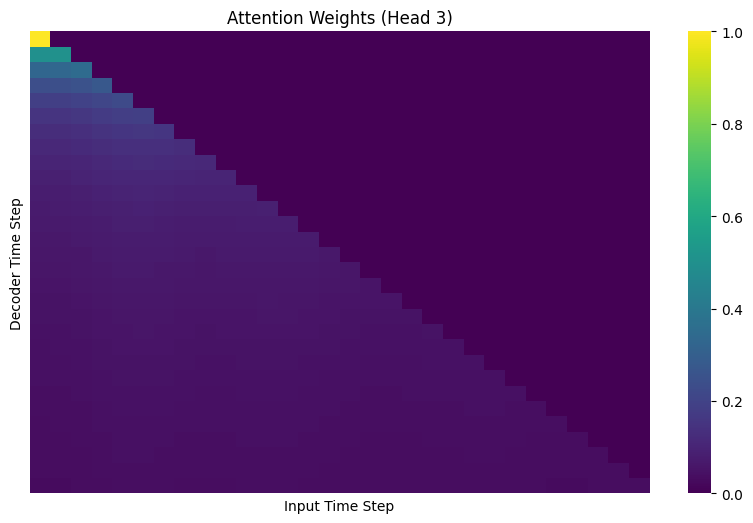

Epoch [69/70], Training Loss: 0.0355, Validation Loss: 0.0323


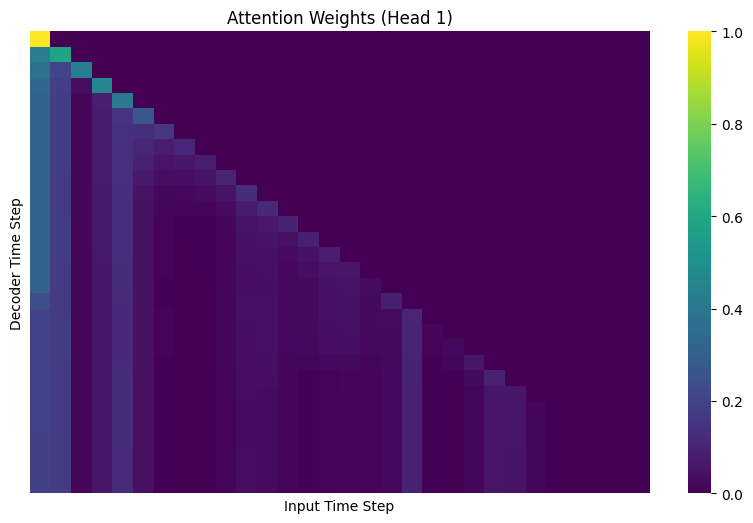

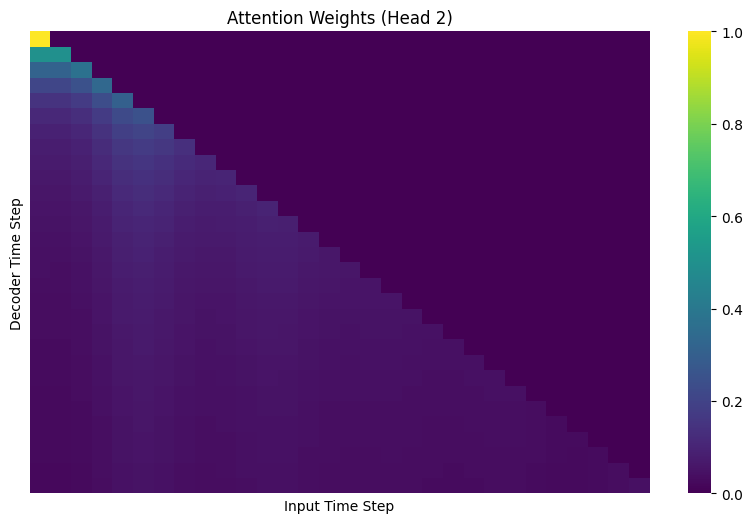

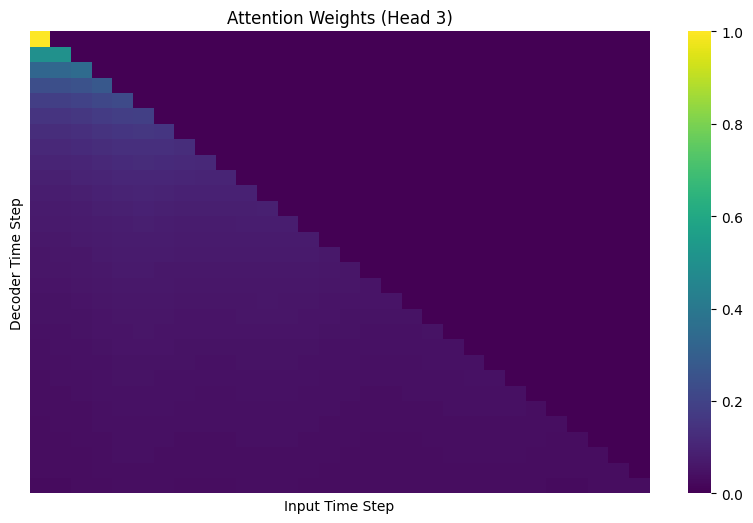

Epoch [70/70], Training Loss: 0.0534, Validation Loss: 0.0166
Attention Weights Shape: (1, 30, 30)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

D_MODEL = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
NUM_EPOCHS = 70
BATCH_SIZE = 256
LEARNING_RATE = 0.001
PREDICTION_SIZE = 7
CONTEXT_SIZE = 30


X_train_tensor = torch.FloatTensor(X_train1).unsqueeze(-1).to(device)
y_train_tensor = torch.FloatTensor(y_train1).unsqueeze(-1).to(device)
X_val_tensor = torch.FloatTensor(X_val1).unsqueeze(-1).to(device)
y_val_tensor = torch.FloatTensor(y_val1).unsqueeze(-1).to(device)
X_test_tensor = torch.FloatTensor(X_test1).unsqueeze(-1).to(device)
y_test_tensor = torch.FloatTensor(y_test1).unsqueeze(-1).to(device)



train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers,
                 num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_linear = nn.Linear(input_dim, d_model)
        self.output_linear = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.decoder_layers = nn.ModuleList([
            CustomDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
            for _ in range(num_decoder_layers)
        ])

        self.final_linear = nn.Linear(d_model, output_dim)
        self.d_model = d_model
        self.attention_weights = []

    def forward(self, src, tgt):
        self.attention_weights = []

        src = self.input_linear(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        tgt = self.output_linear(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)

        memory = self.encoder(src)

        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(device)

        for layer in self.decoder_layers:
            tgt, attn_weights = layer(tgt, memory, tgt_mask=tgt_mask)
            self.attention_weights.append(attn_weights)

        return self.final_linear(tgt)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask



nhead = 8
model = TimeSeriesTransformer(
    input_dim=1, output_dim=1, d_model=D_MODEL, nhead=nhead,
    num_encoder_layers=NUM_ENCODER_LAYERS, num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT
).to(device)


optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()


best_val_loss = float('inf')
best_model_path = "best_transformer_model.pth"

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for src, tgt in train_loader:
        optimizer.zero_grad()
        src, tgt = src.to(device), tgt.to(device)
        outputs = model(src, tgt)
        loss = criterion(outputs, tgt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


    avg_epoch_loss = epoch_loss / len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            outputs = model(src, tgt)
            loss = criterion(outputs, tgt)
            val_loss += loss.item()


    with torch.no_grad():
      example_idx = 17
      test_example_src = X_val_tensor[example_idx:example_idx+1].to(device)
      test_example_tgt = torch.zeros_like(test_example_src).to(device)
      model(test_example_src, test_example_tgt)
      for idx, attn_weights in enumerate(model.attention_weights):
          attn_weights = attn_weights.cpu().numpy()
          plt.figure(figsize=(10, 6))
          sns.heatmap(attn_weights[0, :, :].squeeze(), cmap="viridis", annot=False, xticklabels=False, yticklabels=False)
          plt.xlabel("Input Time Step")
          plt.ylabel("Decoder Time Step")
          plt.title(f"Attention Weights (Head {idx+1})")
          plt.show()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Training Loss: {avg_epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with Validation Loss: {best_val_loss:.4f}")


model.eval()
with torch.no_grad():
    model(test_example_src, test_example_tgt)


attn_weights = model.attention_weights[0].cpu().numpy()
print("Attention Weights Shape:", attn_weights.shape)



- Silne wagi na przekątnej: model skupia się na ostatnich krokach kontekstowych przy prognozowaniu — czyli wykorzystuje najnowsze informacje.

-Silna lewa kolumna - wszyscy patrzą na pierwszy timestamp .

- Na wizualizacji nie widać silnych periodycznych wzorców (np. co 24h, co 7 kroków), które mogłyby sugerować, że model uczy się rytmów dobowych, tygodniowych itp. To może oznaczać, że dane nie mają wyraźnej sezonowości,model jeszcze się tego nie nauczył albo potrzebna byłaby inna architektura lub dłuższy kontekst.

- Część wartości jest rozproszona — co oznacza, że model rozważa więcej niż jeden krok przeszłości przy generowaniu jednej prognozy. To jest również pożądane, bo szereg czasowy często zawiera złożone zależności.

In [ ]:
from torch.nn import MultiheadAttention

from torch.nn import TransformerDecoderLayer

class CustomDecoderLayer(TransformerDecoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, attn_weights_self = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask, need_weights=True)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        # Cross-attention (using memory from the encoder)
        tgt2, attn_weights_cross = self.multihead_attn(tgt, memory, memory, attn_mask=None, key_padding_mask=memory_key_padding_mask, need_weights=True)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        # Feed-forward
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        # Return the output and attention weights for both self and cross attention
        return tgt, attn_weights_self, attn_weights_cross




import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

D_MODEL = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
NUM_EPOCHS = 70
BATCH_SIZE = 256
LEARNING_RATE = 0.001
PREDICTION_SIZE = 7
CONTEXT_SIZE = 30


X_train_tensor = torch.FloatTensor(X_train1).unsqueeze(-1).to(device)
y_train_tensor = torch.FloatTensor(y_train1).unsqueeze(-1).to(device)
X_val_tensor = torch.FloatTensor(X_val1).unsqueeze(-1).to(device)
y_val_tensor = torch.FloatTensor(y_val1).unsqueeze(-1).to(device)
X_test_tensor = torch.FloatTensor(X_test1).unsqueeze(-1).to(device)
y_test_tensor = torch.FloatTensor(y_test1).unsqueeze(-1).to(device)



train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers,
                 num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_linear = nn.Linear(input_dim, d_model)
        self.output_linear = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.decoder_layers = nn.ModuleList([
            CustomDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
            for _ in range(num_decoder_layers)
        ])

        self.final_linear = nn.Linear(d_model, output_dim)
        self.d_model = d_model
        self.attention_weights = []

    def forward(self, src, tgt):
        self.attention_weights = []

        src = self.input_linear(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        tgt = self.output_linear(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)

        memory = self.encoder(src)

        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(device)

        for layer in self.decoder_layers:
          tgt, attn_weights_self, attn_weights_cross = layer(tgt, memory, tgt_mask=tgt_mask)
          self.attention_weights.append((attn_weights_self, attn_weights_cross))


        return self.final_linear(tgt)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask



nhead = 8
model = TimeSeriesTransformer(
    input_dim=1, output_dim=1, d_model=D_MODEL, nhead=nhead,
    num_encoder_layers=NUM_ENCODER_LAYERS, num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT
).to(device)


optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()


best_val_loss = float('inf')
best_model_path = "best_transformer_model.pth"

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for src, tgt in train_loader:
        optimizer.zero_grad()
        src, tgt = src.to(device), tgt.to(device)
        outputs = model(src, tgt)
        loss = criterion(outputs, tgt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


    avg_epoch_loss = epoch_loss / len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            print("tgt.shape", tgt.shape)

            outputs = model(src, tgt)
            print("outputs.shape", outputs.shape)
            loss = criterion(outputs, tgt)
            val_loss += loss.item()


    with torch.no_grad():
      example_idx = 17
      test_example_src = X_val_tensor[example_idx:example_idx+1].to(device)
      test_example_tgt = torch.zeros_like(test_example_src).to(device)
      model(test_example_src, test_example_tgt)
      for idx, (attn_weights_self, attn_weights_cross) in enumerate(model.attention_weights):
          attn_weights_self = attn_weights_self.cpu().numpy()
          attn_weights_cross = attn_weights_cross.cpu().numpy()

          # Plot self-attention
          plt.figure(figsize=(10, 6))
          sns.heatmap(attn_weights_self[0, :, :].squeeze(), cmap="viridis", annot=False, xticklabels=False, yticklabels=False)
          plt.xlabel("Input Time Step")
          plt.ylabel("Decoder Time Step")
          plt.title(f"Self Attention Weights (Head {idx+1})")
          plt.show()

          # Plot cross-attention
          plt.figure(figsize=(10, 6))
          sns.heatmap(attn_weights_cross[0, :, :].squeeze(), cmap="viridis", annot=False, xticklabels=False, yticklabels=False)
          plt.xlabel("Input Time Step")
          plt.ylabel("Decoder Time Step")
          plt.title(f"Cross Attention Weights (Head {idx+1})")
          plt.show()

          print("Cross-shape", attn_weights_cross.shape)
          print("Self-shape", attn_weights_self.shape)


    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Training Loss: {avg_epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with Validation Loss: {best_val_loss:.4f}")


model.eval()
with torch.no_grad():
    model(test_example_src, test_example_tgt)


attn_weights = model.attention_weights[0].cpu().numpy()
print("Attention Weights Shape:", attn_weights.shape)



Using device: cuda
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.shape torch.Size([256, 7, 1])
tgt.shape torch.Size([256, 7, 1])
outputs.sha

KeyboardInterrupt: 